In [64]:
import sys
from pathlib import Path
repo_root = Path.cwd().resolve().parent
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))
from src.utils.paths import load_paths
paths = load_paths()


## 0. Imports and code config

In [ ]:
# === 0) Imports & core config ===
# !pip install -q pybioclip scikit-learn pandas numpy pillow torch

import json, random, hashlib, os, time
from pathlib import Path
from collections import defaultdict
from datetime import datetime

import numpy as np
import pandas as pd
from PIL import Image
import torch

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, balanced_accuracy_score

# BioCLIP: used as a feature extractor (image -> embedding vector)
from bioclip.predict import BaseClassifier

# ---- paths (adjust these if needed) ----
CLASS_NAMES = paths['processed_dir'] / 'class_names_no_ixodes.json'   # species list
DATA        = paths['processed_dir'] / 'final_data_no_ixodes.json'    # records: image_path, true_label, sample_id, view

# ---- experiment knobs (global conventions we agreed) ----
SHOTS      = [1, 3, 5, 10, 20]   # K values to sweep
RUNS       = 100             # number of Monte Carlo runs per shots level
BASE_SEED  = 42              # base for deterministic seed derivation
BAND       = "sd"            # "sd" 
MIN_TOTAL  = 20              # species must have >=30 individuals

# ---- results locations ----
# Base results directory from config
SVM_RESULTS = paths.get('svm_results_dir', paths['results_dir'] / 'svm')
if isinstance(SVM_RESULTS, str):
    SVM_RESULTS = paths['results_dir'].parent / SVM_RESULTS
SVM_RESULTS.mkdir(parents=True, exist_ok=True)

# Each run gets a timestamped folder: results/svm/runs/YYMMDD_HHMMSS/
RUN_ID = datetime.now().strftime("%y%m%d_%H%M%S")
RUN_DIR = SVM_RESULTS / "runs" / RUN_ID
RUN_DIR.mkdir(parents=True, exist_ok=True)

# Outputs for this run
PREDICTIONS_CSV = RUN_DIR / "predictions.csv"
PLOTS_DIR = RUN_DIR / "plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)
ANALYSIS_DIR = RUN_DIR / "analysis"
ANALYSIS_DIR.mkdir(parents=True, exist_ok=True)

# Aggregated results (across all runs) go in results/svm/aggregated/
AGGREGATED_DIR = SVM_RESULTS / "aggregated"
AGGREGATED_DIR.mkdir(parents=True, exist_ok=True)

# ---- preview/save controls (you can flip these later) ----
PREVIEW_PLOTS = True   # show plots inline while iterating
SAVE_PLOTS    = True   # save PNGs to PLOTS_DIR

# ---- per-image embedding cache (under data/processed/) ----
EMB_CACHE = paths['emb_cache_dir']
EMB_CACHE.mkdir(parents=True, exist_ok=True)

# ---- device + model init ----
DEVICE = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
BC = BaseClassifier(device=DEVICE)

# ---- helpers ----
def seed_for(shots: int, run_id: int, base: int = BASE_SEED) -> int:
    """
    Independent few-shot: unique seed per (shots K, run_id).
    Prevents 'growing' the same cohort across K.
    """
    return int(base + 10_000 * shots + run_id)

# optional: fix global RNGs for any non-swept randomness
random.seed(BASE_SEED)
np.random.seed(BASE_SEED)

# canonical class order placeholder (set after Block 1 once we know retained species)
CLASS_ORDER = None

# ---- run-time banner ----
print("=" * 60)
print("SVM Few-Shot Classification Pipeline")
print("=" * 60)
print(f"Run ID:           {RUN_ID}")
print(f"Run directory:    {RUN_DIR.resolve()}")
print(f"Predictions CSV:  {PREDICTIONS_CSV.resolve()}")
print(f"Plots dir:        {PLOTS_DIR.resolve()}")
print(f"Analysis dir:     {ANALYSIS_DIR.resolve()}")
print(f"Embedding cache:  {EMB_CACHE.resolve()}")
print(f"Device:           {DEVICE}")
print(f"Config -> SHOTS: {SHOTS} | RUNS: {RUNS} | MIN_TOTAL: {MIN_TOTAL}")
print("=" * 60)

SVM Few-Shot Classification Pipeline
Run ID:           260208_205637
Run directory:    /Users/jayjivandas/Research_Imageomics/BioClip/tick_classification_project/results/svm/runs/260208_205637
Predictions CSV:  /Users/jayjivandas/Research_Imageomics/BioClip/tick_classification_project/results/svm/runs/260208_205637/predictions.csv
Plots dir:        /Users/jayjivandas/Research_Imageomics/BioClip/tick_classification_project/results/svm/runs/260208_205637/plots
Analysis dir:     /Users/jayjivandas/Research_Imageomics/BioClip/tick_classification_project/results/svm/runs/260208_205637/analysis
Embedding cache:  /Users/jayjivandas/Research_Imageomics/BioClip/tick_classification_project/data/processed/emb_cache
Device:           mps
Config -> SHOTS: [1, 3, 5, 10, 20] | RUNS: 100 | MIN_TOTAL: 25


## 1. Load classes and Specimens

In [ ]:
# === Block 1 — Load Classes and Data → Build Specimen Index (clean version) ===

# 1) Load class list and data
with open(CLASS_NAMES, "r") as f:
    SPECIES_LIST = set(json.load(f))

with open(DATA, "r") as f:
    data = json.load(f)  # list of records (image_path, true_label, sample_id, view)

# 2) Build specimen index:
#    by_species[species][sample_id] -> {"dorsal": <path>, "ventral": <path>}
by_species = defaultdict(lambda: defaultdict(dict))
for r in data:
    sp = r["true_label"]
    if sp not in SPECIES_LIST:
        continue
    sid  = r["sample_id"]
    view = str(r["view"]).strip().lower()
    by_species[sp][sid][view] = r["image_path"]

# 3) Keep only specimens with BOTH views
for sp in list(by_species.keys()):
    for sid in list(by_species[sp].keys()):
        views = by_species[sp][sid]
        if not ("dorsal" in views and "ventral" in views):
            del by_species[sp][sid]
    if not by_species[sp]:
        del by_species[sp]

# 4) Enforce ≥ MIN_TOTAL individuals per species
for sp in list(by_species.keys()):
    if len(by_species[sp]) < MIN_TOTAL:
        del by_species[sp]

included_species = sorted(by_species.keys())

# 5) Set canonical class order sorted by descending N (total specimens per species)
SPECIES_N = {sp: len(by_species[sp]) for sp in included_species}
CLASS_ORDER = sorted(included_species, key=lambda sp: SPECIES_N[sp], reverse=True)

# 6) Print summary
n_specimens = sum(len(smap) for smap in by_species.values())
print(f"Included species: {len(included_species)}")
print(f"Total usable specimens (both views, species ≥ {MIN_TOTAL}): {n_specimens}")
for sp in CLASS_ORDER:
    print(f"  {sp}: {SPECIES_N[sp]} specimens")

assert len(included_species) > 0, "No species meet the criteria (both views and MIN_TOTAL)."
print("CLASS_ORDER set for downstream use:", CLASS_ORDER)

## Block 2 Train test split

In [67]:
# === Block 2 — Train/Test Split (shots-aware, Seeded, prints) ===
def split_for_run(by_species, species_list, k, run_id):
    """Independent split for this (K=k, run_id) using the new seed_for()."""
    seed = seed_for(k, run_id)         # <- uses your new Block-0 seed_for
    return split_once(by_species, species_list, k=k, seed=seed)

def split_once(by_species, species_list, k, seed):
    rng = random.Random(seed)
    train_pairs, test_pairs = [], []
    per_species_counts = {}

    for sp in species_list:
        sids = list(by_species[sp].keys())
        rng.shuffle(sids)
        tr, te = sids[:k], sids[k:]

        # Sanity checks per your policy
        assert len(tr) == k, f"{sp}: needs exactly {k} train specimens, found {len(tr)}"
        assert len(te) >= 1, f"{sp}: needs at least 1 test specimen (has {len(sids)} total)"

        train_pairs.extend([(sp, sid) for sid in tr])
        test_pairs.extend([(sp, sid) for sid in te])
        per_species_counts[sp] = {"train": len(tr), "test": len(te), "total": len(sids)}

    # No leakage: specimen (sample_id) cannot be in both sets
    assert not (set(train_pairs) & set(test_pairs)), "Leakage detected: same (species, sample_id) in train & test"

    n_test_run = len(test_pairs)
    return train_pairs, test_pairs, per_species_counts, n_test_run


# --- Example single-run preview (keep this pattern for ad-hoc checks) ---
K_demo    = 5          # can use 1 / 3 / 10 too
RUN_demo  = 0          # change this to see different runs at same K

train_pairs, test_pairs, split_counts, n_test_run = split_for_run(
    by_species, included_species, k=K_demo, run_id=RUN_demo
)

# ---- Summary prints (unchanged style) ----
n_species = len(included_species)
n_train   = len(train_pairs)
n_test    = len(test_pairs)

print(f"(K, run) = ({K_demo}, {RUN_demo}) | seed = {seed_for(K_demo, RUN_demo)}")
print(f"Species included: {n_species}")
print(f"Train specimens: {n_train}  (expected {K_demo} × {n_species} = {K_demo*n_species})")
print(f"Test specimens:  {n_test}")

for sp in included_species:
    c = split_counts[sp]
    print(f"  {sp}: total={c['total']}, train={c['train']}, test={c['test']}")

# Optional: peek a few chosen IDs per species
for sp in included_species:
    chosen = [sid for (s, sid) in train_pairs if s == sp][:min(3, K_demo)]
    print(f"  Train IDs sample — {sp}: {chosen}")

(K, run) = (5, 0) | seed = 50042
Species included: 5
Train specimens: 25  (expected 5 × 5 = 25)
Test specimens:  558
  Amblyomma americanum: total=87, train=5, test=82
  Dermacentor variabilis: total=303, train=5, test=298
  Haemaphysalis longicornis: total=29, train=5, test=24
  Ixodes cookei: total=28, train=5, test=23
  Ixodes scapularis: total=136, train=5, test=131
  Train IDs sample — Amblyomma americanum: ['43-16', 'ZOE-0014-01', 'ZOE-0014-03']
  Train IDs sample — Dermacentor variabilis: ['364-01', 'ZOE-0089-02', '204-01']
  Train IDs sample — Haemaphysalis longicornis: ['563-01', 'OPL-0102-03', '26-01']
  Train IDs sample — Ixodes cookei: ['562-01', 'T14748', 'T17483']
  Train IDs sample — Ixodes scapularis: ['41-04', '59-03', '60-02']


## Block 3: Embedding helpers, getting the embeddings and building our Cache. 

In [68]:
# === Block 3 — Embedding Helpers (Per-Image Cache + Specimen Vector) ===

# Per-image cache filename (hash of the image path -> unique + reproducible)
def _cache_fp(img_path: str) -> Path:
    h = hashlib.sha256(img_path.encode("utf-8")).hexdigest()[:24]
    return EMB_CACHE / f"{h}.npy"

# Single-image -> embedding (uses cache if available)
def embed_image(img_path: str) -> np.ndarray:
    """
    Input:  path to an image file
    Output: 1D numpy array (BioCLIP embedding), L2-normalized if normalize=True in create_image_features
    """
    fp = _cache_fp(img_path)
    if fp.exists():
        return np.load(fp)
    pil = Image.open(img_path).convert("RGB")
    vec = BC.create_image_features([pil], normalize=True).cpu().numpy()[0]
    np.save(fp, vec)
    return vec

# Specimen-level vector: average dorsal + ventral embeddings -> one vector per specimen
def specimen_vec(rec: dict) -> np.ndarray:
    """
    rec is: {"dorsal": <path>, "ventral": <path>}
    Returns a single vector for the specimen: 0.5*(z_dorsal + z_ventral)
    """
    z_d = embed_image(rec["dorsal"])
    z_v = embed_image(rec["ventral"])
    return 0.5 * (z_d + z_v)

## Block 4- build X/Y, Train SVM, Metrics, SINGLE SEED

In [69]:
# === Block 4 — Build X/y, Train SVM, Predict, Collect Rows (per run) ===

# helper: turn (species, sample_id) pairs into X (embeddings) and y (labels)
def build_xy(by_species, pairs):
    X, y, ids = [], [], []
    for sp, sid in pairs:
        rec = by_species[sp][sid]          # {"dorsal":..., "ventral":...}
        X.append(specimen_vec(rec))        # averaged dorsal+ventral embedding
        y.append(sp)                       # species label
        ids.append(sid)                    # specimen ID for reporting
    return np.stack(X), np.array(y), ids


def train_predict_collect(by_species,
                          train_pairs, test_pairs,
                          *,
                          shots: int, run_id: int, n_test_run: int):
    """
    Trains the SVM on the given split and collects per-specimen rows for master CSV.
    Returns:
      pred_rows       : list[dict]  (rows for master_predictions.csv)
      per_class_df    : DataFrame  (class_acc, n_test_class)
      macro_acc       : float
      overall_acc     : float
      y_true, y_pred  : np.ndarray, np.ndarray  (for confusion / preview plots)
    """

    # --- Derive the run-specific seed HERE to guarantee independence
    seed = seed_for(shots, run_id)

    # --- Build train/test matrices
    Xtr, ytr, _      = build_xy(by_species, train_pairs)
    Xte, yte, te_ids = build_xy(by_species, test_pairs)

    # --- SVM pipeline (scale → RBF SVM); probability=True to get confidence
    clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm", SVC(kernel="rbf", class_weight="balanced", probability=True, random_state=seed))
    ])

    # --- Train + predict
    clf.fit(Xtr, ytr)
    yhat  = clf.predict(Xte)
    probs = clf.predict_proba(Xte)
    conf  = probs.max(axis=1)   # top-class probability per specimen

    # --- Metrics (overall + macro balanced)
    overall_acc = accuracy_score(yte, yhat)

    tmp = pd.DataFrame({"true": yte, "pred": yhat})
    per_species_acc = (
        tmp.assign(hit=(tmp.true == tmp.pred).astype(int))
           .groupby("true")["hit"].mean()
    )
    macro_acc = float(per_species_acc.mean())

    # --- Per-class table (for quick prints + later aggregation if needed)
    per_class_df = (
        tmp.assign(hit=(tmp.true == tmp.pred).astype(int), one=1)
           .groupby("true")
           .agg(class_acc=("hit", "mean"), n_test_class=("one", "sum"))
           .rename_axis("class")
           .reset_index()
    )

    # --- Prepare rows for master CSV (do NOT save here; Block 5 will append)
    pred_rows = []
    for sid, t, p, c in zip(te_ids, yte, yhat, conf):
        pred_rows.append({
            "shots": int(shots),
            "run_id": int(run_id),
            "seed": int(seed),           # keep seed recorded for repro
            "sample_id": str(sid),
            "species_true": str(t),
            "species_pred": str(p),
            "correct": int(t == p),
            "conf_top1": float(c),
            "n_test_run": int(n_test_run)
        })

    # --- Prints (same vibe as your original cell)
    print(f"Seed: {seed} | Shots: {shots} | Run: {run_id}")
    print(f"Overall accuracy: {overall_acc:.3f}")
    print(f"Macro (balanced) accuracy: {macro_acc:.3f}")
    preview = pd.DataFrame({
        "sample_id": te_ids[:10],
        "true_label": yte[:10],
        "pred_label": yhat[:10],
        "pred_confidence": conf[:10]
    })
    display(preview)

    return pred_rows, per_class_df, macro_acc, overall_acc, yte, yhat


In [70]:
# --- one demo run to produce the variables Block 5 needs ---

# tiny helper so we always derive the seed from (K, run_id) in one place
def split_for_run(by_species, species_list, k, run_id):
    return split_once(by_species, species_list, k=k, seed=seed_for(k, run_id))

# pick a shots/run pair (change as you like)
shots  = 5
run_id = 0

# make the split (independent per (K, run))
train_pairs, test_pairs, split_counts, n_test_run = split_for_run(
    by_species, included_species, k=shots, run_id=run_id
)

# train & predict (Block 4 now derives seed internally via seed_for(shots, run_id))
pred_rows, per_class_df, macro_acc, overall_acc, y_true, y_pred = train_predict_collect(
    by_species, train_pairs, test_pairs,
    shots=shots, run_id=run_id, n_test_run=n_test_run
)

# quick sanity check so you KNOW they exist
print("pred_rows:", len(pred_rows), "rows")
print("macro_acc:", macro_acc, "overall_acc:", overall_acc)

Seed: 50042 | Shots: 5 | Run: 0
Overall accuracy: 0.749
Macro (balanced) accuracy: 0.718


,sample_id,true_label,pred_label,pred_confidence
0,35-01,Amblyomma americanum,Amblyomma americanum,0.331055
1,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.262127
2,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.276560
3,241-01,Amblyomma americanum,Haemaphysalis longicornis,0.301729
4,276-01,Amblyomma americanum,Haemaphysalis longicornis,0.277205
5,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.273433
6,414-01,Amblyomma americanum,Haemaphysalis longicornis,0.287525
7,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.295235
8,19-02,Amblyomma americanum,Amblyomma americanum,0.315074
9,252-01,Amblyomma americanum,Haemaphysalis longicornis,0.286991


pred_rows: 558 rows
macro_acc: 0.7181997551904498 overall_acc: 0.7491039426523297


## Block 5 Reporting and saving results for a single seed


Run 0 (seed=50042) — Shots 5 | Overall: 0.749 | Macro: 0.718


,species,n_test,n_correct,accuracy_species,shots,seed
2,Haemaphysalis longicornis,24,22,0.917,5,50042
1,Dermacentor variabilis,298,255,0.856,5,50042
3,Ixodes cookei,23,16,0.696,5,50042
4,Ixodes scapularis,131,88,0.672,5,50042
0,Amblyomma americanum,82,37,0.451,5,50042



[INFO] This is a single demo run. Use Block 6 to run the full Monte Carlo sweep.
[INFO] Results will be saved to: /Users/jayjivandas/Research_Imageomics/BioClip/tick_classification_project/results/svm/runs/260208_205637/predictions.csv


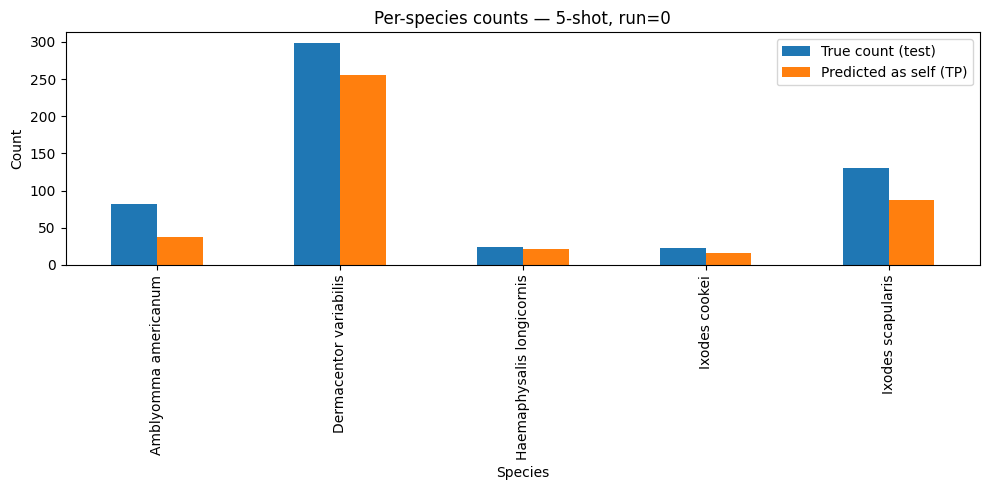


Confusion table (counts) — 5-shot, run=0


pred,Amblyomma americanum,Dermacentor variabilis,Haemaphysalis longicornis,Ixodes cookei,Ixodes scapularis
true,,,,,
Amblyomma americanum,37,0,39,6,0
Dermacentor variabilis,19,255,24,0,0
Haemaphysalis longicornis,2,0,22,0,0
Ixodes cookei,0,0,7,16,0
Ixodes scapularis,4,0,25,14,88


In [71]:
# === Block 5 — Single-run reporting (preview only, no saving yet) ===
# Uses from Block 4: pred_rows, per_class_df, macro_acc, overall_acc, y_true, y_pred
# Globals: CLASS_ORDER, PREVIEW_PLOTS, PLOTS_DIR

import matplotlib.pyplot as plt

# ---- 1) Collect run metadata ----
df_run = pd.DataFrame(pred_rows)
shots  = int(df_run["shots"].iloc[0])
run_id_val = int(df_run["run_id"].iloc[0])

# Prefer the recorded seed; if missing, recompute from (shots, run_id) to keep independence invariant.
if "seed" in df_run.columns and not pd.isna(df_run["seed"].iloc[0]):
    seed = int(df_run["seed"].iloc[0])
else:
    seed = seed_for(shots, run_id_val)

# ---- 2) Per-species summary table ----
tmp = pd.DataFrame({"true": y_true, "pred": y_pred})
per_species = (
    tmp.assign(hit=(tmp.true == tmp.pred).astype(int), one=1)
       .groupby("true")
       .agg(n_test=("one","sum"), n_correct=("hit","sum"))
       .assign(accuracy_species=lambda d: d.n_correct / d.n_test)
       .reset_index()
       .rename(columns={"true": "species"})
)
per_species["shots"] = shots
per_species["seed"]  = seed

with pd.option_context('display.float_format', '{:.3f}'.format):
    print(f"\nRun {run_id_val} (seed={seed}) — Shots {shots} "
          f"| Overall: {overall_acc:.3f} | Macro: {macro_acc:.3f}")
    display(per_species.sort_values("accuracy_species", ascending=False))

# ---- 3) Preview: This is a demo run. Full sweep happens in Block 6 ----
print(f"\n[INFO] This is a single demo run. Use Block 6 to run the full Monte Carlo sweep.")
print(f"[INFO] Results will be saved to: {PREDICTIONS_CSV}")

# ---- 4) Optional quick diagnostic plot for this run ----
if PREVIEW_PLOTS:
    # two-bar per-species: True count vs correctly predicted
    plot_df = (
        per_species.set_index("species")[["n_test","n_correct"]]
                   .reindex(CLASS_ORDER, fill_value=0) if 'CLASS_ORDER' in globals() and CLASS_ORDER is not None
                   else per_species.set_index("species")[["n_test","n_correct"]]
    )
    ax = plot_df.plot(kind="bar", figsize=(10,5), color=["#1f77b4", "#ff7f0e"])
    ax.set_title(f"Per-species counts — {shots}-shot, run={run_id_val}")
    ax.set_xlabel("Species"); ax.set_ylabel("Count")
    ax.legend(["True count (test)", "Predicted as self (TP)"])
    plt.tight_layout()
    plt.show()

    # optional plain confusion table for inspection (numbers only)
    conf_tbl = (
        pd.crosstab(pd.Series(y_true, name="true", dtype=object),
                    pd.Series(y_pred, name="pred", dtype=object))
    )
    if 'CLASS_ORDER' in globals() and CLASS_ORDER is not None:
        conf_tbl = conf_tbl.reindex(index=CLASS_ORDER, columns=CLASS_ORDER, fill_value=0)
    else:
        conf_tbl = conf_tbl.fillna(0).astype(int)
    print(f"\nConfusion table (counts) — {shots}-shot, run={run_id_val}")
    display(conf_tbl.astype(int))

## Block 6 Monte Carlo, 100 seeds. 

In [72]:
# === Block 6 — Monte Carlo sweep (shots × RUNS), saves to PREDICTIONS_CSV ===
# Assumes Blocks 0–5 are loaded.

from tqdm import tqdm
import traceback

print(f"[INIT] Starting Monte Carlo sweep")
print(f"[INIT] Run ID: {RUN_ID}")
print(f"[INIT] Output: {PREDICTIONS_CSV}")
print(f"[INIT] Shots: {SHOTS} | Runs per shot: {RUNS}")

# Turn off any preview/saving during the sweep
_PREV, _SAVE = globals().get("PREVIEW_PLOTS", False), globals().get("SAVE_PLOTS", False)
PREVIEW_PLOTS, SAVE_PLOTS = False, False

failed_runs = []   # (shots, run_id, error_message)
all_pred_rows = [] # collect all predictions here

# (optional) helper to keep split seeding consistent in one place
def split_for_run(by_species, species_list, k, run_id):
    return split_once(by_species, species_list, k=k, seed=seed_for(k, run_id))

for shots in SHOTS:                             # e.g., [1, 3, 5, 10, 25]
    pbar = tqdm(range(RUNS), desc=f"{shots}-shot runs", leave=True)
    for run_id in pbar:                         # 0..RUNS-1
        try:
            # 1) Split — seed derived from (shots, run_id) for independence
            train_pairs, test_pairs, split_counts, n_test_run = split_for_run(
                by_species, included_species, k=shots, run_id=run_id
            )

            # 2) Train + predict + collect rows
            pred_rows, per_class_df, macro_acc, overall_acc, y_true, y_pred = train_predict_collect(
                by_species, train_pairs, test_pairs,
                shots=shots, run_id=run_id, n_test_run=n_test_run
            )

            # 3) Collect predictions
            all_pred_rows.extend(pred_rows)

            # Update tqdm summary
            pbar.set_postfix(rows=len(pred_rows),
                             macro=f"{macro_acc:.3f}", overall=f"{overall_acc:.3f}")

        except Exception as e:
            failed_runs.append((shots, run_id, str(e)))
            print(f"[ERROR] shots={shots} run_id={run_id} | {e}")
            # traceback.print_exc()  # uncomment for deep debugging

# Restore flags
PREVIEW_PLOTS, SAVE_PLOTS = _PREV, _SAVE

# --- Save all predictions to PREDICTIONS_CSV ---
df_all = pd.DataFrame(all_pred_rows)
df_all["sample_id"] = df_all["sample_id"].astype(str)
df_all.to_csv(PREDICTIONS_CSV, index=False)

# --- Sweep summary + sanity checks ---
print("\n" + "=" * 60)
print("Block 6 sweep complete")
print("=" * 60)
print(f"Run ID: {RUN_ID}")
print(f"Predictions file: {PREDICTIONS_CSV}")
print(f"Total rows written: {len(df_all)}")

if len(failed_runs):
    print(f"\nFailures: {len(failed_runs)}")
    for shots_, run_id_, msg in failed_runs[:10]:
        print(f"  shots={shots_} run_id={run_id_} -> {msg}")
    if len(failed_runs) > 10:
        print("  ... (truncated)")

# Quick duplicate sanity check on keys
n_dupes = df_all.duplicated(subset=["shots", "run_id", "sample_id"]).sum()
print(f"Duplicate rows on (shots, run_id, sample_id): {n_dupes}")

# Summary stats
print(f"\nPredictions breakdown:")
for K in SHOTS:
    count = len(df_all[df_all["shots"] == K])
    print(f"  {K}-shot: {count} rows")

print("=" * 60)

[INIT] Starting Monte Carlo sweep
[INIT] Run ID: 260208_205637
[INIT] Output: /Users/jayjivandas/Research_Imageomics/BioClip/tick_classification_project/results/svm/runs/260208_205637/predictions.csv
[INIT] Shots: [1, 3, 5, 10, 20] | Runs per shot: 100


1-shot runs:   0%|          | 0/100 [00:00<?, ?it/s]

Seed: 10042 | Shots: 1 | Run: 0
Overall accuracy: 0.744
Macro (balanced) accuracy: 0.638


,sample_id,true_label,pred_label,pred_confidence
0,40-01,Amblyomma americanum,Amblyomma americanum,0.201517
1,201-01,Amblyomma americanum,Amblyomma americanum,0.200000
2,ZOE-0014-05,Amblyomma americanum,Haemaphysalis longicornis,0.201018
3,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.200000
4,67-02,Amblyomma americanum,Amblyomma americanum,0.200000
5,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.200000
6,43-12,Amblyomma americanum,Amblyomma americanum,0.201708
7,69-02,Amblyomma americanum,Ixodes cookei,0.201836
8,ZOE-0079-09,Amblyomma americanum,Dermacentor variabilis,0.201202
9,56-06,Amblyomma americanum,Haemaphysalis longicornis,0.201375


1-shot runs:   1%|          | 1/100 [00:00<00:12,  8.17it/s, macro=0.638, overall=0.744, rows=578]

Seed: 10043 | Shots: 1 | Run: 1
Overall accuracy: 0.599
Macro (balanced) accuracy: 0.471


,sample_id,true_label,pred_label,pred_confidence
0,48-01,Amblyomma americanum,Amblyomma americanum,0.205647
1,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.203924
2,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.204750
3,19-01,Amblyomma americanum,Amblyomma americanum,0.205326
4,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.207786
5,43-12,Amblyomma americanum,Dermacentor variabilis,0.203871
6,42-02,Amblyomma americanum,Dermacentor variabilis,0.202419
7,143-01,Amblyomma americanum,Amblyomma americanum,0.204033
8,43-15,Amblyomma americanum,Dermacentor variabilis,0.205437
9,376-01,Amblyomma americanum,Amblyomma americanum,0.203574


1-shot runs:   2%|▏         | 2/100 [00:00<00:11,  8.38it/s, macro=0.471, overall=0.599, rows=578]

Seed: 10044 | Shots: 1 | Run: 2
Overall accuracy: 0.813
Macro (balanced) accuracy: 0.519


,sample_id,true_label,pred_label,pred_confidence
0,195-01,Amblyomma americanum,Amblyomma americanum,0.201749
1,67-02,Amblyomma americanum,Amblyomma americanum,0.202775
2,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.204612
3,61-02,Amblyomma americanum,Amblyomma americanum,0.200596
4,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.204950
5,427-01,Amblyomma americanum,Amblyomma americanum,0.205417
6,56-06,Amblyomma americanum,Amblyomma americanum,0.206908
7,35-02,Amblyomma americanum,Amblyomma americanum,0.208120
8,241-01,Amblyomma americanum,Amblyomma americanum,0.205869
9,428-01,Amblyomma americanum,Dermacentor variabilis,0.205511


1-shot runs:   3%|▎         | 3/100 [00:00<00:11,  8.45it/s, macro=0.519, overall=0.813, rows=578]

Seed: 10045 | Shots: 1 | Run: 3
Overall accuracy: 0.668
Macro (balanced) accuracy: 0.697


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.201154
1,428-01,Amblyomma americanum,Amblyomma americanum,0.202891
2,362-01,Amblyomma americanum,Amblyomma americanum,0.201652
3,414-01,Amblyomma americanum,Amblyomma americanum,0.204142
4,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.204151
5,56-05,Amblyomma americanum,Amblyomma americanum,0.202726
6,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.203885
7,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.203061
8,19-02,Amblyomma americanum,Amblyomma americanum,0.203317
9,42-01,Amblyomma americanum,Haemaphysalis longicornis,0.202160


1-shot runs:   4%|▍         | 4/100 [00:00<00:15,  6.37it/s, macro=0.697, overall=0.668, rows=578]

Seed: 10046 | Shots: 1 | Run: 4
Overall accuracy: 0.616
Macro (balanced) accuracy: 0.427


,sample_id,true_label,pred_label,pred_confidence
0,56-04,Amblyomma americanum,Amblyomma americanum,0.200000
1,465-01,Amblyomma americanum,Ixodes cookei,0.205509
2,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.208090
3,43-14,Amblyomma americanum,Amblyomma americanum,0.201338
4,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.210204
5,43-11,Amblyomma americanum,Amblyomma americanum,0.202301
6,35-02,Amblyomma americanum,Amblyomma americanum,0.203137
7,48-02,Amblyomma americanum,Amblyomma americanum,0.202566
8,40-02,Amblyomma americanum,Amblyomma americanum,0.204436
9,69-02,Amblyomma americanum,Ixodes cookei,0.202703


1-shot runs:   5%|▌         | 5/100 [00:00<00:13,  6.90it/s, macro=0.427, overall=0.616, rows=578]

Seed: 10047 | Shots: 1 | Run: 5
Overall accuracy: 0.785
Macro (balanced) accuracy: 0.643


,sample_id,true_label,pred_label,pred_confidence
0,67-02,Amblyomma americanum,Ixodes cookei,0.201198
1,376-01,Amblyomma americanum,Amblyomma americanum,0.208595
2,337-01,Amblyomma americanum,Dermacentor variabilis,0.201122
3,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.202967
4,569-01,Amblyomma americanum,Amblyomma americanum,0.206398
5,ZOE-0079-08,Amblyomma americanum,Haemaphysalis longicornis,0.202877
6,ZOE-0014-15,Amblyomma americanum,Haemaphysalis longicornis,0.202538
7,43-11,Amblyomma americanum,Haemaphysalis longicornis,0.201381
8,50-02,Amblyomma americanum,Haemaphysalis longicornis,0.201084
9,56-02,Amblyomma americanum,Haemaphysalis longicornis,0.200000


1-shot runs:   6%|▌         | 6/100 [00:00<00:12,  7.31it/s, macro=0.643, overall=0.785, rows=578]

Seed: 10048 | Shots: 1 | Run: 6
Overall accuracy: 0.597
Macro (balanced) accuracy: 0.452


,sample_id,true_label,pred_label,pred_confidence
0,31-03,Amblyomma americanum,Ixodes cookei,0.200000
1,414-01,Amblyomma americanum,Amblyomma americanum,0.201965
2,31-02,Amblyomma americanum,Ixodes cookei,0.200000
3,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.201583
4,501-01,Amblyomma americanum,Amblyomma americanum,0.203696
5,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.204967
6,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.202429
7,288-01,Amblyomma americanum,Amblyomma americanum,0.205530
8,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.201398
9,276-01,Amblyomma americanum,Amblyomma americanum,0.202226


1-shot runs:   7%|▋         | 7/100 [00:00<00:12,  7.74it/s, macro=0.452, overall=0.597, rows=578]

Seed: 10049 | Shots: 1 | Run: 7
Overall accuracy: 0.758
Macro (balanced) accuracy: 0.597


,sample_id,true_label,pred_label,pred_confidence
0,42-02,Amblyomma americanum,Ixodes scapularis,0.200939
1,56-06,Amblyomma americanum,Haemaphysalis longicornis,0.202189
2,337-01,Amblyomma americanum,Dermacentor variabilis,0.201383
3,ZOE-0014-14,Amblyomma americanum,Ixodes cookei,0.202259
4,276-01,Amblyomma americanum,Haemaphysalis longicornis,0.202341
5,56-04,Amblyomma americanum,Dermacentor variabilis,0.200000
6,ZOE-0014-15,Amblyomma americanum,Haemaphysalis longicornis,0.204023
7,288-01,Amblyomma americanum,Haemaphysalis longicornis,0.201399
8,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.200000
9,61-02,Amblyomma americanum,Amblyomma americanum,0.200000


1-shot runs:   8%|▊         | 8/100 [00:01<00:12,  7.16it/s, macro=0.597, overall=0.758, rows=578]

Seed: 10050 | Shots: 1 | Run: 8
Overall accuracy: 0.708
Macro (balanced) accuracy: 0.704


,sample_id,true_label,pred_label,pred_confidence
0,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.202076
1,56-05,Amblyomma americanum,Haemaphysalis longicornis,0.202113
2,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.202292
3,43-15,Amblyomma americanum,Haemaphysalis longicornis,0.200973
4,31-02,Amblyomma americanum,Haemaphysalis longicornis,0.200000
5,ZOE-0014-11,Amblyomma americanum,Haemaphysalis longicornis,0.201821
6,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.202845
7,56-02,Amblyomma americanum,Haemaphysalis longicornis,0.200000
8,191-01,Amblyomma americanum,Amblyomma americanum,0.201817
9,50-03,Amblyomma americanum,Amblyomma americanum,0.200000


1-shot runs:   9%|▉         | 9/100 [00:01<00:11,  7.59it/s, macro=0.704, overall=0.708, rows=578]

Seed: 10051 | Shots: 1 | Run: 9
Overall accuracy: 0.803
Macro (balanced) accuracy: 0.656


,sample_id,true_label,pred_label,pred_confidence
0,43-15,Amblyomma americanum,Ixodes cookei,0.201203
1,139-01,Amblyomma americanum,Amblyomma americanum,0.206524
2,35-02,Amblyomma americanum,Ixodes cookei,0.202709
3,376-01,Amblyomma americanum,Amblyomma americanum,0.202235
4,ZOE-0014-03,Amblyomma americanum,Dermacentor variabilis,0.201537
5,528-01,Amblyomma americanum,Ixodes cookei,0.201756
6,37-03,Amblyomma americanum,Amblyomma americanum,0.204640
7,37-02,Amblyomma americanum,Ixodes cookei,0.203898
8,19-02,Amblyomma americanum,Amblyomma americanum,0.203584
9,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.201845


1-shot runs:  10%|█         | 10/100 [00:01<00:11,  7.93it/s, macro=0.656, overall=0.803, rows=578]

Seed: 10052 | Shots: 1 | Run: 10
Overall accuracy: 0.721
Macro (balanced) accuracy: 0.606


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-08,Amblyomma americanum,Haemaphysalis longicornis,0.202638
1,43-14,Amblyomma americanum,Dermacentor variabilis,0.200000
2,ZOE-0079-05,Amblyomma americanum,Haemaphysalis longicornis,0.203905
3,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.203854
4,34-01,Amblyomma americanum,Dermacentor variabilis,0.201131
5,42-02,Amblyomma americanum,Ixodes cookei,0.200716
6,ZOE-0096-02,Amblyomma americanum,Haemaphysalis longicornis,0.205358
7,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.209931
8,337-01,Amblyomma americanum,Dermacentor variabilis,0.202411
9,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.200711


1-shot runs:  11%|█         | 11/100 [00:01<00:12,  7.41it/s, macro=0.606, overall=0.721, rows=578]

Seed: 10053 | Shots: 1 | Run: 11
Overall accuracy: 0.732
Macro (balanced) accuracy: 0.638


,sample_id,true_label,pred_label,pred_confidence
0,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.200000
1,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.202120
2,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.204535
3,56-05,Amblyomma americanum,Amblyomma americanum,0.202805
4,50-03,Amblyomma americanum,Haemaphysalis longicornis,0.201854
5,234-01,Amblyomma americanum,Ixodes cookei,0.205977
6,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.205018
7,40-02,Amblyomma americanum,Amblyomma americanum,0.202310
8,427-01,Amblyomma americanum,Ixodes cookei,0.203808
9,376-01,Amblyomma americanum,Amblyomma americanum,0.206328


1-shot runs:  12%|█▏        | 12/100 [00:01<00:11,  7.65it/s, macro=0.638, overall=0.732, rows=578]

Seed: 10054 | Shots: 1 | Run: 12
Overall accuracy: 0.766
Macro (balanced) accuracy: 0.645


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-08,Amblyomma americanum,Ixodes cookei,0.205507
1,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.205744
2,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.201543
3,ZOE-0014-09,Amblyomma americanum,Dermacentor variabilis,0.202449
4,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.203526
5,ZOE-0014-05,Amblyomma americanum,Dermacentor variabilis,0.202730
6,465-01,Amblyomma americanum,Haemaphysalis longicornis,0.202194
7,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.200832
8,56-06,Amblyomma americanum,Dermacentor variabilis,0.201543
9,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.201747


1-shot runs:  13%|█▎        | 13/100 [00:01<00:11,  7.84it/s, macro=0.645, overall=0.766, rows=578]

Seed: 10055 | Shots: 1 | Run: 13
Overall accuracy: 0.770
Macro (balanced) accuracy: 0.655


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-20,Amblyomma americanum,Dermacentor variabilis,0.205841
1,19-01,Amblyomma americanum,Amblyomma americanum,0.202232
2,69-01,Amblyomma americanum,Amblyomma americanum,0.201678
3,428-01,Amblyomma americanum,Dermacentor variabilis,0.201815
4,ZOE-0079-07,Amblyomma americanum,Haemaphysalis longicornis,0.201096
5,61-01,Amblyomma americanum,Amblyomma americanum,0.203771
6,ZOE-0014-09,Amblyomma americanum,Haemaphysalis longicornis,0.202453
7,376-01,Amblyomma americanum,Amblyomma americanum,0.202107
8,241-01,Amblyomma americanum,Ixodes scapularis,0.203688
9,491-01,Amblyomma americanum,Amblyomma americanum,0.202469


1-shot runs:  14%|█▍        | 14/100 [00:01<00:12,  7.09it/s, macro=0.655, overall=0.770, rows=578]

Seed: 10056 | Shots: 1 | Run: 14
Overall accuracy: 0.585
Macro (balanced) accuracy: 0.550


,sample_id,true_label,pred_label,pred_confidence
0,288-01,Amblyomma americanum,Haemaphysalis longicornis,0.201702
1,56-02,Amblyomma americanum,Amblyomma americanum,0.203179
2,ZOE-0079-09,Amblyomma americanum,Dermacentor variabilis,0.206049
3,69-01,Amblyomma americanum,Haemaphysalis longicornis,0.203608
4,ZOE-0079-08,Amblyomma americanum,Haemaphysalis longicornis,0.203466
5,342-01,Amblyomma americanum,Dermacentor variabilis,0.204344
6,31-03,Amblyomma americanum,Amblyomma americanum,0.207502
7,501-01,Amblyomma americanum,Haemaphysalis longicornis,0.201696
8,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.200972
9,40-02,Amblyomma americanum,Amblyomma americanum,0.210165


1-shot runs:  15%|█▌        | 15/100 [00:02<00:11,  7.20it/s, macro=0.550, overall=0.585, rows=578]

Seed: 10057 | Shots: 1 | Run: 15
Overall accuracy: 0.723
Macro (balanced) accuracy: 0.580


,sample_id,true_label,pred_label,pred_confidence
0,31-02,Amblyomma americanum,Amblyomma americanum,0.200000
1,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.204672
2,276-01,Amblyomma americanum,Haemaphysalis longicornis,0.202604
3,42-02,Amblyomma americanum,Amblyomma americanum,0.200855
4,42-01,Amblyomma americanum,Amblyomma americanum,0.201648
5,34-01,Amblyomma americanum,Amblyomma americanum,0.204488
6,50-02,Amblyomma americanum,Haemaphysalis longicornis,0.200706
7,19-02,Amblyomma americanum,Haemaphysalis longicornis,0.204373
8,501-01,Amblyomma americanum,Ixodes cookei,0.200000
9,191-01,Amblyomma americanum,Haemaphysalis longicornis,0.202982


1-shot runs:  16%|█▌        | 16/100 [00:02<00:11,  7.58it/s, macro=0.580, overall=0.723, rows=578]

Seed: 10058 | Shots: 1 | Run: 16
Overall accuracy: 0.815
Macro (balanced) accuracy: 0.649


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.201669
1,501-01,Amblyomma americanum,Ixodes cookei,0.202383
2,69-01,Amblyomma americanum,Amblyomma americanum,0.201591
3,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.202436
4,ZOE-0014-11,Amblyomma americanum,Dermacentor variabilis,0.204567
5,35-01,Amblyomma americanum,Amblyomma americanum,0.202607
6,276-01,Amblyomma americanum,Amblyomma americanum,0.203316
7,56-06,Amblyomma americanum,Amblyomma americanum,0.203215
8,40-01,Amblyomma americanum,Amblyomma americanum,0.200953
9,48-02,Amblyomma americanum,Amblyomma americanum,0.201324


1-shot runs:  17%|█▋        | 17/100 [00:02<00:11,  6.98it/s, macro=0.649, overall=0.815, rows=578]

Seed: 10059 | Shots: 1 | Run: 17
Overall accuracy: 0.740
Macro (balanced) accuracy: 0.653


,sample_id,true_label,pred_label,pred_confidence
0,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.206377
1,569-01,Amblyomma americanum,Ixodes cookei,0.201175
2,252-01,Amblyomma americanum,Ixodes scapularis,0.201171
3,61-01,Amblyomma americanum,Amblyomma americanum,0.203413
4,19-02,Amblyomma americanum,Amblyomma americanum,0.202249
5,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.200000
6,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.202815
7,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.201232
8,528-01,Amblyomma americanum,Ixodes cookei,0.201550
9,40-02,Amblyomma americanum,Amblyomma americanum,0.203467


1-shot runs:  18%|█▊        | 18/100 [00:02<00:11,  7.39it/s, macro=0.653, overall=0.740, rows=578]

Seed: 10060 | Shots: 1 | Run: 18
Overall accuracy: 0.708
Macro (balanced) accuracy: 0.625


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.203096
1,191-01,Amblyomma americanum,Dermacentor variabilis,0.203628
2,43-14,Amblyomma americanum,Haemaphysalis longicornis,0.201637
3,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.203892
4,288-01,Amblyomma americanum,Amblyomma americanum,0.202046
5,241-01,Amblyomma americanum,Amblyomma americanum,0.203573
6,56-05,Amblyomma americanum,Ixodes cookei,0.201327
7,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.203436
8,19-01,Amblyomma americanum,Amblyomma americanum,0.201090
9,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.202995


1-shot runs:  19%|█▉        | 19/100 [00:02<00:10,  7.75it/s, macro=0.625, overall=0.708, rows=578]

Seed: 10061 | Shots: 1 | Run: 19
Overall accuracy: 0.611
Macro (balanced) accuracy: 0.497


,sample_id,true_label,pred_label,pred_confidence
0,69-02,Amblyomma americanum,Amblyomma americanum,0.204930
1,ZOE-0014-05,Amblyomma americanum,Dermacentor variabilis,0.205551
2,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.205321
3,56-01,Amblyomma americanum,Amblyomma americanum,0.203806
4,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.200000
5,143-01,Amblyomma americanum,Amblyomma americanum,0.201993
6,ZOE-0014-15,Amblyomma americanum,Dermacentor variabilis,0.203962
7,ZOE-0014-09,Amblyomma americanum,Dermacentor variabilis,0.203579
8,465-01,Amblyomma americanum,Amblyomma americanum,0.203868
9,363-01,Amblyomma americanum,Ixodes cookei,0.201043


1-shot runs:  20%|██        | 20/100 [00:02<00:11,  7.26it/s, macro=0.497, overall=0.611, rows=578]

Seed: 10062 | Shots: 1 | Run: 20
Overall accuracy: 0.787
Macro (balanced) accuracy: 0.707


,sample_id,true_label,pred_label,pred_confidence
0,35-01,Amblyomma americanum,Amblyomma americanum,0.207544
1,48-02,Amblyomma americanum,Haemaphysalis longicornis,0.202693
2,ZOE-0014-12,Amblyomma americanum,Dermacentor variabilis,0.202296
3,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.200890
4,342-01,Amblyomma americanum,Ixodes scapularis,0.203169
5,ZOE-0079-08,Amblyomma americanum,Haemaphysalis longicornis,0.201982
6,ZOE-0082-01,Amblyomma americanum,Haemaphysalis longicornis,0.201098
7,57-01,Amblyomma americanum,Ixodes cookei,0.200000
8,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.201236
9,ZOE-0079-04,Amblyomma americanum,Dermacentor variabilis,0.202900


1-shot runs:  21%|██        | 21/100 [00:02<00:10,  7.65it/s, macro=0.707, overall=0.787, rows=578]

Seed: 10063 | Shots: 1 | Run: 21
Overall accuracy: 0.784
Macro (balanced) accuracy: 0.573


,sample_id,true_label,pred_label,pred_confidence
0,43-15,Amblyomma americanum,Ixodes scapularis,0.202881
1,56-04,Amblyomma americanum,Ixodes scapularis,0.200000
2,337-01,Amblyomma americanum,Amblyomma americanum,0.200000
3,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.205352
4,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.209033
5,ZOE-0014-03,Amblyomma americanum,Haemaphysalis longicornis,0.203820
6,35-02,Amblyomma americanum,Ixodes scapularis,0.201226
7,37-02,Amblyomma americanum,Ixodes scapularis,0.200582
8,ZOE-0082-01,Amblyomma americanum,Haemaphysalis longicornis,0.200833
9,50-02,Amblyomma americanum,Amblyomma americanum,0.200916


1-shot runs:  22%|██▏       | 22/100 [00:02<00:09,  7.94it/s, macro=0.573, overall=0.784, rows=578]

Seed: 10064 | Shots: 1 | Run: 22
Overall accuracy: 0.799
Macro (balanced) accuracy: 0.685


,sample_id,true_label,pred_label,pred_confidence
0,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.204458
1,ZOE-0014-14,Amblyomma americanum,Dermacentor variabilis,0.200863
2,37-02,Amblyomma americanum,Amblyomma americanum,0.202069
3,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.200587
4,35-01,Amblyomma americanum,Ixodes scapularis,0.200000
5,43-11,Amblyomma americanum,Ixodes scapularis,0.200000
6,ZOE-0014-02,Amblyomma americanum,Ixodes scapularis,0.201233
7,ZOE-0014-12,Amblyomma americanum,Dermacentor variabilis,0.200741
8,19-02,Amblyomma americanum,Amblyomma americanum,0.200000
9,252-01,Amblyomma americanum,Amblyomma americanum,0.200000


1-shot runs:  23%|██▎       | 23/100 [00:03<00:09,  8.11it/s, macro=0.685, overall=0.799, rows=578]

Seed: 10065 | Shots: 1 | Run: 23
Overall accuracy: 0.784
Macro (balanced) accuracy: 0.556


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.202402
1,43-11,Amblyomma americanum,Haemaphysalis longicornis,0.200000
2,67-02,Amblyomma americanum,Amblyomma americanum,0.202060
3,ZOE-0014-15,Amblyomma americanum,Haemaphysalis longicornis,0.202834
4,57-01,Amblyomma americanum,Amblyomma americanum,0.200000
5,252-01,Amblyomma americanum,Haemaphysalis longicornis,0.202196
6,ZOE-0014-09,Amblyomma americanum,Haemaphysalis longicornis,0.202625
7,465-01,Amblyomma americanum,Dermacentor variabilis,0.204197
8,ZOE-0079-08,Amblyomma americanum,Dermacentor variabilis,0.201942
9,56-02,Amblyomma americanum,Ixodes scapularis,0.200000


1-shot runs:  24%|██▍       | 24/100 [00:03<00:10,  7.40it/s, macro=0.556, overall=0.784, rows=578]

Seed: 10066 | Shots: 1 | Run: 24
Overall accuracy: 0.811
Macro (balanced) accuracy: 0.696


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.201014
1,61-03,Amblyomma americanum,Amblyomma americanum,0.201176
2,376-01,Amblyomma americanum,Ixodes scapularis,0.201411
3,ZOE-0014-15,Amblyomma americanum,Dermacentor variabilis,0.200000
4,ZOE-0014-12,Amblyomma americanum,Dermacentor variabilis,0.200751
5,201-01,Amblyomma americanum,Amblyomma americanum,0.200000
6,40-02,Amblyomma americanum,Amblyomma americanum,0.201336
7,191-01,Amblyomma americanum,Dermacentor variabilis,0.200626
8,43-15,Amblyomma americanum,Haemaphysalis longicornis,0.201425
9,ZOE-0079-06,Amblyomma americanum,Ixodes scapularis,0.200663


1-shot runs:  25%|██▌       | 25/100 [00:03<00:09,  7.75it/s, macro=0.696, overall=0.811, rows=578]

Seed: 10067 | Shots: 1 | Run: 25
Overall accuracy: 0.817
Macro (balanced) accuracy: 0.672


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.209753
1,491-01,Amblyomma americanum,Haemaphysalis longicornis,0.203979
2,ZOE-0079-09,Amblyomma americanum,Haemaphysalis longicornis,0.207481
3,311-01,Amblyomma americanum,Haemaphysalis longicornis,0.203259
4,ZOE-0014-05,Amblyomma americanum,Haemaphysalis longicornis,0.206922
5,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.203303
6,56-06,Amblyomma americanum,Amblyomma americanum,0.204459
7,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.200000
8,ZOE-0079-05,Amblyomma americanum,Haemaphysalis longicornis,0.206012
9,50-01,Amblyomma americanum,Amblyomma americanum,0.200000


1-shot runs:  26%|██▌       | 26/100 [00:03<00:09,  8.04it/s, macro=0.672, overall=0.817, rows=578]

Seed: 10068 | Shots: 1 | Run: 26
Overall accuracy: 0.673
Macro (balanced) accuracy: 0.601


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-11,Amblyomma americanum,Dermacentor variabilis,0.202660
1,37-03,Amblyomma americanum,Haemaphysalis longicornis,0.202147
2,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.202254
3,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.200897
4,342-02,Amblyomma americanum,Ixodes cookei,0.201576
5,61-03,Amblyomma americanum,Haemaphysalis longicornis,0.200913
6,56-06,Amblyomma americanum,Haemaphysalis longicornis,0.200000
7,61-01,Amblyomma americanum,Amblyomma americanum,0.200000
8,ZOE-0014-05,Amblyomma americanum,Dermacentor variabilis,0.203350
9,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.210384


1-shot runs:  27%|██▋       | 27/100 [00:03<00:10,  7.25it/s, macro=0.601, overall=0.673, rows=578]

Seed: 10069 | Shots: 1 | Run: 27
Overall accuracy: 0.746
Macro (balanced) accuracy: 0.586


,sample_id,true_label,pred_label,pred_confidence
0,56-01,Amblyomma americanum,Amblyomma americanum,0.200531
1,37-01,Amblyomma americanum,Amblyomma americanum,0.201692
2,40-02,Amblyomma americanum,Amblyomma americanum,0.205794
3,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.202570
4,31-02,Amblyomma americanum,Amblyomma americanum,0.200391
5,276-01,Amblyomma americanum,Haemaphysalis longicornis,0.204065
6,201-01,Amblyomma americanum,Dermacentor variabilis,0.200000
7,252-01,Amblyomma americanum,Haemaphysalis longicornis,0.203957
8,191-01,Amblyomma americanum,Amblyomma americanum,0.203371
9,ZOE-0079-06,Amblyomma americanum,Haemaphysalis longicornis,0.205584


1-shot runs:  28%|██▊       | 28/100 [00:03<00:09,  7.47it/s, macro=0.586, overall=0.746, rows=578]

Seed: 10070 | Shots: 1 | Run: 28
Overall accuracy: 0.791
Macro (balanced) accuracy: 0.709


,sample_id,true_label,pred_label,pred_confidence
0,43-14,Amblyomma americanum,Haemaphysalis longicornis,0.200860
1,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.202986
2,143-01,Amblyomma americanum,Amblyomma americanum,0.203370
3,ZOE-0079-08,Amblyomma americanum,Haemaphysalis longicornis,0.202804
4,ZOE-0079-06,Amblyomma americanum,Ixodes cookei,0.202325
5,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.204822
6,50-03,Amblyomma americanum,Haemaphysalis longicornis,0.200883
7,61-02,Amblyomma americanum,Amblyomma americanum,0.200805
8,19-02,Amblyomma americanum,Amblyomma americanum,0.202636
9,362-01,Amblyomma americanum,Amblyomma americanum,0.202636


1-shot runs:  29%|██▉       | 29/100 [00:03<00:09,  7.76it/s, macro=0.709, overall=0.791, rows=578]

Seed: 10071 | Shots: 1 | Run: 29
Overall accuracy: 0.758
Macro (balanced) accuracy: 0.617


,sample_id,true_label,pred_label,pred_confidence
0,276-01,Amblyomma americanum,Amblyomma americanum,0.203021
1,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.206266
2,35-01,Amblyomma americanum,Ixodes scapularis,0.202277
3,362-01,Amblyomma americanum,Amblyomma americanum,0.202448
4,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.201142
5,252-01,Amblyomma americanum,Ixodes cookei,0.201509
6,34-01,Amblyomma americanum,Ixodes scapularis,0.202363
7,43-15,Amblyomma americanum,Ixodes scapularis,0.202332
8,234-01,Amblyomma americanum,Amblyomma americanum,0.201501
9,43-11,Amblyomma americanum,Ixodes scapularis,0.200889


1-shot runs:  30%|███       | 30/100 [00:04<00:09,  7.25it/s, macro=0.617, overall=0.758, rows=578]

Seed: 10072 | Shots: 1 | Run: 30
Overall accuracy: 0.822
Macro (balanced) accuracy: 0.754


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-09,Amblyomma americanum,Haemaphysalis longicornis,0.206922
1,427-01,Amblyomma americanum,Ixodes cookei,0.207214
2,241-01,Amblyomma americanum,Amblyomma americanum,0.209842
3,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.202569
4,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.207101
5,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.207748
6,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.200784
7,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.207297
8,363-01,Amblyomma americanum,Amblyomma americanum,0.202357
9,48-02,Amblyomma americanum,Haemaphysalis longicornis,0.207954


1-shot runs:  31%|███       | 31/100 [00:04<00:09,  7.40it/s, macro=0.754, overall=0.822, rows=578]

Seed: 10073 | Shots: 1 | Run: 31
Overall accuracy: 0.573
Macro (balanced) accuracy: 0.524


,sample_id,true_label,pred_label,pred_confidence
0,150-01,Amblyomma americanum,Amblyomma americanum,0.202825
1,276-01,Amblyomma americanum,Haemaphysalis longicornis,0.202121
2,50-02,Amblyomma americanum,Haemaphysalis longicornis,0.201491
3,35-02,Amblyomma americanum,Amblyomma americanum,0.210268
4,252-01,Amblyomma americanum,Haemaphysalis longicornis,0.200000
5,ZOE-0014-03,Amblyomma americanum,Dermacentor variabilis,0.200000
6,241-01,Amblyomma americanum,Ixodes cookei,0.203569
7,ZOE-0014-20,Amblyomma americanum,Dermacentor variabilis,0.207195
8,311-01,Amblyomma americanum,Haemaphysalis longicornis,0.200000
9,19-01,Amblyomma americanum,Amblyomma americanum,0.201329


1-shot runs:  32%|███▏      | 32/100 [00:04<00:08,  7.75it/s, macro=0.524, overall=0.573, rows=578]

Seed: 10074 | Shots: 1 | Run: 32
Overall accuracy: 0.749
Macro (balanced) accuracy: 0.653


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0082-01,Amblyomma americanum,Haemaphysalis longicornis,0.201121
1,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.200000
2,31-02,Amblyomma americanum,Haemaphysalis longicornis,0.200000
3,362-01,Amblyomma americanum,Amblyomma americanum,0.202081
4,ZOE-0014-14,Amblyomma americanum,Dermacentor variabilis,0.204010
5,35-01,Amblyomma americanum,Haemaphysalis longicornis,0.203168
6,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.204193
7,ZOE-0014-01,Amblyomma americanum,Dermacentor variabilis,0.206239
8,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.202618
9,241-01,Amblyomma americanum,Amblyomma americanum,0.205178


1-shot runs:  33%|███▎      | 33/100 [00:04<00:09,  7.20it/s, macro=0.653, overall=0.749, rows=578]

Seed: 10075 | Shots: 1 | Run: 33
Overall accuracy: 0.253
Macro (balanced) accuracy: 0.483


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.201057
1,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.204845
2,31-02,Amblyomma americanum,Ixodes cookei,0.200000
3,241-01,Amblyomma americanum,Ixodes scapularis,0.202176
4,342-02,Amblyomma americanum,Amblyomma americanum,0.204533
5,40-01,Amblyomma americanum,Ixodes cookei,0.201435
6,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.203960
7,ZOE-0014-11,Amblyomma americanum,Ixodes cookei,0.202422
8,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.201300
9,376-01,Amblyomma americanum,Amblyomma americanum,0.200000


1-shot runs:  34%|███▍      | 34/100 [00:04<00:08,  7.59it/s, macro=0.483, overall=0.253, rows=578]

Seed: 10076 | Shots: 1 | Run: 34
Overall accuracy: 0.716
Macro (balanced) accuracy: 0.641


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-12,Amblyomma americanum,Dermacentor variabilis,0.204737
1,19-01,Amblyomma americanum,Dermacentor variabilis,0.201220
2,50-01,Amblyomma americanum,Dermacentor variabilis,0.200000
3,ZOE-0014-05,Amblyomma americanum,Dermacentor variabilis,0.204618
4,ZOE-0014-11,Amblyomma americanum,Dermacentor variabilis,0.200697
5,43-15,Amblyomma americanum,Amblyomma americanum,0.210426
6,528-01,Amblyomma americanum,Dermacentor variabilis,0.200000
7,ZOE-0014-17,Amblyomma americanum,Dermacentor variabilis,0.201217
8,ZOE-0082-01,Amblyomma americanum,Dermacentor variabilis,0.200869
9,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.203096


1-shot runs:  35%|███▌      | 35/100 [00:04<00:08,  7.78it/s, macro=0.641, overall=0.716, rows=578]

Seed: 10077 | Shots: 1 | Run: 35
Overall accuracy: 0.773
Macro (balanced) accuracy: 0.565


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.204832
1,342-01,Amblyomma americanum,Dermacentor variabilis,0.206125
2,56-05,Amblyomma americanum,Amblyomma americanum,0.207425
3,35-01,Amblyomma americanum,Amblyomma americanum,0.207511
4,31-02,Amblyomma americanum,Ixodes scapularis,0.200000
5,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.205547
6,37-03,Amblyomma americanum,Amblyomma americanum,0.207171
7,19-02,Amblyomma americanum,Amblyomma americanum,0.203035
8,42-01,Amblyomma americanum,Amblyomma americanum,0.205808
9,337-01,Amblyomma americanum,Amblyomma americanum,0.202257


1-shot runs:  36%|███▌      | 36/100 [00:04<00:08,  7.36it/s, macro=0.565, overall=0.773, rows=578]

Seed: 10078 | Shots: 1 | Run: 36
Overall accuracy: 0.763
Macro (balanced) accuracy: 0.575


,sample_id,true_label,pred_label,pred_confidence
0,40-02,Amblyomma americanum,Ixodes scapularis,0.200000
1,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.200962
2,ZOE-0014-02,Amblyomma americanum,Ixodes scapularis,0.202404
3,56-02,Amblyomma americanum,Dermacentor variabilis,0.201075
4,37-03,Amblyomma americanum,Haemaphysalis longicornis,0.202513
5,405-01,Amblyomma americanum,Amblyomma americanum,0.202860
6,143-01,Amblyomma americanum,Haemaphysalis longicornis,0.202470
7,31-03,Amblyomma americanum,Ixodes cookei,0.201103
8,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.205779
9,569-01,Amblyomma americanum,Haemaphysalis longicornis,0.203612


1-shot runs:  37%|███▋      | 37/100 [00:04<00:08,  7.28it/s, macro=0.575, overall=0.763, rows=578]

Seed: 10079 | Shots: 1 | Run: 37
Overall accuracy: 0.754
Macro (balanced) accuracy: 0.488


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-20,Amblyomma americanum,Dermacentor variabilis,0.210100
1,40-01,Amblyomma americanum,Ixodes scapularis,0.203910
2,31-03,Amblyomma americanum,Amblyomma americanum,0.200748
3,150-01,Amblyomma americanum,Haemaphysalis longicornis,0.206866
4,43-11,Amblyomma americanum,Ixodes scapularis,0.203274
5,ZOE-0014-18,Amblyomma americanum,Haemaphysalis longicornis,0.208316
6,19-01,Amblyomma americanum,Dermacentor variabilis,0.203187
7,56-04,Amblyomma americanum,Amblyomma americanum,0.207013
8,143-01,Amblyomma americanum,Dermacentor variabilis,0.204913
9,241-01,Amblyomma americanum,Dermacentor variabilis,0.204463


1-shot runs:  38%|███▊      | 38/100 [00:05<00:08,  7.40it/s, macro=0.488, overall=0.754, rows=578]

Seed: 10080 | Shots: 1 | Run: 38
Overall accuracy: 0.452
Macro (balanced) accuracy: 0.547


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.201658
1,56-02,Amblyomma americanum,Haemaphysalis longicornis,0.200932
2,61-03,Amblyomma americanum,Haemaphysalis longicornis,0.203415
3,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.207397
4,465-01,Amblyomma americanum,Amblyomma americanum,0.202982
5,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.202548
6,241-01,Amblyomma americanum,Amblyomma americanum,0.209739
7,48-02,Amblyomma americanum,Amblyomma americanum,0.202261
8,43-15,Amblyomma americanum,Haemaphysalis longicornis,0.201254
9,288-01,Amblyomma americanum,Amblyomma americanum,0.202813


1-shot runs:  39%|███▉      | 39/100 [00:05<00:08,  6.91it/s, macro=0.547, overall=0.452, rows=578]

Seed: 10081 | Shots: 1 | Run: 39
Overall accuracy: 0.813
Macro (balanced) accuracy: 0.734


,sample_id,true_label,pred_label,pred_confidence
0,276-01,Amblyomma americanum,Amblyomma americanum,0.202482
1,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.204488
2,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.202829
3,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.202251
4,501-01,Amblyomma americanum,Ixodes cookei,0.201024
5,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.200000
6,19-02,Amblyomma americanum,Amblyomma americanum,0.205058
7,40-02,Amblyomma americanum,Amblyomma americanum,0.206473
8,139-01,Amblyomma americanum,Amblyomma americanum,0.203764
9,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.201400


1-shot runs:  40%|████      | 40/100 [00:05<00:08,  7.38it/s, macro=0.734, overall=0.813, rows=578]

Seed: 10082 | Shots: 1 | Run: 40
Overall accuracy: 0.796
Macro (balanced) accuracy: 0.684


,sample_id,true_label,pred_label,pred_confidence
0,405-01,Amblyomma americanum,Ixodes cookei,0.203157
1,69-01,Amblyomma americanum,Amblyomma americanum,0.201653
2,ZOE-0014-12,Amblyomma americanum,Ixodes cookei,0.203899
3,143-01,Amblyomma americanum,Amblyomma americanum,0.204410
4,35-02,Amblyomma americanum,Amblyomma americanum,0.203366
5,528-01,Amblyomma americanum,Ixodes cookei,0.203096
6,34-01,Amblyomma americanum,Amblyomma americanum,0.202749
7,337-01,Amblyomma americanum,Dermacentor variabilis,0.203260
8,50-02,Amblyomma americanum,Amblyomma americanum,0.203474
9,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.203231


1-shot runs:  41%|████      | 41/100 [00:05<00:07,  7.78it/s, macro=0.684, overall=0.796, rows=578]

Seed: 10083 | Shots: 1 | Run: 41
Overall accuracy: 0.756
Macro (balanced) accuracy: 0.654


,sample_id,true_label,pred_label,pred_confidence
0,48-01,Amblyomma americanum,Dermacentor variabilis,0.205064
1,150-01,Amblyomma americanum,Amblyomma americanum,0.205879
2,61-01,Amblyomma americanum,Ixodes cookei,0.202217
3,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.205722
4,ZOE-0014-14,Amblyomma americanum,Dermacentor variabilis,0.202559
5,19-02,Amblyomma americanum,Amblyomma americanum,0.205704
6,252-01,Amblyomma americanum,Amblyomma americanum,0.206455
7,465-01,Amblyomma americanum,Amblyomma americanum,0.205385
8,57-01,Amblyomma americanum,Ixodes cookei,0.200000
9,376-01,Amblyomma americanum,Amblyomma americanum,0.209754


1-shot runs:  42%|████▏     | 42/100 [00:05<00:08,  7.18it/s, macro=0.654, overall=0.756, rows=578]

Seed: 10084 | Shots: 1 | Run: 42
Overall accuracy: 0.631
Macro (balanced) accuracy: 0.555


,sample_id,true_label,pred_label,pred_confidence
0,50-01,Amblyomma americanum,Amblyomma americanum,0.200000
1,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.202592
2,276-01,Amblyomma americanum,Amblyomma americanum,0.202909
3,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.206590
4,337-01,Amblyomma americanum,Dermacentor variabilis,0.202767
5,50-02,Amblyomma americanum,Amblyomma americanum,0.204197
6,191-01,Amblyomma americanum,Amblyomma americanum,0.205198
7,37-03,Amblyomma americanum,Amblyomma americanum,0.212571
8,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.203874
9,61-03,Amblyomma americanum,Amblyomma americanum,0.206931


1-shot runs:  43%|████▎     | 43/100 [00:05<00:07,  7.59it/s, macro=0.555, overall=0.631, rows=578]

Seed: 10085 | Shots: 1 | Run: 43
Overall accuracy: 0.791
Macro (balanced) accuracy: 0.665


,sample_id,true_label,pred_label,pred_confidence
0,276-01,Amblyomma americanum,Amblyomma americanum,0.204171
1,ZOE-0014-03,Amblyomma americanum,Dermacentor variabilis,0.200770
2,40-01,Amblyomma americanum,Amblyomma americanum,0.207905
3,19-01,Amblyomma americanum,Amblyomma americanum,0.202669
4,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.200000
5,69-01,Amblyomma americanum,Amblyomma americanum,0.201808
6,31-02,Amblyomma americanum,Ixodes scapularis,0.200900
7,50-03,Amblyomma americanum,Amblyomma americanum,0.200855
8,569-01,Amblyomma americanum,Ixodes cookei,0.202445
9,ZOE-0014-12,Amblyomma americanum,Dermacentor variabilis,0.202452


1-shot runs:  44%|████▍     | 44/100 [00:05<00:07,  7.82it/s, macro=0.665, overall=0.791, rows=578]

Seed: 10086 | Shots: 1 | Run: 44
Overall accuracy: 0.766
Macro (balanced) accuracy: 0.657


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-01,Amblyomma americanum,Dermacentor variabilis,0.202004
1,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.202699
2,405-01,Amblyomma americanum,Ixodes cookei,0.200875
3,61-03,Amblyomma americanum,Amblyomma americanum,0.200820
4,252-01,Amblyomma americanum,Amblyomma americanum,0.200639
5,19-01,Amblyomma americanum,Amblyomma americanum,0.202010
6,43-15,Amblyomma americanum,Ixodes cookei,0.200585
7,276-01,Amblyomma americanum,Amblyomma americanum,0.200569
8,42-02,Amblyomma americanum,Dermacentor variabilis,0.200000
9,56-06,Amblyomma americanum,Amblyomma americanum,0.200997


1-shot runs:  45%|████▌     | 45/100 [00:06<00:07,  7.23it/s, macro=0.657, overall=0.766, rows=578]

Seed: 10087 | Shots: 1 | Run: 45
Overall accuracy: 0.621
Macro (balanced) accuracy: 0.512


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.211252
1,42-01,Amblyomma americanum,Amblyomma americanum,0.205088
2,342-01,Amblyomma americanum,Dermacentor variabilis,0.204164
3,491-01,Amblyomma americanum,Haemaphysalis longicornis,0.203561
4,ZOE-0082-01,Amblyomma americanum,Dermacentor variabilis,0.203622
5,311-01,Amblyomma americanum,Haemaphysalis longicornis,0.202010
6,ZOE-0014-15,Amblyomma americanum,Haemaphysalis longicornis,0.205496
7,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.207908
8,56-01,Amblyomma americanum,Amblyomma americanum,0.213472
9,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.207920


1-shot runs:  46%|████▌     | 46/100 [00:06<00:07,  7.60it/s, macro=0.512, overall=0.621, rows=578]

Seed: 10088 | Shots: 1 | Run: 46
Overall accuracy: 0.753
Macro (balanced) accuracy: 0.633


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0096-02,Amblyomma americanum,Dermacentor variabilis,0.202672
1,43-15,Amblyomma americanum,Haemaphysalis longicornis,0.202186
2,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.205834
3,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.200000
4,252-01,Amblyomma americanum,Ixodes cookei,0.201533
5,405-01,Amblyomma americanum,Ixodes scapularis,0.201409
6,19-02,Amblyomma americanum,Haemaphysalis longicornis,0.203331
7,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.200942
8,ZOE-0079-05,Amblyomma americanum,Ixodes cookei,0.203534
9,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.205338


1-shot runs:  47%|████▋     | 47/100 [00:06<00:06,  7.86it/s, macro=0.633, overall=0.753, rows=578]

Seed: 10089 | Shots: 1 | Run: 47
Overall accuracy: 0.588
Macro (balanced) accuracy: 0.628


,sample_id,true_label,pred_label,pred_confidence
0,569-01,Amblyomma americanum,Ixodes cookei,0.200904
1,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.203801
2,35-02,Amblyomma americanum,Ixodes cookei,0.203688
3,337-01,Amblyomma americanum,Amblyomma americanum,0.200000
4,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.201289
5,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.212026
6,56-02,Amblyomma americanum,Amblyomma americanum,0.200000
7,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.200000
8,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.204206
9,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.208746


1-shot runs:  48%|████▊     | 48/100 [00:06<00:07,  7.25it/s, macro=0.628, overall=0.588, rows=578]

Seed: 10090 | Shots: 1 | Run: 48
Overall accuracy: 0.824
Macro (balanced) accuracy: 0.676


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-11,Amblyomma americanum,Haemaphysalis longicornis,0.204627
1,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.205148
2,150-01,Amblyomma americanum,Amblyomma americanum,0.204472
3,252-01,Amblyomma americanum,Amblyomma americanum,0.206684
4,37-02,Amblyomma americanum,Amblyomma americanum,0.201443
5,50-02,Amblyomma americanum,Amblyomma americanum,0.203110
6,19-02,Amblyomma americanum,Haemaphysalis longicornis,0.205377
7,143-01,Amblyomma americanum,Amblyomma americanum,0.205818
8,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.203777
9,405-01,Amblyomma americanum,Ixodes scapularis,0.204953


1-shot runs:  49%|████▉     | 49/100 [00:06<00:06,  7.58it/s, macro=0.676, overall=0.824, rows=578]

Seed: 10091 | Shots: 1 | Run: 49
Overall accuracy: 0.735
Macro (balanced) accuracy: 0.575


,sample_id,true_label,pred_label,pred_confidence
0,35-01,Amblyomma americanum,Haemaphysalis longicornis,0.217221
1,42-01,Amblyomma americanum,Haemaphysalis longicornis,0.208827
2,56-06,Amblyomma americanum,Amblyomma americanum,0.208968
3,37-03,Amblyomma americanum,Haemaphysalis longicornis,0.212370
4,56-02,Amblyomma americanum,Haemaphysalis longicornis,0.203320
5,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.203545
6,342-01,Amblyomma americanum,Amblyomma americanum,0.211818
7,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.203682
8,43-14,Amblyomma americanum,Haemaphysalis longicornis,0.207157
9,465-01,Amblyomma americanum,Amblyomma americanum,0.209200


1-shot runs:  50%|█████     | 50/100 [00:06<00:06,  7.82it/s, macro=0.575, overall=0.735, rows=578]

Seed: 10092 | Shots: 1 | Run: 50
Overall accuracy: 0.787
Macro (balanced) accuracy: 0.605


,sample_id,true_label,pred_label,pred_confidence
0,376-01,Amblyomma americanum,Amblyomma americanum,0.204765
1,69-02,Amblyomma americanum,Amblyomma americanum,0.200000
2,40-01,Amblyomma americanum,Amblyomma americanum,0.201138
3,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.202945
4,234-01,Amblyomma americanum,Ixodes scapularis,0.203473
5,569-01,Amblyomma americanum,Ixodes scapularis,0.202414
6,428-01,Amblyomma americanum,Dermacentor variabilis,0.204573
7,43-15,Amblyomma americanum,Amblyomma americanum,0.200000
8,50-02,Amblyomma americanum,Amblyomma americanum,0.201981
9,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.205730


1-shot runs:  51%|█████     | 51/100 [00:06<00:06,  7.21it/s, macro=0.605, overall=0.787, rows=578]

Seed: 10093 | Shots: 1 | Run: 51
Overall accuracy: 0.706
Macro (balanced) accuracy: 0.686


,sample_id,true_label,pred_label,pred_confidence
0,19-01,Amblyomma americanum,Amblyomma americanum,0.203491
1,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.205399
2,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.206091
3,491-01,Amblyomma americanum,Amblyomma americanum,0.208374
4,31-02,Amblyomma americanum,Haemaphysalis longicornis,0.201070
5,405-01,Amblyomma americanum,Amblyomma americanum,0.202917
6,42-02,Amblyomma americanum,Haemaphysalis longicornis,0.203421
7,337-01,Amblyomma americanum,Haemaphysalis longicornis,0.202671
8,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.207080
9,528-01,Amblyomma americanum,Amblyomma americanum,0.206682


1-shot runs:  52%|█████▏    | 52/100 [00:06<00:06,  7.58it/s, macro=0.686, overall=0.706, rows=578]

Seed: 10094 | Shots: 1 | Run: 52
Overall accuracy: 0.668
Macro (balanced) accuracy: 0.542


,sample_id,true_label,pred_label,pred_confidence
0,43-11,Amblyomma americanum,Amblyomma americanum,0.202246
1,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.204481
2,48-01,Amblyomma americanum,Haemaphysalis longicornis,0.204292
3,ZOE-0014-05,Amblyomma americanum,Dermacentor variabilis,0.208534
4,42-02,Amblyomma americanum,Haemaphysalis longicornis,0.202275
5,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.206453
6,35-02,Amblyomma americanum,Ixodes cookei,0.208031
7,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.200712
8,ZOE-0014-02,Amblyomma americanum,Ixodes cookei,0.204176
9,ZOE-0014-14,Amblyomma americanum,Ixodes cookei,0.206194


1-shot runs:  53%|█████▎    | 53/100 [00:07<00:06,  7.78it/s, macro=0.542, overall=0.668, rows=578]

Seed: 10095 | Shots: 1 | Run: 53
Overall accuracy: 0.659
Macro (balanced) accuracy: 0.607


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.207886
1,43-16,Amblyomma americanum,Haemaphysalis longicornis,0.201081
2,139-01,Amblyomma americanum,Amblyomma americanum,0.204614
3,19-02,Amblyomma americanum,Amblyomma americanum,0.201258
4,40-01,Amblyomma americanum,Amblyomma americanum,0.202110
5,ZOE-0079-08,Amblyomma americanum,Haemaphysalis longicornis,0.205197
6,201-01,Amblyomma americanum,Ixodes scapularis,0.200000
7,362-01,Amblyomma americanum,Amblyomma americanum,0.201125
8,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.202884
9,342-02,Amblyomma americanum,Amblyomma americanum,0.203571


1-shot runs:  54%|█████▍    | 54/100 [00:07<00:06,  7.04it/s, macro=0.607, overall=0.659, rows=578]

Seed: 10096 | Shots: 1 | Run: 54
Overall accuracy: 0.798
Macro (balanced) accuracy: 0.674


,sample_id,true_label,pred_label,pred_confidence
0,43-14,Amblyomma americanum,Dermacentor variabilis,0.200717
1,150-01,Amblyomma americanum,Haemaphysalis longicornis,0.205395
2,43-16,Amblyomma americanum,Dermacentor variabilis,0.200757
3,362-01,Amblyomma americanum,Amblyomma americanum,0.207143
4,40-01,Amblyomma americanum,Dermacentor variabilis,0.201871
5,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.204279
6,56-01,Amblyomma americanum,Ixodes cookei,0.200914
7,ZOE-0014-01,Amblyomma americanum,Haemaphysalis longicornis,0.204655
8,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.201711
9,48-01,Amblyomma americanum,Dermacentor variabilis,0.201219


1-shot runs:  55%|█████▌    | 55/100 [00:07<00:06,  7.47it/s, macro=0.674, overall=0.798, rows=578]

Seed: 10097 | Shots: 1 | Run: 55
Overall accuracy: 0.810
Macro (balanced) accuracy: 0.675


,sample_id,true_label,pred_label,pred_confidence
0,43-12,Amblyomma americanum,Amblyomma americanum,0.203768
1,69-01,Amblyomma americanum,Amblyomma americanum,0.202912
2,31-02,Amblyomma americanum,Amblyomma americanum,0.200749
3,56-05,Amblyomma americanum,Amblyomma americanum,0.203887
4,40-01,Amblyomma americanum,Amblyomma americanum,0.204228
5,337-01,Amblyomma americanum,Amblyomma americanum,0.202335
6,61-03,Amblyomma americanum,Amblyomma americanum,0.204791
7,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.202409
8,34-01,Amblyomma americanum,Amblyomma americanum,0.202790
9,376-01,Amblyomma americanum,Haemaphysalis longicornis,0.204618


1-shot runs:  56%|█████▌    | 56/100 [00:07<00:05,  7.71it/s, macro=0.675, overall=0.810, rows=578]

Seed: 10098 | Shots: 1 | Run: 56
Overall accuracy: 0.787
Macro (balanced) accuracy: 0.647


,sample_id,true_label,pred_label,pred_confidence
0,43-16,Amblyomma americanum,Dermacentor variabilis,0.200000
1,276-01,Amblyomma americanum,Ixodes cookei,0.201775
2,35-02,Amblyomma americanum,Ixodes cookei,0.203219
3,43-14,Amblyomma americanum,Ixodes cookei,0.200000
4,50-02,Amblyomma americanum,Amblyomma americanum,0.202561
5,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.203068
6,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.200589
7,50-03,Amblyomma americanum,Haemaphysalis longicornis,0.201853
8,569-01,Amblyomma americanum,Ixodes cookei,0.203972
9,ZOE-0014-01,Amblyomma americanum,Dermacentor variabilis,0.203504


1-shot runs:  57%|█████▋    | 57/100 [00:07<00:06,  7.06it/s, macro=0.647, overall=0.787, rows=578]

Seed: 10099 | Shots: 1 | Run: 57
Overall accuracy: 0.725
Macro (balanced) accuracy: 0.621


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-05,Amblyomma americanum,Ixodes cookei,0.202137
1,ZOE-0014-18,Amblyomma americanum,Ixodes cookei,0.200854
2,405-01,Amblyomma americanum,Amblyomma americanum,0.204714
3,43-14,Amblyomma americanum,Dermacentor variabilis,0.203340
4,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.202359
5,311-01,Amblyomma americanum,Amblyomma americanum,0.203017
6,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.202180
7,56-05,Amblyomma americanum,Dermacentor variabilis,0.205291
8,252-01,Amblyomma americanum,Ixodes cookei,0.201619
9,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.205888


1-shot runs:  58%|█████▊    | 58/100 [00:07<00:05,  7.43it/s, macro=0.621, overall=0.725, rows=578]

Seed: 10100 | Shots: 1 | Run: 58
Overall accuracy: 0.848
Macro (balanced) accuracy: 0.754


,sample_id,true_label,pred_label,pred_confidence
0,241-01,Amblyomma americanum,Amblyomma americanum,0.202788
1,19-02,Amblyomma americanum,Amblyomma americanum,0.203242
2,50-03,Amblyomma americanum,Amblyomma americanum,0.201396
3,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.205254
4,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.207351
5,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.203381
6,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.206416
7,376-01,Amblyomma americanum,Amblyomma americanum,0.203368
8,501-01,Amblyomma americanum,Ixodes scapularis,0.201210
9,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.209677


1-shot runs:  59%|█████▉    | 59/100 [00:07<00:05,  7.76it/s, macro=0.754, overall=0.848, rows=578]

Seed: 10101 | Shots: 1 | Run: 59
Overall accuracy: 0.728
Macro (balanced) accuracy: 0.537


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-05,Amblyomma americanum,Ixodes cookei,0.205155
1,201-01,Amblyomma americanum,Amblyomma americanum,0.200000
2,ZOE-0014-17,Amblyomma americanum,Ixodes cookei,0.204834
3,376-01,Amblyomma americanum,Ixodes cookei,0.201783
4,ZOE-0014-20,Amblyomma americanum,Dermacentor variabilis,0.207566
5,528-01,Amblyomma americanum,Ixodes scapularis,0.200948
6,43-11,Amblyomma americanum,Ixodes scapularis,0.201441
7,ZOE-0079-08,Amblyomma americanum,Dermacentor variabilis,0.204480
8,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.201245
9,19-02,Amblyomma americanum,Ixodes cookei,0.201708


1-shot runs:  60%|██████    | 60/100 [00:07<00:05,  7.98it/s, macro=0.537, overall=0.728, rows=578]

Seed: 10102 | Shots: 1 | Run: 60
Overall accuracy: 0.763
Macro (balanced) accuracy: 0.674


,sample_id,true_label,pred_label,pred_confidence
0,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.200000
1,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.200000
2,337-01,Amblyomma americanum,Dermacentor variabilis,0.200533
3,34-01,Amblyomma americanum,Amblyomma americanum,0.207952
4,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.200000
5,376-01,Amblyomma americanum,Dermacentor variabilis,0.201195
6,ZOE-0079-05,Amblyomma americanum,Dermacentor variabilis,0.200000
7,ZOE-0079-06,Amblyomma americanum,Dermacentor variabilis,0.200917
8,ZOE-0014-01,Amblyomma americanum,Dermacentor variabilis,0.202217
9,42-02,Amblyomma americanum,Ixodes scapularis,0.201761


1-shot runs:  61%|██████    | 61/100 [00:08<00:05,  7.33it/s, macro=0.674, overall=0.763, rows=578]

Seed: 10103 | Shots: 1 | Run: 61
Overall accuracy: 0.716
Macro (balanced) accuracy: 0.662


,sample_id,true_label,pred_label,pred_confidence
0,61-01,Amblyomma americanum,Amblyomma americanum,0.201289
1,150-01,Amblyomma americanum,Amblyomma americanum,0.203038
2,35-02,Amblyomma americanum,Amblyomma americanum,0.206255
3,362-01,Amblyomma americanum,Ixodes cookei,0.200896
4,57-01,Amblyomma americanum,Amblyomma americanum,0.200000
5,40-01,Amblyomma americanum,Amblyomma americanum,0.201506
6,67-02,Amblyomma americanum,Amblyomma americanum,0.205770
7,42-01,Amblyomma americanum,Amblyomma americanum,0.202216
8,48-02,Amblyomma americanum,Amblyomma americanum,0.201087
9,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.201275


1-shot runs:  62%|██████▏   | 62/100 [00:08<00:04,  7.68it/s, macro=0.662, overall=0.716, rows=578]

Seed: 10104 | Shots: 1 | Run: 62
Overall accuracy: 0.666
Macro (balanced) accuracy: 0.548


,sample_id,true_label,pred_label,pred_confidence
0,56-04,Amblyomma americanum,Ixodes cookei,0.200450
1,234-01,Amblyomma americanum,Ixodes cookei,0.202725
2,42-02,Amblyomma americanum,Haemaphysalis longicornis,0.202654
3,ZOE-0079-04,Amblyomma americanum,Dermacentor variabilis,0.204632
4,405-01,Amblyomma americanum,Ixodes cookei,0.202246
5,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.202353
6,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.200636
7,276-01,Amblyomma americanum,Ixodes cookei,0.201530
8,427-01,Amblyomma americanum,Ixodes scapularis,0.203500
9,40-02,Amblyomma americanum,Haemaphysalis longicornis,0.203213


1-shot runs:  63%|██████▎   | 63/100 [00:08<00:04,  7.92it/s, macro=0.548, overall=0.666, rows=578]

Seed: 10105 | Shots: 1 | Run: 63
Overall accuracy: 0.758
Macro (balanced) accuracy: 0.621


,sample_id,true_label,pred_label,pred_confidence
0,19-02,Amblyomma americanum,Amblyomma americanum,0.201500
1,34-01,Amblyomma americanum,Amblyomma americanum,0.205368
2,ZOE-0079-04,Amblyomma americanum,Dermacentor variabilis,0.202920
3,ZOE-0014-01,Amblyomma americanum,Ixodes cookei,0.204121
4,ZOE-0014-12,Amblyomma americanum,Ixodes cookei,0.201634
5,ZOE-0014-08,Amblyomma americanum,Ixodes cookei,0.202009
6,50-02,Amblyomma americanum,Amblyomma americanum,0.201015
7,150-01,Amblyomma americanum,Amblyomma americanum,0.202703
8,ZOE-0096-02,Amblyomma americanum,Ixodes cookei,0.201096
9,67-02,Amblyomma americanum,Ixodes scapularis,0.202782


1-shot runs:  64%|██████▍   | 64/100 [00:08<00:05,  7.14it/s, macro=0.621, overall=0.758, rows=578]

Seed: 10106 | Shots: 1 | Run: 64
Overall accuracy: 0.815
Macro (balanced) accuracy: 0.692


,sample_id,true_label,pred_label,pred_confidence
0,195-01,Amblyomma americanum,Amblyomma americanum,0.201883
1,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.201650
2,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.202234
3,40-02,Amblyomma americanum,Amblyomma americanum,0.202437
4,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.204463
5,43-15,Amblyomma americanum,Amblyomma americanum,0.200726
6,43-14,Amblyomma americanum,Amblyomma americanum,0.200319
7,34-01,Amblyomma americanum,Amblyomma americanum,0.202097
8,43-12,Amblyomma americanum,Amblyomma americanum,0.203175
9,56-02,Amblyomma americanum,Amblyomma americanum,0.201019


1-shot runs:  65%|██████▌   | 65/100 [00:08<00:04,  7.52it/s, macro=0.692, overall=0.815, rows=578]

Seed: 10107 | Shots: 1 | Run: 65
Overall accuracy: 0.548
Macro (balanced) accuracy: 0.572


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.205377
1,43-15,Amblyomma americanum,Ixodes cookei,0.200000
2,69-02,Amblyomma americanum,Ixodes cookei,0.201625
3,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.202481
4,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.204034
5,342-02,Amblyomma americanum,Amblyomma americanum,0.203114
6,201-01,Amblyomma americanum,Ixodes cookei,0.200000
7,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.204387
8,50-02,Amblyomma americanum,Amblyomma americanum,0.200670
9,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.202137


1-shot runs:  66%|██████▌   | 66/100 [00:08<00:04,  7.39it/s, macro=0.572, overall=0.548, rows=578]

Seed: 10108 | Shots: 1 | Run: 66
Overall accuracy: 0.739
Macro (balanced) accuracy: 0.630


,sample_id,true_label,pred_label,pred_confidence
0,143-01,Amblyomma americanum,Haemaphysalis longicornis,0.202043
1,ZOE-0014-11,Amblyomma americanum,Haemaphysalis longicornis,0.203911
2,ZOE-0079-08,Amblyomma americanum,Haemaphysalis longicornis,0.205665
3,405-01,Amblyomma americanum,Ixodes scapularis,0.203167
4,57-01,Amblyomma americanum,Amblyomma americanum,0.200000
5,201-01,Amblyomma americanum,Amblyomma americanum,0.200000
6,ZOE-0079-06,Amblyomma americanum,Ixodes cookei,0.202274
7,61-03,Amblyomma americanum,Haemaphysalis longicornis,0.203958
8,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.205369
9,501-01,Amblyomma americanum,Ixodes cookei,0.202396


1-shot runs:  67%|██████▋   | 67/100 [00:09<00:05,  5.72it/s, macro=0.630, overall=0.739, rows=578]

Seed: 10109 | Shots: 1 | Run: 67
Overall accuracy: 0.721
Macro (balanced) accuracy: 0.533


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.200000
1,43-16,Amblyomma americanum,Haemaphysalis longicornis,0.203188
2,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.208203
3,69-01,Amblyomma americanum,Amblyomma americanum,0.202362
4,ZOE-0014-12,Amblyomma americanum,Dermacentor variabilis,0.209811
5,57-01,Amblyomma americanum,Ixodes cookei,0.200000
6,56-06,Amblyomma americanum,Amblyomma americanum,0.207661
7,37-03,Amblyomma americanum,Amblyomma americanum,0.208444
8,150-01,Amblyomma americanum,Amblyomma americanum,0.208442
9,342-01,Amblyomma americanum,Dermacentor variabilis,0.207675


1-shot runs:  68%|██████▊   | 68/100 [00:09<00:05,  6.21it/s, macro=0.533, overall=0.721, rows=578]

Seed: 10110 | Shots: 1 | Run: 68
Overall accuracy: 0.657
Macro (balanced) accuracy: 0.571


,sample_id,true_label,pred_label,pred_confidence
0,35-01,Amblyomma americanum,Haemaphysalis longicornis,0.203223
1,288-01,Amblyomma americanum,Haemaphysalis longicornis,0.203000
2,ZOE-0079-07,Amblyomma americanum,Haemaphysalis longicornis,0.201339
3,61-03,Amblyomma americanum,Haemaphysalis longicornis,0.202029
4,ZOE-0014-03,Amblyomma americanum,Haemaphysalis longicornis,0.203439
5,43-15,Amblyomma americanum,Ixodes scapularis,0.202410
6,ZOE-0014-02,Amblyomma americanum,Haemaphysalis longicornis,0.208600
7,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.201593
8,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.203874
9,501-01,Amblyomma americanum,Ixodes cookei,0.201984


1-shot runs:  69%|██████▉   | 69/100 [00:09<00:04,  6.70it/s, macro=0.571, overall=0.657, rows=578]

Seed: 10111 | Shots: 1 | Run: 69
Overall accuracy: 0.578
Macro (balanced) accuracy: 0.525


,sample_id,true_label,pred_label,pred_confidence
0,43-12,Amblyomma americanum,Ixodes scapularis,0.202602
1,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.203058
2,43-11,Amblyomma americanum,Ixodes scapularis,0.201317
3,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.205109
4,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.205450
5,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.209221
6,43-15,Amblyomma americanum,Dermacentor variabilis,0.204949
7,528-01,Amblyomma americanum,Haemaphysalis longicornis,0.203665
8,150-01,Amblyomma americanum,Amblyomma americanum,0.205962
9,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.207336


1-shot runs:  70%|███████   | 70/100 [00:09<00:04,  6.54it/s, macro=0.525, overall=0.578, rows=578]

Seed: 10112 | Shots: 1 | Run: 70
Overall accuracy: 0.773
Macro (balanced) accuracy: 0.729


,sample_id,true_label,pred_label,pred_confidence
0,48-01,Amblyomma americanum,Haemaphysalis longicornis,0.202021
1,31-02,Amblyomma americanum,Haemaphysalis longicornis,0.200000
2,405-01,Amblyomma americanum,Amblyomma americanum,0.201556
3,40-02,Amblyomma americanum,Haemaphysalis longicornis,0.200000
4,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.203150
5,50-03,Amblyomma americanum,Amblyomma americanum,0.200734
6,528-01,Amblyomma americanum,Amblyomma americanum,0.201312
7,42-01,Amblyomma americanum,Haemaphysalis longicornis,0.201196
8,56-06,Amblyomma americanum,Dermacentor variabilis,0.202499
9,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.205872


1-shot runs:  71%|███████   | 71/100 [00:09<00:04,  7.01it/s, macro=0.729, overall=0.773, rows=578]

Seed: 10113 | Shots: 1 | Run: 71
Overall accuracy: 0.654
Macro (balanced) accuracy: 0.501


,sample_id,true_label,pred_label,pred_confidence
0,48-01,Amblyomma americanum,Amblyomma americanum,0.212022
1,ZOE-0079-05,Amblyomma americanum,Ixodes cookei,0.205286
2,428-01,Amblyomma americanum,Dermacentor variabilis,0.203879
3,34-01,Amblyomma americanum,Amblyomma americanum,0.206080
4,40-01,Amblyomma americanum,Amblyomma americanum,0.214579
5,414-01,Amblyomma americanum,Ixodes cookei,0.207016
6,31-03,Amblyomma americanum,Amblyomma americanum,0.204451
7,427-01,Amblyomma americanum,Ixodes cookei,0.202723
8,42-01,Amblyomma americanum,Amblyomma americanum,0.212045
9,ZOE-0014-20,Amblyomma americanum,Ixodes cookei,0.211376


1-shot runs:  72%|███████▏  | 72/100 [00:09<00:03,  7.08it/s, macro=0.501, overall=0.654, rows=578]

Seed: 10114 | Shots: 1 | Run: 72
Overall accuracy: 0.723
Macro (balanced) accuracy: 0.712


,sample_id,true_label,pred_label,pred_confidence
0,363-01,Amblyomma americanum,Ixodes cookei,0.200000
1,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.200874
2,501-01,Amblyomma americanum,Ixodes cookei,0.200000
3,ZOE-0014-17,Amblyomma americanum,Ixodes cookei,0.201104
4,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.203194
5,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.202848
6,342-02,Amblyomma americanum,Ixodes cookei,0.201640
7,405-01,Amblyomma americanum,Ixodes cookei,0.201500
8,288-01,Amblyomma americanum,Amblyomma americanum,0.200634
9,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.202612


1-shot runs:  73%|███████▎  | 73/100 [00:09<00:04,  6.70it/s, macro=0.712, overall=0.723, rows=578]

Seed: 10115 | Shots: 1 | Run: 73
Overall accuracy: 0.734
Macro (balanced) accuracy: 0.694


,sample_id,true_label,pred_label,pred_confidence
0,150-01,Amblyomma americanum,Haemaphysalis longicornis,0.200840
1,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.200000
2,31-02,Amblyomma americanum,Amblyomma americanum,0.200000
3,ZOE-0014-14,Amblyomma americanum,Dermacentor variabilis,0.200866
4,ZOE-0014-18,Amblyomma americanum,Haemaphysalis longicornis,0.200000
5,342-02,Amblyomma americanum,Ixodes cookei,0.200934
6,ZOE-0014-05,Amblyomma americanum,Ixodes scapularis,0.200000
7,34-01,Amblyomma americanum,Amblyomma americanum,0.209124
8,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.201032
9,48-01,Amblyomma americanum,Haemaphysalis longicornis,0.202519


1-shot runs:  74%|███████▍  | 74/100 [00:10<00:03,  7.12it/s, macro=0.694, overall=0.734, rows=578]

Seed: 10116 | Shots: 1 | Run: 74
Overall accuracy: 0.830
Macro (balanced) accuracy: 0.749


,sample_id,true_label,pred_label,pred_confidence
0,362-01,Amblyomma americanum,Ixodes cookei,0.201662
1,276-01,Amblyomma americanum,Amblyomma americanum,0.203489
2,43-15,Amblyomma americanum,Ixodes cookei,0.201806
3,43-16,Amblyomma americanum,Dermacentor variabilis,0.202004
4,19-02,Amblyomma americanum,Amblyomma americanum,0.202631
5,311-01,Amblyomma americanum,Amblyomma americanum,0.200959
6,342-01,Amblyomma americanum,Amblyomma americanum,0.203835
7,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.203365
8,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.202687
9,241-01,Amblyomma americanum,Ixodes scapularis,0.201212


1-shot runs:  75%|███████▌  | 75/100 [00:10<00:03,  7.57it/s, macro=0.749, overall=0.830, rows=578]

Seed: 10117 | Shots: 1 | Run: 75
Overall accuracy: 0.689
Macro (balanced) accuracy: 0.581


,sample_id,true_label,pred_label,pred_confidence
0,528-01,Amblyomma americanum,Ixodes scapularis,0.202239
1,427-01,Amblyomma americanum,Dermacentor variabilis,0.205389
2,ZOE-0014-20,Amblyomma americanum,Dermacentor variabilis,0.204836
3,56-06,Amblyomma americanum,Amblyomma americanum,0.202642
4,ZOE-0079-08,Amblyomma americanum,Dermacentor variabilis,0.204291
5,ZOE-0014-18,Amblyomma americanum,Dermacentor variabilis,0.201652
6,61-02,Amblyomma americanum,Amblyomma americanum,0.202798
7,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.205167
8,428-01,Amblyomma americanum,Dermacentor variabilis,0.210953
9,ZOE-0014-11,Amblyomma americanum,Dermacentor variabilis,0.201679


1-shot runs:  76%|███████▌  | 76/100 [00:10<00:03,  7.24it/s, macro=0.581, overall=0.689, rows=578]

Seed: 10118 | Shots: 1 | Run: 76
Overall accuracy: 0.794
Macro (balanced) accuracy: 0.656


,sample_id,true_label,pred_label,pred_confidence
0,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.205226
1,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.203629
2,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.207508
3,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.201836
4,31-02,Amblyomma americanum,Amblyomma americanum,0.200000
5,528-01,Amblyomma americanum,Haemaphysalis longicornis,0.203175
6,61-03,Amblyomma americanum,Amblyomma americanum,0.203917
7,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.206716
8,241-01,Amblyomma americanum,Haemaphysalis longicornis,0.201497
9,288-01,Amblyomma americanum,Haemaphysalis longicornis,0.203301


1-shot runs:  77%|███████▋  | 77/100 [00:10<00:03,  7.66it/s, macro=0.656, overall=0.794, rows=578]

Seed: 10119 | Shots: 1 | Run: 77
Overall accuracy: 0.742
Macro (balanced) accuracy: 0.662


,sample_id,true_label,pred_label,pred_confidence
0,40-02,Amblyomma americanum,Ixodes scapularis,0.201554
1,241-01,Amblyomma americanum,Amblyomma americanum,0.202970
2,501-01,Amblyomma americanum,Ixodes cookei,0.201652
3,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.201945
4,342-01,Amblyomma americanum,Ixodes scapularis,0.202344
5,337-01,Amblyomma americanum,Amblyomma americanum,0.200958
6,405-01,Amblyomma americanum,Amblyomma americanum,0.203172
7,528-01,Amblyomma americanum,Ixodes cookei,0.202823
8,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.202013
9,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.204119


1-shot runs:  78%|███████▊  | 78/100 [00:10<00:02,  7.96it/s, macro=0.662, overall=0.742, rows=578]

Seed: 10120 | Shots: 1 | Run: 78
Overall accuracy: 0.768
Macro (balanced) accuracy: 0.712


,sample_id,true_label,pred_label,pred_confidence
0,414-01,Amblyomma americanum,Amblyomma americanum,0.206469
1,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.203162
2,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.203147
3,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.204144
4,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.200000
5,56-01,Amblyomma americanum,Ixodes cookei,0.204128
6,61-02,Amblyomma americanum,Amblyomma americanum,0.201134
7,363-01,Amblyomma americanum,Ixodes cookei,0.201390
8,342-01,Amblyomma americanum,Amblyomma americanum,0.203585
9,19-01,Amblyomma americanum,Amblyomma americanum,0.200889


1-shot runs:  79%|███████▉  | 79/100 [00:10<00:02,  7.18it/s, macro=0.712, overall=0.768, rows=578]

Seed: 10121 | Shots: 1 | Run: 79
Overall accuracy: 0.817
Macro (balanced) accuracy: 0.749


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.200000
1,276-01,Amblyomma americanum,Amblyomma americanum,0.202688
2,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.205434
3,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.202806
4,40-02,Amblyomma americanum,Haemaphysalis longicornis,0.201785
5,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.205025
6,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.204002
7,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.206177
8,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.200000
9,241-01,Amblyomma americanum,Amblyomma americanum,0.204709


1-shot runs:  80%|████████  | 80/100 [00:10<00:02,  7.53it/s, macro=0.749, overall=0.817, rows=578]

Seed: 10122 | Shots: 1 | Run: 80
Overall accuracy: 0.682
Macro (balanced) accuracy: 0.535


,sample_id,true_label,pred_label,pred_confidence
0,35-01,Amblyomma americanum,Ixodes scapularis,0.207390
1,19-01,Amblyomma americanum,Ixodes scapularis,0.204537
2,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.204622
3,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.202591
4,569-01,Amblyomma americanum,Haemaphysalis longicornis,0.207573
5,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.214249
6,42-02,Amblyomma americanum,Ixodes scapularis,0.202740
7,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.216531
8,491-01,Amblyomma americanum,Haemaphysalis longicornis,0.203753
9,50-01,Amblyomma americanum,Amblyomma americanum,0.200387


1-shot runs:  81%|████████  | 81/100 [00:10<00:02,  7.86it/s, macro=0.535, overall=0.682, rows=578]

Seed: 10123 | Shots: 1 | Run: 81
Overall accuracy: 0.775
Macro (balanced) accuracy: 0.714


,sample_id,true_label,pred_label,pred_confidence
0,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.201259
1,19-02,Amblyomma americanum,Amblyomma americanum,0.202356
2,569-01,Amblyomma americanum,Ixodes cookei,0.202601
3,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.202789
4,40-01,Amblyomma americanum,Amblyomma americanum,0.203026
5,337-01,Amblyomma americanum,Amblyomma americanum,0.201731
6,342-01,Amblyomma americanum,Amblyomma americanum,0.205812
7,50-02,Amblyomma americanum,Amblyomma americanum,0.202007
8,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.202990
9,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.203600


1-shot runs:  82%|████████▏ | 82/100 [00:11<00:02,  7.25it/s, macro=0.714, overall=0.775, rows=578]

Seed: 10124 | Shots: 1 | Run: 82
Overall accuracy: 0.763
Macro (balanced) accuracy: 0.684


,sample_id,true_label,pred_label,pred_confidence
0,40-01,Amblyomma americanum,Amblyomma americanum,0.202373
1,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.212788
2,19-01,Amblyomma americanum,Haemaphysalis longicornis,0.201250
3,234-01,Amblyomma americanum,Ixodes cookei,0.202920
4,465-01,Amblyomma americanum,Ixodes cookei,0.202567
5,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.202680
6,50-02,Amblyomma americanum,Haemaphysalis longicornis,0.203590
7,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.200837
8,342-01,Amblyomma americanum,Dermacentor variabilis,0.202739
9,56-05,Amblyomma americanum,Amblyomma americanum,0.203844


1-shot runs:  83%|████████▎ | 83/100 [00:11<00:02,  7.58it/s, macro=0.684, overall=0.763, rows=578]

Seed: 10125 | Shots: 1 | Run: 83
Overall accuracy: 0.431
Macro (balanced) accuracy: 0.342


,sample_id,true_label,pred_label,pred_confidence
0,43-15,Amblyomma americanum,Dermacentor variabilis,0.205905
1,288-01,Amblyomma americanum,Ixodes cookei,0.203613
2,405-01,Amblyomma americanum,Amblyomma americanum,0.202898
3,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.207596
4,569-01,Amblyomma americanum,Amblyomma americanum,0.204722
5,342-02,Amblyomma americanum,Amblyomma americanum,0.203639
6,56-02,Amblyomma americanum,Dermacentor variabilis,0.204094
7,311-01,Amblyomma americanum,Ixodes cookei,0.201838
8,48-02,Amblyomma americanum,Dermacentor variabilis,0.206666
9,ZOE-0014-11,Amblyomma americanum,Dermacentor variabilis,0.206893


1-shot runs:  84%|████████▍ | 84/100 [00:11<00:02,  7.71it/s, macro=0.342, overall=0.431, rows=578]

Seed: 10126 | Shots: 1 | Run: 84
Overall accuracy: 0.792
Macro (balanced) accuracy: 0.742


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.209580
1,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.202138
2,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.202578
3,491-01,Amblyomma americanum,Ixodes cookei,0.202237
4,50-02,Amblyomma americanum,Amblyomma americanum,0.204042
5,43-12,Amblyomma americanum,Amblyomma americanum,0.203259
6,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.210441
7,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.203932
8,43-16,Amblyomma americanum,Ixodes scapularis,0.203877
9,427-01,Amblyomma americanum,Ixodes cookei,0.207196


1-shot runs:  85%|████████▌ | 85/100 [00:11<00:02,  6.66it/s, macro=0.742, overall=0.792, rows=578]

Seed: 10127 | Shots: 1 | Run: 85
Overall accuracy: 0.787
Macro (balanced) accuracy: 0.639


,sample_id,true_label,pred_label,pred_confidence
0,414-01,Amblyomma americanum,Dermacentor variabilis,0.200000
1,276-01,Amblyomma americanum,Amblyomma americanum,0.200000
2,42-01,Amblyomma americanum,Amblyomma americanum,0.200000
3,43-16,Amblyomma americanum,Amblyomma americanum,0.200000
4,35-01,Amblyomma americanum,Amblyomma americanum,0.200000
5,201-01,Amblyomma americanum,Amblyomma americanum,0.200000
6,ZOE-0014-09,Amblyomma americanum,Dermacentor variabilis,0.200000
7,569-01,Amblyomma americanum,Haemaphysalis longicornis,0.200000
8,61-01,Amblyomma americanum,Amblyomma americanum,0.200402
9,311-01,Amblyomma americanum,Amblyomma americanum,0.200000


1-shot runs:  86%|████████▌ | 86/100 [00:11<00:02,  6.99it/s, macro=0.639, overall=0.787, rows=578]

Seed: 10128 | Shots: 1 | Run: 86
Overall accuracy: 0.858
Macro (balanced) accuracy: 0.763


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.203190
1,465-01,Amblyomma americanum,Dermacentor variabilis,0.207460
2,276-01,Amblyomma americanum,Haemaphysalis longicornis,0.201857
3,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.205997
4,414-01,Amblyomma americanum,Haemaphysalis longicornis,0.203264
5,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.200868
6,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.202147
7,69-01,Amblyomma americanum,Amblyomma americanum,0.200879
8,37-02,Amblyomma americanum,Dermacentor variabilis,0.200951
9,ZOE-0079-05,Amblyomma americanum,Haemaphysalis longicornis,0.202377


1-shot runs:  87%|████████▋ | 87/100 [00:11<00:01,  7.14it/s, macro=0.763, overall=0.858, rows=578]

Seed: 10129 | Shots: 1 | Run: 87
Overall accuracy: 0.604
Macro (balanced) accuracy: 0.566


,sample_id,true_label,pred_label,pred_confidence
0,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.200000
1,501-01,Amblyomma americanum,Ixodes cookei,0.201907
2,ZOE-0014-02,Amblyomma americanum,Haemaphysalis longicornis,0.202589
3,201-01,Amblyomma americanum,Ixodes scapularis,0.200000
4,19-01,Amblyomma americanum,Haemaphysalis longicornis,0.201180
5,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.204055
6,ZOE-0014-11,Amblyomma americanum,Haemaphysalis longicornis,0.204751
7,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.203345
8,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.202513
9,61-02,Amblyomma americanum,Amblyomma americanum,0.200000


1-shot runs:  88%|████████▊ | 88/100 [00:11<00:01,  6.91it/s, macro=0.566, overall=0.604, rows=578]

Seed: 10130 | Shots: 1 | Run: 88
Overall accuracy: 0.358
Macro (balanced) accuracy: 0.583


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.206456
1,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.206445
2,43-15,Amblyomma americanum,Haemaphysalis longicornis,0.202971
3,376-01,Amblyomma americanum,Amblyomma americanum,0.205603
4,61-02,Amblyomma americanum,Ixodes cookei,0.201275
5,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.205223
6,40-02,Amblyomma americanum,Amblyomma americanum,0.206407
7,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.208981
8,528-01,Amblyomma americanum,Ixodes cookei,0.203209
9,ZOE-0014-09,Amblyomma americanum,Ixodes cookei,0.204199


1-shot runs:  89%|████████▉ | 89/100 [00:12<00:01,  7.36it/s, macro=0.583, overall=0.358, rows=578]

Seed: 10131 | Shots: 1 | Run: 89
Overall accuracy: 0.787
Macro (balanced) accuracy: 0.649


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-14,Amblyomma americanum,Dermacentor variabilis,0.203041
1,491-01,Amblyomma americanum,Ixodes cookei,0.201935
2,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.202621
3,19-01,Amblyomma americanum,Amblyomma americanum,0.201347
4,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.204577
5,139-01,Amblyomma americanum,Amblyomma americanum,0.203531
6,528-01,Amblyomma americanum,Ixodes cookei,0.202300
7,337-01,Amblyomma americanum,Dermacentor variabilis,0.201910
8,252-01,Amblyomma americanum,Amblyomma americanum,0.202040
9,363-01,Amblyomma americanum,Dermacentor variabilis,0.200000


1-shot runs:  90%|█████████ | 90/100 [00:12<00:01,  7.71it/s, macro=0.649, overall=0.787, rows=578]

Seed: 10132 | Shots: 1 | Run: 90
Overall accuracy: 0.701
Macro (balanced) accuracy: 0.608


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.205595
1,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.200916
2,48-01,Amblyomma americanum,Haemaphysalis longicornis,0.202559
3,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.200000
4,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.203824
5,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.201597
6,56-06,Amblyomma americanum,Amblyomma americanum,0.202024
7,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.204074
8,43-14,Amblyomma americanum,Dermacentor variabilis,0.203726
9,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.202847


1-shot runs:  91%|█████████ | 91/100 [00:12<00:01,  7.20it/s, macro=0.608, overall=0.701, rows=578]

Seed: 10133 | Shots: 1 | Run: 91
Overall accuracy: 0.749
Macro (balanced) accuracy: 0.529


,sample_id,true_label,pred_label,pred_confidence
0,337-01,Amblyomma americanum,Dermacentor variabilis,0.201930
1,43-12,Amblyomma americanum,Ixodes cookei,0.201954
2,43-14,Amblyomma americanum,Ixodes cookei,0.201596
3,56-05,Amblyomma americanum,Dermacentor variabilis,0.205224
4,342-01,Amblyomma americanum,Dermacentor variabilis,0.204845
5,34-01,Amblyomma americanum,Ixodes cookei,0.202531
6,ZOE-0014-08,Amblyomma americanum,Dermacentor variabilis,0.202066
7,37-01,Amblyomma americanum,Ixodes cookei,0.205919
8,ZOE-0082-01,Amblyomma americanum,Ixodes cookei,0.202135
9,40-01,Amblyomma americanum,Ixodes cookei,0.201060


1-shot runs:  92%|█████████▏| 92/100 [00:12<00:01,  7.55it/s, macro=0.529, overall=0.749, rows=578]

Seed: 10134 | Shots: 1 | Run: 92
Overall accuracy: 0.651
Macro (balanced) accuracy: 0.605


,sample_id,true_label,pred_label,pred_confidence
0,40-02,Amblyomma americanum,Amblyomma americanum,0.201575
1,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.201516
2,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.202913
3,ZOE-0014-03,Amblyomma americanum,Haemaphysalis longicornis,0.200000
4,252-01,Amblyomma americanum,Haemaphysalis longicornis,0.200000
5,491-01,Amblyomma americanum,Amblyomma americanum,0.200000
6,19-02,Amblyomma americanum,Amblyomma americanum,0.202153
7,42-01,Amblyomma americanum,Amblyomma americanum,0.202090
8,50-02,Amblyomma americanum,Amblyomma americanum,0.200619
9,48-01,Amblyomma americanum,Amblyomma americanum,0.201417


1-shot runs:  93%|█████████▎| 93/100 [00:12<00:00,  7.76it/s, macro=0.605, overall=0.651, rows=578]

Seed: 10135 | Shots: 1 | Run: 93
Overall accuracy: 0.837
Macro (balanced) accuracy: 0.679


,sample_id,true_label,pred_label,pred_confidence
0,56-05,Amblyomma americanum,Amblyomma americanum,0.205100
1,35-01,Amblyomma americanum,Amblyomma americanum,0.208333
2,465-01,Amblyomma americanum,Dermacentor variabilis,0.202186
3,43-16,Amblyomma americanum,Amblyomma americanum,0.205759
4,61-03,Amblyomma americanum,Amblyomma americanum,0.208802
5,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.204566
6,427-01,Amblyomma americanum,Ixodes scapularis,0.200000
7,39-01,Amblyomma americanum,Amblyomma americanum,0.204434
8,337-01,Amblyomma americanum,Amblyomma americanum,0.201822
9,50-02,Amblyomma americanum,Amblyomma americanum,0.204986


1-shot runs:  94%|█████████▍| 94/100 [00:12<00:00,  7.03it/s, macro=0.679, overall=0.837, rows=578]

Seed: 10136 | Shots: 1 | Run: 94
Overall accuracy: 0.782
Macro (balanced) accuracy: 0.623


,sample_id,true_label,pred_label,pred_confidence
0,69-02,Amblyomma americanum,Ixodes scapularis,0.200821
1,35-02,Amblyomma americanum,Ixodes cookei,0.201290
2,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.201464
3,43-14,Amblyomma americanum,Ixodes cookei,0.200000
4,414-01,Amblyomma americanum,Haemaphysalis longicornis,0.202369
5,ZOE-0079-06,Amblyomma americanum,Ixodes cookei,0.202296
6,37-01,Amblyomma americanum,Ixodes cookei,0.201768
7,40-01,Amblyomma americanum,Amblyomma americanum,0.200000
8,43-11,Amblyomma americanum,Amblyomma americanum,0.200962
9,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.204152


1-shot runs:  95%|█████████▌| 95/100 [00:12<00:00,  7.48it/s, macro=0.623, overall=0.782, rows=578]

Seed: 10137 | Shots: 1 | Run: 95
Overall accuracy: 0.808
Macro (balanced) accuracy: 0.722


,sample_id,true_label,pred_label,pred_confidence
0,56-05,Amblyomma americanum,Amblyomma americanum,0.202598
1,ZOE-0014-17,Amblyomma americanum,Ixodes cookei,0.201606
2,376-01,Amblyomma americanum,Amblyomma americanum,0.202561
3,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.202247
4,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.204919
5,465-01,Amblyomma americanum,Dermacentor variabilis,0.209797
6,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.207425
7,56-06,Amblyomma americanum,Amblyomma americanum,0.203146
8,42-02,Amblyomma americanum,Amblyomma americanum,0.200642
9,501-01,Amblyomma americanum,Ixodes cookei,0.201272


1-shot runs:  96%|█████████▌| 96/100 [00:12<00:00,  7.75it/s, macro=0.722, overall=0.808, rows=578]

Seed: 10138 | Shots: 1 | Run: 96
Overall accuracy: 0.742
Macro (balanced) accuracy: 0.622


,sample_id,true_label,pred_label,pred_confidence
0,61-01,Amblyomma americanum,Amblyomma americanum,0.203541
1,ZOE-0014-08,Amblyomma americanum,Ixodes cookei,0.202199
2,31-02,Amblyomma americanum,Ixodes scapularis,0.200409
3,56-06,Amblyomma americanum,Dermacentor variabilis,0.203084
4,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.207835
5,61-03,Amblyomma americanum,Ixodes scapularis,0.203124
6,56-04,Amblyomma americanum,Amblyomma americanum,0.203408
7,342-01,Amblyomma americanum,Dermacentor variabilis,0.204931
8,ZOE-0014-18,Amblyomma americanum,Dermacentor variabilis,0.202236
9,ZOE-0014-03,Amblyomma americanum,Ixodes cookei,0.200784


1-shot runs:  97%|█████████▋| 97/100 [00:13<00:00,  7.24it/s, macro=0.622, overall=0.742, rows=578]

Seed: 10139 | Shots: 1 | Run: 97
Overall accuracy: 0.822
Macro (balanced) accuracy: 0.636


,sample_id,true_label,pred_label,pred_confidence
0,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.206593
1,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.208903
2,43-14,Amblyomma americanum,Dermacentor variabilis,0.208136
3,241-01,Amblyomma americanum,Amblyomma americanum,0.206237
4,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.201369
5,69-01,Amblyomma americanum,Amblyomma americanum,0.202873
6,56-04,Amblyomma americanum,Ixodes cookei,0.202362
7,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.204273
8,31-02,Amblyomma americanum,Amblyomma americanum,0.200000
9,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.206814


1-shot runs:  98%|█████████▊| 98/100 [00:13<00:00,  7.60it/s, macro=0.636, overall=0.822, rows=578]

Seed: 10140 | Shots: 1 | Run: 98
Overall accuracy: 0.808
Macro (balanced) accuracy: 0.685


,sample_id,true_label,pred_label,pred_confidence
0,56-06,Amblyomma americanum,Dermacentor variabilis,0.201188
1,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.200000
2,501-01,Amblyomma americanum,Amblyomma americanum,0.201424
3,ZOE-0014-11,Amblyomma americanum,Dermacentor variabilis,0.200883
4,ZOE-0014-14,Amblyomma americanum,Dermacentor variabilis,0.200000
5,363-01,Amblyomma americanum,Amblyomma americanum,0.200000
6,50-03,Amblyomma americanum,Haemaphysalis longicornis,0.200796
7,ZOE-0014-20,Amblyomma americanum,Dermacentor variabilis,0.202034
8,528-01,Amblyomma americanum,Amblyomma americanum,0.204299
9,37-03,Amblyomma americanum,Haemaphysalis longicornis,0.205173


1-shot runs:  99%|█████████▉| 99/100 [00:13<00:00,  7.91it/s, macro=0.685, overall=0.808, rows=578]

Seed: 10141 | Shots: 1 | Run: 99
Overall accuracy: 0.699
Macro (balanced) accuracy: 0.638


,sample_id,true_label,pred_label,pred_confidence
0,465-01,Amblyomma americanum,Haemaphysalis longicornis,0.205431
1,288-01,Amblyomma americanum,Amblyomma americanum,0.203187
2,234-01,Amblyomma americanum,Ixodes cookei,0.205419
3,150-01,Amblyomma americanum,Amblyomma americanum,0.207581
4,342-02,Amblyomma americanum,Amblyomma americanum,0.202230
5,48-02,Amblyomma americanum,Haemaphysalis longicornis,0.203367
6,311-01,Amblyomma americanum,Ixodes cookei,0.202184
7,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.205503
8,427-01,Amblyomma americanum,Ixodes cookei,0.205790
9,501-01,Amblyomma americanum,Ixodes cookei,0.203238


3-shot runs:   0%|          | 0/100 [00:00<?, ?it/s]

Seed: 30042 | Shots: 3 | Run: 0
Overall accuracy: 0.852
Macro (balanced) accuracy: 0.796


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-20,Amblyomma americanum,Dermacentor variabilis,0.218539
1,37-02,Amblyomma americanum,Amblyomma americanum,0.279870
2,342-02,Amblyomma americanum,Amblyomma americanum,0.230316
3,37-01,Amblyomma americanum,Amblyomma americanum,0.318467
4,311-01,Amblyomma americanum,Amblyomma americanum,0.270160
5,56-06,Amblyomma americanum,Amblyomma americanum,0.280514
6,528-01,Amblyomma americanum,Ixodes cookei,0.281191
7,252-01,Amblyomma americanum,Amblyomma americanum,0.269694
8,42-01,Amblyomma americanum,Amblyomma americanum,0.292238
9,276-01,Amblyomma americanum,Amblyomma americanum,0.263621


3-shot runs:   1%|          | 1/100 [00:00<00:12,  7.96it/s, macro=0.796, overall=0.852, rows=568]

Seed: 30043 | Shots: 3 | Run: 1
Overall accuracy: 0.803
Macro (balanced) accuracy: 0.708


,sample_id,true_label,pred_label,pred_confidence
0,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.320125
1,428-01,Amblyomma americanum,Ixodes cookei,0.278974
2,201-01,Amblyomma americanum,Amblyomma americanum,0.270370
3,427-01,Amblyomma americanum,Ixodes cookei,0.285805
4,ZOE-0079-09,Amblyomma americanum,Dermacentor variabilis,0.231745
5,ZOE-0014-20,Amblyomma americanum,Dermacentor variabilis,0.265415
6,ZOE-0014-05,Amblyomma americanum,Haemaphysalis longicornis,0.248708
7,234-01,Amblyomma americanum,Amblyomma americanum,0.330469
8,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.235861
9,491-01,Amblyomma americanum,Amblyomma americanum,0.335903


3-shot runs:   2%|▏         | 2/100 [00:00<00:12,  8.08it/s, macro=0.708, overall=0.803, rows=568]

Seed: 30044 | Shots: 3 | Run: 2
Overall accuracy: 0.738
Macro (balanced) accuracy: 0.730


,sample_id,true_label,pred_label,pred_confidence
0,50-02,Amblyomma americanum,Haemaphysalis longicornis,0.313246
1,376-01,Amblyomma americanum,Amblyomma americanum,0.325475
2,ZOE-0014-18,Amblyomma americanum,Haemaphysalis longicornis,0.310440
3,528-01,Amblyomma americanum,Amblyomma americanum,0.292220
4,427-01,Amblyomma americanum,Amblyomma americanum,0.331205
5,ZOE-0014-03,Amblyomma americanum,Haemaphysalis longicornis,0.303660
6,50-03,Amblyomma americanum,Haemaphysalis longicornis,0.315970
7,42-02,Amblyomma americanum,Haemaphysalis longicornis,0.269262
8,ZOE-0014-15,Amblyomma americanum,Haemaphysalis longicornis,0.300022
9,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.303285


3-shot runs:   3%|▎         | 3/100 [00:00<00:13,  6.94it/s, macro=0.730, overall=0.738, rows=568]

Seed: 30045 | Shots: 3 | Run: 3
Overall accuracy: 0.766
Macro (balanced) accuracy: 0.757


,sample_id,true_label,pred_label,pred_confidence
0,195-01,Amblyomma americanum,Amblyomma americanum,0.392702
1,48-01,Amblyomma americanum,Amblyomma americanum,0.352614
2,139-01,Amblyomma americanum,Amblyomma americanum,0.389811
3,56-02,Amblyomma americanum,Haemaphysalis longicornis,0.302595
4,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.341999
5,342-01,Amblyomma americanum,Amblyomma americanum,0.304480
6,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.403944
7,40-01,Amblyomma americanum,Amblyomma americanum,0.308983
8,37-03,Amblyomma americanum,Amblyomma americanum,0.367999
9,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.353251


3-shot runs:   4%|▍         | 4/100 [00:00<00:13,  7.33it/s, macro=0.757, overall=0.766, rows=568]

Seed: 30046 | Shots: 3 | Run: 4
Overall accuracy: 0.815
Macro (balanced) accuracy: 0.753


,sample_id,true_label,pred_label,pred_confidence
0,19-01,Amblyomma americanum,Amblyomma americanum,0.299133
1,61-03,Amblyomma americanum,Amblyomma americanum,0.339763
2,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.328069
3,241-01,Amblyomma americanum,Amblyomma americanum,0.326856
4,362-01,Amblyomma americanum,Amblyomma americanum,0.366540
5,43-14,Amblyomma americanum,Amblyomma americanum,0.382504
6,56-04,Amblyomma americanum,Amblyomma americanum,0.332860
7,252-01,Amblyomma americanum,Amblyomma americanum,0.322615
8,50-01,Amblyomma americanum,Amblyomma americanum,0.282509
9,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.326806


3-shot runs:   5%|▌         | 5/100 [00:00<00:12,  7.70it/s, macro=0.753, overall=0.815, rows=568]

Seed: 30047 | Shots: 3 | Run: 5
Overall accuracy: 0.887
Macro (balanced) accuracy: 0.836


,sample_id,true_label,pred_label,pred_confidence
0,405-01,Amblyomma americanum,Amblyomma americanum,0.257837
1,201-01,Amblyomma americanum,Amblyomma americanum,0.262093
2,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.255672
3,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.286177
4,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.248298
5,337-01,Amblyomma americanum,Amblyomma americanum,0.313099
6,428-01,Amblyomma americanum,Ixodes cookei,0.291355
7,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.300030
8,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.233288
9,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.233458


3-shot runs:   6%|▌         | 6/100 [00:00<00:13,  7.07it/s, macro=0.836, overall=0.887, rows=568]

Seed: 30048 | Shots: 3 | Run: 6
Overall accuracy: 0.836
Macro (balanced) accuracy: 0.786


,sample_id,true_label,pred_label,pred_confidence
0,528-01,Amblyomma americanum,Ixodes cookei,0.262323
1,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.286948
2,50-01,Amblyomma americanum,Ixodes scapularis,0.317198
3,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.331667
4,428-01,Amblyomma americanum,Dermacentor variabilis,0.229509
5,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.334142
6,337-01,Amblyomma americanum,Amblyomma americanum,0.328646
7,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.352163
8,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.299205
9,311-01,Amblyomma americanum,Haemaphysalis longicornis,0.258869


3-shot runs:   7%|▋         | 7/100 [00:00<00:12,  7.44it/s, macro=0.786, overall=0.836, rows=568]

Seed: 30049 | Shots: 3 | Run: 7
Overall accuracy: 0.801
Macro (balanced) accuracy: 0.766


,sample_id,true_label,pred_label,pred_confidence
0,337-01,Amblyomma americanum,Haemaphysalis longicornis,0.264964
1,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.352946
2,405-01,Amblyomma americanum,Ixodes scapularis,0.307447
3,19-02,Amblyomma americanum,Haemaphysalis longicornis,0.316164
4,35-01,Amblyomma americanum,Amblyomma americanum,0.311480
5,414-01,Amblyomma americanum,Amblyomma americanum,0.265332
6,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.308318
7,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.347805
8,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.336743
9,43-16,Amblyomma americanum,Amblyomma americanum,0.325363


3-shot runs:   8%|▊         | 8/100 [00:01<00:13,  6.89it/s, macro=0.766, overall=0.801, rows=568]

Seed: 30050 | Shots: 3 | Run: 8
Overall accuracy: 0.861
Macro (balanced) accuracy: 0.755


,sample_id,true_label,pred_label,pred_confidence
0,195-01,Amblyomma americanum,Amblyomma americanum,0.259283
1,528-01,Amblyomma americanum,Amblyomma americanum,0.272600
2,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.253255
3,ZOE-0079-09,Amblyomma americanum,Dermacentor variabilis,0.230551
4,35-01,Amblyomma americanum,Amblyomma americanum,0.251859
5,61-02,Amblyomma americanum,Amblyomma americanum,0.262628
6,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.245817
7,19-01,Amblyomma americanum,Amblyomma americanum,0.263272
8,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.231816
9,ZOE-0014-01,Amblyomma americanum,Dermacentor variabilis,0.206682


3-shot runs:   9%|▉         | 9/100 [00:01<00:15,  6.02it/s, macro=0.755, overall=0.861, rows=568]

Seed: 30051 | Shots: 3 | Run: 9
Overall accuracy: 0.782
Macro (balanced) accuracy: 0.686


,sample_id,true_label,pred_label,pred_confidence
0,252-01,Amblyomma americanum,Ixodes cookei,0.305842
1,ZOE-0014-11,Amblyomma americanum,Haemaphysalis longicornis,0.281234
2,276-01,Amblyomma americanum,Amblyomma americanum,0.347047
3,50-03,Amblyomma americanum,Amblyomma americanum,0.348680
4,48-01,Amblyomma americanum,Amblyomma americanum,0.321035
5,201-01,Amblyomma americanum,Amblyomma americanum,0.358905
6,35-01,Amblyomma americanum,Ixodes scapularis,0.258909
7,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.345096
8,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.250468
9,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.288384


3-shot runs:  10%|█         | 10/100 [00:01<00:14,  6.39it/s, macro=0.686, overall=0.782, rows=568]

Seed: 30052 | Shots: 3 | Run: 10
Overall accuracy: 0.718
Macro (balanced) accuracy: 0.749


,sample_id,true_label,pred_label,pred_confidence
0,337-01,Amblyomma americanum,Amblyomma americanum,0.343173
1,241-01,Amblyomma americanum,Haemaphysalis longicornis,0.322301
2,37-01,Amblyomma americanum,Amblyomma americanum,0.361330
3,34-01,Amblyomma americanum,Amblyomma americanum,0.400531
4,50-03,Amblyomma americanum,Amblyomma americanum,0.340996
5,288-01,Amblyomma americanum,Amblyomma americanum,0.306308
6,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.328273
7,50-01,Amblyomma americanum,Amblyomma americanum,0.312196
8,69-02,Amblyomma americanum,Amblyomma americanum,0.326639
9,ZOE-0013-02,Amblyomma americanum,Haemaphysalis longicornis,0.361623


3-shot runs:  11%|█         | 11/100 [00:01<00:12,  6.85it/s, macro=0.749, overall=0.718, rows=568]

Seed: 30053 | Shots: 3 | Run: 11
Overall accuracy: 0.798
Macro (balanced) accuracy: 0.744


,sample_id,true_label,pred_label,pred_confidence
0,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.235821
1,ZOE-0082-01,Amblyomma americanum,Haemaphysalis longicornis,0.242881
2,ZOE-0014-01,Amblyomma americanum,Haemaphysalis longicornis,0.272596
3,363-01,Amblyomma americanum,Amblyomma americanum,0.261427
4,ZOE-0014-18,Amblyomma americanum,Haemaphysalis longicornis,0.235611
5,69-01,Amblyomma americanum,Ixodes cookei,0.234187
6,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.265337
7,276-01,Amblyomma americanum,Amblyomma americanum,0.301817
8,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.305713
9,241-01,Amblyomma americanum,Amblyomma americanum,0.344812


3-shot runs:  12%|█▏        | 12/100 [00:01<00:13,  6.71it/s, macro=0.744, overall=0.798, rows=568]

Seed: 30054 | Shots: 3 | Run: 12
Overall accuracy: 0.815
Macro (balanced) accuracy: 0.773


,sample_id,true_label,pred_label,pred_confidence
0,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.335819
1,465-01,Amblyomma americanum,Dermacentor variabilis,0.287188
2,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.275301
3,288-01,Amblyomma americanum,Amblyomma americanum,0.341470
4,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.240616
5,143-01,Amblyomma americanum,Amblyomma americanum,0.323141
6,43-12,Amblyomma americanum,Amblyomma americanum,0.325739
7,43-15,Amblyomma americanum,Ixodes scapularis,0.313693
8,56-05,Amblyomma americanum,Amblyomma americanum,0.275121
9,35-01,Amblyomma americanum,Amblyomma americanum,0.329613


3-shot runs:  13%|█▎        | 13/100 [00:01<00:12,  6.88it/s, macro=0.773, overall=0.815, rows=568]

Seed: 30055 | Shots: 3 | Run: 13
Overall accuracy: 0.880
Macro (balanced) accuracy: 0.833


,sample_id,true_label,pred_label,pred_confidence
0,143-01,Amblyomma americanum,Amblyomma americanum,0.315774
1,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.322678
2,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.314046
3,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.290422
4,150-01,Amblyomma americanum,Amblyomma americanum,0.327122
5,61-03,Amblyomma americanum,Amblyomma americanum,0.351506
6,288-01,Amblyomma americanum,Amblyomma americanum,0.384596
7,56-06,Amblyomma americanum,Amblyomma americanum,0.295988
8,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.252490
9,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.297472


3-shot runs:  14%|█▍        | 14/100 [00:01<00:11,  7.32it/s, macro=0.833, overall=0.880, rows=568]

Seed: 30056 | Shots: 3 | Run: 14
Overall accuracy: 0.796
Macro (balanced) accuracy: 0.729


,sample_id,true_label,pred_label,pred_confidence
0,150-01,Amblyomma americanum,Amblyomma americanum,0.365517
1,405-01,Amblyomma americanum,Amblyomma americanum,0.301224
2,61-03,Amblyomma americanum,Amblyomma americanum,0.298620
3,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.236837
4,201-01,Amblyomma americanum,Amblyomma americanum,0.264304
5,31-02,Amblyomma americanum,Amblyomma americanum,0.239096
6,42-01,Amblyomma americanum,Amblyomma americanum,0.332246
7,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.276365
8,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.264135
9,40-01,Amblyomma americanum,Amblyomma americanum,0.331175


3-shot runs:  15%|█▌        | 15/100 [00:02<00:12,  6.90it/s, macro=0.729, overall=0.796, rows=568]

Seed: 30057 | Shots: 3 | Run: 15
Overall accuracy: 0.759
Macro (balanced) accuracy: 0.681


,sample_id,true_label,pred_label,pred_confidence
0,528-01,Amblyomma americanum,Amblyomma americanum,0.339269
1,ZOE-0014-20,Amblyomma americanum,Haemaphysalis longicornis,0.263940
2,69-01,Amblyomma americanum,Amblyomma americanum,0.298307
3,43-12,Amblyomma americanum,Haemaphysalis longicornis,0.246712
4,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.291944
5,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.340597
6,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.275796
7,ZOE-0014-01,Amblyomma americanum,Haemaphysalis longicornis,0.259069
8,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.276877
9,61-01,Amblyomma americanum,Amblyomma americanum,0.298022


3-shot runs:  16%|█▌        | 16/100 [00:02<00:11,  7.33it/s, macro=0.681, overall=0.759, rows=568]

Seed: 30058 | Shots: 3 | Run: 16
Overall accuracy: 0.824
Macro (balanced) accuracy: 0.779


,sample_id,true_label,pred_label,pred_confidence
0,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.315028
1,195-01,Amblyomma americanum,Amblyomma americanum,0.244773
2,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.250557
3,376-01,Amblyomma americanum,Amblyomma americanum,0.306622
4,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.242324
5,342-01,Amblyomma americanum,Amblyomma americanum,0.304743
6,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.247378
7,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.306941
8,276-01,Amblyomma americanum,Amblyomma americanum,0.338711
9,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.300362


3-shot runs:  17%|█▋        | 17/100 [00:02<00:10,  7.67it/s, macro=0.779, overall=0.824, rows=568]

Seed: 30059 | Shots: 3 | Run: 17
Overall accuracy: 0.886
Macro (balanced) accuracy: 0.762


,sample_id,true_label,pred_label,pred_confidence
0,139-01,Amblyomma americanum,Amblyomma americanum,0.289566
1,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.275108
2,34-01,Amblyomma americanum,Amblyomma americanum,0.249294
3,528-01,Amblyomma americanum,Amblyomma americanum,0.276253
4,40-02,Amblyomma americanum,Amblyomma americanum,0.285258
5,342-02,Amblyomma americanum,Amblyomma americanum,0.265324
6,43-16,Amblyomma americanum,Amblyomma americanum,0.259175
7,56-04,Amblyomma americanum,Amblyomma americanum,0.240455
8,569-01,Amblyomma americanum,Ixodes cookei,0.282304
9,39-01,Amblyomma americanum,Amblyomma americanum,0.239608


3-shot runs:  18%|█▊        | 18/100 [00:02<00:11,  7.05it/s, macro=0.762, overall=0.886, rows=568]

Seed: 30060 | Shots: 3 | Run: 18
Overall accuracy: 0.764
Macro (balanced) accuracy: 0.731


,sample_id,true_label,pred_label,pred_confidence
0,528-01,Amblyomma americanum,Ixodes cookei,0.332155
1,40-02,Amblyomma americanum,Amblyomma americanum,0.338133
2,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.321787
3,150-01,Amblyomma americanum,Amblyomma americanum,0.360145
4,50-03,Amblyomma americanum,Haemaphysalis longicornis,0.324172
5,428-01,Amblyomma americanum,Ixodes cookei,0.271420
6,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.358519
7,342-01,Amblyomma americanum,Amblyomma americanum,0.231809
8,337-01,Amblyomma americanum,Haemaphysalis longicornis,0.270240
9,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.270210


3-shot runs:  19%|█▉        | 19/100 [00:02<00:11,  7.02it/s, macro=0.731, overall=0.764, rows=568]

Seed: 30061 | Shots: 3 | Run: 19
Overall accuracy: 0.827
Macro (balanced) accuracy: 0.816


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.351572
1,56-02,Amblyomma americanum,Amblyomma americanum,0.302865
2,61-02,Amblyomma americanum,Amblyomma americanum,0.332118
3,501-01,Amblyomma americanum,Haemaphysalis longicornis,0.292405
4,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.293214
5,150-01,Amblyomma americanum,Amblyomma americanum,0.367333
6,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.293265
7,43-12,Amblyomma americanum,Amblyomma americanum,0.327039
8,34-01,Amblyomma americanum,Amblyomma americanum,0.316199
9,43-14,Amblyomma americanum,Amblyomma americanum,0.320414


3-shot runs:  20%|██        | 20/100 [00:02<00:11,  7.20it/s, macro=0.816, overall=0.827, rows=568]

Seed: 30062 | Shots: 3 | Run: 20
Overall accuracy: 0.819
Macro (balanced) accuracy: 0.760


,sample_id,true_label,pred_label,pred_confidence
0,40-02,Amblyomma americanum,Amblyomma americanum,0.302079
1,56-04,Amblyomma americanum,Amblyomma americanum,0.265858
2,491-01,Amblyomma americanum,Haemaphysalis longicornis,0.315908
3,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.409314
4,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.327881
5,19-02,Amblyomma americanum,Amblyomma americanum,0.325375
6,43-11,Amblyomma americanum,Amblyomma americanum,0.319484
7,48-01,Amblyomma americanum,Amblyomma americanum,0.302728
8,376-01,Amblyomma americanum,Haemaphysalis longicornis,0.347448
9,57-01,Amblyomma americanum,Amblyomma americanum,0.256071


3-shot runs:  21%|██        | 21/100 [00:03<00:12,  6.17it/s, macro=0.760, overall=0.819, rows=568]

Seed: 30063 | Shots: 3 | Run: 21
Overall accuracy: 0.789
Macro (balanced) accuracy: 0.738


,sample_id,true_label,pred_label,pred_confidence
0,201-01,Amblyomma americanum,Ixodes cookei,0.264379
1,234-01,Amblyomma americanum,Ixodes cookei,0.301664
2,37-03,Amblyomma americanum,Haemaphysalis longicornis,0.272898
3,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.276501
4,42-01,Amblyomma americanum,Haemaphysalis longicornis,0.295043
5,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.280108
6,56-02,Amblyomma americanum,Haemaphysalis longicornis,0.258794
7,ZOE-0014-14,Amblyomma americanum,Dermacentor variabilis,0.234483
8,31-02,Amblyomma americanum,Haemaphysalis longicornis,0.272124
9,501-01,Amblyomma americanum,Ixodes cookei,0.282965


3-shot runs:  22%|██▏       | 22/100 [00:03<00:11,  6.57it/s, macro=0.738, overall=0.789, rows=568]

Seed: 30064 | Shots: 3 | Run: 22
Overall accuracy: 0.877
Macro (balanced) accuracy: 0.777


,sample_id,true_label,pred_label,pred_confidence
0,363-01,Amblyomma americanum,Ixodes cookei,0.260021
1,ZOE-0013-02,Amblyomma americanum,Haemaphysalis longicornis,0.230918
2,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.257201
3,40-02,Amblyomma americanum,Amblyomma americanum,0.307293
4,43-15,Amblyomma americanum,Amblyomma americanum,0.345964
5,61-01,Amblyomma americanum,Amblyomma americanum,0.283362
6,19-01,Amblyomma americanum,Amblyomma americanum,0.262000
7,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.238154
8,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.250649
9,252-01,Amblyomma americanum,Haemaphysalis longicornis,0.240269


3-shot runs:  23%|██▎       | 23/100 [00:03<00:11,  6.68it/s, macro=0.777, overall=0.877, rows=568]

Seed: 30065 | Shots: 3 | Run: 23
Overall accuracy: 0.849
Macro (balanced) accuracy: 0.765


,sample_id,true_label,pred_label,pred_confidence
0,56-06,Amblyomma americanum,Amblyomma americanum,0.291099
1,241-01,Amblyomma americanum,Amblyomma americanum,0.334131
2,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.301878
3,43-12,Amblyomma americanum,Amblyomma americanum,0.332449
4,191-01,Amblyomma americanum,Amblyomma americanum,0.257200
5,34-01,Amblyomma americanum,Amblyomma americanum,0.354027
6,57-01,Amblyomma americanum,Amblyomma americanum,0.298400
7,48-01,Amblyomma americanum,Amblyomma americanum,0.333166
8,342-01,Amblyomma americanum,Amblyomma americanum,0.271301
9,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.308141


3-shot runs:  24%|██▍       | 24/100 [00:03<00:12,  6.23it/s, macro=0.765, overall=0.849, rows=568]

Seed: 30066 | Shots: 3 | Run: 24
Overall accuracy: 0.808
Macro (balanced) accuracy: 0.728


,sample_id,true_label,pred_label,pred_confidence
0,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.228299
1,252-01,Amblyomma americanum,Amblyomma americanum,0.217246
2,43-12,Amblyomma americanum,Amblyomma americanum,0.230695
3,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.218557
4,414-01,Amblyomma americanum,Amblyomma americanum,0.217822
5,342-01,Amblyomma americanum,Dermacentor variabilis,0.211026
6,337-01,Amblyomma americanum,Haemaphysalis longicornis,0.219862
7,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.233104
8,50-02,Amblyomma americanum,Amblyomma americanum,0.230003
9,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.215498


3-shot runs:  25%|██▌       | 25/100 [00:03<00:11,  6.67it/s, macro=0.728, overall=0.808, rows=568]

Seed: 30067 | Shots: 3 | Run: 25
Overall accuracy: 0.785
Macro (balanced) accuracy: 0.741


,sample_id,true_label,pred_label,pred_confidence
0,201-01,Amblyomma americanum,Ixodes scapularis,0.255789
1,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.422695
2,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.303283
3,42-02,Amblyomma americanum,Amblyomma americanum,0.303624
4,43-15,Amblyomma americanum,Amblyomma americanum,0.283656
5,37-02,Amblyomma americanum,Amblyomma americanum,0.347087
6,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.335959
7,43-14,Amblyomma americanum,Amblyomma americanum,0.269083
8,43-12,Amblyomma americanum,Amblyomma americanum,0.326710
9,48-02,Amblyomma americanum,Amblyomma americanum,0.322065


3-shot runs:  26%|██▌       | 26/100 [00:03<00:11,  6.29it/s, macro=0.741, overall=0.785, rows=568]

Seed: 30068 | Shots: 3 | Run: 26
Overall accuracy: 0.801
Macro (balanced) accuracy: 0.736


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.312644
1,57-01,Amblyomma americanum,Amblyomma americanum,0.285852
2,241-01,Amblyomma americanum,Amblyomma americanum,0.476278
3,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.323222
4,376-01,Amblyomma americanum,Amblyomma americanum,0.427197
5,69-01,Amblyomma americanum,Amblyomma americanum,0.307725
6,61-03,Amblyomma americanum,Haemaphysalis longicornis,0.317961
7,19-01,Amblyomma americanum,Amblyomma americanum,0.281792
8,43-14,Amblyomma americanum,Amblyomma americanum,0.292583
9,150-01,Amblyomma americanum,Amblyomma americanum,0.318357


3-shot runs:  27%|██▋       | 27/100 [00:03<00:10,  6.67it/s, macro=0.736, overall=0.801, rows=568]

Seed: 30069 | Shots: 3 | Run: 27
Overall accuracy: 0.836
Macro (balanced) accuracy: 0.758


,sample_id,true_label,pred_label,pred_confidence
0,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.334786
1,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.258153
2,61-02,Amblyomma americanum,Amblyomma americanum,0.349456
3,ZOE-0079-04,Amblyomma americanum,Dermacentor variabilis,0.243230
4,528-01,Amblyomma americanum,Amblyomma americanum,0.318571
5,35-02,Amblyomma americanum,Ixodes cookei,0.272065
6,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.244376
7,69-01,Amblyomma americanum,Amblyomma americanum,0.301715
8,56-02,Amblyomma americanum,Amblyomma americanum,0.275130
9,19-02,Amblyomma americanum,Amblyomma americanum,0.309720


3-shot runs:  28%|██▊       | 28/100 [00:04<00:10,  6.91it/s, macro=0.758, overall=0.836, rows=568]

Seed: 30070 | Shots: 3 | Run: 28
Overall accuracy: 0.632
Macro (balanced) accuracy: 0.664


,sample_id,true_label,pred_label,pred_confidence
0,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.341979
1,40-01,Amblyomma americanum,Amblyomma americanum,0.338356
2,528-01,Amblyomma americanum,Haemaphysalis longicornis,0.331309
3,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.369161
4,43-15,Amblyomma americanum,Haemaphysalis longicornis,0.311964
5,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.349254
6,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.376246
7,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.346092
8,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.366790
9,43-11,Amblyomma americanum,Amblyomma americanum,0.328600


3-shot runs:  29%|██▉       | 29/100 [00:04<00:10,  6.62it/s, macro=0.664, overall=0.632, rows=568]

Seed: 30071 | Shots: 3 | Run: 29
Overall accuracy: 0.778
Macro (balanced) accuracy: 0.661


,sample_id,true_label,pred_label,pred_confidence
0,465-01,Amblyomma americanum,Dermacentor variabilis,0.299435
1,31-02,Amblyomma americanum,Amblyomma americanum,0.240369
2,43-11,Amblyomma americanum,Amblyomma americanum,0.247170
3,276-01,Amblyomma americanum,Haemaphysalis longicornis,0.272184
4,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.282986
5,501-01,Amblyomma americanum,Haemaphysalis longicornis,0.242692
6,428-01,Amblyomma americanum,Dermacentor variabilis,0.306957
7,ZOE-0079-08,Amblyomma americanum,Dermacentor variabilis,0.293265
8,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.292794
9,143-01,Amblyomma americanum,Amblyomma americanum,0.262448


3-shot runs:  30%|███       | 30/100 [00:04<00:09,  7.01it/s, macro=0.661, overall=0.778, rows=568]

Seed: 30072 | Shots: 3 | Run: 30
Overall accuracy: 0.824
Macro (balanced) accuracy: 0.770


,sample_id,true_label,pred_label,pred_confidence
0,19-01,Amblyomma americanum,Amblyomma americanum,0.336268
1,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.343581
2,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.363880
3,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.312583
4,43-16,Amblyomma americanum,Amblyomma americanum,0.344521
5,43-12,Amblyomma americanum,Amblyomma americanum,0.358542
6,48-01,Amblyomma americanum,Amblyomma americanum,0.367771
7,40-02,Amblyomma americanum,Amblyomma americanum,0.365313
8,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.333399
9,ZOE-0014-12,Amblyomma americanum,Haemaphysalis longicornis,0.284976


3-shot runs:  31%|███       | 31/100 [00:04<00:09,  7.35it/s, macro=0.770, overall=0.824, rows=568]

Seed: 30073 | Shots: 3 | Run: 31
Overall accuracy: 0.739
Macro (balanced) accuracy: 0.624


,sample_id,true_label,pred_label,pred_confidence
0,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.321704
1,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.326349
2,48-01,Amblyomma americanum,Amblyomma americanum,0.319798
3,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.331804
4,56-05,Amblyomma americanum,Amblyomma americanum,0.284310
5,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.296576
6,40-01,Amblyomma americanum,Amblyomma americanum,0.317980
7,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.343748
8,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.308098
9,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.297372


3-shot runs:  32%|███▏      | 32/100 [00:04<00:09,  6.80it/s, macro=0.624, overall=0.739, rows=568]

Seed: 30074 | Shots: 3 | Run: 32
Overall accuracy: 0.863
Macro (balanced) accuracy: 0.788


,sample_id,true_label,pred_label,pred_confidence
0,234-01,Amblyomma americanum,Amblyomma americanum,0.282188
1,139-01,Amblyomma americanum,Amblyomma americanum,0.328377
2,376-01,Amblyomma americanum,Ixodes cookei,0.328490
3,288-01,Amblyomma americanum,Amblyomma americanum,0.319370
4,43-15,Amblyomma americanum,Haemaphysalis longicornis,0.242930
5,405-01,Amblyomma americanum,Ixodes scapularis,0.293857
6,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.343811
7,19-02,Amblyomma americanum,Amblyomma americanum,0.302303
8,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.257939
9,ZOE-0079-06,Amblyomma americanum,Ixodes cookei,0.381239


3-shot runs:  33%|███▎      | 33/100 [00:04<00:09,  7.14it/s, macro=0.788, overall=0.863, rows=568]

Seed: 30075 | Shots: 3 | Run: 33
Overall accuracy: 0.847
Macro (balanced) accuracy: 0.848


,sample_id,true_label,pred_label,pred_confidence
0,48-02,Amblyomma americanum,Amblyomma americanum,0.252731
1,414-01,Amblyomma americanum,Amblyomma americanum,0.282900
2,43-12,Amblyomma americanum,Amblyomma americanum,0.238001
3,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.247110
4,195-01,Amblyomma americanum,Amblyomma americanum,0.237429
5,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.243787
6,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.284094
7,56-02,Amblyomma americanum,Amblyomma americanum,0.245067
8,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.279443
9,61-03,Amblyomma americanum,Amblyomma americanum,0.275042


3-shot runs:  34%|███▍      | 34/100 [00:04<00:08,  7.42it/s, macro=0.848, overall=0.847, rows=568]

Seed: 30076 | Shots: 3 | Run: 34
Overall accuracy: 0.829
Macro (balanced) accuracy: 0.716


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.269536
1,40-01,Amblyomma americanum,Amblyomma americanum,0.263898
2,139-01,Amblyomma americanum,Amblyomma americanum,0.290223
3,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.295406
4,201-01,Amblyomma americanum,Amblyomma americanum,0.268116
5,ZOE-0014-17,Amblyomma americanum,Dermacentor variabilis,0.221639
6,288-01,Amblyomma americanum,Amblyomma americanum,0.267686
7,342-02,Amblyomma americanum,Amblyomma americanum,0.259777
8,43-16,Amblyomma americanum,Ixodes scapularis,0.272557
9,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.232178


3-shot runs:  35%|███▌      | 35/100 [00:05<00:09,  6.78it/s, macro=0.716, overall=0.829, rows=568]

Seed: 30077 | Shots: 3 | Run: 35
Overall accuracy: 0.852
Macro (balanced) accuracy: 0.799


,sample_id,true_label,pred_label,pred_confidence
0,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.373777
1,37-03,Amblyomma americanum,Amblyomma americanum,0.366883
2,311-01,Amblyomma americanum,Amblyomma americanum,0.322829
3,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.379656
4,31-02,Amblyomma americanum,Amblyomma americanum,0.289563
5,43-15,Amblyomma americanum,Amblyomma americanum,0.329988
6,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.326172
7,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.342490
8,61-02,Amblyomma americanum,Amblyomma americanum,0.321686
9,363-01,Amblyomma americanum,Amblyomma americanum,0.319749


3-shot runs:  36%|███▌      | 36/100 [00:05<00:08,  7.17it/s, macro=0.799, overall=0.852, rows=568]

Seed: 30078 | Shots: 3 | Run: 36
Overall accuracy: 0.893
Macro (balanced) accuracy: 0.757


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.313070
1,376-01,Amblyomma americanum,Amblyomma americanum,0.290899
2,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.302675
3,569-01,Amblyomma americanum,Ixodes scapularis,0.220392
4,69-01,Amblyomma americanum,Amblyomma americanum,0.279137
5,362-01,Amblyomma americanum,Amblyomma americanum,0.243477
6,43-15,Amblyomma americanum,Amblyomma americanum,0.274288
7,69-02,Amblyomma americanum,Amblyomma americanum,0.261434
8,363-01,Amblyomma americanum,Amblyomma americanum,0.254358
9,40-01,Amblyomma americanum,Amblyomma americanum,0.283532


3-shot runs:  37%|███▋      | 37/100 [00:05<00:08,  7.44it/s, macro=0.757, overall=0.893, rows=568]

Seed: 30079 | Shots: 3 | Run: 37
Overall accuracy: 0.745
Macro (balanced) accuracy: 0.742


,sample_id,true_label,pred_label,pred_confidence
0,61-02,Amblyomma americanum,Amblyomma americanum,0.384683
1,61-01,Amblyomma americanum,Amblyomma americanum,0.366100
2,43-11,Amblyomma americanum,Amblyomma americanum,0.367514
3,50-02,Amblyomma americanum,Amblyomma americanum,0.389337
4,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.379518
5,35-01,Amblyomma americanum,Amblyomma americanum,0.414855
6,56-02,Amblyomma americanum,Amblyomma americanum,0.352894
7,37-03,Amblyomma americanum,Amblyomma americanum,0.349066
8,143-01,Amblyomma americanum,Amblyomma americanum,0.385018
9,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.360335


3-shot runs:  38%|███▊      | 38/100 [00:05<00:08,  6.95it/s, macro=0.742, overall=0.745, rows=568]

Seed: 30080 | Shots: 3 | Run: 38
Overall accuracy: 0.757
Macro (balanced) accuracy: 0.732


,sample_id,true_label,pred_label,pred_confidence
0,42-01,Amblyomma americanum,Amblyomma americanum,0.290861
1,43-15,Amblyomma americanum,Dermacentor variabilis,0.296064
2,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.298549
3,34-01,Amblyomma americanum,Amblyomma americanum,0.254382
4,ZOE-0014-09,Amblyomma americanum,Haemaphysalis longicornis,0.309421
5,42-02,Amblyomma americanum,Amblyomma americanum,0.261395
6,43-11,Amblyomma americanum,Amblyomma americanum,0.290027
7,143-01,Amblyomma americanum,Amblyomma americanum,0.303420
8,ZOE-0013-02,Amblyomma americanum,Haemaphysalis longicornis,0.322441
9,61-02,Amblyomma americanum,Amblyomma americanum,0.353534


3-shot runs:  39%|███▉      | 39/100 [00:05<00:08,  7.20it/s, macro=0.732, overall=0.757, rows=568]

Seed: 30081 | Shots: 3 | Run: 39
Overall accuracy: 0.792
Macro (balanced) accuracy: 0.758


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.231190
1,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.305498
2,37-02,Amblyomma americanum,Amblyomma americanum,0.307660
3,414-01,Amblyomma americanum,Haemaphysalis longicornis,0.268732
4,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.331332
5,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.320705
6,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.291968
7,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.292430
8,69-01,Amblyomma americanum,Amblyomma americanum,0.314675
9,288-01,Amblyomma americanum,Amblyomma americanum,0.265896


3-shot runs:  40%|████      | 40/100 [00:05<00:07,  7.53it/s, macro=0.758, overall=0.792, rows=568]

Seed: 30082 | Shots: 3 | Run: 40
Overall accuracy: 0.769
Macro (balanced) accuracy: 0.737


,sample_id,true_label,pred_label,pred_confidence
0,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.379560
1,61-02,Amblyomma americanum,Amblyomma americanum,0.372701
2,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.354547
3,56-06,Amblyomma americanum,Amblyomma americanum,0.315948
4,276-01,Amblyomma americanum,Amblyomma americanum,0.329459
5,569-01,Amblyomma americanum,Ixodes cookei,0.301434
6,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.293458
7,528-01,Amblyomma americanum,Amblyomma americanum,0.343776
8,40-01,Amblyomma americanum,Amblyomma americanum,0.360525
9,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.378132


3-shot runs:  41%|████      | 41/100 [00:05<00:08,  6.86it/s, macro=0.737, overall=0.769, rows=568]

Seed: 30083 | Shots: 3 | Run: 41
Overall accuracy: 0.836
Macro (balanced) accuracy: 0.680


,sample_id,true_label,pred_label,pred_confidence
0,150-01,Amblyomma americanum,Amblyomma americanum,0.395694
1,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.391588
2,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.361125
3,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.293655
4,414-01,Amblyomma americanum,Amblyomma americanum,0.404089
5,50-01,Amblyomma americanum,Amblyomma americanum,0.371160
6,191-01,Amblyomma americanum,Dermacentor variabilis,0.357320
7,61-03,Amblyomma americanum,Amblyomma americanum,0.345660
8,50-03,Amblyomma americanum,Amblyomma americanum,0.429573
9,501-01,Amblyomma americanum,Haemaphysalis longicornis,0.334218


3-shot runs:  42%|████▏     | 42/100 [00:06<00:08,  7.22it/s, macro=0.680, overall=0.836, rows=568]

Seed: 30084 | Shots: 3 | Run: 42
Overall accuracy: 0.857
Macro (balanced) accuracy: 0.762


,sample_id,true_label,pred_label,pred_confidence
0,363-01,Amblyomma americanum,Amblyomma americanum,0.288993
1,34-01,Amblyomma americanum,Amblyomma americanum,0.249880
2,31-02,Amblyomma americanum,Ixodes scapularis,0.254871
3,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.284425
4,43-15,Amblyomma americanum,Ixodes scapularis,0.250474
5,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.272211
6,35-01,Amblyomma americanum,Amblyomma americanum,0.249552
7,491-01,Amblyomma americanum,Haemaphysalis longicornis,0.271714
8,43-11,Amblyomma americanum,Amblyomma americanum,0.280275
9,ZOE-0079-06,Amblyomma americanum,Haemaphysalis longicornis,0.283911


3-shot runs:  43%|████▎     | 43/100 [00:06<00:07,  7.49it/s, macro=0.762, overall=0.857, rows=568]

Seed: 30085 | Shots: 3 | Run: 43
Overall accuracy: 0.827
Macro (balanced) accuracy: 0.776


,sample_id,true_label,pred_label,pred_confidence
0,150-01,Amblyomma americanum,Amblyomma americanum,0.359515
1,311-01,Amblyomma americanum,Haemaphysalis longicornis,0.425883
2,37-02,Amblyomma americanum,Amblyomma americanum,0.331184
3,501-01,Amblyomma americanum,Ixodes cookei,0.341983
4,40-01,Amblyomma americanum,Amblyomma americanum,0.499287
5,ZOE-0014-12,Amblyomma americanum,Haemaphysalis longicornis,0.255427
6,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.371029
7,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.271160
8,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.333875
9,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.299931


3-shot runs:  44%|████▍     | 44/100 [00:06<00:08,  6.99it/s, macro=0.776, overall=0.827, rows=568]

Seed: 30086 | Shots: 3 | Run: 44
Overall accuracy: 0.813
Macro (balanced) accuracy: 0.750


,sample_id,true_label,pred_label,pred_confidence
0,56-04,Amblyomma americanum,Amblyomma americanum,0.245896
1,ZOE-0014-05,Amblyomma americanum,Haemaphysalis longicornis,0.229095
2,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.252835
3,337-01,Amblyomma americanum,Haemaphysalis longicornis,0.233303
4,ZOE-0014-17,Amblyomma americanum,Haemaphysalis longicornis,0.225382
5,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.230020
6,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.226260
7,50-02,Amblyomma americanum,Amblyomma americanum,0.248303
8,48-01,Amblyomma americanum,Haemaphysalis longicornis,0.255319
9,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.248376


3-shot runs:  45%|████▌     | 45/100 [00:06<00:07,  6.98it/s, macro=0.750, overall=0.813, rows=568]

Seed: 30087 | Shots: 3 | Run: 45
Overall accuracy: 0.826
Macro (balanced) accuracy: 0.790


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.290522
1,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.287463
2,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.276918
3,50-02,Amblyomma americanum,Amblyomma americanum,0.282221
4,195-01,Amblyomma americanum,Amblyomma americanum,0.299297
5,56-02,Amblyomma americanum,Amblyomma americanum,0.306470
6,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.280818
7,405-01,Amblyomma americanum,Ixodes scapularis,0.260184
8,43-14,Amblyomma americanum,Amblyomma americanum,0.321615
9,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.294041


3-shot runs:  46%|████▌     | 46/100 [00:06<00:07,  7.36it/s, macro=0.790, overall=0.826, rows=568]

Seed: 30088 | Shots: 3 | Run: 46
Overall accuracy: 0.775
Macro (balanced) accuracy: 0.691


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.264912
1,201-01,Amblyomma americanum,Ixodes cookei,0.266367
2,40-02,Amblyomma americanum,Amblyomma americanum,0.311865
3,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.283092
4,ZOE-0014-11,Amblyomma americanum,Ixodes cookei,0.281837
5,19-02,Amblyomma americanum,Amblyomma americanum,0.309999
6,337-01,Amblyomma americanum,Amblyomma americanum,0.259023
7,288-01,Amblyomma americanum,Amblyomma americanum,0.282338
8,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.242661
9,31-03,Amblyomma americanum,Ixodes cookei,0.267887


3-shot runs:  47%|████▋     | 47/100 [00:06<00:07,  6.85it/s, macro=0.691, overall=0.775, rows=568]

Seed: 30089 | Shots: 3 | Run: 47
Overall accuracy: 0.882
Macro (balanced) accuracy: 0.768


,sample_id,true_label,pred_label,pred_confidence
0,428-01,Amblyomma americanum,Dermacentor variabilis,0.222971
1,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.220968
2,195-01,Amblyomma americanum,Amblyomma americanum,0.250909
3,43-16,Amblyomma americanum,Amblyomma americanum,0.252057
4,19-01,Amblyomma americanum,Amblyomma americanum,0.237849
5,405-01,Amblyomma americanum,Ixodes scapularis,0.228691
6,56-02,Amblyomma americanum,Amblyomma americanum,0.232535
7,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.250307
8,241-01,Amblyomma americanum,Ixodes scapularis,0.231685
9,337-01,Amblyomma americanum,Amblyomma americanum,0.228608


3-shot runs:  48%|████▊     | 48/100 [00:06<00:07,  7.26it/s, macro=0.768, overall=0.882, rows=568]

Seed: 30090 | Shots: 3 | Run: 48
Overall accuracy: 0.743
Macro (balanced) accuracy: 0.632


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-20,Amblyomma americanum,Ixodes cookei,0.322705
1,37-02,Amblyomma americanum,Amblyomma americanum,0.346778
2,34-01,Amblyomma americanum,Amblyomma americanum,0.347985
3,42-01,Amblyomma americanum,Amblyomma americanum,0.334971
4,19-02,Amblyomma americanum,Amblyomma americanum,0.338096
5,528-01,Amblyomma americanum,Ixodes cookei,0.346732
6,363-01,Amblyomma americanum,Amblyomma americanum,0.392184
7,337-01,Amblyomma americanum,Amblyomma americanum,0.360034
8,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.353224
9,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.316099


3-shot runs:  49%|████▉     | 49/100 [00:06<00:06,  7.54it/s, macro=0.632, overall=0.743, rows=568]

Seed: 30091 | Shots: 3 | Run: 49
Overall accuracy: 0.894
Macro (balanced) accuracy: 0.831


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-12,Amblyomma americanum,Dermacentor variabilis,0.300287
1,150-01,Amblyomma americanum,Amblyomma americanum,0.278846
2,252-01,Amblyomma americanum,Amblyomma americanum,0.276880
3,50-02,Amblyomma americanum,Amblyomma americanum,0.268921
4,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.275196
5,48-01,Amblyomma americanum,Amblyomma americanum,0.256961
6,501-01,Amblyomma americanum,Amblyomma americanum,0.272932
7,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.371462
8,40-01,Amblyomma americanum,Amblyomma americanum,0.285722
9,465-01,Amblyomma americanum,Ixodes cookei,0.310796


3-shot runs:  50%|█████     | 50/100 [00:07<00:07,  6.94it/s, macro=0.831, overall=0.894, rows=568]

Seed: 30092 | Shots: 3 | Run: 50
Overall accuracy: 0.838
Macro (balanced) accuracy: 0.773


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.380817
1,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.373964
2,48-01,Amblyomma americanum,Amblyomma americanum,0.358961
3,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.370250
4,139-01,Amblyomma americanum,Amblyomma americanum,0.410066
5,42-01,Amblyomma americanum,Amblyomma americanum,0.355507
6,31-02,Amblyomma americanum,Amblyomma americanum,0.285381
7,61-01,Amblyomma americanum,Amblyomma americanum,0.356922
8,ZOE-0079-04,Amblyomma americanum,Dermacentor variabilis,0.447412
9,465-01,Amblyomma americanum,Haemaphysalis longicornis,0.389847


3-shot runs:  51%|█████     | 51/100 [00:07<00:06,  7.32it/s, macro=0.773, overall=0.838, rows=568]

Seed: 30093 | Shots: 3 | Run: 51
Overall accuracy: 0.894
Macro (balanced) accuracy: 0.747


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-11,Amblyomma americanum,Dermacentor variabilis,0.231412
1,ZOE-0014-12,Amblyomma americanum,Dermacentor variabilis,0.242937
2,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.243245
3,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.337146
4,50-02,Amblyomma americanum,Amblyomma americanum,0.258273
5,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.270234
6,ZOE-0079-04,Amblyomma americanum,Dermacentor variabilis,0.258292
7,143-01,Amblyomma americanum,Amblyomma americanum,0.248278
8,42-02,Amblyomma americanum,Amblyomma americanum,0.302320
9,ZOE-0014-20,Amblyomma americanum,Dermacentor variabilis,0.268142


3-shot runs:  52%|█████▏    | 52/100 [00:07<00:06,  7.64it/s, macro=0.747, overall=0.894, rows=568]

Seed: 30094 | Shots: 3 | Run: 52
Overall accuracy: 0.871
Macro (balanced) accuracy: 0.729


,sample_id,true_label,pred_label,pred_confidence
0,39-01,Amblyomma americanum,Dermacentor variabilis,0.420990
1,337-01,Amblyomma americanum,Amblyomma americanum,0.333935
2,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.343479
3,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.357664
4,37-03,Amblyomma americanum,Amblyomma americanum,0.408806
5,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.332894
6,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.382489
7,50-03,Amblyomma americanum,Amblyomma americanum,0.328842
8,241-01,Amblyomma americanum,Amblyomma americanum,0.366588
9,363-01,Amblyomma americanum,Amblyomma americanum,0.324548


3-shot runs:  53%|█████▎    | 53/100 [00:07<00:06,  7.12it/s, macro=0.729, overall=0.871, rows=568]

Seed: 30095 | Shots: 3 | Run: 53
Overall accuracy: 0.750
Macro (balanced) accuracy: 0.703


,sample_id,true_label,pred_label,pred_confidence
0,50-03,Amblyomma americanum,Amblyomma americanum,0.233288
1,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.297967
2,56-06,Amblyomma americanum,Amblyomma americanum,0.262318
3,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.277985
4,42-02,Amblyomma americanum,Amblyomma americanum,0.244425
5,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.266108
6,69-02,Amblyomma americanum,Dermacentor variabilis,0.254457
7,195-01,Amblyomma americanum,Amblyomma americanum,0.247536
8,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.236588
9,201-01,Amblyomma americanum,Dermacentor variabilis,0.258680


3-shot runs:  54%|█████▍    | 54/100 [00:07<00:06,  7.42it/s, macro=0.703, overall=0.750, rows=568]

Seed: 30096 | Shots: 3 | Run: 54
Overall accuracy: 0.894
Macro (balanced) accuracy: 0.818


,sample_id,true_label,pred_label,pred_confidence
0,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.346656
1,143-01,Amblyomma americanum,Amblyomma americanum,0.350550
2,19-01,Amblyomma americanum,Amblyomma americanum,0.328592
3,57-01,Amblyomma americanum,Amblyomma americanum,0.351598
4,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.390433
5,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.364799
6,150-01,Amblyomma americanum,Amblyomma americanum,0.354003
7,428-01,Amblyomma americanum,Dermacentor variabilis,0.240149
8,43-12,Amblyomma americanum,Amblyomma americanum,0.308168
9,34-01,Amblyomma americanum,Amblyomma americanum,0.283705


3-shot runs:  55%|█████▌    | 55/100 [00:07<00:05,  7.69it/s, macro=0.818, overall=0.894, rows=568]

Seed: 30097 | Shots: 3 | Run: 55
Overall accuracy: 0.833
Macro (balanced) accuracy: 0.757


,sample_id,true_label,pred_label,pred_confidence
0,501-01,Amblyomma americanum,Ixodes cookei,0.311049
1,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.386298
2,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.332123
3,ZOE-0079-04,Amblyomma americanum,Dermacentor variabilis,0.462445
4,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.298529
5,363-01,Amblyomma americanum,Amblyomma americanum,0.315357
6,288-01,Amblyomma americanum,Amblyomma americanum,0.320347
7,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.322251
8,150-01,Amblyomma americanum,Amblyomma americanum,0.334990
9,69-01,Amblyomma americanum,Amblyomma americanum,0.306534


3-shot runs:  56%|█████▌    | 56/100 [00:07<00:06,  7.05it/s, macro=0.757, overall=0.833, rows=568]

Seed: 30098 | Shots: 3 | Run: 56
Overall accuracy: 0.854
Macro (balanced) accuracy: 0.741


,sample_id,true_label,pred_label,pred_confidence
0,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.292181
1,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.251185
2,501-01,Amblyomma americanum,Ixodes cookei,0.322151
3,61-01,Amblyomma americanum,Amblyomma americanum,0.278342
4,40-01,Amblyomma americanum,Amblyomma americanum,0.304244
5,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.302293
6,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.269106
7,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.265739
8,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.258454
9,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.253426


3-shot runs:  57%|█████▋    | 57/100 [00:08<00:05,  7.42it/s, macro=0.741, overall=0.854, rows=568]

Seed: 30099 | Shots: 3 | Run: 57
Overall accuracy: 0.877
Macro (balanced) accuracy: 0.778


,sample_id,true_label,pred_label,pred_confidence
0,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.321631
1,43-11,Amblyomma americanum,Amblyomma americanum,0.332096
2,195-01,Amblyomma americanum,Amblyomma americanum,0.266409
3,40-01,Amblyomma americanum,Amblyomma americanum,0.274807
4,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.265378
5,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.272609
6,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.317554
7,150-01,Amblyomma americanum,Amblyomma americanum,0.324150
8,42-01,Amblyomma americanum,Amblyomma americanum,0.292085
9,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.303871


3-shot runs:  58%|█████▊    | 58/100 [00:08<00:05,  7.74it/s, macro=0.778, overall=0.877, rows=568]

Seed: 30100 | Shots: 3 | Run: 58
Overall accuracy: 0.849
Macro (balanced) accuracy: 0.702


,sample_id,true_label,pred_label,pred_confidence
0,191-01,Amblyomma americanum,Amblyomma americanum,0.260573
1,363-01,Amblyomma americanum,Ixodes scapularis,0.321485
2,150-01,Amblyomma americanum,Amblyomma americanum,0.292674
3,201-01,Amblyomma americanum,Ixodes scapularis,0.323307
4,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.246462
5,414-01,Amblyomma americanum,Amblyomma americanum,0.332991
6,276-01,Amblyomma americanum,Amblyomma americanum,0.342043
7,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.399066
8,342-01,Amblyomma americanum,Amblyomma americanum,0.387859
9,311-01,Amblyomma americanum,Amblyomma americanum,0.290941


3-shot runs:  59%|█████▉    | 59/100 [00:08<00:05,  7.16it/s, macro=0.702, overall=0.849, rows=568]

Seed: 30101 | Shots: 3 | Run: 59
Overall accuracy: 0.882
Macro (balanced) accuracy: 0.716


,sample_id,true_label,pred_label,pred_confidence
0,37-01,Amblyomma americanum,Amblyomma americanum,0.283542
1,56-04,Amblyomma americanum,Ixodes scapularis,0.273305
2,35-01,Amblyomma americanum,Amblyomma americanum,0.279532
3,528-01,Amblyomma americanum,Amblyomma americanum,0.237359
4,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.293873
5,50-03,Amblyomma americanum,Amblyomma americanum,0.272273
6,19-01,Amblyomma americanum,Amblyomma americanum,0.287453
7,69-01,Amblyomma americanum,Amblyomma americanum,0.256471
8,288-01,Amblyomma americanum,Amblyomma americanum,0.247120
9,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.324139


3-shot runs:  60%|██████    | 60/100 [00:08<00:05,  7.44it/s, macro=0.716, overall=0.882, rows=568]

Seed: 30102 | Shots: 3 | Run: 60
Overall accuracy: 0.746
Macro (balanced) accuracy: 0.663


,sample_id,true_label,pred_label,pred_confidence
0,288-01,Amblyomma americanum,Amblyomma americanum,0.297574
1,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.253955
2,569-01,Amblyomma americanum,Ixodes cookei,0.291039
3,191-01,Amblyomma americanum,Amblyomma americanum,0.226081
4,363-01,Amblyomma americanum,Amblyomma americanum,0.306681
5,362-01,Amblyomma americanum,Amblyomma americanum,0.281825
6,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.319433
7,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.301041
8,61-02,Amblyomma americanum,Amblyomma americanum,0.319094
9,50-02,Amblyomma americanum,Amblyomma americanum,0.252087


3-shot runs:  61%|██████    | 61/100 [00:08<00:05,  7.67it/s, macro=0.663, overall=0.746, rows=568]

Seed: 30103 | Shots: 3 | Run: 61
Overall accuracy: 0.792
Macro (balanced) accuracy: 0.745


,sample_id,true_label,pred_label,pred_confidence
0,414-01,Amblyomma americanum,Amblyomma americanum,0.355465
1,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.350443
2,50-01,Amblyomma americanum,Amblyomma americanum,0.304423
3,35-01,Amblyomma americanum,Amblyomma americanum,0.321818
4,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.303619
5,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.277179
6,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.336634
7,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.312336
8,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.309243
9,311-01,Amblyomma americanum,Amblyomma americanum,0.365920


3-shot runs:  62%|██████▏   | 62/100 [00:08<00:05,  7.18it/s, macro=0.745, overall=0.792, rows=568]

Seed: 30104 | Shots: 3 | Run: 62
Overall accuracy: 0.817
Macro (balanced) accuracy: 0.766


,sample_id,true_label,pred_label,pred_confidence
0,342-02,Amblyomma americanum,Ixodes scapularis,0.362695
1,569-01,Amblyomma americanum,Ixodes scapularis,0.401419
2,61-03,Amblyomma americanum,Amblyomma americanum,0.403382
3,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.262804
4,ZOE-0013-02,Amblyomma americanum,Ixodes cookei,0.301707
5,405-01,Amblyomma americanum,Ixodes scapularis,0.404221
6,43-14,Amblyomma americanum,Amblyomma americanum,0.300423
7,31-02,Amblyomma americanum,Amblyomma americanum,0.314144
8,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.337234
9,ZOE-0014-15,Amblyomma americanum,Haemaphysalis longicornis,0.281548


3-shot runs:  63%|██████▎   | 63/100 [00:08<00:04,  7.53it/s, macro=0.766, overall=0.817, rows=568]

Seed: 30105 | Shots: 3 | Run: 63
Overall accuracy: 0.803
Macro (balanced) accuracy: 0.682


,sample_id,true_label,pred_label,pred_confidence
0,48-01,Amblyomma americanum,Haemaphysalis longicornis,0.306344
1,241-01,Amblyomma americanum,Amblyomma americanum,0.300894
2,50-03,Amblyomma americanum,Ixodes scapularis,0.305040
3,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.292386
4,ZOE-0014-02,Amblyomma americanum,Ixodes scapularis,0.298810
5,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.269693
6,ZOE-0079-09,Amblyomma americanum,Dermacentor variabilis,0.291484
7,143-01,Amblyomma americanum,Haemaphysalis longicornis,0.283281
8,ZOE-0079-07,Amblyomma americanum,Ixodes scapularis,0.312554
9,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.312716


3-shot runs:  64%|██████▍   | 64/100 [00:09<00:04,  7.70it/s, macro=0.682, overall=0.803, rows=568]

Seed: 30106 | Shots: 3 | Run: 64
Overall accuracy: 0.787
Macro (balanced) accuracy: 0.727


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0013-02,Amblyomma americanum,Haemaphysalis longicornis,0.325644
1,69-01,Amblyomma americanum,Amblyomma americanum,0.389443
2,569-01,Amblyomma americanum,Ixodes cookei,0.386313
3,428-01,Amblyomma americanum,Amblyomma americanum,0.237290
4,50-02,Amblyomma americanum,Haemaphysalis longicornis,0.348899
5,43-12,Amblyomma americanum,Amblyomma americanum,0.405854
6,ZOE-0079-06,Amblyomma americanum,Haemaphysalis longicornis,0.357286
7,501-01,Amblyomma americanum,Amblyomma americanum,0.404404
8,56-05,Amblyomma americanum,Haemaphysalis longicornis,0.313122
9,ZOE-0014-01,Amblyomma americanum,Haemaphysalis longicornis,0.311211


3-shot runs:  65%|██████▌   | 65/100 [00:09<00:04,  7.23it/s, macro=0.727, overall=0.787, rows=568]

Seed: 30107 | Shots: 3 | Run: 65
Overall accuracy: 0.815
Macro (balanced) accuracy: 0.717


,sample_id,true_label,pred_label,pred_confidence
0,50-03,Amblyomma americanum,Amblyomma americanum,0.250604
1,501-01,Amblyomma americanum,Ixodes cookei,0.247341
2,150-01,Amblyomma americanum,Ixodes cookei,0.217004
3,362-01,Amblyomma americanum,Amblyomma americanum,0.271666
4,61-02,Amblyomma americanum,Amblyomma americanum,0.255923
5,35-02,Amblyomma americanum,Amblyomma americanum,0.301827
6,569-01,Amblyomma americanum,Ixodes cookei,0.278864
7,241-01,Amblyomma americanum,Ixodes scapularis,0.234600
8,ZOE-0014-20,Amblyomma americanum,Dermacentor variabilis,0.268954
9,376-01,Amblyomma americanum,Ixodes scapularis,0.232738


3-shot runs:  66%|██████▌   | 66/100 [00:09<00:04,  7.56it/s, macro=0.717, overall=0.815, rows=568]

Seed: 30108 | Shots: 3 | Run: 66
Overall accuracy: 0.724
Macro (balanced) accuracy: 0.709


,sample_id,true_label,pred_label,pred_confidence
0,191-01,Amblyomma americanum,Amblyomma americanum,0.293675
1,42-02,Amblyomma americanum,Amblyomma americanum,0.378905
2,61-03,Amblyomma americanum,Amblyomma americanum,0.408322
3,ZOE-0079-05,Amblyomma americanum,Haemaphysalis longicornis,0.315188
4,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.374057
5,405-01,Amblyomma americanum,Ixodes cookei,0.327499
6,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.305740
7,ZOE-0096-02,Amblyomma americanum,Haemaphysalis longicornis,0.334741
8,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.336645
9,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.390732


3-shot runs:  67%|██████▋   | 67/100 [00:09<00:04,  7.80it/s, macro=0.709, overall=0.724, rows=568]

Seed: 30109 | Shots: 3 | Run: 67
Overall accuracy: 0.775
Macro (balanced) accuracy: 0.699


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.370521
1,43-16,Amblyomma americanum,Ixodes scapularis,0.249471
2,50-02,Amblyomma americanum,Amblyomma americanum,0.317531
3,337-01,Amblyomma americanum,Amblyomma americanum,0.315059
4,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.337405
5,195-01,Amblyomma americanum,Amblyomma americanum,0.376432
6,241-01,Amblyomma americanum,Amblyomma americanum,0.350930
7,ZOE-0014-03,Amblyomma americanum,Ixodes cookei,0.314843
8,414-01,Amblyomma americanum,Amblyomma americanum,0.364621
9,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.292762


3-shot runs:  68%|██████▊   | 68/100 [00:09<00:04,  7.21it/s, macro=0.699, overall=0.775, rows=568]

Seed: 30110 | Shots: 3 | Run: 68
Overall accuracy: 0.870
Macro (balanced) accuracy: 0.822


,sample_id,true_label,pred_label,pred_confidence
0,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.252509
1,37-03,Amblyomma americanum,Amblyomma americanum,0.231543
2,276-01,Amblyomma americanum,Amblyomma americanum,0.326840
3,427-01,Amblyomma americanum,Amblyomma americanum,0.262909
4,252-01,Amblyomma americanum,Amblyomma americanum,0.278421
5,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.264379
6,342-02,Amblyomma americanum,Amblyomma americanum,0.248155
7,150-01,Amblyomma americanum,Amblyomma americanum,0.268860
8,195-01,Amblyomma americanum,Amblyomma americanum,0.243306
9,50-01,Amblyomma americanum,Amblyomma americanum,0.238967


3-shot runs:  69%|██████▉   | 69/100 [00:09<00:04,  7.55it/s, macro=0.822, overall=0.870, rows=568]

Seed: 30111 | Shots: 3 | Run: 69
Overall accuracy: 0.801
Macro (balanced) accuracy: 0.719


,sample_id,true_label,pred_label,pred_confidence
0,48-01,Amblyomma americanum,Amblyomma americanum,0.292529
1,191-01,Amblyomma americanum,Haemaphysalis longicornis,0.253457
2,ZOE-0079-06,Amblyomma americanum,Haemaphysalis longicornis,0.338598
3,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.392691
4,37-03,Amblyomma americanum,Amblyomma americanum,0.283064
5,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.247795
6,37-01,Amblyomma americanum,Amblyomma americanum,0.255324
7,201-01,Amblyomma americanum,Amblyomma americanum,0.241787
8,35-01,Amblyomma americanum,Amblyomma americanum,0.312546
9,143-01,Amblyomma americanum,Amblyomma americanum,0.243278


3-shot runs:  70%|███████   | 70/100 [00:09<00:03,  7.83it/s, macro=0.719, overall=0.801, rows=568]

Seed: 30112 | Shots: 3 | Run: 70
Overall accuracy: 0.799
Macro (balanced) accuracy: 0.740


,sample_id,true_label,pred_label,pred_confidence
0,61-03,Amblyomma americanum,Amblyomma americanum,0.374881
1,363-01,Amblyomma americanum,Amblyomma americanum,0.293651
2,342-01,Amblyomma americanum,Amblyomma americanum,0.259301
3,528-01,Amblyomma americanum,Amblyomma americanum,0.312664
4,35-02,Amblyomma americanum,Amblyomma americanum,0.324907
5,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.274659
6,39-01,Amblyomma americanum,Amblyomma americanum,0.320844
7,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.282253
8,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.263972
9,ZOE-0079-04,Amblyomma americanum,Dermacentor variabilis,0.241032


3-shot runs:  71%|███████   | 71/100 [00:10<00:04,  6.43it/s, macro=0.740, overall=0.799, rows=568]

Seed: 30113 | Shots: 3 | Run: 71
Overall accuracy: 0.773
Macro (balanced) accuracy: 0.758


,sample_id,true_label,pred_label,pred_confidence
0,19-02,Amblyomma americanum,Amblyomma americanum,0.365741
1,201-01,Amblyomma americanum,Ixodes cookei,0.341548
2,57-01,Amblyomma americanum,Ixodes cookei,0.347619
3,50-03,Amblyomma americanum,Haemaphysalis longicornis,0.352561
4,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.333530
5,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.310718
6,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.346870
7,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.250747
8,ZOE-0096-02,Amblyomma americanum,Haemaphysalis longicornis,0.343068
9,43-16,Amblyomma americanum,Amblyomma americanum,0.307246


3-shot runs:  72%|███████▏  | 72/100 [00:10<00:04,  6.79it/s, macro=0.758, overall=0.773, rows=568]

Seed: 30114 | Shots: 3 | Run: 72
Overall accuracy: 0.718
Macro (balanced) accuracy: 0.688


,sample_id,true_label,pred_label,pred_confidence
0,42-01,Amblyomma americanum,Amblyomma americanum,0.298798
1,252-01,Amblyomma americanum,Amblyomma americanum,0.314841
2,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.262435
3,69-01,Amblyomma americanum,Amblyomma americanum,0.327034
4,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.317400
5,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.340124
6,48-02,Amblyomma americanum,Amblyomma americanum,0.280477
7,376-01,Amblyomma americanum,Amblyomma americanum,0.291310
8,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.295998
9,19-02,Amblyomma americanum,Amblyomma americanum,0.338270


3-shot runs:  73%|███████▎  | 73/100 [00:10<00:03,  7.29it/s, macro=0.688, overall=0.718, rows=568]

Seed: 30115 | Shots: 3 | Run: 73
Overall accuracy: 0.778
Macro (balanced) accuracy: 0.721


,sample_id,true_label,pred_label,pred_confidence
0,50-03,Amblyomma americanum,Amblyomma americanum,0.396059
1,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.429865
2,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.363014
3,150-01,Amblyomma americanum,Amblyomma americanum,0.409722
4,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.400994
5,56-05,Amblyomma americanum,Amblyomma americanum,0.382424
6,61-03,Amblyomma americanum,Amblyomma americanum,0.396598
7,363-01,Amblyomma americanum,Amblyomma americanum,0.358073
8,40-01,Amblyomma americanum,Amblyomma americanum,0.370371
9,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.408586


3-shot runs:  74%|███████▍  | 74/100 [00:10<00:03,  6.89it/s, macro=0.721, overall=0.778, rows=568]

Seed: 30116 | Shots: 3 | Run: 74
Overall accuracy: 0.866
Macro (balanced) accuracy: 0.826


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0082-01,Amblyomma americanum,Haemaphysalis longicornis,0.286904
1,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.311733
2,34-01,Amblyomma americanum,Amblyomma americanum,0.345728
3,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.331692
4,42-01,Amblyomma americanum,Amblyomma americanum,0.309928
5,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.352914
6,276-01,Amblyomma americanum,Haemaphysalis longicornis,0.290075
7,69-01,Amblyomma americanum,Amblyomma americanum,0.286614
8,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.307042
9,342-02,Amblyomma americanum,Amblyomma americanum,0.311592


3-shot runs:  75%|███████▌  | 75/100 [00:10<00:03,  7.03it/s, macro=0.826, overall=0.866, rows=568]

Seed: 30117 | Shots: 3 | Run: 75
Overall accuracy: 0.824
Macro (balanced) accuracy: 0.664


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.303055
1,195-01,Amblyomma americanum,Amblyomma americanum,0.232056
2,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.242597
3,56-02,Amblyomma americanum,Amblyomma americanum,0.252507
4,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.297871
5,501-01,Amblyomma americanum,Haemaphysalis longicornis,0.264470
6,414-01,Amblyomma americanum,Amblyomma americanum,0.279695
7,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.249429
8,241-01,Amblyomma americanum,Amblyomma americanum,0.298185
9,39-01,Amblyomma americanum,Amblyomma americanum,0.245233


3-shot runs:  76%|███████▌  | 76/100 [00:10<00:03,  7.36it/s, macro=0.664, overall=0.824, rows=568]

Seed: 30118 | Shots: 3 | Run: 76
Overall accuracy: 0.831
Macro (balanced) accuracy: 0.757


,sample_id,true_label,pred_label,pred_confidence
0,19-02,Amblyomma americanum,Amblyomma americanum,0.261971
1,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.265669
2,43-16,Amblyomma americanum,Amblyomma americanum,0.342853
3,414-01,Amblyomma americanum,Amblyomma americanum,0.258910
4,569-01,Amblyomma americanum,Ixodes cookei,0.322211
5,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.285701
6,465-01,Amblyomma americanum,Haemaphysalis longicornis,0.273464
7,69-01,Amblyomma americanum,Amblyomma americanum,0.276858
8,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.287117
9,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.355450


3-shot runs:  77%|███████▋  | 77/100 [00:10<00:03,  6.93it/s, macro=0.757, overall=0.831, rows=568]

Seed: 30119 | Shots: 3 | Run: 77
Overall accuracy: 0.835
Macro (balanced) accuracy: 0.773


,sample_id,true_label,pred_label,pred_confidence
0,528-01,Amblyomma americanum,Amblyomma americanum,0.552415
1,19-01,Amblyomma americanum,Amblyomma americanum,0.347257
2,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.566656
3,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.519288
4,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.602107
5,201-01,Amblyomma americanum,Ixodes cookei,0.416580
6,57-01,Amblyomma americanum,Ixodes cookei,0.427582
7,337-01,Amblyomma americanum,Dermacentor variabilis,0.474160
8,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.473450
9,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.539002


3-shot runs:  78%|███████▊  | 78/100 [00:10<00:02,  7.36it/s, macro=0.773, overall=0.835, rows=568]

Seed: 30120 | Shots: 3 | Run: 78
Overall accuracy: 0.827
Macro (balanced) accuracy: 0.748


,sample_id,true_label,pred_label,pred_confidence
0,405-01,Amblyomma americanum,Amblyomma americanum,0.247384
1,414-01,Amblyomma americanum,Amblyomma americanum,0.426761
2,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.498574
3,56-05,Amblyomma americanum,Amblyomma americanum,0.398605
4,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.458997
5,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.397140
6,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.371403
7,363-01,Amblyomma americanum,Amblyomma americanum,0.392389
8,40-02,Amblyomma americanum,Amblyomma americanum,0.373836
9,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.437282


3-shot runs:  79%|███████▉  | 79/100 [00:11<00:02,  7.48it/s, macro=0.748, overall=0.827, rows=568]

Seed: 30121 | Shots: 3 | Run: 79
Overall accuracy: 0.789
Macro (balanced) accuracy: 0.681


,sample_id,true_label,pred_label,pred_confidence
0,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.303586
1,276-01,Amblyomma americanum,Haemaphysalis longicornis,0.294712
2,61-03,Amblyomma americanum,Amblyomma americanum,0.363333
3,191-01,Amblyomma americanum,Dermacentor variabilis,0.329371
4,ZOE-0014-01,Amblyomma americanum,Haemaphysalis longicornis,0.390701
5,ZOE-0014-20,Amblyomma americanum,Dermacentor variabilis,0.374607
6,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.313813
7,43-15,Amblyomma americanum,Amblyomma americanum,0.362621
8,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.284931
9,42-01,Amblyomma americanum,Amblyomma americanum,0.385031


3-shot runs:  80%|████████  | 80/100 [00:11<00:02,  6.68it/s, macro=0.681, overall=0.789, rows=568]

Seed: 30122 | Shots: 3 | Run: 80
Overall accuracy: 0.773
Macro (balanced) accuracy: 0.716


,sample_id,true_label,pred_label,pred_confidence
0,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.392194
1,ZOE-0014-09,Amblyomma americanum,Haemaphysalis longicornis,0.368439
2,56-04,Amblyomma americanum,Ixodes scapularis,0.355678
3,252-01,Amblyomma americanum,Haemaphysalis longicornis,0.392751
4,362-01,Amblyomma americanum,Amblyomma americanum,0.390327
5,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.407804
6,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.350652
7,56-06,Amblyomma americanum,Haemaphysalis longicornis,0.364107
8,ZOE-0014-13,Amblyomma americanum,Ixodes scapularis,0.355728
9,ZOE-0013-02,Amblyomma americanum,Haemaphysalis longicornis,0.357860


3-shot runs:  81%|████████  | 81/100 [00:11<00:02,  7.07it/s, macro=0.716, overall=0.773, rows=568]

Seed: 30123 | Shots: 3 | Run: 81
Overall accuracy: 0.826
Macro (balanced) accuracy: 0.718


,sample_id,true_label,pred_label,pred_confidence
0,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.311325
1,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.260149
2,143-01,Amblyomma americanum,Amblyomma americanum,0.269383
3,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.261416
4,50-03,Amblyomma americanum,Amblyomma americanum,0.305725
5,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.272429
6,528-01,Amblyomma americanum,Haemaphysalis longicornis,0.248794
7,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.340540
8,414-01,Amblyomma americanum,Haemaphysalis longicornis,0.288779
9,ZOE-0014-15,Amblyomma americanum,Haemaphysalis longicornis,0.248574


3-shot runs:  82%|████████▏ | 82/100 [00:11<00:02,  7.41it/s, macro=0.718, overall=0.826, rows=568]

Seed: 30124 | Shots: 3 | Run: 82
Overall accuracy: 0.850
Macro (balanced) accuracy: 0.777


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.252682
1,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.331114
2,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.356308
3,376-01,Amblyomma americanum,Amblyomma americanum,0.367577
4,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.362202
5,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.279357
6,50-03,Amblyomma americanum,Amblyomma americanum,0.283823
7,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.330027
8,61-01,Amblyomma americanum,Amblyomma americanum,0.298976
9,56-01,Amblyomma americanum,Ixodes cookei,0.325167


3-shot runs:  83%|████████▎ | 83/100 [00:11<00:02,  6.86it/s, macro=0.777, overall=0.850, rows=568]

Seed: 30125 | Shots: 3 | Run: 83
Overall accuracy: 0.796
Macro (balanced) accuracy: 0.703


,sample_id,true_label,pred_label,pred_confidence
0,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.426812
1,342-02,Amblyomma americanum,Amblyomma americanum,0.365594
2,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.339440
3,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.536690
4,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.404251
5,252-01,Amblyomma americanum,Amblyomma americanum,0.421439
6,362-01,Amblyomma americanum,Amblyomma americanum,0.415245
7,342-01,Amblyomma americanum,Amblyomma americanum,0.333542
8,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.411989
9,491-01,Amblyomma americanum,Amblyomma americanum,0.389014


3-shot runs:  84%|████████▍ | 84/100 [00:11<00:02,  7.16it/s, macro=0.703, overall=0.796, rows=568]

Seed: 30126 | Shots: 3 | Run: 84
Overall accuracy: 0.843
Macro (balanced) accuracy: 0.765


,sample_id,true_label,pred_label,pred_confidence
0,39-01,Amblyomma americanum,Ixodes scapularis,0.234822
1,43-16,Amblyomma americanum,Ixodes scapularis,0.236107
2,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.222020
3,43-11,Amblyomma americanum,Amblyomma americanum,0.248840
4,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.287605
5,50-03,Amblyomma americanum,Dermacentor variabilis,0.264396
6,276-01,Amblyomma americanum,Haemaphysalis longicornis,0.227454
7,191-01,Amblyomma americanum,Amblyomma americanum,0.227135
8,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.252573
9,150-01,Amblyomma americanum,Amblyomma americanum,0.228406


3-shot runs:  85%|████████▌ | 85/100 [00:11<00:02,  7.49it/s, macro=0.765, overall=0.843, rows=568]

Seed: 30127 | Shots: 3 | Run: 85
Overall accuracy: 0.880
Macro (balanced) accuracy: 0.764


,sample_id,true_label,pred_label,pred_confidence
0,276-01,Amblyomma americanum,Amblyomma americanum,0.290729
1,42-02,Amblyomma americanum,Amblyomma americanum,0.222153
2,61-03,Amblyomma americanum,Amblyomma americanum,0.272098
3,56-02,Amblyomma americanum,Dermacentor variabilis,0.221244
4,56-06,Amblyomma americanum,Amblyomma americanum,0.268679
5,191-01,Amblyomma americanum,Amblyomma americanum,0.297781
6,43-14,Amblyomma americanum,Haemaphysalis longicornis,0.259894
7,342-02,Amblyomma americanum,Amblyomma americanum,0.284536
8,241-01,Amblyomma americanum,Amblyomma americanum,0.328073
9,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.307257


3-shot runs:  86%|████████▌ | 86/100 [00:12<00:02,  6.63it/s, macro=0.764, overall=0.880, rows=568]

Seed: 30128 | Shots: 3 | Run: 86
Overall accuracy: 0.817
Macro (balanced) accuracy: 0.742


,sample_id,true_label,pred_label,pred_confidence
0,43-15,Amblyomma americanum,Ixodes scapularis,0.298130
1,150-01,Amblyomma americanum,Amblyomma americanum,0.265119
2,56-01,Amblyomma americanum,Ixodes cookei,0.271891
3,43-16,Amblyomma americanum,Ixodes scapularis,0.285606
4,195-01,Amblyomma americanum,Amblyomma americanum,0.289953
5,61-02,Amblyomma americanum,Amblyomma americanum,0.276227
6,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.248397
7,50-02,Amblyomma americanum,Amblyomma americanum,0.271117
8,342-01,Amblyomma americanum,Amblyomma americanum,0.288477
9,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.302718


3-shot runs:  87%|████████▋ | 87/100 [00:12<00:01,  7.01it/s, macro=0.742, overall=0.817, rows=568]

Seed: 30129 | Shots: 3 | Run: 87
Overall accuracy: 0.859
Macro (balanced) accuracy: 0.760


,sample_id,true_label,pred_label,pred_confidence
0,465-01,Amblyomma americanum,Haemaphysalis longicornis,0.238117
1,42-02,Amblyomma americanum,Amblyomma americanum,0.355339
2,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.262421
3,35-01,Amblyomma americanum,Amblyomma americanum,0.259910
4,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.252378
5,252-01,Amblyomma americanum,Amblyomma americanum,0.320510
6,56-05,Amblyomma americanum,Amblyomma americanum,0.269428
7,43-15,Amblyomma americanum,Ixodes scapularis,0.273167
8,31-03,Amblyomma americanum,Ixodes scapularis,0.282426
9,61-01,Amblyomma americanum,Amblyomma americanum,0.332543


3-shot runs:  88%|████████▊ | 88/100 [00:12<00:01,  7.41it/s, macro=0.760, overall=0.859, rows=568]

Seed: 30130 | Shots: 3 | Run: 88
Overall accuracy: 0.863
Macro (balanced) accuracy: 0.823


,sample_id,true_label,pred_label,pred_confidence
0,50-03,Amblyomma americanum,Amblyomma americanum,0.359554
1,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.438118
2,143-01,Amblyomma americanum,Amblyomma americanum,0.373400
3,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.266630
4,37-02,Amblyomma americanum,Amblyomma americanum,0.499277
5,528-01,Amblyomma americanum,Amblyomma americanum,0.448026
6,42-02,Amblyomma americanum,Haemaphysalis longicornis,0.432335
7,61-03,Amblyomma americanum,Amblyomma americanum,0.454762
8,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.434731
9,43-15,Amblyomma americanum,Amblyomma americanum,0.395250


3-shot runs:  89%|████████▉ | 89/100 [00:12<00:01,  6.88it/s, macro=0.823, overall=0.863, rows=568]

Seed: 30131 | Shots: 3 | Run: 89
Overall accuracy: 0.822
Macro (balanced) accuracy: 0.682


,sample_id,true_label,pred_label,pred_confidence
0,241-01,Amblyomma americanum,Amblyomma americanum,0.270886
1,43-14,Amblyomma americanum,Dermacentor variabilis,0.215881
2,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.290399
3,139-01,Amblyomma americanum,Amblyomma americanum,0.285960
4,491-01,Amblyomma americanum,Amblyomma americanum,0.338057
5,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.331872
6,191-01,Amblyomma americanum,Amblyomma americanum,0.230025
7,39-01,Amblyomma americanum,Dermacentor variabilis,0.233102
8,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.239645
9,34-01,Amblyomma americanum,Dermacentor variabilis,0.228905


3-shot runs:  90%|█████████ | 90/100 [00:12<00:01,  7.26it/s, macro=0.682, overall=0.822, rows=568]

Seed: 30132 | Shots: 3 | Run: 90
Overall accuracy: 0.697
Macro (balanced) accuracy: 0.666


,sample_id,true_label,pred_label,pred_confidence
0,362-01,Amblyomma americanum,Amblyomma americanum,0.256398
1,50-03,Amblyomma americanum,Amblyomma americanum,0.254322
2,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.256325
3,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.245783
4,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.260169
5,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.261186
6,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.252401
7,252-01,Amblyomma americanum,Amblyomma americanum,0.261643
8,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.274577
9,56-06,Amblyomma americanum,Amblyomma americanum,0.252956


3-shot runs:  91%|█████████ | 91/100 [00:12<00:01,  7.52it/s, macro=0.666, overall=0.697, rows=568]

Seed: 30133 | Shots: 3 | Run: 91
Overall accuracy: 0.827
Macro (balanced) accuracy: 0.739


,sample_id,true_label,pred_label,pred_confidence
0,501-01,Amblyomma americanum,Haemaphysalis longicornis,0.298559
1,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.293567
2,376-01,Amblyomma americanum,Amblyomma americanum,0.378178
3,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.356764
4,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.337884
5,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.354890
6,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.366312
7,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.380313
8,19-02,Amblyomma americanum,Amblyomma americanum,0.347970
9,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.345832


3-shot runs:  92%|█████████▏| 92/100 [00:12<00:01,  7.01it/s, macro=0.739, overall=0.827, rows=568]

Seed: 30134 | Shots: 3 | Run: 92
Overall accuracy: 0.766
Macro (balanced) accuracy: 0.735


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.300804
1,50-02,Amblyomma americanum,Amblyomma americanum,0.301016
2,40-01,Amblyomma americanum,Amblyomma americanum,0.280002
3,31-02,Amblyomma americanum,Amblyomma americanum,0.272072
4,42-01,Amblyomma americanum,Amblyomma americanum,0.304343
5,50-01,Amblyomma americanum,Amblyomma americanum,0.292682
6,43-16,Amblyomma americanum,Amblyomma americanum,0.289236
7,311-01,Amblyomma americanum,Haemaphysalis longicornis,0.299099
8,ZOE-0079-08,Amblyomma americanum,Haemaphysalis longicornis,0.314457
9,276-01,Amblyomma americanum,Amblyomma americanum,0.337914


3-shot runs:  93%|█████████▎| 93/100 [00:13<00:01,  6.95it/s, macro=0.735, overall=0.766, rows=568]

Seed: 30135 | Shots: 3 | Run: 93
Overall accuracy: 0.787
Macro (balanced) accuracy: 0.792


,sample_id,true_label,pred_label,pred_confidence
0,491-01,Amblyomma americanum,Amblyomma americanum,0.314315
1,19-02,Amblyomma americanum,Amblyomma americanum,0.326695
2,56-02,Amblyomma americanum,Amblyomma americanum,0.280345
3,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.306236
4,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.346482
5,48-02,Amblyomma americanum,Amblyomma americanum,0.308364
6,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.325649
7,37-02,Amblyomma americanum,Amblyomma americanum,0.342715
8,465-01,Amblyomma americanum,Amblyomma americanum,0.313053
9,56-06,Amblyomma americanum,Amblyomma americanum,0.301355


3-shot runs:  94%|█████████▍| 94/100 [00:13<00:00,  6.43it/s, macro=0.792, overall=0.787, rows=568]

Seed: 30136 | Shots: 3 | Run: 94
Overall accuracy: 0.766
Macro (balanced) accuracy: 0.740


,sample_id,true_label,pred_label,pred_confidence
0,56-06,Amblyomma americanum,Haemaphysalis longicornis,0.258864
1,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.293169
2,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.293819
3,252-01,Amblyomma americanum,Haemaphysalis longicornis,0.299717
4,ZOE-0079-08,Amblyomma americanum,Haemaphysalis longicornis,0.260294
5,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.253461
6,43-14,Amblyomma americanum,Haemaphysalis longicornis,0.290067
7,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.272720
8,311-01,Amblyomma americanum,Haemaphysalis longicornis,0.308791
9,19-02,Amblyomma americanum,Haemaphysalis longicornis,0.261013


3-shot runs:  95%|█████████▌| 95/100 [00:13<00:00,  6.55it/s, macro=0.740, overall=0.766, rows=568]

Seed: 30137 | Shots: 3 | Run: 95
Overall accuracy: 0.805
Macro (balanced) accuracy: 0.767


,sample_id,true_label,pred_label,pred_confidence
0,376-01,Amblyomma americanum,Amblyomma americanum,0.352978
1,195-01,Amblyomma americanum,Ixodes cookei,0.269132
2,50-02,Amblyomma americanum,Amblyomma americanum,0.300160
3,43-15,Amblyomma americanum,Amblyomma americanum,0.280664
4,43-14,Amblyomma americanum,Amblyomma americanum,0.272789
5,569-01,Amblyomma americanum,Haemaphysalis longicornis,0.265537
6,363-01,Amblyomma americanum,Ixodes cookei,0.260937
7,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.365481
8,48-01,Amblyomma americanum,Amblyomma americanum,0.360247
9,311-01,Amblyomma americanum,Ixodes cookei,0.246251


3-shot runs:  96%|█████████▌| 96/100 [00:13<00:00,  6.16it/s, macro=0.767, overall=0.805, rows=568]

Seed: 30138 | Shots: 3 | Run: 96
Overall accuracy: 0.820
Macro (balanced) accuracy: 0.719


,sample_id,true_label,pred_label,pred_confidence
0,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.312724
1,39-01,Amblyomma americanum,Amblyomma americanum,0.347802
2,528-01,Amblyomma americanum,Amblyomma americanum,0.282489
3,414-01,Amblyomma americanum,Amblyomma americanum,0.324558
4,69-01,Amblyomma americanum,Amblyomma americanum,0.352340
5,201-01,Amblyomma americanum,Amblyomma americanum,0.322546
6,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.286978
7,191-01,Amblyomma americanum,Amblyomma americanum,0.265867
8,241-01,Amblyomma americanum,Haemaphysalis longicornis,0.304673
9,363-01,Amblyomma americanum,Amblyomma americanum,0.307329


3-shot runs:  97%|█████████▋| 97/100 [00:13<00:00,  6.55it/s, macro=0.719, overall=0.820, rows=568]

Seed: 30139 | Shots: 3 | Run: 97
Overall accuracy: 0.842
Macro (balanced) accuracy: 0.751


,sample_id,true_label,pred_label,pred_confidence
0,48-01,Amblyomma americanum,Amblyomma americanum,0.264144
1,48-02,Amblyomma americanum,Amblyomma americanum,0.251644
2,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.246166
3,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.342798
4,31-02,Amblyomma americanum,Amblyomma americanum,0.253096
5,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.307699
6,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.265056
7,40-01,Amblyomma americanum,Amblyomma americanum,0.283911
8,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.263822
9,276-01,Amblyomma americanum,Amblyomma americanum,0.368349


3-shot runs:  98%|█████████▊| 98/100 [00:13<00:00,  6.41it/s, macro=0.751, overall=0.842, rows=568]

Seed: 30140 | Shots: 3 | Run: 98
Overall accuracy: 0.801
Macro (balanced) accuracy: 0.789


,sample_id,true_label,pred_label,pred_confidence
0,501-01,Amblyomma americanum,Amblyomma americanum,0.299573
1,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.360435
2,56-06,Amblyomma americanum,Amblyomma americanum,0.333939
3,ZOE-0014-09,Amblyomma americanum,Haemaphysalis longicornis,0.380371
4,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.360300
5,569-01,Amblyomma americanum,Ixodes cookei,0.312974
6,35-01,Amblyomma americanum,Amblyomma americanum,0.367606
7,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.381429
8,143-01,Amblyomma americanum,Amblyomma americanum,0.364526
9,42-02,Amblyomma americanum,Amblyomma americanum,0.352224


3-shot runs:  99%|█████████▉| 99/100 [00:14<00:00,  6.86it/s, macro=0.789, overall=0.801, rows=568]

Seed: 30141 | Shots: 3 | Run: 99
Overall accuracy: 0.836
Macro (balanced) accuracy: 0.702


,sample_id,true_label,pred_label,pred_confidence
0,19-01,Amblyomma americanum,Amblyomma americanum,0.253716
1,ZOE-0014-14,Amblyomma americanum,Dermacentor variabilis,0.213607
2,50-03,Amblyomma americanum,Amblyomma americanum,0.282706
3,43-14,Amblyomma americanum,Amblyomma americanum,0.292499
4,139-01,Amblyomma americanum,Amblyomma americanum,0.321859
5,ZOE-0014-11,Amblyomma americanum,Dermacentor variabilis,0.246121
6,376-01,Amblyomma americanum,Amblyomma americanum,0.231460
7,43-11,Amblyomma americanum,Amblyomma americanum,0.257431
8,56-02,Amblyomma americanum,Amblyomma americanum,0.262740
9,61-01,Amblyomma americanum,Amblyomma americanum,0.327287


5-shot runs:   0%|          | 0/100 [00:00<?, ?it/s]

Seed: 50042 | Shots: 5 | Run: 0
Overall accuracy: 0.749
Macro (balanced) accuracy: 0.718


,sample_id,true_label,pred_label,pred_confidence
0,35-01,Amblyomma americanum,Amblyomma americanum,0.331055
1,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.262127
2,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.276560
3,241-01,Amblyomma americanum,Haemaphysalis longicornis,0.301729
4,276-01,Amblyomma americanum,Haemaphysalis longicornis,0.277205
5,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.273433
6,414-01,Amblyomma americanum,Haemaphysalis longicornis,0.287525
7,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.295235
8,19-02,Amblyomma americanum,Amblyomma americanum,0.315074
9,252-01,Amblyomma americanum,Haemaphysalis longicornis,0.286991


5-shot runs:   1%|          | 1/100 [00:00<00:13,  7.56it/s, macro=0.718, overall=0.749, rows=558]

Seed: 50043 | Shots: 5 | Run: 1
Overall accuracy: 0.862
Macro (balanced) accuracy: 0.816


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.719687
1,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.543803
2,569-01,Amblyomma americanum,Ixodes cookei,0.323618
3,465-01,Amblyomma americanum,Amblyomma americanum,0.344416
4,342-01,Amblyomma americanum,Amblyomma americanum,0.394399
5,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.705268
6,191-01,Amblyomma americanum,Amblyomma americanum,0.392506
7,31-02,Amblyomma americanum,Ixodes scapularis,0.258416
8,61-03,Amblyomma americanum,Amblyomma americanum,0.410363
9,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.292269


5-shot runs:   2%|▏         | 2/100 [00:00<00:12,  7.80it/s, macro=0.816, overall=0.862, rows=558]

Seed: 50044 | Shots: 5 | Run: 2
Overall accuracy: 0.889
Macro (balanced) accuracy: 0.829


,sample_id,true_label,pred_label,pred_confidence
0,61-03,Amblyomma americanum,Amblyomma americanum,0.290409
1,56-05,Amblyomma americanum,Amblyomma americanum,0.238982
2,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.323411
3,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.274938
4,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.334409
5,42-01,Amblyomma americanum,Amblyomma americanum,0.292379
6,56-04,Amblyomma americanum,Amblyomma americanum,0.242503
7,528-01,Amblyomma americanum,Amblyomma americanum,0.315057
8,37-02,Amblyomma americanum,Amblyomma americanum,0.294183
9,35-02,Amblyomma americanum,Amblyomma americanum,0.321658


5-shot runs:   3%|▎         | 3/100 [00:00<00:12,  7.95it/s, macro=0.829, overall=0.889, rows=558]

Seed: 50045 | Shots: 5 | Run: 3
Overall accuracy: 0.772
Macro (balanced) accuracy: 0.733


,sample_id,true_label,pred_label,pred_confidence
0,19-02,Amblyomma americanum,Haemaphysalis longicornis,0.263821
1,48-01,Amblyomma americanum,Haemaphysalis longicornis,0.267821
2,37-03,Amblyomma americanum,Haemaphysalis longicornis,0.277113
3,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.236892
4,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.259560
5,191-01,Amblyomma americanum,Amblyomma americanum,0.289819
6,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.274689
7,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.254459
8,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.320352
9,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.309424


5-shot runs:   4%|▍         | 4/100 [00:00<00:13,  6.92it/s, macro=0.733, overall=0.772, rows=558]

Seed: 50046 | Shots: 5 | Run: 4
Overall accuracy: 0.844
Macro (balanced) accuracy: 0.740


,sample_id,true_label,pred_label,pred_confidence
0,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.341782
1,56-04,Amblyomma americanum,Amblyomma americanum,0.290896
2,48-02,Amblyomma americanum,Amblyomma americanum,0.308727
3,34-01,Amblyomma americanum,Amblyomma americanum,0.297649
4,48-01,Amblyomma americanum,Amblyomma americanum,0.311944
5,67-02,Amblyomma americanum,Amblyomma americanum,0.322846
6,150-01,Amblyomma americanum,Amblyomma americanum,0.367922
7,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.342740
8,43-11,Amblyomma americanum,Amblyomma americanum,0.326377
9,201-01,Amblyomma americanum,Amblyomma americanum,0.280302


5-shot runs:   5%|▌         | 5/100 [00:00<00:13,  7.27it/s, macro=0.740, overall=0.844, rows=558]

Seed: 50047 | Shots: 5 | Run: 5
Overall accuracy: 0.880
Macro (balanced) accuracy: 0.809


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.648464
1,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.344436
2,143-01,Amblyomma americanum,Amblyomma americanum,0.763107
3,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.511994
4,276-01,Amblyomma americanum,Amblyomma americanum,0.733690
5,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.398466
6,569-01,Amblyomma americanum,Amblyomma americanum,0.451959
7,363-01,Amblyomma americanum,Amblyomma americanum,0.616084
8,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.794681
9,31-02,Amblyomma americanum,Amblyomma americanum,0.320946


5-shot runs:   6%|▌         | 6/100 [00:00<00:13,  6.72it/s, macro=0.809, overall=0.880, rows=558]

Seed: 50048 | Shots: 5 | Run: 6
Overall accuracy: 0.907
Macro (balanced) accuracy: 0.827


,sample_id,true_label,pred_label,pred_confidence
0,56-05,Amblyomma americanum,Amblyomma americanum,0.229944
1,43-12,Amblyomma americanum,Amblyomma americanum,0.237805
2,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.291719
3,143-01,Amblyomma americanum,Amblyomma americanum,0.234041
4,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.261077
5,363-01,Amblyomma americanum,Amblyomma americanum,0.234006
6,252-01,Amblyomma americanum,Amblyomma americanum,0.255105
7,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.300605
8,43-15,Amblyomma americanum,Ixodes scapularis,0.230311
9,43-14,Amblyomma americanum,Ixodes scapularis,0.221454


5-shot runs:   7%|▋         | 7/100 [00:00<00:13,  7.01it/s, macro=0.827, overall=0.907, rows=558]

Seed: 50049 | Shots: 5 | Run: 7
Overall accuracy: 0.869
Macro (balanced) accuracy: 0.771


,sample_id,true_label,pred_label,pred_confidence
0,43-16,Amblyomma americanum,Amblyomma americanum,0.364963
1,43-15,Amblyomma americanum,Amblyomma americanum,0.358948
2,191-01,Amblyomma americanum,Dermacentor variabilis,0.319677
3,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.355756
4,40-02,Amblyomma americanum,Amblyomma americanum,0.314800
5,37-03,Amblyomma americanum,Amblyomma americanum,0.298021
6,48-02,Amblyomma americanum,Amblyomma americanum,0.307680
7,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.323525
8,69-02,Amblyomma americanum,Amblyomma americanum,0.325082
9,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.359580


5-shot runs:   8%|▊         | 8/100 [00:01<00:12,  7.27it/s, macro=0.771, overall=0.869, rows=558]

Seed: 50050 | Shots: 5 | Run: 8
Overall accuracy: 0.841
Macro (balanced) accuracy: 0.824


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.592161
1,19-02,Amblyomma americanum,Amblyomma americanum,0.480701
2,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.333120
3,37-02,Amblyomma americanum,Amblyomma americanum,0.323758
4,69-01,Amblyomma americanum,Amblyomma americanum,0.482591
5,40-01,Amblyomma americanum,Amblyomma americanum,0.407850
6,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.590747
7,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.393547
8,201-01,Amblyomma americanum,Amblyomma americanum,0.311082
9,465-01,Amblyomma americanum,Amblyomma americanum,0.353373


5-shot runs:   9%|▉         | 9/100 [00:01<00:13,  6.66it/s, macro=0.824, overall=0.841, rows=558]

Seed: 50051 | Shots: 5 | Run: 9
Overall accuracy: 0.781
Macro (balanced) accuracy: 0.751


,sample_id,true_label,pred_label,pred_confidence
0,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.367735
1,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.364205
2,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.300608
3,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.324295
4,43-11,Amblyomma americanum,Haemaphysalis longicornis,0.289528
5,42-02,Amblyomma americanum,Haemaphysalis longicornis,0.295859
6,43-12,Amblyomma americanum,Haemaphysalis longicornis,0.296439
7,69-02,Amblyomma americanum,Ixodes cookei,0.340021
8,342-01,Amblyomma americanum,Dermacentor variabilis,0.230125
9,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.304219


5-shot runs:  10%|█         | 10/100 [00:01<00:13,  6.90it/s, macro=0.751, overall=0.781, rows=558]

Seed: 50052 | Shots: 5 | Run: 10
Overall accuracy: 0.812
Macro (balanced) accuracy: 0.791


,sample_id,true_label,pred_label,pred_confidence
0,40-02,Amblyomma americanum,Amblyomma americanum,0.351739
1,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.362788
2,342-02,Amblyomma americanum,Ixodes cookei,0.305458
3,56-04,Amblyomma americanum,Ixodes cookei,0.316001
4,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.402513
5,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.380344
6,195-01,Amblyomma americanum,Amblyomma americanum,0.331645
7,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.354470
8,61-01,Amblyomma americanum,Amblyomma americanum,0.374653
9,43-16,Amblyomma americanum,Amblyomma americanum,0.349564


5-shot runs:  11%|█         | 11/100 [00:01<00:13,  6.41it/s, macro=0.791, overall=0.812, rows=558]

Seed: 50053 | Shots: 5 | Run: 11
Overall accuracy: 0.901
Macro (balanced) accuracy: 0.823


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.365800
1,252-01,Amblyomma americanum,Amblyomma americanum,0.366722
2,405-01,Amblyomma americanum,Ixodes scapularis,0.272822
3,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.691558
4,42-01,Amblyomma americanum,Amblyomma americanum,0.590840
5,342-02,Amblyomma americanum,Amblyomma americanum,0.243293
6,61-01,Amblyomma americanum,Amblyomma americanum,0.365750
7,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.355661
8,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.353478
9,42-02,Amblyomma americanum,Amblyomma americanum,0.530513


5-shot runs:  12%|█▏        | 12/100 [00:01<00:13,  6.74it/s, macro=0.823, overall=0.901, rows=558]

Seed: 50054 | Shots: 5 | Run: 12
Overall accuracy: 0.869
Macro (balanced) accuracy: 0.862


,sample_id,true_label,pred_label,pred_confidence
0,35-01,Amblyomma americanum,Amblyomma americanum,0.370546
1,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.339120
2,569-01,Amblyomma americanum,Haemaphysalis longicornis,0.266771
3,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.324816
4,195-01,Amblyomma americanum,Amblyomma americanum,0.333195
5,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.315120
6,342-01,Amblyomma americanum,Amblyomma americanum,0.328197
7,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.306153
8,61-01,Amblyomma americanum,Amblyomma americanum,0.350215
9,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.344651


5-shot runs:  13%|█▎        | 13/100 [00:01<00:13,  6.33it/s, macro=0.862, overall=0.869, rows=558]

Seed: 50055 | Shots: 5 | Run: 13
Overall accuracy: 0.873
Macro (balanced) accuracy: 0.802


,sample_id,true_label,pred_label,pred_confidence
0,569-01,Amblyomma americanum,Ixodes cookei,0.381990
1,337-01,Amblyomma americanum,Amblyomma americanum,0.356676
2,241-01,Amblyomma americanum,Amblyomma americanum,0.335527
3,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.376185
4,43-14,Amblyomma americanum,Amblyomma americanum,0.336384
5,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.437712
6,234-01,Amblyomma americanum,Amblyomma americanum,0.340079
7,19-02,Amblyomma americanum,Amblyomma americanum,0.414658
8,61-02,Amblyomma americanum,Amblyomma americanum,0.466970
9,342-01,Amblyomma americanum,Amblyomma americanum,0.325683


5-shot runs:  14%|█▍        | 14/100 [00:02<00:12,  6.73it/s, macro=0.802, overall=0.873, rows=558]

Seed: 50056 | Shots: 5 | Run: 14
Overall accuracy: 0.909
Macro (balanced) accuracy: 0.822


,sample_id,true_label,pred_label,pred_confidence
0,363-01,Amblyomma americanum,Amblyomma americanum,0.302290
1,276-01,Amblyomma americanum,Amblyomma americanum,0.425988
2,40-01,Amblyomma americanum,Amblyomma americanum,0.345604
3,43-15,Amblyomma americanum,Dermacentor variabilis,0.294148
4,43-11,Amblyomma americanum,Amblyomma americanum,0.407705
5,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.422775
6,56-06,Amblyomma americanum,Amblyomma americanum,0.436376
7,61-03,Amblyomma americanum,Amblyomma americanum,0.433830
8,56-02,Amblyomma americanum,Amblyomma americanum,0.287934
9,569-01,Amblyomma americanum,Ixodes cookei,0.332121


5-shot runs:  15%|█▌        | 15/100 [00:02<00:13,  6.43it/s, macro=0.822, overall=0.909, rows=558]

Seed: 50057 | Shots: 5 | Run: 15
Overall accuracy: 0.855
Macro (balanced) accuracy: 0.825


,sample_id,true_label,pred_label,pred_confidence
0,61-01,Amblyomma americanum,Amblyomma americanum,0.323124
1,491-01,Amblyomma americanum,Amblyomma americanum,0.304040
2,42-01,Amblyomma americanum,Amblyomma americanum,0.448272
3,143-01,Amblyomma americanum,Amblyomma americanum,0.413054
4,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.362501
5,342-01,Amblyomma americanum,Amblyomma americanum,0.363012
6,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.340710
7,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.341332
8,311-01,Amblyomma americanum,Amblyomma americanum,0.277054
9,43-14,Amblyomma americanum,Amblyomma americanum,0.351474


5-shot runs:  16%|█▌        | 16/100 [00:02<00:12,  6.80it/s, macro=0.825, overall=0.855, rows=558]

Seed: 50058 | Shots: 5 | Run: 16
Overall accuracy: 0.841
Macro (balanced) accuracy: 0.764


,sample_id,true_label,pred_label,pred_confidence
0,501-01,Amblyomma americanum,Ixodes scapularis,0.336480
1,56-04,Amblyomma americanum,Ixodes cookei,0.279289
2,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.315192
3,61-01,Amblyomma americanum,Amblyomma americanum,0.328433
4,40-01,Amblyomma americanum,Amblyomma americanum,0.465321
5,61-03,Amblyomma americanum,Amblyomma americanum,0.439718
6,150-01,Amblyomma americanum,Amblyomma americanum,0.482556
7,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.271956
8,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.243578
9,50-01,Amblyomma americanum,Amblyomma americanum,0.260817


5-shot runs:  17%|█▋        | 17/100 [00:02<00:11,  7.12it/s, macro=0.764, overall=0.841, rows=558]

Seed: 50059 | Shots: 5 | Run: 17
Overall accuracy: 0.832
Macro (balanced) accuracy: 0.724


,sample_id,true_label,pred_label,pred_confidence
0,376-01,Amblyomma americanum,Amblyomma americanum,0.393003
1,ZOE-0014-11,Amblyomma americanum,Ixodes cookei,0.247494
2,56-06,Amblyomma americanum,Amblyomma americanum,0.446214
3,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.325532
4,56-05,Amblyomma americanum,Amblyomma americanum,0.254383
5,19-02,Amblyomma americanum,Amblyomma americanum,0.338253
6,465-01,Amblyomma americanum,Ixodes cookei,0.303985
7,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.303433
8,50-03,Amblyomma americanum,Amblyomma americanum,0.430649
9,ZOE-0014-15,Amblyomma americanum,Ixodes cookei,0.289086


5-shot runs:  18%|█▊        | 18/100 [00:02<00:11,  7.32it/s, macro=0.724, overall=0.832, rows=558]

Seed: 50060 | Shots: 5 | Run: 18
Overall accuracy: 0.894
Macro (balanced) accuracy: 0.771


,sample_id,true_label,pred_label,pred_confidence
0,342-02,Amblyomma americanum,Amblyomma americanum,0.328911
1,405-01,Amblyomma americanum,Ixodes cookei,0.294760
2,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.430892
3,43-12,Amblyomma americanum,Amblyomma americanum,0.333631
4,42-01,Amblyomma americanum,Amblyomma americanum,0.382715
5,69-02,Amblyomma americanum,Amblyomma americanum,0.324993
6,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.340757
7,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.362573
8,56-04,Amblyomma americanum,Amblyomma americanum,0.421973
9,43-14,Amblyomma americanum,Amblyomma americanum,0.311798


5-shot runs:  19%|█▉        | 19/100 [00:02<00:10,  7.53it/s, macro=0.771, overall=0.894, rows=558]

Seed: 50061 | Shots: 5 | Run: 19
Overall accuracy: 0.855
Macro (balanced) accuracy: 0.825


,sample_id,true_label,pred_label,pred_confidence
0,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.351604
1,37-03,Amblyomma americanum,Amblyomma americanum,0.342946
2,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.319341
3,241-01,Amblyomma americanum,Amblyomma americanum,0.362010
4,50-02,Amblyomma americanum,Amblyomma americanum,0.362688
5,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.325332
6,31-03,Amblyomma americanum,Amblyomma americanum,0.348989
7,37-01,Amblyomma americanum,Amblyomma americanum,0.370782
8,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.364129
9,40-02,Amblyomma americanum,Amblyomma americanum,0.313219


5-shot runs:  20%|██        | 20/100 [00:02<00:10,  7.64it/s, macro=0.825, overall=0.855, rows=558]

Seed: 50062 | Shots: 5 | Run: 20
Overall accuracy: 0.844
Macro (balanced) accuracy: 0.806


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.723083
1,491-01,Amblyomma americanum,Amblyomma americanum,0.316003
2,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.786176
3,61-02,Amblyomma americanum,Amblyomma americanum,0.522226
4,201-01,Amblyomma americanum,Amblyomma americanum,0.343520
5,342-02,Amblyomma americanum,Amblyomma americanum,0.481490
6,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.483362
7,42-01,Amblyomma americanum,Amblyomma americanum,0.770581
8,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.453886
9,19-01,Amblyomma americanum,Amblyomma americanum,0.511827


5-shot runs:  21%|██        | 21/100 [00:02<00:10,  7.70it/s, macro=0.806, overall=0.844, rows=558]

Seed: 50063 | Shots: 5 | Run: 21
Overall accuracy: 0.828
Macro (balanced) accuracy: 0.754


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.359578
1,31-02,Amblyomma americanum,Amblyomma americanum,0.293047
2,139-01,Amblyomma americanum,Amblyomma americanum,0.385224
3,ZOE-0014-01,Amblyomma americanum,Haemaphysalis longicornis,0.281550
4,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.293333
5,31-03,Amblyomma americanum,Amblyomma americanum,0.336626
6,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.366401
7,35-02,Amblyomma americanum,Amblyomma americanum,0.352577
8,ZOE-0079-06,Amblyomma americanum,Haemaphysalis longicornis,0.349152
9,37-03,Amblyomma americanum,Amblyomma americanum,0.345115


5-shot runs:  22%|██▏       | 22/100 [00:03<00:10,  7.12it/s, macro=0.754, overall=0.828, rows=558]

Seed: 50064 | Shots: 5 | Run: 22
Overall accuracy: 0.744
Macro (balanced) accuracy: 0.690


,sample_id,true_label,pred_label,pred_confidence
0,56-02,Amblyomma americanum,Haemaphysalis longicornis,0.291135
1,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.437119
2,43-15,Amblyomma americanum,Haemaphysalis longicornis,0.301850
3,ZOE-0082-01,Amblyomma americanum,Haemaphysalis longicornis,0.336150
4,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.474335
5,37-03,Amblyomma americanum,Haemaphysalis longicornis,0.377130
6,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.454201
7,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.371355
8,19-01,Amblyomma americanum,Haemaphysalis longicornis,0.293952
9,43-12,Amblyomma americanum,Haemaphysalis longicornis,0.290767


5-shot runs:  23%|██▎       | 23/100 [00:03<00:10,  7.32it/s, macro=0.690, overall=0.744, rows=558]

Seed: 50065 | Shots: 5 | Run: 23
Overall accuracy: 0.830
Macro (balanced) accuracy: 0.793


,sample_id,true_label,pred_label,pred_confidence
0,241-01,Amblyomma americanum,Amblyomma americanum,0.285862
1,40-02,Amblyomma americanum,Amblyomma americanum,0.274041
2,56-05,Amblyomma americanum,Amblyomma americanum,0.326055
3,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.419083
4,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.364370
5,276-01,Amblyomma americanum,Amblyomma americanum,0.270520
6,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.297718
7,19-01,Amblyomma americanum,Amblyomma americanum,0.330294
8,501-01,Amblyomma americanum,Haemaphysalis longicornis,0.370964
9,35-01,Amblyomma americanum,Amblyomma americanum,0.305839


5-shot runs:  24%|██▍       | 24/100 [00:03<00:10,  7.56it/s, macro=0.793, overall=0.830, rows=558]

Seed: 50066 | Shots: 5 | Run: 24
Overall accuracy: 0.857
Macro (balanced) accuracy: 0.826


,sample_id,true_label,pred_label,pred_confidence
0,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.308482
1,40-02,Amblyomma americanum,Amblyomma americanum,0.374441
2,69-02,Amblyomma americanum,Ixodes cookei,0.254774
3,37-03,Amblyomma americanum,Amblyomma americanum,0.376755
4,43-12,Amblyomma americanum,Amblyomma americanum,0.335843
5,56-04,Amblyomma americanum,Ixodes scapularis,0.302510
6,43-11,Amblyomma americanum,Amblyomma americanum,0.309651
7,139-01,Amblyomma americanum,Amblyomma americanum,0.327208
8,288-01,Amblyomma americanum,Amblyomma americanum,0.313441
9,56-05,Amblyomma americanum,Amblyomma americanum,0.321069


5-shot runs:  25%|██▌       | 25/100 [00:03<00:11,  6.78it/s, macro=0.826, overall=0.857, rows=558]

Seed: 50067 | Shots: 5 | Run: 25
Overall accuracy: 0.848
Macro (balanced) accuracy: 0.811


,sample_id,true_label,pred_label,pred_confidence
0,35-01,Amblyomma americanum,Amblyomma americanum,0.401923
1,414-01,Amblyomma americanum,Haemaphysalis longicornis,0.303093
2,42-02,Amblyomma americanum,Amblyomma americanum,0.350922
3,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.272312
4,ZOE-0096-02,Amblyomma americanum,Haemaphysalis longicornis,0.293164
5,48-01,Amblyomma americanum,Amblyomma americanum,0.399170
6,501-01,Amblyomma americanum,Ixodes cookei,0.290343
7,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.249542
8,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.399104
9,337-01,Amblyomma americanum,Dermacentor variabilis,0.318821


5-shot runs:  26%|██▌       | 26/100 [00:03<00:10,  6.86it/s, macro=0.811, overall=0.848, rows=558]

Seed: 50068 | Shots: 5 | Run: 26
Overall accuracy: 0.858
Macro (balanced) accuracy: 0.831


,sample_id,true_label,pred_label,pred_confidence
0,42-02,Amblyomma americanum,Amblyomma americanum,0.256653
1,43-11,Amblyomma americanum,Amblyomma americanum,0.265309
2,376-01,Amblyomma americanum,Amblyomma americanum,0.291992
3,276-01,Amblyomma americanum,Amblyomma americanum,0.289604
4,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.285424
5,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.257512
6,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.324156
7,363-01,Amblyomma americanum,Amblyomma americanum,0.254554
8,37-03,Amblyomma americanum,Amblyomma americanum,0.291552
9,362-01,Amblyomma americanum,Amblyomma americanum,0.262932


5-shot runs:  27%|██▋       | 27/100 [00:03<00:11,  6.24it/s, macro=0.831, overall=0.858, rows=558]

Seed: 50069 | Shots: 5 | Run: 27
Overall accuracy: 0.876
Macro (balanced) accuracy: 0.841


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.362382
1,342-02,Amblyomma americanum,Amblyomma americanum,0.292447
2,501-01,Amblyomma americanum,Ixodes cookei,0.292734
3,43-12,Amblyomma americanum,Amblyomma americanum,0.514918
4,276-01,Amblyomma americanum,Amblyomma americanum,0.539162
5,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.590476
6,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.287456
7,191-01,Amblyomma americanum,Amblyomma americanum,0.386997
8,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.290302
9,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.394710


5-shot runs:  28%|██▊       | 28/100 [00:04<00:10,  6.63it/s, macro=0.841, overall=0.876, rows=558]

Seed: 50070 | Shots: 5 | Run: 28
Overall accuracy: 0.785
Macro (balanced) accuracy: 0.709


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.236945
1,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.273572
2,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.236216
3,56-04,Amblyomma americanum,Amblyomma americanum,0.285610
4,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.266087
5,342-02,Amblyomma americanum,Amblyomma americanum,0.263084
6,42-02,Amblyomma americanum,Amblyomma americanum,0.320451
7,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.261945
8,31-02,Amblyomma americanum,Amblyomma americanum,0.331155
9,50-01,Amblyomma americanum,Amblyomma americanum,0.289581


5-shot runs:  29%|██▉       | 29/100 [00:04<00:10,  6.96it/s, macro=0.709, overall=0.785, rows=558]

Seed: 50071 | Shots: 5 | Run: 29
Overall accuracy: 0.866
Macro (balanced) accuracy: 0.849


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.262568
1,69-02,Amblyomma americanum,Amblyomma americanum,0.255925
2,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.380785
3,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.293964
4,48-01,Amblyomma americanum,Amblyomma americanum,0.338122
5,376-01,Amblyomma americanum,Amblyomma americanum,0.244204
6,43-14,Amblyomma americanum,Amblyomma americanum,0.246452
7,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.295319
8,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.266632
9,501-01,Amblyomma americanum,Amblyomma americanum,0.315361


5-shot runs:  30%|███       | 30/100 [00:04<00:09,  7.23it/s, macro=0.849, overall=0.866, rows=558]

Seed: 50072 | Shots: 5 | Run: 30
Overall accuracy: 0.896
Macro (balanced) accuracy: 0.794


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.273480
1,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.250563
2,405-01,Amblyomma americanum,Ixodes scapularis,0.390463
3,40-02,Amblyomma americanum,Amblyomma americanum,0.244864
4,288-01,Amblyomma americanum,Amblyomma americanum,0.252977
5,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.322277
6,42-01,Amblyomma americanum,Amblyomma americanum,0.278754
7,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.258279
8,150-01,Amblyomma americanum,Amblyomma americanum,0.304586
9,362-01,Amblyomma americanum,Ixodes cookei,0.272797


5-shot runs:  31%|███       | 31/100 [00:04<00:10,  6.69it/s, macro=0.794, overall=0.896, rows=558]

Seed: 50073 | Shots: 5 | Run: 31
Overall accuracy: 0.812
Macro (balanced) accuracy: 0.749


,sample_id,true_label,pred_label,pred_confidence
0,276-01,Amblyomma americanum,Amblyomma americanum,0.365111
1,288-01,Amblyomma americanum,Amblyomma americanum,0.381220
2,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.365622
3,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.379127
4,150-01,Amblyomma americanum,Amblyomma americanum,0.392763
5,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.381934
6,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.404111
7,414-01,Amblyomma americanum,Amblyomma americanum,0.397256
8,43-15,Amblyomma americanum,Amblyomma americanum,0.305988
9,31-02,Amblyomma americanum,Amblyomma americanum,0.285984


5-shot runs:  32%|███▏      | 32/100 [00:04<00:09,  6.90it/s, macro=0.749, overall=0.812, rows=558]

Seed: 50074 | Shots: 5 | Run: 32
Overall accuracy: 0.858
Macro (balanced) accuracy: 0.804


,sample_id,true_label,pred_label,pred_confidence
0,42-02,Amblyomma americanum,Amblyomma americanum,0.319577
1,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.312717
2,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.304170
3,501-01,Amblyomma americanum,Ixodes cookei,0.275680
4,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.306141
5,19-01,Amblyomma americanum,Amblyomma americanum,0.310086
6,252-01,Amblyomma americanum,Amblyomma americanum,0.302337
7,48-01,Amblyomma americanum,Amblyomma americanum,0.299955
8,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.263190
9,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.316570


5-shot runs:  33%|███▎      | 33/100 [00:04<00:10,  6.42it/s, macro=0.804, overall=0.858, rows=558]

Seed: 50075 | Shots: 5 | Run: 33
Overall accuracy: 0.839
Macro (balanced) accuracy: 0.859


,sample_id,true_label,pred_label,pred_confidence
0,43-15,Amblyomma americanum,Haemaphysalis longicornis,0.309072
1,37-02,Amblyomma americanum,Amblyomma americanum,0.316253
2,35-01,Amblyomma americanum,Amblyomma americanum,0.357661
3,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.284782
4,195-01,Amblyomma americanum,Amblyomma americanum,0.324546
5,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.318240
6,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.341813
7,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.271572
8,40-02,Amblyomma americanum,Amblyomma americanum,0.327470
9,427-01,Amblyomma americanum,Amblyomma americanum,0.347419


5-shot runs:  34%|███▍      | 34/100 [00:04<00:10,  6.30it/s, macro=0.859, overall=0.839, rows=558]

Seed: 50076 | Shots: 5 | Run: 34
Overall accuracy: 0.830
Macro (balanced) accuracy: 0.840


,sample_id,true_label,pred_label,pred_confidence
0,57-01,Amblyomma americanum,Amblyomma americanum,0.306840
1,19-02,Amblyomma americanum,Amblyomma americanum,0.271755
2,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.291756
3,50-02,Amblyomma americanum,Amblyomma americanum,0.303962
4,37-01,Amblyomma americanum,Amblyomma americanum,0.322500
5,43-12,Amblyomma americanum,Amblyomma americanum,0.274397
6,ZOE-0014-17,Amblyomma americanum,Haemaphysalis longicornis,0.292914
7,48-01,Amblyomma americanum,Amblyomma americanum,0.290148
8,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.263808
9,569-01,Amblyomma americanum,Ixodes cookei,0.311593


5-shot runs:  35%|███▌      | 35/100 [00:05<00:09,  6.60it/s, macro=0.840, overall=0.830, rows=558]

Seed: 50077 | Shots: 5 | Run: 35
Overall accuracy: 0.885
Macro (balanced) accuracy: 0.841


,sample_id,true_label,pred_label,pred_confidence
0,34-01,Amblyomma americanum,Amblyomma americanum,0.330645
1,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.337080
2,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.247237
3,363-01,Amblyomma americanum,Amblyomma americanum,0.268765
4,40-01,Amblyomma americanum,Amblyomma americanum,0.347695
5,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.316122
6,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.325206
7,43-14,Amblyomma americanum,Amblyomma americanum,0.335128
8,61-03,Amblyomma americanum,Amblyomma americanum,0.340866
9,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.273183


5-shot runs:  36%|███▌      | 36/100 [00:05<00:10,  6.39it/s, macro=0.841, overall=0.885, rows=558]

Seed: 50078 | Shots: 5 | Run: 36
Overall accuracy: 0.855
Macro (balanced) accuracy: 0.779


,sample_id,true_label,pred_label,pred_confidence
0,427-01,Amblyomma americanum,Amblyomma americanum,0.313248
1,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.294129
2,363-01,Amblyomma americanum,Amblyomma americanum,0.301085
3,405-01,Amblyomma americanum,Ixodes scapularis,0.291821
4,42-01,Amblyomma americanum,Amblyomma americanum,0.357039
5,43-14,Amblyomma americanum,Amblyomma americanum,0.303897
6,69-01,Amblyomma americanum,Amblyomma americanum,0.351699
7,48-02,Amblyomma americanum,Haemaphysalis longicornis,0.332474
8,50-03,Amblyomma americanum,Amblyomma americanum,0.341361
9,337-01,Amblyomma americanum,Amblyomma americanum,0.333731


5-shot runs:  37%|███▋      | 37/100 [00:05<00:09,  6.77it/s, macro=0.779, overall=0.855, rows=558]

Seed: 50079 | Shots: 5 | Run: 37
Overall accuracy: 0.898
Macro (balanced) accuracy: 0.847


,sample_id,true_label,pred_label,pred_confidence
0,43-15,Amblyomma americanum,Haemaphysalis longicornis,0.373152
1,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.247809
2,43-14,Amblyomma americanum,Haemaphysalis longicornis,0.296554
3,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.335172
4,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.344398
5,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.363860
6,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.353148
7,31-02,Amblyomma americanum,Haemaphysalis longicornis,0.250532
8,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.685582
9,50-01,Amblyomma americanum,Amblyomma americanum,0.336629


5-shot runs:  38%|███▊      | 38/100 [00:05<00:08,  7.07it/s, macro=0.847, overall=0.898, rows=558]

Seed: 50080 | Shots: 5 | Run: 38
Overall accuracy: 0.812
Macro (balanced) accuracy: 0.798


,sample_id,true_label,pred_label,pred_confidence
0,50-02,Amblyomma americanum,Amblyomma americanum,0.343698
1,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.338324
2,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.286068
3,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.240898
4,288-01,Amblyomma americanum,Amblyomma americanum,0.316407
5,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.276514
6,ZOE-0014-15,Amblyomma americanum,Haemaphysalis longicornis,0.313779
7,491-01,Amblyomma americanum,Amblyomma americanum,0.295088
8,61-03,Amblyomma americanum,Amblyomma americanum,0.347673
9,191-01,Amblyomma americanum,Amblyomma americanum,0.292317


5-shot runs:  39%|███▉      | 39/100 [00:05<00:09,  6.52it/s, macro=0.798, overall=0.812, rows=558]

Seed: 50081 | Shots: 5 | Run: 39
Overall accuracy: 0.896
Macro (balanced) accuracy: 0.819


,sample_id,true_label,pred_label,pred_confidence
0,150-01,Amblyomma americanum,Amblyomma americanum,0.312498
1,337-01,Amblyomma americanum,Amblyomma americanum,0.263869
2,ZOE-0079-08,Amblyomma americanum,Dermacentor variabilis,0.282692
3,195-01,Amblyomma americanum,Amblyomma americanum,0.307368
4,61-02,Amblyomma americanum,Amblyomma americanum,0.302605
5,56-02,Amblyomma americanum,Amblyomma americanum,0.292587
6,405-01,Amblyomma americanum,Ixodes scapularis,0.309850
7,252-01,Amblyomma americanum,Amblyomma americanum,0.266340
8,31-02,Amblyomma americanum,Ixodes scapularis,0.354748
9,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.226951


5-shot runs:  40%|████      | 40/100 [00:05<00:08,  6.75it/s, macro=0.819, overall=0.896, rows=558]

Seed: 50082 | Shots: 5 | Run: 40
Overall accuracy: 0.835
Macro (balanced) accuracy: 0.763


,sample_id,true_label,pred_label,pred_confidence
0,139-01,Amblyomma americanum,Amblyomma americanum,0.446817
1,19-01,Amblyomma americanum,Amblyomma americanum,0.289909
2,48-01,Amblyomma americanum,Amblyomma americanum,0.359751
3,69-02,Amblyomma americanum,Amblyomma americanum,0.355680
4,342-01,Amblyomma americanum,Haemaphysalis longicornis,0.243357
5,42-02,Amblyomma americanum,Ixodes scapularis,0.287165
6,69-01,Amblyomma americanum,Amblyomma americanum,0.348832
7,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.326365
8,311-01,Amblyomma americanum,Amblyomma americanum,0.308780
9,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.363562


5-shot runs:  41%|████      | 41/100 [00:06<00:09,  6.22it/s, macro=0.763, overall=0.835, rows=558]

Seed: 50083 | Shots: 5 | Run: 41
Overall accuracy: 0.909
Macro (balanced) accuracy: 0.807


,sample_id,true_label,pred_label,pred_confidence
0,491-01,Amblyomma americanum,Amblyomma americanum,0.414312
1,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.306336
2,201-01,Amblyomma americanum,Amblyomma americanum,0.270280
3,37-03,Amblyomma americanum,Amblyomma americanum,0.403275
4,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.267253
5,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.258219
6,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.266380
7,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.282875
8,139-01,Amblyomma americanum,Amblyomma americanum,0.386953
9,61-03,Amblyomma americanum,Amblyomma americanum,0.496731


5-shot runs:  42%|████▏     | 42/100 [00:06<00:08,  6.55it/s, macro=0.807, overall=0.909, rows=558]

Seed: 50084 | Shots: 5 | Run: 42
Overall accuracy: 0.842
Macro (balanced) accuracy: 0.834


,sample_id,true_label,pred_label,pred_confidence
0,252-01,Amblyomma americanum,Amblyomma americanum,0.504453
1,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.690607
2,69-01,Amblyomma americanum,Amblyomma americanum,0.404486
3,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.353388
4,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.578570
5,43-11,Amblyomma americanum,Amblyomma americanum,0.602912
6,40-02,Amblyomma americanum,Amblyomma americanum,0.526605
7,491-01,Amblyomma americanum,Amblyomma americanum,0.494300
8,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.540061
9,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.411199


5-shot runs:  43%|████▎     | 43/100 [00:06<00:08,  6.86it/s, macro=0.834, overall=0.842, rows=558]

Seed: 50085 | Shots: 5 | Run: 43
Overall accuracy: 0.842
Macro (balanced) accuracy: 0.792


,sample_id,true_label,pred_label,pred_confidence
0,150-01,Amblyomma americanum,Amblyomma americanum,0.394995
1,342-01,Amblyomma americanum,Amblyomma americanum,0.451186
2,405-01,Amblyomma americanum,Ixodes cookei,0.281180
3,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.568575
4,48-02,Amblyomma americanum,Amblyomma americanum,0.353617
5,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.243225
6,61-03,Amblyomma americanum,Amblyomma americanum,0.358186
7,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.328954
8,ZOE-0014-08,Amblyomma americanum,Ixodes cookei,0.315269
9,428-01,Amblyomma americanum,Amblyomma americanum,0.311409


5-shot runs:  44%|████▍     | 44/100 [00:06<00:07,  7.06it/s, macro=0.792, overall=0.842, rows=558]

Seed: 50086 | Shots: 5 | Run: 44
Overall accuracy: 0.753
Macro (balanced) accuracy: 0.752


,sample_id,true_label,pred_label,pred_confidence
0,43-14,Amblyomma americanum,Haemaphysalis longicornis,0.326142
1,40-01,Amblyomma americanum,Amblyomma americanum,0.360038
2,56-06,Amblyomma americanum,Amblyomma americanum,0.384830
3,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.494440
4,491-01,Amblyomma americanum,Haemaphysalis longicornis,0.333967
5,150-01,Amblyomma americanum,Amblyomma americanum,0.517980
6,528-01,Amblyomma americanum,Amblyomma americanum,0.355446
7,50-02,Amblyomma americanum,Amblyomma americanum,0.439248
8,143-01,Amblyomma americanum,Amblyomma americanum,0.574459
9,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.349728


5-shot runs:  45%|████▌     | 45/100 [00:06<00:08,  6.60it/s, macro=0.752, overall=0.753, rows=558]

Seed: 50087 | Shots: 5 | Run: 45
Overall accuracy: 0.860
Macro (balanced) accuracy: 0.825


,sample_id,true_label,pred_label,pred_confidence
0,57-01,Amblyomma americanum,Ixodes scapularis,0.329259
1,362-01,Amblyomma americanum,Amblyomma americanum,0.319752
2,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.436389
3,40-01,Amblyomma americanum,Amblyomma americanum,0.384344
4,61-02,Amblyomma americanum,Amblyomma americanum,0.328296
5,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.411155
6,201-01,Amblyomma americanum,Ixodes scapularis,0.358888
7,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.454775
8,35-01,Amblyomma americanum,Haemaphysalis longicornis,0.370394
9,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.318386


5-shot runs:  46%|████▌     | 46/100 [00:06<00:07,  6.80it/s, macro=0.825, overall=0.860, rows=558]

Seed: 50088 | Shots: 5 | Run: 46
Overall accuracy: 0.880
Macro (balanced) accuracy: 0.777


,sample_id,true_label,pred_label,pred_confidence
0,428-01,Amblyomma americanum,Dermacentor variabilis,0.424399
1,288-01,Amblyomma americanum,Amblyomma americanum,0.553072
2,311-01,Amblyomma americanum,Amblyomma americanum,0.492165
3,191-01,Amblyomma americanum,Amblyomma americanum,0.430611
4,48-02,Amblyomma americanum,Amblyomma americanum,0.396241
5,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.366913
6,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.544598
7,57-01,Amblyomma americanum,Amblyomma americanum,0.381045
8,56-04,Amblyomma americanum,Amblyomma americanum,0.344970
9,56-05,Amblyomma americanum,Amblyomma americanum,0.381091


5-shot runs:  47%|████▋     | 47/100 [00:06<00:08,  6.41it/s, macro=0.777, overall=0.880, rows=558]

Seed: 50089 | Shots: 5 | Run: 47
Overall accuracy: 0.815
Macro (balanced) accuracy: 0.794


,sample_id,true_label,pred_label,pred_confidence
0,414-01,Amblyomma americanum,Amblyomma americanum,0.335526
1,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.321981
2,57-01,Amblyomma americanum,Ixodes cookei,0.304279
3,31-02,Amblyomma americanum,Amblyomma americanum,0.269616
4,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.344780
5,43-16,Amblyomma americanum,Amblyomma americanum,0.358612
6,465-01,Amblyomma americanum,Haemaphysalis longicornis,0.285533
7,363-01,Amblyomma americanum,Amblyomma americanum,0.313289
8,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.290871
9,337-01,Amblyomma americanum,Amblyomma americanum,0.320679


5-shot runs:  48%|████▊     | 48/100 [00:07<00:08,  6.11it/s, macro=0.794, overall=0.815, rows=558]

Seed: 50090 | Shots: 5 | Run: 48
Overall accuracy: 0.871
Macro (balanced) accuracy: 0.866


,sample_id,true_label,pred_label,pred_confidence
0,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.377083
1,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.401117
2,57-01,Amblyomma americanum,Amblyomma americanum,0.316147
3,48-02,Amblyomma americanum,Amblyomma americanum,0.393087
4,195-01,Amblyomma americanum,Amblyomma americanum,0.382693
5,465-01,Amblyomma americanum,Amblyomma americanum,0.395385
6,362-01,Amblyomma americanum,Ixodes cookei,0.410004
7,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.397399
8,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.442309
9,43-11,Amblyomma americanum,Amblyomma americanum,0.527241


5-shot runs:  49%|████▉     | 49/100 [00:07<00:09,  5.42it/s, macro=0.866, overall=0.871, rows=558]

Seed: 50091 | Shots: 5 | Run: 49
Overall accuracy: 0.866
Macro (balanced) accuracy: 0.802


,sample_id,true_label,pred_label,pred_confidence
0,528-01,Amblyomma americanum,Amblyomma americanum,0.371504
1,42-01,Amblyomma americanum,Amblyomma americanum,0.307826
2,56-04,Amblyomma americanum,Ixodes cookei,0.248217
3,342-02,Amblyomma americanum,Amblyomma americanum,0.319749
4,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.324209
5,43-15,Amblyomma americanum,Haemaphysalis longicornis,0.279384
6,501-01,Amblyomma americanum,Ixodes cookei,0.280970
7,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.341839
8,43-14,Amblyomma americanum,Haemaphysalis longicornis,0.233579
9,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.385495


5-shot runs:  50%|█████     | 50/100 [00:07<00:08,  5.86it/s, macro=0.802, overall=0.866, rows=558]

Seed: 50092 | Shots: 5 | Run: 50
Overall accuracy: 0.842
Macro (balanced) accuracy: 0.799


,sample_id,true_label,pred_label,pred_confidence
0,37-03,Amblyomma americanum,Amblyomma americanum,0.505489
1,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.430110
2,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.572232
3,43-12,Amblyomma americanum,Amblyomma americanum,0.563121
4,43-11,Amblyomma americanum,Amblyomma americanum,0.531516
5,427-01,Amblyomma americanum,Ixodes cookei,0.312292
6,56-05,Amblyomma americanum,Amblyomma americanum,0.748595
7,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.720743
8,288-01,Amblyomma americanum,Amblyomma americanum,0.510178
9,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.664346


5-shot runs:  51%|█████     | 51/100 [00:07<00:08,  5.78it/s, macro=0.799, overall=0.842, rows=558]

Seed: 50093 | Shots: 5 | Run: 51
Overall accuracy: 0.819
Macro (balanced) accuracy: 0.779


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.277537
1,37-02,Amblyomma americanum,Amblyomma americanum,0.378250
2,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.275036
3,40-02,Amblyomma americanum,Amblyomma americanum,0.345353
4,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.300019
5,39-01,Amblyomma americanum,Amblyomma americanum,0.373471
6,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.336206
7,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.362956
8,363-01,Amblyomma americanum,Amblyomma americanum,0.323464
9,56-05,Amblyomma americanum,Amblyomma americanum,0.303413


5-shot runs:  52%|█████▏    | 52/100 [00:07<00:08,  6.00it/s, macro=0.779, overall=0.819, rows=558]

Seed: 50094 | Shots: 5 | Run: 52
Overall accuracy: 0.848
Macro (balanced) accuracy: 0.763


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.272611
1,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.325293
2,569-01,Amblyomma americanum,Ixodes scapularis,0.276948
3,43-15,Amblyomma americanum,Amblyomma americanum,0.296786
4,31-03,Amblyomma americanum,Amblyomma americanum,0.270654
5,528-01,Amblyomma americanum,Ixodes scapularis,0.245630
6,19-02,Amblyomma americanum,Amblyomma americanum,0.347864
7,43-12,Amblyomma americanum,Amblyomma americanum,0.329932
8,342-02,Amblyomma americanum,Amblyomma americanum,0.238827
9,19-01,Amblyomma americanum,Amblyomma americanum,0.331151


5-shot runs:  53%|█████▎    | 53/100 [00:07<00:08,  5.82it/s, macro=0.763, overall=0.848, rows=558]

Seed: 50095 | Shots: 5 | Run: 53
Overall accuracy: 0.889
Macro (balanced) accuracy: 0.820


,sample_id,true_label,pred_label,pred_confidence
0,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.359880
1,252-01,Amblyomma americanum,Amblyomma americanum,0.326554
2,35-01,Amblyomma americanum,Amblyomma americanum,0.405008
3,61-03,Amblyomma americanum,Amblyomma americanum,0.382877
4,234-01,Amblyomma americanum,Amblyomma americanum,0.349833
5,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.314206
6,528-01,Amblyomma americanum,Amblyomma americanum,0.300477
7,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.303928
8,42-01,Amblyomma americanum,Amblyomma americanum,0.419686
9,43-14,Amblyomma americanum,Amblyomma americanum,0.342048


5-shot runs:  54%|█████▍    | 54/100 [00:08<00:08,  5.72it/s, macro=0.820, overall=0.889, rows=558]

Seed: 50096 | Shots: 5 | Run: 54
Overall accuracy: 0.828
Macro (balanced) accuracy: 0.731


,sample_id,true_label,pred_label,pred_confidence
0,56-05,Amblyomma americanum,Amblyomma americanum,0.325635
1,56-01,Amblyomma americanum,Ixodes cookei,0.332171
2,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.311739
3,39-01,Amblyomma americanum,Amblyomma americanum,0.314321
4,427-01,Amblyomma americanum,Ixodes cookei,0.300932
5,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.357193
6,191-01,Amblyomma americanum,Amblyomma americanum,0.265842
7,48-01,Amblyomma americanum,Amblyomma americanum,0.373731
8,311-01,Amblyomma americanum,Amblyomma americanum,0.292605
9,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.317640


5-shot runs:  55%|█████▌    | 55/100 [00:08<00:07,  6.11it/s, macro=0.731, overall=0.828, rows=558]

Seed: 50097 | Shots: 5 | Run: 55
Overall accuracy: 0.875
Macro (balanced) accuracy: 0.800


,sample_id,true_label,pred_label,pred_confidence
0,191-01,Amblyomma americanum,Amblyomma americanum,0.363071
1,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.509549
2,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.724651
3,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.635996
4,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.658901
5,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.600926
6,56-06,Amblyomma americanum,Amblyomma americanum,0.630665
7,56-02,Amblyomma americanum,Amblyomma americanum,0.611656
8,31-02,Amblyomma americanum,Ixodes scapularis,0.438448
9,61-03,Amblyomma americanum,Amblyomma americanum,0.602225


5-shot runs:  56%|█████▌    | 56/100 [00:08<00:07,  6.12it/s, macro=0.800, overall=0.875, rows=558]

Seed: 50098 | Shots: 5 | Run: 56
Overall accuracy: 0.853
Macro (balanced) accuracy: 0.751


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.334607
1,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.330655
2,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.497863
3,501-01,Amblyomma americanum,Ixodes cookei,0.388363
4,191-01,Amblyomma americanum,Dermacentor variabilis,0.299493
5,56-06,Amblyomma americanum,Amblyomma americanum,0.352471
6,252-01,Amblyomma americanum,Ixodes cookei,0.313154
7,465-01,Amblyomma americanum,Dermacentor variabilis,0.258058
8,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.361372
9,40-01,Amblyomma americanum,Amblyomma americanum,0.517005


5-shot runs:  57%|█████▋    | 57/100 [00:08<00:07,  5.67it/s, macro=0.751, overall=0.853, rows=558]

Seed: 50099 | Shots: 5 | Run: 57
Overall accuracy: 0.851
Macro (balanced) accuracy: 0.826


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.551222
1,43-12,Amblyomma americanum,Amblyomma americanum,0.688161
2,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.374558
3,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.302448
4,491-01,Amblyomma americanum,Amblyomma americanum,0.422568
5,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.352103
6,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.554139
7,288-01,Amblyomma americanum,Amblyomma americanum,0.565846
8,61-01,Amblyomma americanum,Amblyomma americanum,0.456035
9,276-01,Amblyomma americanum,Amblyomma americanum,0.510170


5-shot runs:  58%|█████▊    | 58/100 [00:08<00:06,  6.15it/s, macro=0.826, overall=0.851, rows=558]

Seed: 50100 | Shots: 5 | Run: 58
Overall accuracy: 0.806
Macro (balanced) accuracy: 0.766


,sample_id,true_label,pred_label,pred_confidence
0,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.403762
1,465-01,Amblyomma americanum,Amblyomma americanum,0.334395
2,37-03,Amblyomma americanum,Amblyomma americanum,0.375888
3,43-16,Amblyomma americanum,Amblyomma americanum,0.334470
4,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.338486
5,19-02,Amblyomma americanum,Amblyomma americanum,0.382133
6,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.426739
7,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.520466
8,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.373279
9,31-02,Amblyomma americanum,Amblyomma americanum,0.320445


5-shot runs:  59%|█████▉    | 59/100 [00:08<00:06,  6.32it/s, macro=0.766, overall=0.806, rows=558]

Seed: 50101 | Shots: 5 | Run: 59
Overall accuracy: 0.830
Macro (balanced) accuracy: 0.787


,sample_id,true_label,pred_label,pred_confidence
0,342-01,Amblyomma americanum,Haemaphysalis longicornis,0.256783
1,ZOE-0014-20,Amblyomma americanum,Haemaphysalis longicornis,0.245801
2,491-01,Amblyomma americanum,Amblyomma americanum,0.330929
3,311-01,Amblyomma americanum,Amblyomma americanum,0.306434
4,43-14,Amblyomma americanum,Haemaphysalis longicornis,0.253403
5,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.258834
6,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.333392
7,252-01,Amblyomma americanum,Amblyomma americanum,0.342820
8,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.375703
9,61-03,Amblyomma americanum,Amblyomma americanum,0.311437


5-shot runs:  60%|██████    | 60/100 [00:09<00:07,  5.64it/s, macro=0.787, overall=0.830, rows=558]

Seed: 50102 | Shots: 5 | Run: 60
Overall accuracy: 0.873
Macro (balanced) accuracy: 0.859


,sample_id,true_label,pred_label,pred_confidence
0,61-02,Amblyomma americanum,Amblyomma americanum,0.317868
1,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.256246
2,342-02,Amblyomma americanum,Amblyomma americanum,0.272573
3,252-01,Amblyomma americanum,Amblyomma americanum,0.281003
4,43-12,Amblyomma americanum,Amblyomma americanum,0.276319
5,19-01,Amblyomma americanum,Amblyomma americanum,0.303689
6,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.290145
7,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.263295
8,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.281291
9,40-01,Amblyomma americanum,Amblyomma americanum,0.290305


5-shot runs:  61%|██████    | 61/100 [00:09<00:06,  6.08it/s, macro=0.859, overall=0.873, rows=558]

Seed: 50103 | Shots: 5 | Run: 61
Overall accuracy: 0.801
Macro (balanced) accuracy: 0.761


,sample_id,true_label,pred_label,pred_confidence
0,48-02,Amblyomma americanum,Amblyomma americanum,0.302128
1,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.286164
2,34-01,Amblyomma americanum,Amblyomma americanum,0.350703
3,56-02,Amblyomma americanum,Amblyomma americanum,0.316850
4,43-12,Amblyomma americanum,Amblyomma americanum,0.319152
5,31-02,Amblyomma americanum,Amblyomma americanum,0.273674
6,ZOE-0014-09,Amblyomma americanum,Haemaphysalis longicornis,0.279540
7,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.289124
8,ZOE-0014-01,Amblyomma americanum,Haemaphysalis longicornis,0.302474
9,19-02,Amblyomma americanum,Amblyomma americanum,0.276525


5-shot runs:  62%|██████▏   | 62/100 [00:09<00:06,  6.19it/s, macro=0.761, overall=0.801, rows=558]

Seed: 50104 | Shots: 5 | Run: 62
Overall accuracy: 0.837
Macro (balanced) accuracy: 0.804


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.457457
1,48-01,Amblyomma americanum,Amblyomma americanum,0.456032
2,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.414047
3,43-12,Amblyomma americanum,Amblyomma americanum,0.361566
4,43-15,Amblyomma americanum,Amblyomma americanum,0.284324
5,48-02,Amblyomma americanum,Amblyomma americanum,0.419766
6,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.404897
7,337-01,Amblyomma americanum,Amblyomma americanum,0.319869
8,35-02,Amblyomma americanum,Amblyomma americanum,0.334169
9,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.476093


5-shot runs:  63%|██████▎   | 63/100 [00:09<00:05,  6.51it/s, macro=0.804, overall=0.837, rows=558]

Seed: 50105 | Shots: 5 | Run: 63
Overall accuracy: 0.853
Macro (balanced) accuracy: 0.856


,sample_id,true_label,pred_label,pred_confidence
0,31-02,Amblyomma americanum,Ixodes cookei,0.248349
1,19-01,Amblyomma americanum,Amblyomma americanum,0.290648
2,35-01,Amblyomma americanum,Amblyomma americanum,0.286245
3,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.293640
4,501-01,Amblyomma americanum,Amblyomma americanum,0.265309
5,69-01,Amblyomma americanum,Amblyomma americanum,0.282948
6,42-01,Amblyomma americanum,Amblyomma americanum,0.304344
7,37-02,Amblyomma americanum,Amblyomma americanum,0.302911
8,241-01,Amblyomma americanum,Amblyomma americanum,0.312833
9,48-01,Amblyomma americanum,Amblyomma americanum,0.341475


5-shot runs:  64%|██████▍   | 64/100 [00:09<00:06,  5.45it/s, macro=0.856, overall=0.853, rows=558]

Seed: 50106 | Shots: 5 | Run: 64
Overall accuracy: 0.830
Macro (balanced) accuracy: 0.832


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.450086
1,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.417737
2,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.439920
3,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.333942
4,311-01,Amblyomma americanum,Haemaphysalis longicornis,0.343830
5,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.306436
6,241-01,Amblyomma americanum,Haemaphysalis longicornis,0.291078
7,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.522801
8,252-01,Amblyomma americanum,Haemaphysalis longicornis,0.339092
9,491-01,Amblyomma americanum,Haemaphysalis longicornis,0.295328


5-shot runs:  65%|██████▌   | 65/100 [00:10<00:06,  5.41it/s, macro=0.832, overall=0.830, rows=558]

Seed: 50107 | Shots: 5 | Run: 65
Overall accuracy: 0.839
Macro (balanced) accuracy: 0.766


,sample_id,true_label,pred_label,pred_confidence
0,427-01,Amblyomma americanum,Ixodes cookei,0.391780
1,150-01,Amblyomma americanum,Amblyomma americanum,0.666876
2,491-01,Amblyomma americanum,Amblyomma americanum,0.642666
3,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.612906
4,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.632236
5,35-01,Amblyomma americanum,Amblyomma americanum,0.635104
6,143-01,Amblyomma americanum,Amblyomma americanum,0.645354
7,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.433900
8,43-16,Amblyomma americanum,Amblyomma americanum,0.403733
9,37-03,Amblyomma americanum,Amblyomma americanum,0.552670


5-shot runs:  66%|██████▌   | 66/100 [00:10<00:06,  4.92it/s, macro=0.766, overall=0.839, rows=558]

Seed: 50108 | Shots: 5 | Run: 66
Overall accuracy: 0.858
Macro (balanced) accuracy: 0.821


,sample_id,true_label,pred_label,pred_confidence
0,42-01,Amblyomma americanum,Amblyomma americanum,0.637149
1,491-01,Amblyomma americanum,Amblyomma americanum,0.338905
2,43-15,Amblyomma americanum,Amblyomma americanum,0.401397
3,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.380857
4,139-01,Amblyomma americanum,Amblyomma americanum,0.480717
5,311-01,Amblyomma americanum,Amblyomma americanum,0.336632
6,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.353257
7,569-01,Amblyomma americanum,Ixodes scapularis,0.321139
8,ZOE-0014-20,Amblyomma americanum,Haemaphysalis longicornis,0.286015
9,528-01,Amblyomma americanum,Ixodes scapularis,0.317331


5-shot runs:  67%|██████▋   | 67/100 [00:10<00:07,  4.38it/s, macro=0.821, overall=0.858, rows=558]

Seed: 50109 | Shots: 5 | Run: 67
Overall accuracy: 0.830
Macro (balanced) accuracy: 0.847


,sample_id,true_label,pred_label,pred_confidence
0,61-02,Amblyomma americanum,Amblyomma americanum,0.268859
1,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.252353
2,491-01,Amblyomma americanum,Ixodes cookei,0.284329
3,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.286435
4,191-01,Amblyomma americanum,Amblyomma americanum,0.233321
5,56-02,Amblyomma americanum,Amblyomma americanum,0.280635
6,43-16,Amblyomma americanum,Amblyomma americanum,0.308798
7,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.246260
8,569-01,Amblyomma americanum,Ixodes cookei,0.285537
9,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.285726


5-shot runs:  68%|██████▊   | 68/100 [00:10<00:06,  4.73it/s, macro=0.847, overall=0.830, rows=558]

Seed: 50110 | Shots: 5 | Run: 68
Overall accuracy: 0.830
Macro (balanced) accuracy: 0.729


,sample_id,true_label,pred_label,pred_confidence
0,337-01,Amblyomma americanum,Amblyomma americanum,0.375282
1,56-02,Amblyomma americanum,Amblyomma americanum,0.457934
2,288-01,Amblyomma americanum,Amblyomma americanum,0.576746
3,311-01,Amblyomma americanum,Amblyomma americanum,0.336027
4,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.317442
5,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.365575
6,56-06,Amblyomma americanum,Amblyomma americanum,0.540705
7,67-02,Amblyomma americanum,Amblyomma americanum,0.461297
8,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.334110
9,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.369241


5-shot runs:  69%|██████▉   | 69/100 [00:10<00:06,  4.43it/s, macro=0.729, overall=0.830, rows=558]

Seed: 50111 | Shots: 5 | Run: 69
Overall accuracy: 0.858
Macro (balanced) accuracy: 0.794


,sample_id,true_label,pred_label,pred_confidence
0,56-02,Amblyomma americanum,Amblyomma americanum,0.333572
1,491-01,Amblyomma americanum,Amblyomma americanum,0.369787
2,43-11,Amblyomma americanum,Amblyomma americanum,0.334608
3,139-01,Amblyomma americanum,Amblyomma americanum,0.413975
4,42-02,Amblyomma americanum,Amblyomma americanum,0.380548
5,414-01,Amblyomma americanum,Amblyomma americanum,0.357336
6,252-01,Amblyomma americanum,Amblyomma americanum,0.400918
7,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.279286
8,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.496632
9,61-03,Amblyomma americanum,Amblyomma americanum,0.403250


5-shot runs:  70%|███████   | 70/100 [00:11<00:06,  4.65it/s, macro=0.794, overall=0.858, rows=558]

Seed: 50112 | Shots: 5 | Run: 70
Overall accuracy: 0.830
Macro (balanced) accuracy: 0.816


,sample_id,true_label,pred_label,pred_confidence
0,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.305854
1,ZOE-0014-03,Amblyomma americanum,Haemaphysalis longicornis,0.356730
2,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.380526
3,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.483612
4,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.485864
5,48-02,Amblyomma americanum,Amblyomma americanum,0.429402
6,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.356104
7,143-01,Amblyomma americanum,Amblyomma americanum,0.488877
8,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.445372
9,40-02,Amblyomma americanum,Haemaphysalis longicornis,0.352657


5-shot runs:  71%|███████   | 71/100 [00:11<00:06,  4.50it/s, macro=0.816, overall=0.830, rows=558]

Seed: 50113 | Shots: 5 | Run: 71
Overall accuracy: 0.849
Macro (balanced) accuracy: 0.828


,sample_id,true_label,pred_label,pred_confidence
0,48-01,Amblyomma americanum,Amblyomma americanum,0.375305
1,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.508747
2,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.585182
3,61-02,Amblyomma americanum,Amblyomma americanum,0.362972
4,42-01,Amblyomma americanum,Amblyomma americanum,0.394477
5,342-01,Amblyomma americanum,Amblyomma americanum,0.515036
6,50-03,Amblyomma americanum,Amblyomma americanum,0.395404
7,501-01,Amblyomma americanum,Amblyomma americanum,0.382681
8,43-16,Amblyomma americanum,Haemaphysalis longicornis,0.272570
9,48-02,Amblyomma americanum,Amblyomma americanum,0.366689


5-shot runs:  72%|███████▏  | 72/100 [00:11<00:06,  4.53it/s, macro=0.828, overall=0.849, rows=558]

Seed: 50114 | Shots: 5 | Run: 72
Overall accuracy: 0.869
Macro (balanced) accuracy: 0.835


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.319971
1,56-06,Amblyomma americanum,Amblyomma americanum,0.303396
2,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.333697
3,43-15,Amblyomma americanum,Amblyomma americanum,0.310691
4,363-01,Amblyomma americanum,Amblyomma americanum,0.303268
5,43-14,Amblyomma americanum,Amblyomma americanum,0.334132
6,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.362243
7,311-01,Amblyomma americanum,Amblyomma americanum,0.262123
8,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.372811
9,56-02,Amblyomma americanum,Amblyomma americanum,0.295966


5-shot runs:  73%|███████▎  | 73/100 [00:11<00:05,  4.66it/s, macro=0.835, overall=0.869, rows=558]

Seed: 50115 | Shots: 5 | Run: 73
Overall accuracy: 0.851
Macro (balanced) accuracy: 0.836


,sample_id,true_label,pred_label,pred_confidence
0,43-16,Amblyomma americanum,Amblyomma americanum,0.327374
1,491-01,Amblyomma americanum,Amblyomma americanum,0.324197
2,501-01,Amblyomma americanum,Ixodes cookei,0.270884
3,ZOE-0014-03,Amblyomma americanum,Haemaphysalis longicornis,0.322787
4,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.290452
5,465-01,Amblyomma americanum,Dermacentor variabilis,0.263795
6,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.324994
7,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.359990
8,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.303541
9,ZOE-0014-12,Amblyomma americanum,Haemaphysalis longicornis,0.278625


5-shot runs:  74%|███████▍  | 74/100 [00:12<00:05,  4.38it/s, macro=0.836, overall=0.851, rows=558]

Seed: 50116 | Shots: 5 | Run: 74
Overall accuracy: 0.844
Macro (balanced) accuracy: 0.765


,sample_id,true_label,pred_label,pred_confidence
0,57-01,Amblyomma americanum,Amblyomma americanum,0.504260
1,43-12,Amblyomma americanum,Amblyomma americanum,0.642285
2,42-02,Amblyomma americanum,Amblyomma americanum,0.620994
3,342-01,Amblyomma americanum,Amblyomma americanum,0.568795
4,37-01,Amblyomma americanum,Amblyomma americanum,0.575825
5,376-01,Amblyomma americanum,Amblyomma americanum,0.527854
6,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.651572
7,414-01,Amblyomma americanum,Amblyomma americanum,0.620371
8,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.523905
9,43-14,Amblyomma americanum,Amblyomma americanum,0.610722


5-shot runs:  75%|███████▌  | 75/100 [00:12<00:05,  4.87it/s, macro=0.765, overall=0.844, rows=558]

Seed: 50117 | Shots: 5 | Run: 75
Overall accuracy: 0.873
Macro (balanced) accuracy: 0.784


,sample_id,true_label,pred_label,pred_confidence
0,241-01,Amblyomma americanum,Amblyomma americanum,0.334160
1,427-01,Amblyomma americanum,Ixodes cookei,0.316781
2,143-01,Amblyomma americanum,Amblyomma americanum,0.756821
3,56-05,Amblyomma americanum,Amblyomma americanum,0.522738
4,491-01,Amblyomma americanum,Amblyomma americanum,0.406004
5,252-01,Amblyomma americanum,Amblyomma americanum,0.359744
6,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.828385
7,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.298028
8,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.768853
9,43-14,Amblyomma americanum,Amblyomma americanum,0.309977


5-shot runs:  76%|███████▌  | 76/100 [00:12<00:04,  4.83it/s, macro=0.784, overall=0.873, rows=558]

Seed: 50118 | Shots: 5 | Run: 76
Overall accuracy: 0.894
Macro (balanced) accuracy: 0.829


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.617892
1,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.611094
2,35-02,Amblyomma americanum,Amblyomma americanum,0.406854
3,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.432596
4,42-02,Amblyomma americanum,Amblyomma americanum,0.483177
5,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.487972
6,491-01,Amblyomma americanum,Amblyomma americanum,0.489288
7,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.388998
8,19-01,Amblyomma americanum,Amblyomma americanum,0.516866
9,43-11,Amblyomma americanum,Amblyomma americanum,0.547326


5-shot runs:  77%|███████▋  | 77/100 [00:12<00:04,  5.36it/s, macro=0.829, overall=0.894, rows=558]

Seed: 50119 | Shots: 5 | Run: 77
Overall accuracy: 0.819
Macro (balanced) accuracy: 0.779


,sample_id,true_label,pred_label,pred_confidence
0,31-03,Amblyomma americanum,Amblyomma americanum,0.311328
1,342-01,Amblyomma americanum,Ixodes scapularis,0.241549
2,43-11,Amblyomma americanum,Amblyomma americanum,0.282488
3,43-16,Amblyomma americanum,Amblyomma americanum,0.310781
4,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.330055
5,143-01,Amblyomma americanum,Amblyomma americanum,0.319478
6,39-01,Amblyomma americanum,Amblyomma americanum,0.376722
7,195-01,Amblyomma americanum,Amblyomma americanum,0.389654
8,50-03,Amblyomma americanum,Amblyomma americanum,0.402722
9,56-02,Amblyomma americanum,Amblyomma americanum,0.285581


5-shot runs:  78%|███████▊  | 78/100 [00:12<00:03,  5.94it/s, macro=0.779, overall=0.819, rows=558]

Seed: 50120 | Shots: 5 | Run: 78
Overall accuracy: 0.901
Macro (balanced) accuracy: 0.816


,sample_id,true_label,pred_label,pred_confidence
0,363-01,Amblyomma americanum,Amblyomma americanum,0.271564
1,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.261304
2,191-01,Amblyomma americanum,Dermacentor variabilis,0.319403
3,50-01,Amblyomma americanum,Amblyomma americanum,0.378713
4,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.342773
5,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.314840
6,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.371148
7,ZOE-0014-14,Amblyomma americanum,Dermacentor variabilis,0.231289
8,56-04,Amblyomma americanum,Ixodes scapularis,0.231561
9,37-03,Amblyomma americanum,Amblyomma americanum,0.547113


5-shot runs:  79%|███████▉  | 79/100 [00:12<00:03,  6.41it/s, macro=0.816, overall=0.901, rows=558]

Seed: 50121 | Shots: 5 | Run: 79
Overall accuracy: 0.871
Macro (balanced) accuracy: 0.795


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.336260
1,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.402119
2,69-01,Amblyomma americanum,Amblyomma americanum,0.360852
3,57-01,Amblyomma americanum,Ixodes scapularis,0.382939
4,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.378324
5,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.438506
6,50-03,Amblyomma americanum,Amblyomma americanum,0.470353
7,405-01,Amblyomma americanum,Ixodes scapularis,0.395254
8,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.347873
9,37-02,Amblyomma americanum,Amblyomma americanum,0.338949


5-shot runs:  80%|████████  | 80/100 [00:12<00:02,  6.79it/s, macro=0.795, overall=0.871, rows=558]

Seed: 50122 | Shots: 5 | Run: 80
Overall accuracy: 0.801
Macro (balanced) accuracy: 0.766


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0013-02,Amblyomma americanum,Haemaphysalis longicornis,0.302462
1,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.278742
2,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.356133
3,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.301777
4,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.292973
5,50-02,Amblyomma americanum,Amblyomma americanum,0.290496
6,ZOE-0096-02,Amblyomma americanum,Haemaphysalis longicornis,0.320236
7,ZOE-0014-12,Amblyomma americanum,Haemaphysalis longicornis,0.280067
8,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.273224
9,19-01,Amblyomma americanum,Amblyomma americanum,0.288240


5-shot runs:  81%|████████  | 81/100 [00:13<00:02,  6.50it/s, macro=0.766, overall=0.801, rows=558]

Seed: 50123 | Shots: 5 | Run: 81
Overall accuracy: 0.862
Macro (balanced) accuracy: 0.834


,sample_id,true_label,pred_label,pred_confidence
0,43-11,Amblyomma americanum,Amblyomma americanum,0.305461
1,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.303881
2,43-14,Amblyomma americanum,Amblyomma americanum,0.263612
3,ZOE-0014-15,Amblyomma americanum,Haemaphysalis longicornis,0.331810
4,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.334425
5,342-01,Amblyomma americanum,Amblyomma americanum,0.260651
6,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.352767
7,414-01,Amblyomma americanum,Amblyomma americanum,0.456236
8,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.416842
9,ZOE-0014-09,Amblyomma americanum,Haemaphysalis longicornis,0.319036


5-shot runs:  82%|████████▏ | 82/100 [00:13<00:02,  6.92it/s, macro=0.834, overall=0.862, rows=558]

Seed: 50124 | Shots: 5 | Run: 82
Overall accuracy: 0.837
Macro (balanced) accuracy: 0.788


,sample_id,true_label,pred_label,pred_confidence
0,61-02,Amblyomma americanum,Amblyomma americanum,0.376020
1,50-02,Amblyomma americanum,Amblyomma americanum,0.502132
2,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.545731
3,37-03,Amblyomma americanum,Amblyomma americanum,0.518448
4,139-01,Amblyomma americanum,Amblyomma americanum,0.472456
5,19-02,Amblyomma americanum,Amblyomma americanum,0.603977
6,56-05,Amblyomma americanum,Amblyomma americanum,0.534893
7,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.596670
8,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.669437
9,143-01,Amblyomma americanum,Amblyomma americanum,0.656095


5-shot runs:  83%|████████▎ | 83/100 [00:13<00:02,  7.18it/s, macro=0.788, overall=0.837, rows=558]

Seed: 50125 | Shots: 5 | Run: 83
Overall accuracy: 0.864
Macro (balanced) accuracy: 0.769


,sample_id,true_label,pred_label,pred_confidence
0,569-01,Amblyomma americanum,Ixodes cookei,0.429078
1,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.449948
2,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.379820
3,405-01,Amblyomma americanum,Amblyomma americanum,0.435523
4,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.428017
5,342-01,Amblyomma americanum,Amblyomma americanum,0.398296
6,ZOE-0014-02,Amblyomma americanum,Ixodes cookei,0.327718
7,48-02,Amblyomma americanum,Haemaphysalis longicornis,0.377848
8,ZOE-0014-20,Amblyomma americanum,Dermacentor variabilis,0.318319
9,363-01,Amblyomma americanum,Amblyomma americanum,0.434416


5-shot runs:  84%|████████▍ | 84/100 [00:13<00:02,  7.36it/s, macro=0.769, overall=0.864, rows=558]

Seed: 50126 | Shots: 5 | Run: 84
Overall accuracy: 0.803
Macro (balanced) accuracy: 0.728


,sample_id,true_label,pred_label,pred_confidence
0,363-01,Amblyomma americanum,Amblyomma americanum,0.370663
1,40-02,Amblyomma americanum,Ixodes scapularis,0.260571
2,ZOE-0014-11,Amblyomma americanum,Ixodes cookei,0.267685
3,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.357003
4,ZOE-0014-12,Amblyomma americanum,Ixodes cookei,0.288089
5,ZOE-0014-05,Amblyomma americanum,Ixodes cookei,0.253856
6,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.376855
7,57-01,Amblyomma americanum,Ixodes cookei,0.342391
8,40-01,Amblyomma americanum,Ixodes scapularis,0.268752
9,ZOE-0013-02,Amblyomma americanum,Ixodes cookei,0.310509


5-shot runs:  85%|████████▌ | 85/100 [00:13<00:01,  7.54it/s, macro=0.728, overall=0.803, rows=558]

Seed: 50127 | Shots: 5 | Run: 85
Overall accuracy: 0.803
Macro (balanced) accuracy: 0.742


,sample_id,true_label,pred_label,pred_confidence
0,40-02,Amblyomma americanum,Haemaphysalis longicornis,0.246634
1,342-01,Amblyomma americanum,Amblyomma americanum,0.213643
2,ZOE-0079-06,Amblyomma americanum,Ixodes cookei,0.239032
3,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.290870
4,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.253722
5,50-02,Amblyomma americanum,Amblyomma americanum,0.273746
6,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.263174
7,143-01,Amblyomma americanum,Amblyomma americanum,0.246339
8,491-01,Amblyomma americanum,Amblyomma americanum,0.258239
9,61-01,Amblyomma americanum,Amblyomma americanum,0.351002


5-shot runs:  86%|████████▌ | 86/100 [00:13<00:01,  7.68it/s, macro=0.742, overall=0.803, rows=558]

Seed: 50128 | Shots: 5 | Run: 86
Overall accuracy: 0.869
Macro (balanced) accuracy: 0.800


,sample_id,true_label,pred_label,pred_confidence
0,48-02,Amblyomma americanum,Amblyomma americanum,0.336503
1,37-03,Amblyomma americanum,Amblyomma americanum,0.334804
2,39-01,Amblyomma americanum,Amblyomma americanum,0.317779
3,40-02,Amblyomma americanum,Amblyomma americanum,0.368218
4,19-02,Amblyomma americanum,Amblyomma americanum,0.346385
5,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.319631
6,191-01,Amblyomma americanum,Amblyomma americanum,0.263384
7,337-01,Amblyomma americanum,Amblyomma americanum,0.291058
8,376-01,Amblyomma americanum,Amblyomma americanum,0.357139
9,42-01,Amblyomma americanum,Amblyomma americanum,0.373814


5-shot runs:  87%|████████▋ | 87/100 [00:13<00:01,  7.08it/s, macro=0.800, overall=0.869, rows=558]

Seed: 50129 | Shots: 5 | Run: 87
Overall accuracy: 0.801
Macro (balanced) accuracy: 0.780


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.237640
1,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.268197
2,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.289426
3,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.268496
4,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.278768
5,34-01,Amblyomma americanum,Amblyomma americanum,0.282374
6,465-01,Amblyomma americanum,Amblyomma americanum,0.257350
7,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.261468
8,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.247247
9,501-01,Amblyomma americanum,Haemaphysalis longicornis,0.262013


5-shot runs:  88%|████████▊ | 88/100 [00:14<00:01,  7.33it/s, macro=0.780, overall=0.801, rows=558]

Seed: 50130 | Shots: 5 | Run: 88
Overall accuracy: 0.916
Macro (balanced) accuracy: 0.828


,sample_id,true_label,pred_label,pred_confidence
0,201-01,Amblyomma americanum,Ixodes scapularis,0.302511
1,363-01,Amblyomma americanum,Ixodes scapularis,0.265706
2,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.382706
3,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.567962
4,191-01,Amblyomma americanum,Dermacentor variabilis,0.280094
5,48-01,Amblyomma americanum,Amblyomma americanum,0.515607
6,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.368994
7,139-01,Amblyomma americanum,Amblyomma americanum,0.357471
8,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.418307
9,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.283424


5-shot runs:  89%|████████▉ | 89/100 [00:14<00:01,  7.52it/s, macro=0.828, overall=0.916, rows=558]

Seed: 50131 | Shots: 5 | Run: 89
Overall accuracy: 0.772
Macro (balanced) accuracy: 0.754


,sample_id,true_label,pred_label,pred_confidence
0,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.278204
1,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.386545
2,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.379775
3,48-01,Amblyomma americanum,Amblyomma americanum,0.377498
4,276-01,Amblyomma americanum,Amblyomma americanum,0.377677
5,288-01,Amblyomma americanum,Amblyomma americanum,0.355160
6,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.286983
7,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.363038
8,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.367016
9,48-02,Amblyomma americanum,Amblyomma americanum,0.350620


5-shot runs:  90%|█████████ | 90/100 [00:14<00:01,  6.92it/s, macro=0.754, overall=0.772, rows=558]

Seed: 50132 | Shots: 5 | Run: 90
Overall accuracy: 0.869
Macro (balanced) accuracy: 0.805


,sample_id,true_label,pred_label,pred_confidence
0,337-01,Amblyomma americanum,Amblyomma americanum,0.351348
1,252-01,Amblyomma americanum,Amblyomma americanum,0.651693
2,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.704003
3,376-01,Amblyomma americanum,Amblyomma americanum,0.762640
4,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.769738
5,48-01,Amblyomma americanum,Amblyomma americanum,0.448096
6,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.374705
7,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.546553
8,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.285213
9,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.767197


5-shot runs:  91%|█████████ | 91/100 [00:14<00:01,  7.20it/s, macro=0.805, overall=0.869, rows=558]

Seed: 50133 | Shots: 5 | Run: 91
Overall accuracy: 0.796
Macro (balanced) accuracy: 0.705


,sample_id,true_label,pred_label,pred_confidence
0,37-03,Amblyomma americanum,Amblyomma americanum,0.327757
1,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.342070
2,465-01,Amblyomma americanum,Amblyomma americanum,0.317188
3,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.310542
4,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.344262
5,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.274765
6,150-01,Amblyomma americanum,Amblyomma americanum,0.312343
7,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.269166
8,57-01,Amblyomma americanum,Ixodes cookei,0.292620
9,501-01,Amblyomma americanum,Amblyomma americanum,0.334616


5-shot runs:  92%|█████████▏| 92/100 [00:14<00:01,  7.37it/s, macro=0.705, overall=0.796, rows=558]

Seed: 50134 | Shots: 5 | Run: 92
Overall accuracy: 0.862
Macro (balanced) accuracy: 0.768


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.331303
1,42-01,Amblyomma americanum,Amblyomma americanum,0.337203
2,139-01,Amblyomma americanum,Amblyomma americanum,0.263288
3,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.260283
4,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.305759
5,491-01,Amblyomma americanum,Amblyomma americanum,0.337997
6,56-02,Amblyomma americanum,Amblyomma americanum,0.283768
7,195-01,Amblyomma americanum,Ixodes cookei,0.273999
8,48-01,Amblyomma americanum,Amblyomma americanum,0.283488
9,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.339309


5-shot runs:  93%|█████████▎| 93/100 [00:14<00:01,  6.96it/s, macro=0.768, overall=0.862, rows=558]

Seed: 50135 | Shots: 5 | Run: 93
Overall accuracy: 0.796
Macro (balanced) accuracy: 0.690


,sample_id,true_label,pred_label,pred_confidence
0,195-01,Amblyomma americanum,Ixodes cookei,0.269122
1,31-02,Amblyomma americanum,Amblyomma americanum,0.268068
2,39-01,Amblyomma americanum,Amblyomma americanum,0.752616
3,252-01,Amblyomma americanum,Haemaphysalis longicornis,0.292882
4,ZOE-0096-02,Amblyomma americanum,Haemaphysalis longicornis,0.300238
5,ZOE-0079-06,Amblyomma americanum,Haemaphysalis longicornis,0.288947
6,ZOE-0014-09,Amblyomma americanum,Haemaphysalis longicornis,0.283282
7,143-01,Amblyomma americanum,Amblyomma americanum,0.367084
8,69-02,Amblyomma americanum,Amblyomma americanum,0.362252
9,ZOE-0014-18,Amblyomma americanum,Ixodes cookei,0.261104


5-shot runs:  94%|█████████▍| 94/100 [00:14<00:00,  7.17it/s, macro=0.690, overall=0.796, rows=558]

Seed: 50136 | Shots: 5 | Run: 94
Overall accuracy: 0.756
Macro (balanced) accuracy: 0.743


,sample_id,true_label,pred_label,pred_confidence
0,337-01,Amblyomma americanum,Haemaphysalis longicornis,0.295660
1,ZOE-0014-03,Amblyomma americanum,Haemaphysalis longicornis,0.309659
2,69-01,Amblyomma americanum,Amblyomma americanum,0.307375
3,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.363027
4,31-03,Amblyomma americanum,Amblyomma americanum,0.309083
5,50-02,Amblyomma americanum,Amblyomma americanum,0.329340
6,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.441606
7,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.333315
8,19-02,Amblyomma americanum,Haemaphysalis longicornis,0.367335
9,ZOE-0013-02,Amblyomma americanum,Haemaphysalis longicornis,0.317799


5-shot runs:  95%|█████████▌| 95/100 [00:15<00:00,  7.42it/s, macro=0.743, overall=0.756, rows=558]

Seed: 50137 | Shots: 5 | Run: 95
Overall accuracy: 0.864
Macro (balanced) accuracy: 0.787


,sample_id,true_label,pred_label,pred_confidence
0,288-01,Amblyomma americanum,Amblyomma americanum,0.270197
1,501-01,Amblyomma americanum,Amblyomma americanum,0.271110
2,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.279180
3,139-01,Amblyomma americanum,Amblyomma americanum,0.309786
4,50-02,Amblyomma americanum,Amblyomma americanum,0.251147
5,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.250437
6,56-02,Amblyomma americanum,Amblyomma americanum,0.261354
7,276-01,Amblyomma americanum,Amblyomma americanum,0.268431
8,342-01,Amblyomma americanum,Amblyomma americanum,0.232061
9,428-01,Amblyomma americanum,Ixodes cookei,0.245154


5-shot runs:  96%|█████████▌| 96/100 [00:15<00:00,  6.98it/s, macro=0.787, overall=0.864, rows=558]

Seed: 50138 | Shots: 5 | Run: 96
Overall accuracy: 0.828
Macro (balanced) accuracy: 0.858


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.317107
1,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.286669
2,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.296990
3,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.308072
4,376-01,Amblyomma americanum,Amblyomma americanum,0.330693
5,40-02,Amblyomma americanum,Amblyomma americanum,0.293252
6,143-01,Amblyomma americanum,Amblyomma americanum,0.327422
7,42-02,Amblyomma americanum,Amblyomma americanum,0.301523
8,241-01,Amblyomma americanum,Amblyomma americanum,0.303024
9,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.278211


5-shot runs:  97%|█████████▋| 97/100 [00:15<00:00,  7.27it/s, macro=0.858, overall=0.828, rows=558]

Seed: 50139 | Shots: 5 | Run: 97
Overall accuracy: 0.780
Macro (balanced) accuracy: 0.749


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.251444
1,ZOE-0079-05,Amblyomma americanum,Haemaphysalis longicornis,0.268398
2,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.276880
3,43-12,Amblyomma americanum,Amblyomma americanum,0.249041
4,241-01,Amblyomma americanum,Haemaphysalis longicornis,0.282549
5,569-01,Amblyomma americanum,Amblyomma americanum,0.274328
6,491-01,Amblyomma americanum,Amblyomma americanum,0.280870
7,ZOE-0079-09,Amblyomma americanum,Haemaphysalis longicornis,0.230509
8,48-02,Amblyomma americanum,Haemaphysalis longicornis,0.268598
9,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.277685


5-shot runs:  98%|█████████▊| 98/100 [00:15<00:00,  7.50it/s, macro=0.749, overall=0.780, rows=558]

Seed: 50140 | Shots: 5 | Run: 98
Overall accuracy: 0.778
Macro (balanced) accuracy: 0.767


,sample_id,true_label,pred_label,pred_confidence
0,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.345695
1,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.322580
2,48-01,Amblyomma americanum,Amblyomma americanum,0.363618
3,50-02,Amblyomma americanum,Amblyomma americanum,0.330582
4,42-02,Amblyomma americanum,Amblyomma americanum,0.366078
5,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.313145
6,34-01,Amblyomma americanum,Amblyomma americanum,0.359429
7,143-01,Amblyomma americanum,Amblyomma americanum,0.370226
8,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.326837
9,37-03,Amblyomma americanum,Amblyomma americanum,0.334630


5-shot runs:  99%|█████████▉| 99/100 [00:15<00:00,  7.64it/s, macro=0.767, overall=0.778, rows=558]

Seed: 50141 | Shots: 5 | Run: 99
Overall accuracy: 0.799
Macro (balanced) accuracy: 0.802


,sample_id,true_label,pred_label,pred_confidence
0,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.385140
1,501-01,Amblyomma americanum,Ixodes cookei,0.350296
2,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.410609
3,143-01,Amblyomma americanum,Amblyomma americanum,0.394916
4,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.337744
5,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.326045
6,69-02,Amblyomma americanum,Ixodes cookei,0.367828
7,56-06,Amblyomma americanum,Amblyomma americanum,0.374165
8,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.347345
9,362-01,Amblyomma americanum,Ixodes cookei,0.392802


10-shot runs:   0%|          | 0/100 [00:00<?, ?it/s]

Seed: 100042 | Shots: 10 | Run: 0
Overall accuracy: 0.886
Macro (balanced) accuracy: 0.855


,sample_id,true_label,pred_label,pred_confidence
0,491-01,Amblyomma americanum,Amblyomma americanum,0.778565
1,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.447915
2,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.479222
3,48-02,Amblyomma americanum,Haemaphysalis longicornis,0.437343
4,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.634979
5,19-02,Amblyomma americanum,Amblyomma americanum,0.522561
6,69-01,Amblyomma americanum,Amblyomma americanum,0.532834
7,61-01,Amblyomma americanum,Amblyomma americanum,0.525900
8,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.385145
9,191-01,Amblyomma americanum,Amblyomma americanum,0.420882


10-shot runs:   1%|          | 1/100 [00:00<00:14,  6.94it/s, macro=0.855, overall=0.886, rows=533]

Seed: 100043 | Shots: 10 | Run: 1
Overall accuracy: 0.904
Macro (balanced) accuracy: 0.864


,sample_id,true_label,pred_label,pred_confidence
0,43-11,Amblyomma americanum,Amblyomma americanum,0.739125
1,491-01,Amblyomma americanum,Amblyomma americanum,0.467490
2,376-01,Amblyomma americanum,Amblyomma americanum,0.732454
3,57-01,Amblyomma americanum,Ixodes cookei,0.318879
4,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.564011
5,43-12,Amblyomma americanum,Amblyomma americanum,0.879447
6,501-01,Amblyomma americanum,Ixodes cookei,0.353752
7,465-01,Amblyomma americanum,Amblyomma americanum,0.349814
8,276-01,Amblyomma americanum,Amblyomma americanum,0.829993
9,19-02,Amblyomma americanum,Amblyomma americanum,0.624153


10-shot runs:   2%|▏         | 2/100 [00:00<00:13,  7.07it/s, macro=0.864, overall=0.904, rows=533]

Seed: 100044 | Shots: 10 | Run: 2
Overall accuracy: 0.899
Macro (balanced) accuracy: 0.869


,sample_id,true_label,pred_label,pred_confidence
0,61-01,Amblyomma americanum,Amblyomma americanum,0.734841
1,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.496503
2,241-01,Amblyomma americanum,Amblyomma americanum,0.535849
3,465-01,Amblyomma americanum,Amblyomma americanum,0.457717
4,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.682903
5,42-01,Amblyomma americanum,Amblyomma americanum,0.887983
6,43-15,Amblyomma americanum,Amblyomma americanum,0.343660
7,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.574757
8,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.474283
9,50-02,Amblyomma americanum,Amblyomma americanum,0.856114


10-shot runs:   3%|▎         | 3/100 [00:00<00:15,  6.31it/s, macro=0.869, overall=0.899, rows=533]

Seed: 100045 | Shots: 10 | Run: 3
Overall accuracy: 0.880
Macro (balanced) accuracy: 0.856


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.348898
1,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.461199
2,40-02,Amblyomma americanum,Amblyomma americanum,0.486406
3,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.380603
4,43-16,Amblyomma americanum,Dermacentor variabilis,0.249803
5,43-15,Amblyomma americanum,Haemaphysalis longicornis,0.256555
6,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.666483
7,42-01,Amblyomma americanum,Amblyomma americanum,0.490658
8,528-01,Amblyomma americanum,Amblyomma americanum,0.447639
9,57-01,Amblyomma americanum,Ixodes cookei,0.501577


10-shot runs:   4%|▍         | 4/100 [00:00<00:14,  6.66it/s, macro=0.856, overall=0.880, rows=533]

Seed: 100046 | Shots: 10 | Run: 4
Overall accuracy: 0.904
Macro (balanced) accuracy: 0.869


,sample_id,true_label,pred_label,pred_confidence
0,528-01,Amblyomma americanum,Amblyomma americanum,0.367276
1,43-12,Amblyomma americanum,Amblyomma americanum,0.842691
2,43-14,Amblyomma americanum,Amblyomma americanum,0.632398
3,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.569096
4,276-01,Amblyomma americanum,Amblyomma americanum,0.847218
5,43-15,Amblyomma americanum,Amblyomma americanum,0.634849
6,31-02,Amblyomma americanum,Amblyomma americanum,0.496763
7,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.643666
8,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.515125
9,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.288091


10-shot runs:   5%|▌         | 5/100 [00:00<00:13,  6.82it/s, macro=0.869, overall=0.904, rows=533]

Seed: 100047 | Shots: 10 | Run: 5
Overall accuracy: 0.882
Macro (balanced) accuracy: 0.826


,sample_id,true_label,pred_label,pred_confidence
0,311-01,Amblyomma americanum,Amblyomma americanum,0.613399
1,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.545889
2,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.814914
3,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.845709
4,50-03,Amblyomma americanum,Amblyomma americanum,0.908019
5,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.632631
6,61-02,Amblyomma americanum,Amblyomma americanum,0.771246
7,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.532190
8,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.584270
9,61-03,Amblyomma americanum,Amblyomma americanum,0.841023


10-shot runs:   6%|▌         | 6/100 [00:00<00:15,  6.18it/s, macro=0.826, overall=0.882, rows=533]

Seed: 100048 | Shots: 10 | Run: 6
Overall accuracy: 0.880
Macro (balanced) accuracy: 0.829


,sample_id,true_label,pred_label,pred_confidence
0,50-03,Amblyomma americanum,Amblyomma americanum,0.588989
1,39-01,Amblyomma americanum,Amblyomma americanum,0.625697
2,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.302087
3,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.561824
4,241-01,Amblyomma americanum,Amblyomma americanum,0.473159
5,43-16,Amblyomma americanum,Amblyomma americanum,0.654380
6,56-05,Amblyomma americanum,Amblyomma americanum,0.859805
7,48-01,Amblyomma americanum,Amblyomma americanum,0.813886
8,311-01,Amblyomma americanum,Ixodes cookei,0.354033
9,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.364202


10-shot runs:   7%|▋         | 7/100 [00:01<00:14,  6.49it/s, macro=0.829, overall=0.880, rows=533]

Seed: 100049 | Shots: 10 | Run: 7
Overall accuracy: 0.880
Macro (balanced) accuracy: 0.878


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.610904
1,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.301597
2,569-01,Amblyomma americanum,Ixodes cookei,0.327969
3,241-01,Amblyomma americanum,Amblyomma americanum,0.473609
4,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.446913
5,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.385920
6,276-01,Amblyomma americanum,Amblyomma americanum,0.590518
7,150-01,Amblyomma americanum,Amblyomma americanum,0.667555
8,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.627926
9,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.385720


10-shot runs:   8%|▊         | 8/100 [00:01<00:13,  6.71it/s, macro=0.878, overall=0.880, rows=533]

Seed: 100050 | Shots: 10 | Run: 8
Overall accuracy: 0.889
Macro (balanced) accuracy: 0.847


,sample_id,true_label,pred_label,pred_confidence
0,56-05,Amblyomma americanum,Amblyomma americanum,0.535912
1,191-01,Amblyomma americanum,Amblyomma americanum,0.449671
2,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.833628
3,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.361584
4,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.589070
5,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.492450
6,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.641334
7,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.583814
8,31-02,Amblyomma americanum,Ixodes scapularis,0.323513
9,528-01,Amblyomma americanum,Amblyomma americanum,0.603263


10-shot runs:   9%|▉         | 9/100 [00:01<00:13,  6.63it/s, macro=0.847, overall=0.889, rows=533]

Seed: 100051 | Shots: 10 | Run: 9
Overall accuracy: 0.897
Macro (balanced) accuracy: 0.866


,sample_id,true_label,pred_label,pred_confidence
0,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.371226
1,414-01,Amblyomma americanum,Amblyomma americanum,0.565738
2,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.453223
3,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.447363
4,19-01,Amblyomma americanum,Amblyomma americanum,0.552124
5,61-01,Amblyomma americanum,Amblyomma americanum,0.443116
6,311-01,Amblyomma americanum,Haemaphysalis longicornis,0.256210
7,43-12,Amblyomma americanum,Amblyomma americanum,0.622280
8,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.425405
9,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.389574


10-shot runs:  10%|█         | 10/100 [00:01<00:14,  6.23it/s, macro=0.866, overall=0.897, rows=533]

Seed: 100052 | Shots: 10 | Run: 10
Overall accuracy: 0.880
Macro (balanced) accuracy: 0.835


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.377037
1,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.591063
2,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.301920
3,337-01,Amblyomma americanum,Amblyomma americanum,0.627845
4,491-01,Amblyomma americanum,Amblyomma americanum,0.444974
5,241-01,Amblyomma americanum,Amblyomma americanum,0.349692
6,342-01,Amblyomma americanum,Amblyomma americanum,0.381103
7,276-01,Amblyomma americanum,Amblyomma americanum,0.544346
8,69-01,Amblyomma americanum,Amblyomma americanum,0.589086
9,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.734464


10-shot runs:  11%|█         | 11/100 [00:01<00:13,  6.52it/s, macro=0.835, overall=0.880, rows=533]

Seed: 100053 | Shots: 10 | Run: 11
Overall accuracy: 0.901
Macro (balanced) accuracy: 0.871


,sample_id,true_label,pred_label,pred_confidence
0,191-01,Amblyomma americanum,Amblyomma americanum,0.329583
1,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.546350
2,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.581582
3,56-04,Amblyomma americanum,Amblyomma americanum,0.575117
4,37-01,Amblyomma americanum,Amblyomma americanum,0.483300
5,43-15,Amblyomma americanum,Amblyomma americanum,0.765274
6,19-02,Amblyomma americanum,Amblyomma americanum,0.473733
7,43-12,Amblyomma americanum,Amblyomma americanum,0.853170
8,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.298517
9,69-01,Amblyomma americanum,Amblyomma americanum,0.523591


10-shot runs:  12%|█▏        | 12/100 [00:01<00:14,  6.17it/s, macro=0.871, overall=0.901, rows=533]

Seed: 100054 | Shots: 10 | Run: 12
Overall accuracy: 0.895
Macro (balanced) accuracy: 0.833


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.809709
1,43-15,Amblyomma americanum,Haemaphysalis longicornis,0.318366
2,50-02,Amblyomma americanum,Amblyomma americanum,0.653397
3,40-02,Amblyomma americanum,Amblyomma americanum,0.647515
4,61-01,Amblyomma americanum,Amblyomma americanum,0.587935
5,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.717393
6,42-02,Amblyomma americanum,Amblyomma americanum,0.542147
7,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.342148
8,195-01,Amblyomma americanum,Amblyomma americanum,0.500473
9,143-01,Amblyomma americanum,Amblyomma americanum,0.832408


10-shot runs:  13%|█▎        | 13/100 [00:02<00:15,  5.53it/s, macro=0.833, overall=0.895, rows=533]

Seed: 100055 | Shots: 10 | Run: 13
Overall accuracy: 0.867
Macro (balanced) accuracy: 0.866


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.374212
1,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.513448
2,252-01,Amblyomma americanum,Amblyomma americanum,0.489742
3,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.585749
4,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.415256
5,276-01,Amblyomma americanum,Amblyomma americanum,0.592727
6,19-02,Amblyomma americanum,Amblyomma americanum,0.820774
7,150-01,Amblyomma americanum,Amblyomma americanum,0.835728
8,337-01,Amblyomma americanum,Amblyomma americanum,0.401164
9,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.301657


10-shot runs:  14%|█▍        | 14/100 [00:02<00:14,  5.88it/s, macro=0.866, overall=0.867, rows=533]

Seed: 100056 | Shots: 10 | Run: 14
Overall accuracy: 0.921
Macro (balanced) accuracy: 0.849


,sample_id,true_label,pred_label,pred_confidence
0,43-11,Amblyomma americanum,Amblyomma americanum,0.736709
1,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.751014
2,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.553499
3,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.434706
4,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.770313
5,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.623565
6,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.836687
7,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.505949
8,405-01,Amblyomma americanum,Ixodes cookei,0.295116
9,43-12,Amblyomma americanum,Amblyomma americanum,0.499066


10-shot runs:  15%|█▌        | 15/100 [00:02<00:14,  5.89it/s, macro=0.849, overall=0.921, rows=533]

Seed: 100057 | Shots: 10 | Run: 15
Overall accuracy: 0.867
Macro (balanced) accuracy: 0.817


,sample_id,true_label,pred_label,pred_confidence
0,376-01,Amblyomma americanum,Amblyomma americanum,0.452683
1,311-01,Amblyomma americanum,Amblyomma americanum,0.469979
2,362-01,Amblyomma americanum,Amblyomma americanum,0.458661
3,57-01,Amblyomma americanum,Amblyomma americanum,0.387998
4,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.579246
5,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.436398
6,56-02,Amblyomma americanum,Amblyomma americanum,0.599727
7,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.539146
8,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.369648
9,42-02,Amblyomma americanum,Amblyomma americanum,0.737527


10-shot runs:  16%|█▌        | 16/100 [00:02<00:13,  6.23it/s, macro=0.817, overall=0.867, rows=533]

Seed: 100058 | Shots: 10 | Run: 16
Overall accuracy: 0.902
Macro (balanced) accuracy: 0.892


,sample_id,true_label,pred_label,pred_confidence
0,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.473841
1,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.451873
2,19-02,Amblyomma americanum,Amblyomma americanum,0.451860
3,61-03,Amblyomma americanum,Amblyomma americanum,0.438488
4,414-01,Amblyomma americanum,Amblyomma americanum,0.437459
5,31-02,Amblyomma americanum,Amblyomma americanum,0.341709
6,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.432887
7,19-01,Amblyomma americanum,Amblyomma americanum,0.446189
8,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.341054
9,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.410102


10-shot runs:  17%|█▋        | 17/100 [00:02<00:13,  6.02it/s, macro=0.892, overall=0.902, rows=533]

Seed: 100059 | Shots: 10 | Run: 17
Overall accuracy: 0.848
Macro (balanced) accuracy: 0.866


,sample_id,true_label,pred_label,pred_confidence
0,311-01,Amblyomma americanum,Amblyomma americanum,0.345405
1,40-01,Amblyomma americanum,Amblyomma americanum,0.646354
2,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.640866
3,191-01,Amblyomma americanum,Amblyomma americanum,0.542693
4,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.496020
5,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.428672
6,61-01,Amblyomma americanum,Amblyomma americanum,0.620924
7,43-11,Amblyomma americanum,Amblyomma americanum,0.814610
8,61-02,Amblyomma americanum,Amblyomma americanum,0.533893
9,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.356559


10-shot runs:  18%|█▊        | 18/100 [00:02<00:12,  6.34it/s, macro=0.866, overall=0.848, rows=533]

Seed: 100060 | Shots: 10 | Run: 18
Overall accuracy: 0.863
Macro (balanced) accuracy: 0.827


,sample_id,true_label,pred_label,pred_confidence
0,50-02,Amblyomma americanum,Amblyomma americanum,0.682520
1,50-03,Amblyomma americanum,Amblyomma americanum,0.657283
2,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.602665
3,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.606965
4,491-01,Amblyomma americanum,Amblyomma americanum,0.621536
5,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.548372
6,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.386808
7,61-02,Amblyomma americanum,Amblyomma americanum,0.622231
8,42-02,Amblyomma americanum,Amblyomma americanum,0.518563
9,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.336900


10-shot runs:  19%|█▉        | 19/100 [00:03<00:13,  5.94it/s, macro=0.827, overall=0.863, rows=533]

Seed: 100061 | Shots: 10 | Run: 19
Overall accuracy: 0.867
Macro (balanced) accuracy: 0.862


,sample_id,true_label,pred_label,pred_confidence
0,19-01,Amblyomma americanum,Amblyomma americanum,0.696729
1,34-01,Amblyomma americanum,Amblyomma americanum,0.453595
2,195-01,Amblyomma americanum,Amblyomma americanum,0.484763
3,56-06,Amblyomma americanum,Amblyomma americanum,0.601738
4,252-01,Amblyomma americanum,Amblyomma americanum,0.581175
5,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.495506
6,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.487375
7,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.411703
8,43-14,Amblyomma americanum,Amblyomma americanum,0.467640
9,43-12,Amblyomma americanum,Amblyomma americanum,0.767445


10-shot runs:  20%|██        | 20/100 [00:03<00:12,  6.31it/s, macro=0.862, overall=0.867, rows=533]

Seed: 100062 | Shots: 10 | Run: 20
Overall accuracy: 0.893
Macro (balanced) accuracy: 0.860


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.805944
1,252-01,Amblyomma americanum,Amblyomma americanum,0.694043
2,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.654813
3,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.400866
4,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.644513
5,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.498242
6,50-03,Amblyomma americanum,Amblyomma americanum,0.578946
7,61-02,Amblyomma americanum,Amblyomma americanum,0.523576
8,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.376282
9,43-14,Amblyomma americanum,Amblyomma americanum,0.492312


10-shot runs:  21%|██        | 21/100 [00:03<00:12,  6.58it/s, macro=0.860, overall=0.893, rows=533]

Seed: 100063 | Shots: 10 | Run: 21
Overall accuracy: 0.902
Macro (balanced) accuracy: 0.835


,sample_id,true_label,pred_label,pred_confidence
0,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.480255
1,569-01,Amblyomma americanum,Ixodes scapularis,0.449369
2,48-02,Amblyomma americanum,Amblyomma americanum,0.751988
3,43-15,Amblyomma americanum,Amblyomma americanum,0.456920
4,37-03,Amblyomma americanum,Amblyomma americanum,0.656958
5,50-02,Amblyomma americanum,Amblyomma americanum,0.804674
6,143-01,Amblyomma americanum,Amblyomma americanum,0.815282
7,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.810397
8,56-06,Amblyomma americanum,Amblyomma americanum,0.777309
9,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.707404


10-shot runs:  22%|██▏       | 22/100 [00:03<00:12,  6.47it/s, macro=0.835, overall=0.902, rows=533]

Seed: 100064 | Shots: 10 | Run: 22
Overall accuracy: 0.872
Macro (balanced) accuracy: 0.839


,sample_id,true_label,pred_label,pred_confidence
0,42-02,Amblyomma americanum,Amblyomma americanum,0.777720
1,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.586430
2,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.470526
3,42-01,Amblyomma americanum,Amblyomma americanum,0.884789
4,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.516165
5,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.606945
6,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.714950
7,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.824170
8,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.697663
9,69-01,Amblyomma americanum,Amblyomma americanum,0.621730


10-shot runs:  23%|██▎       | 23/100 [00:03<00:11,  6.71it/s, macro=0.839, overall=0.872, rows=533]

Seed: 100065 | Shots: 10 | Run: 23
Overall accuracy: 0.861
Macro (balanced) accuracy: 0.864


,sample_id,true_label,pred_label,pred_confidence
0,342-02,Amblyomma americanum,Amblyomma americanum,0.275319
1,56-05,Amblyomma americanum,Amblyomma americanum,0.630195
2,37-03,Amblyomma americanum,Amblyomma americanum,0.518534
3,501-01,Amblyomma americanum,Ixodes cookei,0.325693
4,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.317946
5,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.558006
6,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.649052
7,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.514312
8,19-01,Amblyomma americanum,Amblyomma americanum,0.544516
9,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.480480


10-shot runs:  24%|██▍       | 24/100 [00:03<00:10,  6.92it/s, macro=0.864, overall=0.861, rows=533]

Seed: 100066 | Shots: 10 | Run: 24
Overall accuracy: 0.846
Macro (balanced) accuracy: 0.833


,sample_id,true_label,pred_label,pred_confidence
0,42-02,Amblyomma americanum,Amblyomma americanum,0.438615
1,57-01,Amblyomma americanum,Amblyomma americanum,0.352846
2,342-02,Amblyomma americanum,Amblyomma americanum,0.365501
3,428-01,Amblyomma americanum,Amblyomma americanum,0.386384
4,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.405400
5,43-11,Amblyomma americanum,Amblyomma americanum,0.479769
6,34-01,Amblyomma americanum,Amblyomma americanum,0.410332
7,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.422119
8,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.380440
9,50-02,Amblyomma americanum,Amblyomma americanum,0.471427


10-shot runs:  25%|██▌       | 25/100 [00:03<00:11,  6.40it/s, macro=0.833, overall=0.846, rows=533]

Seed: 100067 | Shots: 10 | Run: 25
Overall accuracy: 0.854
Macro (balanced) accuracy: 0.845


,sample_id,true_label,pred_label,pred_confidence
0,414-01,Amblyomma americanum,Amblyomma americanum,0.515671
1,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.688472
2,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.600531
3,19-02,Amblyomma americanum,Amblyomma americanum,0.486422
4,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.511140
5,61-02,Amblyomma americanum,Amblyomma americanum,0.758609
6,56-06,Amblyomma americanum,Amblyomma americanum,0.710678
7,56-05,Amblyomma americanum,Amblyomma americanum,0.722862
8,35-02,Amblyomma americanum,Amblyomma americanum,0.339056
9,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.476124


10-shot runs:  26%|██▌       | 26/100 [00:04<00:11,  6.67it/s, macro=0.845, overall=0.854, rows=533]

Seed: 100068 | Shots: 10 | Run: 26
Overall accuracy: 0.878
Macro (balanced) accuracy: 0.850


,sample_id,true_label,pred_label,pred_confidence
0,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.364763
1,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.342844
2,40-01,Amblyomma americanum,Amblyomma americanum,0.843682
3,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.387096
4,50-01,Amblyomma americanum,Amblyomma americanum,0.533047
5,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.540553
6,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.420884
7,19-02,Amblyomma americanum,Amblyomma americanum,0.776131
8,61-03,Amblyomma americanum,Amblyomma americanum,0.889828
9,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.500934


10-shot runs:  27%|██▋       | 27/100 [00:04<00:10,  6.84it/s, macro=0.850, overall=0.878, rows=533]

Seed: 100069 | Shots: 10 | Run: 27
Overall accuracy: 0.901
Macro (balanced) accuracy: 0.842


,sample_id,true_label,pred_label,pred_confidence
0,342-02,Amblyomma americanum,Amblyomma americanum,0.465011
1,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.590585
2,61-01,Amblyomma americanum,Amblyomma americanum,0.522327
3,42-02,Amblyomma americanum,Amblyomma americanum,0.537969
4,43-15,Amblyomma americanum,Amblyomma americanum,0.539507
5,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.342195
6,50-02,Amblyomma americanum,Amblyomma americanum,0.579423
7,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.454825
8,56-04,Amblyomma americanum,Amblyomma americanum,0.389169
9,528-01,Amblyomma americanum,Amblyomma americanum,0.431653


10-shot runs:  28%|██▊       | 28/100 [00:04<00:11,  6.36it/s, macro=0.842, overall=0.901, rows=533]

Seed: 100070 | Shots: 10 | Run: 28
Overall accuracy: 0.897
Macro (balanced) accuracy: 0.854


,sample_id,true_label,pred_label,pred_confidence
0,56-04,Amblyomma americanum,Amblyomma americanum,0.402776
1,569-01,Amblyomma americanum,Ixodes cookei,0.288376
2,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.512512
3,491-01,Amblyomma americanum,Amblyomma americanum,0.394831
4,37-03,Amblyomma americanum,Amblyomma americanum,0.475216
5,501-01,Amblyomma americanum,Amblyomma americanum,0.279540
6,42-01,Amblyomma americanum,Amblyomma americanum,0.477228
7,50-01,Amblyomma americanum,Amblyomma americanum,0.501316
8,150-01,Amblyomma americanum,Amblyomma americanum,0.520012
9,48-02,Amblyomma americanum,Amblyomma americanum,0.465728


10-shot runs:  29%|██▉       | 29/100 [00:04<00:10,  6.61it/s, macro=0.854, overall=0.897, rows=533]

Seed: 100071 | Shots: 10 | Run: 29
Overall accuracy: 0.876
Macro (balanced) accuracy: 0.865


,sample_id,true_label,pred_label,pred_confidence
0,57-01,Amblyomma americanum,Ixodes scapularis,0.284141
1,276-01,Amblyomma americanum,Amblyomma americanum,0.879353
2,241-01,Amblyomma americanum,Amblyomma americanum,0.746452
3,40-01,Amblyomma americanum,Amblyomma americanum,0.407659
4,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.328033
5,139-01,Amblyomma americanum,Amblyomma americanum,0.557725
6,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.871701
7,19-02,Amblyomma americanum,Amblyomma americanum,0.546377
8,43-12,Amblyomma americanum,Amblyomma americanum,0.380748
9,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.384791


10-shot runs:  30%|███       | 30/100 [00:04<00:10,  6.79it/s, macro=0.865, overall=0.876, rows=533]

Seed: 100072 | Shots: 10 | Run: 30
Overall accuracy: 0.876
Macro (balanced) accuracy: 0.865


,sample_id,true_label,pred_label,pred_confidence
0,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.503683
1,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.460138
2,569-01,Amblyomma americanum,Ixodes cookei,0.410415
3,37-03,Amblyomma americanum,Amblyomma americanum,0.544617
4,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.425401
5,42-02,Amblyomma americanum,Amblyomma americanum,0.688865
6,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.554982
7,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.602322
8,288-01,Amblyomma americanum,Amblyomma americanum,0.590971
9,48-01,Amblyomma americanum,Amblyomma americanum,0.781122


10-shot runs:  31%|███       | 31/100 [00:04<00:10,  6.37it/s, macro=0.865, overall=0.876, rows=533]

Seed: 100073 | Shots: 10 | Run: 31
Overall accuracy: 0.912
Macro (balanced) accuracy: 0.897


,sample_id,true_label,pred_label,pred_confidence
0,61-01,Amblyomma americanum,Amblyomma americanum,0.619839
1,150-01,Amblyomma americanum,Amblyomma americanum,0.811323
2,342-02,Amblyomma americanum,Amblyomma americanum,0.391142
3,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.581415
4,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.630179
5,42-01,Amblyomma americanum,Amblyomma americanum,0.830415
6,201-01,Amblyomma americanum,Amblyomma americanum,0.385021
7,31-02,Amblyomma americanum,Amblyomma americanum,0.504695
8,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.560874
9,57-01,Amblyomma americanum,Ixodes scapularis,0.569485


10-shot runs:  32%|███▏      | 32/100 [00:04<00:10,  6.61it/s, macro=0.897, overall=0.912, rows=533]

Seed: 100074 | Shots: 10 | Run: 32
Overall accuracy: 0.906
Macro (balanced) accuracy: 0.863


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.544623
1,342-02,Amblyomma americanum,Amblyomma americanum,0.388920
2,42-02,Amblyomma americanum,Amblyomma americanum,0.676584
3,376-01,Amblyomma americanum,Amblyomma americanum,0.705731
4,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.593972
5,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.667761
6,48-01,Amblyomma americanum,Amblyomma americanum,0.692712
7,342-01,Amblyomma americanum,Amblyomma americanum,0.445327
8,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.731366
9,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.813392


10-shot runs:  33%|███▎      | 33/100 [00:05<00:10,  6.28it/s, macro=0.863, overall=0.906, rows=533]

Seed: 100075 | Shots: 10 | Run: 33
Overall accuracy: 0.867
Macro (balanced) accuracy: 0.758


,sample_id,true_label,pred_label,pred_confidence
0,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.497492
1,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.620447
2,42-02,Amblyomma americanum,Amblyomma americanum,0.524067
3,19-01,Amblyomma americanum,Amblyomma americanum,0.555094
4,48-01,Amblyomma americanum,Amblyomma americanum,0.683160
5,195-01,Amblyomma americanum,Amblyomma americanum,0.770970
6,465-01,Amblyomma americanum,Amblyomma americanum,0.357394
7,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.659357
8,43-15,Amblyomma americanum,Haemaphysalis longicornis,0.399932
9,288-01,Amblyomma americanum,Amblyomma americanum,0.789293


10-shot runs:  34%|███▍      | 34/100 [00:05<00:10,  6.46it/s, macro=0.758, overall=0.867, rows=533]

Seed: 100076 | Shots: 10 | Run: 34
Overall accuracy: 0.859
Macro (balanced) accuracy: 0.866


,sample_id,true_label,pred_label,pred_confidence
0,288-01,Amblyomma americanum,Amblyomma americanum,0.821816
1,201-01,Amblyomma americanum,Amblyomma americanum,0.380548
2,43-12,Amblyomma americanum,Amblyomma americanum,0.521988
3,311-01,Amblyomma americanum,Amblyomma americanum,0.454541
4,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.414084
5,276-01,Amblyomma americanum,Amblyomma americanum,0.806847
6,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.476456
7,337-01,Amblyomma americanum,Amblyomma americanum,0.468394
8,48-02,Amblyomma americanum,Amblyomma americanum,0.464645
9,376-01,Amblyomma americanum,Amblyomma americanum,0.811124


10-shot runs:  35%|███▌      | 35/100 [00:06<00:26,  2.43it/s, macro=0.866, overall=0.859, rows=533]

Seed: 100077 | Shots: 10 | Run: 35
Overall accuracy: 0.910
Macro (balanced) accuracy: 0.849


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.513703
1,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.484503
2,252-01,Amblyomma americanum,Amblyomma americanum,0.536969
3,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.509753
4,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.349290
5,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.416284
6,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.558464
7,427-01,Amblyomma americanum,Amblyomma americanum,0.442847
8,39-01,Amblyomma americanum,Amblyomma americanum,0.350069
9,56-02,Amblyomma americanum,Amblyomma americanum,0.455298


10-shot runs:  36%|███▌      | 36/100 [00:06<00:21,  3.03it/s, macro=0.849, overall=0.910, rows=533]

Seed: 100078 | Shots: 10 | Run: 36
Overall accuracy: 0.908
Macro (balanced) accuracy: 0.917


,sample_id,true_label,pred_label,pred_confidence
0,376-01,Amblyomma americanum,Amblyomma americanum,0.466619
1,363-01,Amblyomma americanum,Amblyomma americanum,0.390471
2,342-01,Amblyomma americanum,Amblyomma americanum,0.494474
3,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.520902
4,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.310383
5,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.516251
6,42-01,Amblyomma americanum,Amblyomma americanum,0.514008
7,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.426532
8,56-04,Amblyomma americanum,Amblyomma americanum,0.394690
9,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.551163


10-shot runs:  37%|███▋      | 37/100 [00:06<00:17,  3.68it/s, macro=0.917, overall=0.908, rows=533]

Seed: 100079 | Shots: 10 | Run: 37
Overall accuracy: 0.861
Macro (balanced) accuracy: 0.806


,sample_id,true_label,pred_label,pred_confidence
0,61-02,Amblyomma americanum,Amblyomma americanum,0.678912
1,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.700756
2,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.401528
3,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.790708
4,241-01,Amblyomma americanum,Amblyomma americanum,0.624830
5,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.753589
6,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.793825
7,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.715579
8,50-03,Amblyomma americanum,Amblyomma americanum,0.823684
9,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.750318


10-shot runs:  38%|███▊      | 38/100 [00:06<00:15,  4.10it/s, macro=0.806, overall=0.861, rows=533]

Seed: 100080 | Shots: 10 | Run: 38
Overall accuracy: 0.891
Macro (balanced) accuracy: 0.889


,sample_id,true_label,pred_label,pred_confidence
0,48-02,Amblyomma americanum,Amblyomma americanum,0.659294
1,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.502602
2,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.504995
3,337-01,Amblyomma americanum,Amblyomma americanum,0.417305
4,57-01,Amblyomma americanum,Ixodes cookei,0.314654
5,342-01,Amblyomma americanum,Amblyomma americanum,0.629895
6,501-01,Amblyomma americanum,Ixodes cookei,0.319755
7,37-02,Amblyomma americanum,Amblyomma americanum,0.541105
8,42-01,Amblyomma americanum,Amblyomma americanum,0.873547
9,35-01,Amblyomma americanum,Amblyomma americanum,0.883738


10-shot runs:  39%|███▉      | 39/100 [00:06<00:12,  4.72it/s, macro=0.889, overall=0.891, rows=533]

Seed: 100081 | Shots: 10 | Run: 39
Overall accuracy: 0.901
Macro (balanced) accuracy: 0.900


,sample_id,true_label,pred_label,pred_confidence
0,50-02,Amblyomma americanum,Amblyomma americanum,0.539362
1,69-02,Amblyomma americanum,Amblyomma americanum,0.347311
2,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.508303
3,569-01,Amblyomma americanum,Amblyomma americanum,0.412355
4,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.649556
5,143-01,Amblyomma americanum,Amblyomma americanum,0.633578
6,56-04,Amblyomma americanum,Amblyomma americanum,0.403183
7,19-01,Amblyomma americanum,Amblyomma americanum,0.559300
8,50-03,Amblyomma americanum,Amblyomma americanum,0.483140
9,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.522694


10-shot runs:  40%|████      | 40/100 [00:07<00:12,  4.91it/s, macro=0.900, overall=0.901, rows=533]

Seed: 100082 | Shots: 10 | Run: 40
Overall accuracy: 0.857
Macro (balanced) accuracy: 0.811


,sample_id,true_label,pred_label,pred_confidence
0,363-01,Amblyomma americanum,Amblyomma americanum,0.547336
1,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.626376
2,40-02,Amblyomma americanum,Amblyomma americanum,0.591949
3,528-01,Amblyomma americanum,Amblyomma americanum,0.662571
4,50-01,Amblyomma americanum,Amblyomma americanum,0.511423
5,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.821644
6,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.854883
7,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.429593
8,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.589044
9,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.743376


10-shot runs:  41%|████      | 41/100 [00:07<00:10,  5.46it/s, macro=0.811, overall=0.857, rows=533]

Seed: 100083 | Shots: 10 | Run: 41
Overall accuracy: 0.861
Macro (balanced) accuracy: 0.857


,sample_id,true_label,pred_label,pred_confidence
0,465-01,Amblyomma americanum,Amblyomma americanum,0.365289
1,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.478356
2,43-11,Amblyomma americanum,Amblyomma americanum,0.564133
3,57-01,Amblyomma americanum,Ixodes cookei,0.350919
4,491-01,Amblyomma americanum,Amblyomma americanum,0.331000
5,61-03,Amblyomma americanum,Amblyomma americanum,0.631126
6,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.506119
7,337-01,Amblyomma americanum,Amblyomma americanum,0.607985
8,56-02,Amblyomma americanum,Amblyomma americanum,0.347308
9,69-01,Amblyomma americanum,Amblyomma americanum,0.410481


10-shot runs:  42%|████▏     | 42/100 [00:07<00:09,  5.96it/s, macro=0.857, overall=0.861, rows=533]

Seed: 100084 | Shots: 10 | Run: 42
Overall accuracy: 0.874
Macro (balanced) accuracy: 0.837


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.766885
1,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.728360
2,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.320824
3,501-01,Amblyomma americanum,Ixodes cookei,0.450821
4,56-06,Amblyomma americanum,Amblyomma americanum,0.719441
5,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.468438
6,43-11,Amblyomma americanum,Amblyomma americanum,0.600468
7,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.659433
8,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.371232
9,56-04,Amblyomma americanum,Amblyomma americanum,0.492802


10-shot runs:  43%|████▎     | 43/100 [00:07<00:08,  6.34it/s, macro=0.837, overall=0.874, rows=533]

Seed: 100085 | Shots: 10 | Run: 43
Overall accuracy: 0.878
Macro (balanced) accuracy: 0.891


,sample_id,true_label,pred_label,pred_confidence
0,191-01,Amblyomma americanum,Amblyomma americanum,0.548356
1,19-02,Amblyomma americanum,Amblyomma americanum,0.670647
2,56-06,Amblyomma americanum,Amblyomma americanum,0.666226
3,195-01,Amblyomma americanum,Amblyomma americanum,0.600611
4,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.669374
5,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.827545
6,37-03,Amblyomma americanum,Amblyomma americanum,0.586072
7,48-02,Amblyomma americanum,Amblyomma americanum,0.573567
8,376-01,Amblyomma americanum,Amblyomma americanum,0.780165
9,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.591072


10-shot runs:  44%|████▍     | 44/100 [00:07<00:09,  6.10it/s, macro=0.891, overall=0.878, rows=533]

Seed: 100086 | Shots: 10 | Run: 44
Overall accuracy: 0.884
Macro (balanced) accuracy: 0.837


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.697806
1,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.719547
2,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.603459
3,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.302802
4,427-01,Amblyomma americanum,Amblyomma americanum,0.448163
5,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.607878
6,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.454657
7,50-01,Amblyomma americanum,Amblyomma americanum,0.424406
8,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.700877
9,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.622819


10-shot runs:  45%|████▌     | 45/100 [00:07<00:08,  6.43it/s, macro=0.837, overall=0.884, rows=533]

Seed: 100087 | Shots: 10 | Run: 45
Overall accuracy: 0.852
Macro (balanced) accuracy: 0.881


,sample_id,true_label,pred_label,pred_confidence
0,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.399027
1,42-01,Amblyomma americanum,Amblyomma americanum,0.627659
2,241-01,Amblyomma americanum,Amblyomma americanum,0.451767
3,57-01,Amblyomma americanum,Ixodes cookei,0.284147
4,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.444812
5,56-02,Amblyomma americanum,Amblyomma americanum,0.431056
6,48-02,Amblyomma americanum,Amblyomma americanum,0.485916
7,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.554236
8,376-01,Amblyomma americanum,Amblyomma americanum,0.587972
9,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.613885


10-shot runs:  46%|████▌     | 46/100 [00:07<00:08,  6.25it/s, macro=0.881, overall=0.852, rows=533]

Seed: 100088 | Shots: 10 | Run: 46
Overall accuracy: 0.876
Macro (balanced) accuracy: 0.860


,sample_id,true_label,pred_label,pred_confidence
0,143-01,Amblyomma americanum,Amblyomma americanum,0.621362
1,139-01,Amblyomma americanum,Amblyomma americanum,0.444088
2,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.611734
3,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.539499
4,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.517919
5,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.415009
6,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.721630
7,569-01,Amblyomma americanum,Amblyomma americanum,0.308170
8,56-05,Amblyomma americanum,Amblyomma americanum,0.447862
9,35-01,Amblyomma americanum,Amblyomma americanum,0.572166


10-shot runs:  47%|████▋     | 47/100 [00:08<00:08,  6.54it/s, macro=0.860, overall=0.876, rows=533]

Seed: 100089 | Shots: 10 | Run: 47
Overall accuracy: 0.859
Macro (balanced) accuracy: 0.831


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-01,Amblyomma americanum,Haemaphysalis longicornis,0.398065
1,569-01,Amblyomma americanum,Amblyomma americanum,0.530542
2,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.312085
3,50-03,Amblyomma americanum,Amblyomma americanum,0.683074
4,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.614239
5,56-06,Amblyomma americanum,Amblyomma americanum,0.427334
6,50-02,Amblyomma americanum,Amblyomma americanum,0.627426
7,37-03,Amblyomma americanum,Amblyomma americanum,0.559901
8,337-01,Amblyomma americanum,Amblyomma americanum,0.333041
9,ZOE-0014-09,Amblyomma americanum,Haemaphysalis longicornis,0.399392


10-shot runs:  48%|████▊     | 48/100 [00:08<00:07,  6.61it/s, macro=0.831, overall=0.859, rows=533]

Seed: 100090 | Shots: 10 | Run: 48
Overall accuracy: 0.897
Macro (balanced) accuracy: 0.877


,sample_id,true_label,pred_label,pred_confidence
0,43-14,Amblyomma americanum,Amblyomma americanum,0.808881
1,252-01,Amblyomma americanum,Amblyomma americanum,0.694384
2,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.807069
3,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.589380
4,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.711124
5,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.453774
6,43-12,Amblyomma americanum,Amblyomma americanum,0.886415
7,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.433606
8,48-02,Amblyomma americanum,Amblyomma americanum,0.571863
9,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.382632


10-shot runs:  49%|████▉     | 49/100 [00:08<00:07,  6.86it/s, macro=0.877, overall=0.897, rows=533]

Seed: 100091 | Shots: 10 | Run: 49
Overall accuracy: 0.861
Macro (balanced) accuracy: 0.884


,sample_id,true_label,pred_label,pred_confidence
0,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.415826
1,569-01,Amblyomma americanum,Amblyomma americanum,0.606613
2,501-01,Amblyomma americanum,Amblyomma americanum,0.675788
3,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.641393
4,427-01,Amblyomma americanum,Amblyomma americanum,0.652109
5,241-01,Amblyomma americanum,Amblyomma americanum,0.918839
6,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.499767
7,362-01,Amblyomma americanum,Amblyomma americanum,0.757633
8,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.591901
9,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.638993


10-shot runs:  50%|█████     | 50/100 [00:08<00:07,  6.38it/s, macro=0.884, overall=0.861, rows=533]

Seed: 100092 | Shots: 10 | Run: 50
Overall accuracy: 0.871
Macro (balanced) accuracy: 0.867


,sample_id,true_label,pred_label,pred_confidence
0,61-01,Amblyomma americanum,Amblyomma americanum,0.451033
1,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.568824
2,56-02,Amblyomma americanum,Amblyomma americanum,0.426005
3,241-01,Amblyomma americanum,Amblyomma americanum,0.537954
4,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.549412
5,40-02,Amblyomma americanum,Amblyomma americanum,0.712618
6,35-01,Amblyomma americanum,Amblyomma americanum,0.528237
7,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.646715
8,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.705302
9,69-01,Amblyomma americanum,Amblyomma americanum,0.417393


10-shot runs:  51%|█████     | 51/100 [00:08<00:07,  6.66it/s, macro=0.867, overall=0.871, rows=533]

Seed: 100093 | Shots: 10 | Run: 51
Overall accuracy: 0.848
Macro (balanced) accuracy: 0.831


,sample_id,true_label,pred_label,pred_confidence
0,191-01,Amblyomma americanum,Amblyomma americanum,0.465362
1,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.358340
2,201-01,Amblyomma americanum,Amblyomma americanum,0.318423
3,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.460963
4,31-02,Amblyomma americanum,Amblyomma americanum,0.517139
5,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.337614
6,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.444422
7,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.670602
8,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.503122
9,363-01,Amblyomma americanum,Amblyomma americanum,0.395879


10-shot runs:  52%|█████▏    | 52/100 [00:08<00:07,  6.31it/s, macro=0.831, overall=0.848, rows=533]

Seed: 100094 | Shots: 10 | Run: 52
Overall accuracy: 0.867
Macro (balanced) accuracy: 0.863


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.712971
1,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.685928
2,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.716252
3,43-11,Amblyomma americanum,Amblyomma americanum,0.712693
4,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.460300
5,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.424753
6,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.497813
7,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.392106
8,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.693436
9,37-03,Amblyomma americanum,Amblyomma americanum,0.637265


10-shot runs:  53%|█████▎    | 53/100 [00:09<00:07,  6.61it/s, macro=0.863, overall=0.867, rows=533]

Seed: 100095 | Shots: 10 | Run: 53
Overall accuracy: 0.914
Macro (balanced) accuracy: 0.877


,sample_id,true_label,pred_label,pred_confidence
0,342-02,Amblyomma americanum,Amblyomma americanum,0.484687
1,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.887214
2,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.924213
3,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.893142
4,37-03,Amblyomma americanum,Amblyomma americanum,0.840559
5,39-01,Amblyomma americanum,Amblyomma americanum,0.551348
6,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.443354
7,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.864282
8,528-01,Amblyomma americanum,Amblyomma americanum,0.746550
9,143-01,Amblyomma americanum,Amblyomma americanum,0.930775


10-shot runs:  54%|█████▍    | 54/100 [00:09<00:06,  6.85it/s, macro=0.877, overall=0.914, rows=533]

Seed: 100096 | Shots: 10 | Run: 54
Overall accuracy: 0.906
Macro (balanced) accuracy: 0.819


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.821430
1,143-01,Amblyomma americanum,Amblyomma americanum,0.901400
2,465-01,Amblyomma americanum,Amblyomma americanum,0.448374
3,201-01,Amblyomma americanum,Amblyomma americanum,0.306515
4,48-01,Amblyomma americanum,Amblyomma americanum,0.769837
5,501-01,Amblyomma americanum,Amblyomma americanum,0.508442
6,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.617424
7,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.320950
8,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.474102
9,241-01,Amblyomma americanum,Amblyomma americanum,0.752725


10-shot runs:  55%|█████▌    | 55/100 [00:09<00:07,  6.39it/s, macro=0.819, overall=0.906, rows=533]

Seed: 100097 | Shots: 10 | Run: 55
Overall accuracy: 0.895
Macro (balanced) accuracy: 0.861


,sample_id,true_label,pred_label,pred_confidence
0,465-01,Amblyomma americanum,Amblyomma americanum,0.457818
1,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.490890
2,48-01,Amblyomma americanum,Amblyomma americanum,0.579281
3,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.396082
4,191-01,Amblyomma americanum,Amblyomma americanum,0.572182
5,39-01,Amblyomma americanum,Amblyomma americanum,0.411969
6,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.693368
7,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.398959
8,61-03,Amblyomma americanum,Amblyomma americanum,0.649859
9,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.417672


10-shot runs:  56%|█████▌    | 56/100 [00:09<00:06,  6.60it/s, macro=0.861, overall=0.895, rows=533]

Seed: 100098 | Shots: 10 | Run: 56
Overall accuracy: 0.865
Macro (balanced) accuracy: 0.855


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.702080
1,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.581804
2,252-01,Amblyomma americanum,Amblyomma americanum,0.725030
3,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.740138
4,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.746354
5,42-02,Amblyomma americanum,Amblyomma americanum,0.518346
6,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.732954
7,342-02,Amblyomma americanum,Amblyomma americanum,0.392565
8,57-01,Amblyomma americanum,Ixodes cookei,0.454643
9,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.574722


10-shot runs:  57%|█████▋    | 57/100 [00:09<00:06,  6.87it/s, macro=0.855, overall=0.865, rows=533]

Seed: 100099 | Shots: 10 | Run: 57
Overall accuracy: 0.871
Macro (balanced) accuracy: 0.839


,sample_id,true_label,pred_label,pred_confidence
0,362-01,Amblyomma americanum,Amblyomma americanum,0.433320
1,311-01,Amblyomma americanum,Amblyomma americanum,0.419535
2,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.477145
3,465-01,Amblyomma americanum,Haemaphysalis longicornis,0.369316
4,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.490662
5,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.447817
6,201-01,Amblyomma americanum,Amblyomma americanum,0.329688
7,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.470138
8,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.386726
9,43-15,Amblyomma americanum,Amblyomma americanum,0.481028


10-shot runs:  58%|█████▊    | 58/100 [00:09<00:06,  6.35it/s, macro=0.839, overall=0.871, rows=533]

Seed: 100100 | Shots: 10 | Run: 58
Overall accuracy: 0.902
Macro (balanced) accuracy: 0.858


,sample_id,true_label,pred_label,pred_confidence
0,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.331857
1,143-01,Amblyomma americanum,Amblyomma americanum,0.627535
2,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.564327
3,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.338536
4,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.317224
5,56-02,Amblyomma americanum,Amblyomma americanum,0.443009
6,311-01,Amblyomma americanum,Amblyomma americanum,0.392145
7,241-01,Amblyomma americanum,Amblyomma americanum,0.396233
8,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.394957
9,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.469359


10-shot runs:  59%|█████▉    | 59/100 [00:09<00:06,  6.64it/s, macro=0.858, overall=0.902, rows=533]

Seed: 100101 | Shots: 10 | Run: 59
Overall accuracy: 0.908
Macro (balanced) accuracy: 0.844


,sample_id,true_label,pred_label,pred_confidence
0,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.375139
1,363-01,Amblyomma americanum,Amblyomma americanum,0.330934
2,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.548905
3,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.385881
4,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.414542
5,69-01,Amblyomma americanum,Amblyomma americanum,0.460233
6,491-01,Amblyomma americanum,Amblyomma americanum,0.328679
7,311-01,Amblyomma americanum,Amblyomma americanum,0.350201
8,362-01,Amblyomma americanum,Ixodes cookei,0.280604
9,252-01,Amblyomma americanum,Amblyomma americanum,0.360726


10-shot runs:  60%|██████    | 60/100 [00:10<00:05,  6.90it/s, macro=0.844, overall=0.908, rows=533]

Seed: 100102 | Shots: 10 | Run: 60
Overall accuracy: 0.842
Macro (balanced) accuracy: 0.865


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.501533
1,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.454426
2,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.483380
3,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.696139
4,43-15,Amblyomma americanum,Amblyomma americanum,0.434271
5,31-02,Amblyomma americanum,Amblyomma americanum,0.436280
6,363-01,Amblyomma americanum,Amblyomma americanum,0.452592
7,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.426078
8,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.654829
9,252-01,Amblyomma americanum,Amblyomma americanum,0.533585


10-shot runs:  61%|██████    | 61/100 [00:10<00:05,  6.56it/s, macro=0.865, overall=0.842, rows=533]

Seed: 100103 | Shots: 10 | Run: 61
Overall accuracy: 0.916
Macro (balanced) accuracy: 0.849


,sample_id,true_label,pred_label,pred_confidence
0,57-01,Amblyomma americanum,Amblyomma americanum,0.413161
1,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.730198
2,241-01,Amblyomma americanum,Amblyomma americanum,0.807512
3,342-02,Amblyomma americanum,Amblyomma americanum,0.577076
4,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.434329
5,288-01,Amblyomma americanum,Amblyomma americanum,0.725070
6,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.705585
7,42-02,Amblyomma americanum,Amblyomma americanum,0.822622
8,342-01,Amblyomma americanum,Amblyomma americanum,0.585619
9,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.418031


10-shot runs:  62%|██████▏   | 62/100 [00:10<00:05,  6.80it/s, macro=0.849, overall=0.916, rows=533]

Seed: 100104 | Shots: 10 | Run: 62
Overall accuracy: 0.865
Macro (balanced) accuracy: 0.866


,sample_id,true_label,pred_label,pred_confidence
0,69-01,Amblyomma americanum,Amblyomma americanum,0.456412
1,35-01,Amblyomma americanum,Amblyomma americanum,0.469314
2,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.394399
3,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.477821
4,56-04,Amblyomma americanum,Amblyomma americanum,0.342696
5,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.346719
6,569-01,Amblyomma americanum,Amblyomma americanum,0.382198
7,143-01,Amblyomma americanum,Amblyomma americanum,0.472749
8,48-01,Amblyomma americanum,Amblyomma americanum,0.473331
9,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.457082


10-shot runs:  63%|██████▎   | 63/100 [00:10<00:05,  7.01it/s, macro=0.866, overall=0.865, rows=533]

Seed: 100105 | Shots: 10 | Run: 63
Overall accuracy: 0.861
Macro (balanced) accuracy: 0.844


,sample_id,true_label,pred_label,pred_confidence
0,61-02,Amblyomma americanum,Ixodes cookei,0.296809
1,19-02,Amblyomma americanum,Amblyomma americanum,0.443840
2,43-15,Amblyomma americanum,Amblyomma americanum,0.436639
3,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.466306
4,342-02,Amblyomma americanum,Amblyomma americanum,0.358317
5,40-01,Amblyomma americanum,Amblyomma americanum,0.514004
6,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.418782
7,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.443842
8,276-01,Amblyomma americanum,Amblyomma americanum,0.428632
9,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.432985


10-shot runs:  64%|██████▍   | 64/100 [00:10<00:05,  6.39it/s, macro=0.844, overall=0.861, rows=533]

Seed: 100106 | Shots: 10 | Run: 64
Overall accuracy: 0.884
Macro (balanced) accuracy: 0.855


,sample_id,true_label,pred_label,pred_confidence
0,311-01,Amblyomma americanum,Amblyomma americanum,0.422659
1,42-01,Amblyomma americanum,Amblyomma americanum,0.635444
2,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.504002
3,50-03,Amblyomma americanum,Amblyomma americanum,0.468459
4,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.403291
5,39-01,Amblyomma americanum,Amblyomma americanum,0.402078
6,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.627314
7,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.577201
8,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.640671
9,56-05,Amblyomma americanum,Amblyomma americanum,0.534714


10-shot runs:  65%|██████▌   | 65/100 [00:10<00:05,  6.55it/s, macro=0.855, overall=0.884, rows=533]

Seed: 100107 | Shots: 10 | Run: 65
Overall accuracy: 0.861
Macro (balanced) accuracy: 0.862


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.745753
1,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.388550
2,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.400936
3,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.302477
4,569-01,Amblyomma americanum,Amblyomma americanum,0.435345
5,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.431704
6,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.341237
7,241-01,Amblyomma americanum,Amblyomma americanum,0.641655
8,311-01,Amblyomma americanum,Ixodes cookei,0.365364
9,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.705754


10-shot runs:  66%|██████▌   | 66/100 [00:10<00:05,  6.79it/s, macro=0.862, overall=0.861, rows=533]

Seed: 100108 | Shots: 10 | Run: 66
Overall accuracy: 0.884
Macro (balanced) accuracy: 0.827


,sample_id,true_label,pred_label,pred_confidence
0,569-01,Amblyomma americanum,Amblyomma americanum,0.461734
1,56-02,Amblyomma americanum,Amblyomma americanum,0.513047
2,363-01,Amblyomma americanum,Amblyomma americanum,0.470548
3,61-01,Amblyomma americanum,Amblyomma americanum,0.452366
4,56-06,Amblyomma americanum,Amblyomma americanum,0.498786
5,35-01,Amblyomma americanum,Amblyomma americanum,0.634244
6,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.675511
7,31-02,Amblyomma americanum,Amblyomma americanum,0.437642
8,37-03,Amblyomma americanum,Amblyomma americanum,0.470263
9,ZOE-0014-13,Amblyomma americanum,Ixodes cookei,0.352402


10-shot runs:  67%|██████▋   | 67/100 [00:11<00:04,  6.96it/s, macro=0.827, overall=0.884, rows=533]

Seed: 100109 | Shots: 10 | Run: 67
Overall accuracy: 0.874
Macro (balanced) accuracy: 0.869


,sample_id,true_label,pred_label,pred_confidence
0,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.312931
1,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.589077
2,61-03,Amblyomma americanum,Amblyomma americanum,0.820807
3,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.339939
4,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.621613
5,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.643039
6,491-01,Amblyomma americanum,Amblyomma americanum,0.499660
7,61-02,Amblyomma americanum,Amblyomma americanum,0.415283
8,50-01,Amblyomma americanum,Amblyomma americanum,0.386761
9,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.569359


10-shot runs:  68%|██████▊   | 68/100 [00:11<00:05,  6.39it/s, macro=0.869, overall=0.874, rows=533]

Seed: 100110 | Shots: 10 | Run: 68
Overall accuracy: 0.889
Macro (balanced) accuracy: 0.867


,sample_id,true_label,pred_label,pred_confidence
0,19-01,Amblyomma americanum,Amblyomma americanum,0.386666
1,42-02,Amblyomma americanum,Amblyomma americanum,0.329838
2,ZOE-0014-20,Amblyomma americanum,Haemaphysalis longicornis,0.335434
3,276-01,Amblyomma americanum,Amblyomma americanum,0.416477
4,363-01,Amblyomma americanum,Amblyomma americanum,0.374354
5,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.411123
6,414-01,Amblyomma americanum,Amblyomma americanum,0.448052
7,150-01,Amblyomma americanum,Amblyomma americanum,0.409487
8,195-01,Amblyomma americanum,Amblyomma americanum,0.385494
9,491-01,Amblyomma americanum,Amblyomma americanum,0.389519


10-shot runs:  69%|██████▉   | 69/100 [00:11<00:04,  6.61it/s, macro=0.867, overall=0.889, rows=533]

Seed: 100111 | Shots: 10 | Run: 69
Overall accuracy: 0.871
Macro (balanced) accuracy: 0.863


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.481550
1,31-02,Amblyomma americanum,Amblyomma americanum,0.513162
2,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.444499
3,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.879239
4,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.529903
5,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.553301
6,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.405591
7,150-01,Amblyomma americanum,Amblyomma americanum,0.806294
8,40-01,Amblyomma americanum,Amblyomma americanum,0.907700
9,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.529309


10-shot runs:  70%|███████   | 70/100 [00:11<00:04,  6.66it/s, macro=0.863, overall=0.871, rows=533]

Seed: 100112 | Shots: 10 | Run: 70
Overall accuracy: 0.872
Macro (balanced) accuracy: 0.823


,sample_id,true_label,pred_label,pred_confidence
0,150-01,Amblyomma americanum,Amblyomma americanum,0.913651
1,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.574955
2,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.743253
3,37-03,Amblyomma americanum,Amblyomma americanum,0.775651
4,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.823532
5,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.342363
6,491-01,Amblyomma americanum,Amblyomma americanum,0.779311
7,40-02,Amblyomma americanum,Amblyomma americanum,0.938665
8,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.392608
9,43-14,Amblyomma americanum,Amblyomma americanum,0.941818


10-shot runs:  71%|███████   | 71/100 [00:11<00:04,  6.31it/s, macro=0.823, overall=0.872, rows=533]

Seed: 100113 | Shots: 10 | Run: 71
Overall accuracy: 0.886
Macro (balanced) accuracy: 0.786


,sample_id,true_label,pred_label,pred_confidence
0,40-01,Amblyomma americanum,Amblyomma americanum,0.816871
1,150-01,Amblyomma americanum,Amblyomma americanum,0.893393
2,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.309772
3,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.719016
4,61-01,Amblyomma americanum,Amblyomma americanum,0.605872
5,50-03,Amblyomma americanum,Amblyomma americanum,0.705545
6,342-02,Amblyomma americanum,Amblyomma americanum,0.345091
7,363-01,Amblyomma americanum,Amblyomma americanum,0.402154
8,43-11,Amblyomma americanum,Amblyomma americanum,0.864197
9,43-14,Amblyomma americanum,Amblyomma americanum,0.507505


10-shot runs:  72%|███████▏  | 72/100 [00:11<00:04,  6.58it/s, macro=0.786, overall=0.886, rows=533]

Seed: 100114 | Shots: 10 | Run: 72
Overall accuracy: 0.882
Macro (balanced) accuracy: 0.843


,sample_id,true_label,pred_label,pred_confidence
0,48-01,Amblyomma americanum,Amblyomma americanum,0.751509
1,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.870156
2,40-01,Amblyomma americanum,Amblyomma americanum,0.861570
3,241-01,Amblyomma americanum,Amblyomma americanum,0.616867
4,37-03,Amblyomma americanum,Amblyomma americanum,0.616201
5,57-01,Amblyomma americanum,Ixodes cookei,0.608337
6,195-01,Amblyomma americanum,Amblyomma americanum,0.428835
7,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.919328
8,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.838151
9,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.577980


10-shot runs:  73%|███████▎  | 73/100 [00:12<00:03,  6.83it/s, macro=0.843, overall=0.882, rows=533]

Seed: 100115 | Shots: 10 | Run: 73
Overall accuracy: 0.882
Macro (balanced) accuracy: 0.852


,sample_id,true_label,pred_label,pred_confidence
0,465-01,Amblyomma americanum,Amblyomma americanum,0.425736
1,491-01,Amblyomma americanum,Haemaphysalis longicornis,0.439836
2,37-03,Amblyomma americanum,Amblyomma americanum,0.732120
3,43-16,Amblyomma americanum,Amblyomma americanum,0.913458
4,241-01,Amblyomma americanum,Haemaphysalis longicornis,0.377760
5,40-01,Amblyomma americanum,Amblyomma americanum,0.925587
6,311-01,Amblyomma americanum,Haemaphysalis longicornis,0.305705
7,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.909892
8,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.552624
9,ZOE-0096-02,Amblyomma americanum,Haemaphysalis longicornis,0.460214


10-shot runs:  74%|███████▍  | 74/100 [00:12<00:03,  7.00it/s, macro=0.852, overall=0.882, rows=533]

Seed: 100116 | Shots: 10 | Run: 74
Overall accuracy: 0.921
Macro (balanced) accuracy: 0.832


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.406033
1,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.510008
2,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.472577
3,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.586455
4,43-14,Amblyomma americanum,Amblyomma americanum,0.347598
5,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.414767
6,143-01,Amblyomma americanum,Amblyomma americanum,0.526318
7,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.385692
8,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.288754
9,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.555440


10-shot runs:  75%|███████▌  | 75/100 [00:12<00:03,  7.14it/s, macro=0.832, overall=0.921, rows=533]

Seed: 100117 | Shots: 10 | Run: 75
Overall accuracy: 0.861
Macro (balanced) accuracy: 0.866


,sample_id,true_label,pred_label,pred_confidence
0,42-02,Amblyomma americanum,Amblyomma americanum,0.756614
1,143-01,Amblyomma americanum,Amblyomma americanum,0.822344
2,69-01,Amblyomma americanum,Amblyomma americanum,0.666029
3,50-01,Amblyomma americanum,Amblyomma americanum,0.389361
4,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.435700
5,491-01,Amblyomma americanum,Amblyomma americanum,0.530651
6,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.644484
7,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.731613
8,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.770977
9,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.423918


10-shot runs:  76%|███████▌  | 76/100 [00:12<00:03,  6.65it/s, macro=0.866, overall=0.861, rows=533]

Seed: 100118 | Shots: 10 | Run: 76
Overall accuracy: 0.895
Macro (balanced) accuracy: 0.861


,sample_id,true_label,pred_label,pred_confidence
0,42-01,Amblyomma americanum,Amblyomma americanum,0.725102
1,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.783699
2,43-12,Amblyomma americanum,Amblyomma americanum,0.548115
3,61-01,Amblyomma americanum,Amblyomma americanum,0.639182
4,56-05,Amblyomma americanum,Amblyomma americanum,0.540288
5,61-03,Amblyomma americanum,Amblyomma americanum,0.806315
6,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.505488
7,252-01,Amblyomma americanum,Amblyomma americanum,0.727618
8,150-01,Amblyomma americanum,Amblyomma americanum,0.743348
9,40-01,Amblyomma americanum,Amblyomma americanum,0.615625


10-shot runs:  77%|███████▋  | 77/100 [00:12<00:03,  6.86it/s, macro=0.861, overall=0.895, rows=533]

Seed: 100119 | Shots: 10 | Run: 77
Overall accuracy: 0.893
Macro (balanced) accuracy: 0.770


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.518781
1,48-01,Amblyomma americanum,Amblyomma americanum,0.591583
2,69-01,Amblyomma americanum,Amblyomma americanum,0.459090
3,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.382550
4,19-01,Amblyomma americanum,Amblyomma americanum,0.532827
5,201-01,Amblyomma americanum,Amblyomma americanum,0.379446
6,56-06,Amblyomma americanum,Amblyomma americanum,0.535020
7,40-01,Amblyomma americanum,Amblyomma americanum,0.525996
8,342-01,Amblyomma americanum,Amblyomma americanum,0.479576
9,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.429136


10-shot runs:  78%|███████▊  | 78/100 [00:12<00:03,  6.98it/s, macro=0.770, overall=0.893, rows=533]

Seed: 100120 | Shots: 10 | Run: 78
Overall accuracy: 0.856
Macro (balanced) accuracy: 0.817


,sample_id,true_label,pred_label,pred_confidence
0,61-02,Amblyomma americanum,Amblyomma americanum,0.452467
1,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.469645
2,61-01,Amblyomma americanum,Amblyomma americanum,0.537081
3,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.415637
4,491-01,Amblyomma americanum,Amblyomma americanum,0.560709
5,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.644983
6,337-01,Amblyomma americanum,Amblyomma americanum,0.384259
7,35-01,Amblyomma americanum,Amblyomma americanum,0.528698
8,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.317437
9,56-05,Amblyomma americanum,Amblyomma americanum,0.574235


10-shot runs:  79%|███████▉  | 79/100 [00:12<00:03,  6.44it/s, macro=0.817, overall=0.856, rows=533]

Seed: 100121 | Shots: 10 | Run: 79
Overall accuracy: 0.857
Macro (balanced) accuracy: 0.833


,sample_id,true_label,pred_label,pred_confidence
0,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.429112
1,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.626568
2,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.399275
3,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.369174
4,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.425238
5,42-02,Amblyomma americanum,Amblyomma americanum,0.469652
6,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.356776
7,311-01,Amblyomma americanum,Amblyomma americanum,0.396571
8,39-01,Amblyomma americanum,Amblyomma americanum,0.483753
9,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.761238


10-shot runs:  80%|████████  | 80/100 [00:13<00:02,  6.72it/s, macro=0.833, overall=0.857, rows=533]

Seed: 100122 | Shots: 10 | Run: 80
Overall accuracy: 0.895
Macro (balanced) accuracy: 0.868


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.365716
1,43-16,Amblyomma americanum,Amblyomma americanum,0.499863
2,19-02,Amblyomma americanum,Amblyomma americanum,0.755321
3,465-01,Amblyomma americanum,Amblyomma americanum,0.288740
4,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.847264
5,35-01,Amblyomma americanum,Amblyomma americanum,0.660311
6,143-01,Amblyomma americanum,Amblyomma americanum,0.829177
7,40-02,Amblyomma americanum,Amblyomma americanum,0.765512
8,48-01,Amblyomma americanum,Amblyomma americanum,0.681281
9,43-15,Amblyomma americanum,Amblyomma americanum,0.408203


10-shot runs:  81%|████████  | 81/100 [00:13<00:02,  6.94it/s, macro=0.868, overall=0.895, rows=533]

Seed: 100123 | Shots: 10 | Run: 81
Overall accuracy: 0.884
Macro (balanced) accuracy: 0.857


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.565745
1,195-01,Amblyomma americanum,Amblyomma americanum,0.471515
2,61-02,Amblyomma americanum,Amblyomma americanum,0.458436
3,56-02,Amblyomma americanum,Amblyomma americanum,0.648417
4,56-04,Amblyomma americanum,Amblyomma americanum,0.406986
5,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.693975
6,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.482798
7,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.606659
8,252-01,Amblyomma americanum,Amblyomma americanum,0.809837
9,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.406620


10-shot runs:  82%|████████▏ | 82/100 [00:13<00:02,  6.46it/s, macro=0.857, overall=0.884, rows=533]

Seed: 100124 | Shots: 10 | Run: 82
Overall accuracy: 0.893
Macro (balanced) accuracy: 0.881


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.469830
1,276-01,Amblyomma americanum,Amblyomma americanum,0.506882
2,241-01,Amblyomma americanum,Amblyomma americanum,0.408170
3,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.536114
4,48-02,Amblyomma americanum,Amblyomma americanum,0.445276
5,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.567408
6,342-01,Amblyomma americanum,Amblyomma americanum,0.460362
7,43-15,Amblyomma americanum,Amblyomma americanum,0.377985
8,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.566423
9,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.417111


10-shot runs:  83%|████████▎ | 83/100 [00:13<00:02,  6.73it/s, macro=0.881, overall=0.893, rows=533]

Seed: 100125 | Shots: 10 | Run: 83
Overall accuracy: 0.891
Macro (balanced) accuracy: 0.840


,sample_id,true_label,pred_label,pred_confidence
0,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.599531
1,56-02,Amblyomma americanum,Amblyomma americanum,0.856589
2,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.330471
3,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.564941
4,48-02,Amblyomma americanum,Amblyomma americanum,0.804484
5,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.473237
6,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.409192
7,139-01,Amblyomma americanum,Amblyomma americanum,0.621149
8,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.522410
9,39-01,Amblyomma americanum,Amblyomma americanum,0.429720


10-shot runs:  84%|████████▍ | 84/100 [00:13<00:02,  6.93it/s, macro=0.840, overall=0.891, rows=533]

Seed: 100126 | Shots: 10 | Run: 84
Overall accuracy: 0.904
Macro (balanced) accuracy: 0.863


,sample_id,true_label,pred_label,pred_confidence
0,42-01,Amblyomma americanum,Amblyomma americanum,0.893197
1,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.666763
2,61-02,Amblyomma americanum,Amblyomma americanum,0.691203
3,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.600370
4,465-01,Amblyomma americanum,Amblyomma americanum,0.378690
5,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.347674
6,50-02,Amblyomma americanum,Amblyomma americanum,0.783156
7,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.521560
8,191-01,Amblyomma americanum,Amblyomma americanum,0.630153
9,195-01,Amblyomma americanum,Amblyomma americanum,0.449885


10-shot runs:  85%|████████▌ | 85/100 [00:13<00:02,  6.47it/s, macro=0.863, overall=0.904, rows=533]

Seed: 100127 | Shots: 10 | Run: 85
Overall accuracy: 0.882
Macro (balanced) accuracy: 0.844


,sample_id,true_label,pred_label,pred_confidence
0,252-01,Amblyomma americanum,Amblyomma americanum,0.605856
1,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.686972
2,39-01,Amblyomma americanum,Amblyomma americanum,0.516905
3,363-01,Amblyomma americanum,Amblyomma americanum,0.651247
4,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.577514
5,31-02,Amblyomma americanum,Amblyomma americanum,0.542778
6,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.314269
7,139-01,Amblyomma americanum,Amblyomma americanum,0.605068
8,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.751525
9,195-01,Amblyomma americanum,Amblyomma americanum,0.643779


10-shot runs:  86%|████████▌ | 86/100 [00:13<00:02,  6.73it/s, macro=0.844, overall=0.882, rows=533]

Seed: 100128 | Shots: 10 | Run: 86
Overall accuracy: 0.887
Macro (balanced) accuracy: 0.890


,sample_id,true_label,pred_label,pred_confidence
0,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.357905
1,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.875344
2,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.555559
3,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.357674
4,43-15,Amblyomma americanum,Amblyomma americanum,0.535121
5,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.367287
6,501-01,Amblyomma americanum,Ixodes cookei,0.429232
7,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.284865
8,201-01,Amblyomma americanum,Ixodes cookei,0.263874
9,150-01,Amblyomma americanum,Amblyomma americanum,0.932263


10-shot runs:  87%|████████▋ | 87/100 [00:14<00:01,  6.92it/s, macro=0.890, overall=0.887, rows=533]

Seed: 100129 | Shots: 10 | Run: 87
Overall accuracy: 0.895
Macro (balanced) accuracy: 0.861


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.472812
1,288-01,Amblyomma americanum,Amblyomma americanum,0.738376
2,56-05,Amblyomma americanum,Amblyomma americanum,0.790602
3,201-01,Amblyomma americanum,Amblyomma americanum,0.621980
4,50-03,Amblyomma americanum,Amblyomma americanum,0.908221
5,311-01,Amblyomma americanum,Amblyomma americanum,0.546209
6,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.952140
7,342-01,Amblyomma americanum,Amblyomma americanum,0.671514
8,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.871474
9,191-01,Amblyomma americanum,Amblyomma americanum,0.533203


10-shot runs:  88%|████████▊ | 88/100 [00:14<00:01,  7.08it/s, macro=0.861, overall=0.895, rows=533]

Seed: 100130 | Shots: 10 | Run: 88
Overall accuracy: 0.852
Macro (balanced) accuracy: 0.812


,sample_id,true_label,pred_label,pred_confidence
0,465-01,Amblyomma americanum,Amblyomma americanum,0.533420
1,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.446817
2,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.768068
3,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.605620
4,50-01,Amblyomma americanum,Amblyomma americanum,0.657012
5,19-02,Amblyomma americanum,Amblyomma americanum,0.691548
6,276-01,Amblyomma americanum,Amblyomma americanum,0.669591
7,337-01,Amblyomma americanum,Amblyomma americanum,0.494893
8,501-01,Amblyomma americanum,Ixodes cookei,0.425872
9,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.409767


10-shot runs:  89%|████████▉ | 89/100 [00:14<00:01,  6.37it/s, macro=0.812, overall=0.852, rows=533]

Seed: 100131 | Shots: 10 | Run: 89
Overall accuracy: 0.863
Macro (balanced) accuracy: 0.827


,sample_id,true_label,pred_label,pred_confidence
0,43-11,Amblyomma americanum,Amblyomma americanum,0.631148
1,40-01,Amblyomma americanum,Amblyomma americanum,0.645266
2,37-03,Amblyomma americanum,Amblyomma americanum,0.539555
3,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.439973
4,376-01,Amblyomma americanum,Haemaphysalis longicornis,0.395105
5,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.421047
6,143-01,Amblyomma americanum,Amblyomma americanum,0.520216
7,337-01,Amblyomma americanum,Amblyomma americanum,0.420957
8,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.430159
9,69-02,Amblyomma americanum,Amblyomma americanum,0.407684


10-shot runs:  90%|█████████ | 90/100 [00:14<00:01,  6.64it/s, macro=0.827, overall=0.863, rows=533]

Seed: 100132 | Shots: 10 | Run: 90
Overall accuracy: 0.902
Macro (balanced) accuracy: 0.885


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.485158
1,363-01,Amblyomma americanum,Amblyomma americanum,0.370067
2,35-01,Amblyomma americanum,Amblyomma americanum,0.533056
3,528-01,Amblyomma americanum,Amblyomma americanum,0.359598
4,501-01,Amblyomma americanum,Ixodes scapularis,0.358640
5,56-05,Amblyomma americanum,Amblyomma americanum,0.519762
6,42-01,Amblyomma americanum,Amblyomma americanum,0.583084
7,43-12,Amblyomma americanum,Amblyomma americanum,0.564178
8,491-01,Amblyomma americanum,Amblyomma americanum,0.398192
9,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.535782


10-shot runs:  91%|█████████ | 91/100 [00:14<00:01,  6.31it/s, macro=0.885, overall=0.902, rows=533]

Seed: 100133 | Shots: 10 | Run: 91
Overall accuracy: 0.846
Macro (balanced) accuracy: 0.796


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.516931
1,35-01,Amblyomma americanum,Amblyomma americanum,0.588865
2,414-01,Amblyomma americanum,Amblyomma americanum,0.425955
3,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.361384
4,61-02,Amblyomma americanum,Amblyomma americanum,0.698315
5,195-01,Amblyomma americanum,Amblyomma americanum,0.573108
6,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.503296
7,43-16,Amblyomma americanum,Amblyomma americanum,0.322559
8,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.388974
9,69-01,Amblyomma americanum,Amblyomma americanum,0.547041


10-shot runs:  92%|█████████▏| 92/100 [00:14<00:01,  6.61it/s, macro=0.796, overall=0.846, rows=533]

Seed: 100134 | Shots: 10 | Run: 92
Overall accuracy: 0.893
Macro (balanced) accuracy: 0.858


,sample_id,true_label,pred_label,pred_confidence
0,43-11,Amblyomma americanum,Amblyomma americanum,0.735966
1,342-02,Amblyomma americanum,Amblyomma americanum,0.593425
2,61-02,Amblyomma americanum,Amblyomma americanum,0.783485
3,465-01,Amblyomma americanum,Amblyomma americanum,0.544997
4,48-02,Amblyomma americanum,Amblyomma americanum,0.678762
5,35-02,Amblyomma americanum,Amblyomma americanum,0.384793
6,501-01,Amblyomma americanum,Amblyomma americanum,0.363816
7,50-03,Amblyomma americanum,Amblyomma americanum,0.773822
8,19-02,Amblyomma americanum,Amblyomma americanum,0.737684
9,42-02,Amblyomma americanum,Amblyomma americanum,0.757018


10-shot runs:  93%|█████████▎| 93/100 [00:15<00:01,  6.79it/s, macro=0.858, overall=0.893, rows=533]

Seed: 100135 | Shots: 10 | Run: 93
Overall accuracy: 0.906
Macro (balanced) accuracy: 0.904


,sample_id,true_label,pred_label,pred_confidence
0,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.563119
1,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.378667
2,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.422632
3,342-02,Amblyomma americanum,Amblyomma americanum,0.367211
4,276-01,Amblyomma americanum,Amblyomma americanum,0.569318
5,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.569464
6,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.439056
7,288-01,Amblyomma americanum,Amblyomma americanum,0.485877
8,528-01,Amblyomma americanum,Ixodes cookei,0.304227
9,465-01,Amblyomma americanum,Amblyomma americanum,0.368592


10-shot runs:  94%|█████████▍| 94/100 [00:15<00:00,  6.95it/s, macro=0.904, overall=0.906, rows=533]

Seed: 100136 | Shots: 10 | Run: 94
Overall accuracy: 0.865
Macro (balanced) accuracy: 0.831


,sample_id,true_label,pred_label,pred_confidence
0,569-01,Amblyomma americanum,Ixodes cookei,0.348438
1,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.433803
2,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.648081
3,61-03,Amblyomma americanum,Amblyomma americanum,0.735937
4,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.682783
5,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.395318
6,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.683669
7,37-03,Amblyomma americanum,Amblyomma americanum,0.630313
8,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.675073
9,48-02,Amblyomma americanum,Amblyomma americanum,0.689754


10-shot runs:  95%|█████████▌| 95/100 [00:15<00:00,  6.46it/s, macro=0.831, overall=0.865, rows=533]

Seed: 100137 | Shots: 10 | Run: 95
Overall accuracy: 0.887
Macro (balanced) accuracy: 0.893


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.540079
1,50-02,Amblyomma americanum,Amblyomma americanum,0.482200
2,61-03,Amblyomma americanum,Amblyomma americanum,0.549936
3,143-01,Amblyomma americanum,Amblyomma americanum,0.522151
4,48-02,Amblyomma americanum,Amblyomma americanum,0.468282
5,43-16,Amblyomma americanum,Amblyomma americanum,0.278421
6,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.598407
7,414-01,Amblyomma americanum,Amblyomma americanum,0.596992
8,42-02,Amblyomma americanum,Amblyomma americanum,0.391690
9,363-01,Amblyomma americanum,Amblyomma americanum,0.363946


10-shot runs:  96%|█████████▌| 96/100 [00:15<00:00,  6.71it/s, macro=0.893, overall=0.887, rows=533]

Seed: 100138 | Shots: 10 | Run: 96
Overall accuracy: 0.884
Macro (balanced) accuracy: 0.796


,sample_id,true_label,pred_label,pred_confidence
0,201-01,Amblyomma americanum,Ixodes cookei,0.275780
1,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.939953
2,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.602825
3,37-03,Amblyomma americanum,Amblyomma americanum,0.788926
4,342-01,Amblyomma americanum,Amblyomma americanum,0.509190
5,342-02,Amblyomma americanum,Amblyomma americanum,0.427427
6,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.801702
7,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.699149
8,42-02,Amblyomma americanum,Amblyomma americanum,0.868727
9,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.353701


10-shot runs:  97%|█████████▋| 97/100 [00:15<00:00,  6.46it/s, macro=0.796, overall=0.884, rows=533]

Seed: 100139 | Shots: 10 | Run: 97
Overall accuracy: 0.891
Macro (balanced) accuracy: 0.835


,sample_id,true_label,pred_label,pred_confidence
0,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.581660
1,48-01,Amblyomma americanum,Amblyomma americanum,0.731093
2,42-02,Amblyomma americanum,Amblyomma americanum,0.654738
3,40-02,Amblyomma americanum,Amblyomma americanum,0.749367
4,56-05,Amblyomma americanum,Amblyomma americanum,0.614953
5,48-02,Amblyomma americanum,Amblyomma americanum,0.576460
6,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.760132
7,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.647950
8,56-06,Amblyomma americanum,Amblyomma americanum,0.483002
9,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.537497


10-shot runs:  98%|█████████▊| 98/100 [00:15<00:00,  6.72it/s, macro=0.835, overall=0.891, rows=533]

Seed: 100140 | Shots: 10 | Run: 98
Overall accuracy: 0.902
Macro (balanced) accuracy: 0.889


,sample_id,true_label,pred_label,pred_confidence
0,19-01,Amblyomma americanum,Amblyomma americanum,0.634483
1,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.605093
2,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.482896
3,143-01,Amblyomma americanum,Amblyomma americanum,0.777907
4,501-01,Amblyomma americanum,Ixodes cookei,0.256297
5,528-01,Amblyomma americanum,Amblyomma americanum,0.388446
6,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.565909
7,69-01,Amblyomma americanum,Amblyomma americanum,0.516353
8,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.400267
9,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.338746


10-shot runs:  99%|█████████▉| 99/100 [00:15<00:00,  6.36it/s, macro=0.889, overall=0.902, rows=533]

Seed: 100141 | Shots: 10 | Run: 99
Overall accuracy: 0.809
Macro (balanced) accuracy: 0.758


,sample_id,true_label,pred_label,pred_confidence
0,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.432107
1,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.493802
2,19-01,Amblyomma americanum,Amblyomma americanum,0.623030
3,61-03,Amblyomma americanum,Amblyomma americanum,0.739979
4,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.537961
5,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.572676
6,31-02,Amblyomma americanum,Amblyomma americanum,0.514782
7,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.709226
8,ZOE-0096-02,Amblyomma americanum,Haemaphysalis longicornis,0.457460
9,39-01,Amblyomma americanum,Amblyomma americanum,0.646584


20-shot runs:   0%|          | 0/100 [00:00<?, ?it/s]

Seed: 200042 | Shots: 20 | Run: 0
Overall accuracy: 0.932
Macro (balanced) accuracy: 0.928


,sample_id,true_label,pred_label,pred_confidence
0,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.529984
1,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.682155
2,40-02,Amblyomma americanum,Amblyomma americanum,0.925420
3,40-01,Amblyomma americanum,Amblyomma americanum,0.919662
4,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.937434
5,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.528664
6,50-02,Amblyomma americanum,Amblyomma americanum,0.882095
7,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.895387
8,42-01,Amblyomma americanum,Amblyomma americanum,0.943467
9,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.896669


20-shot runs:   1%|          | 1/100 [00:00<00:20,  4.82it/s, macro=0.928, overall=0.932, rows=483]

Seed: 200043 | Shots: 20 | Run: 1
Overall accuracy: 0.911
Macro (balanced) accuracy: 0.917


,sample_id,true_label,pred_label,pred_confidence
0,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.639886
1,342-01,Amblyomma americanum,Amblyomma americanum,0.689034
2,43-15,Amblyomma americanum,Amblyomma americanum,0.731292
3,363-01,Amblyomma americanum,Amblyomma americanum,0.606446
4,201-01,Amblyomma americanum,Ixodes scapularis,0.385728
5,337-01,Amblyomma americanum,Amblyomma americanum,0.671379
6,195-01,Amblyomma americanum,Amblyomma americanum,0.662007
7,362-01,Amblyomma americanum,Amblyomma americanum,0.571011
8,61-03,Amblyomma americanum,Amblyomma americanum,0.908698
9,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.618102


20-shot runs:   2%|▏         | 2/100 [00:00<00:17,  5.53it/s, macro=0.917, overall=0.911, rows=483]

Seed: 200044 | Shots: 20 | Run: 2
Overall accuracy: 0.899
Macro (balanced) accuracy: 0.929


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.868392
1,56-06,Amblyomma americanum,Amblyomma americanum,0.589912
2,191-01,Amblyomma americanum,Amblyomma americanum,0.624541
3,337-01,Amblyomma americanum,Amblyomma americanum,0.553577
4,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.827630
5,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.798029
6,35-02,Amblyomma americanum,Amblyomma americanum,0.565862
7,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.409457
8,528-01,Amblyomma americanum,Amblyomma americanum,0.764170
9,61-02,Amblyomma americanum,Amblyomma americanum,0.551019


20-shot runs:   3%|▎         | 3/100 [00:00<00:16,  5.83it/s, macro=0.929, overall=0.899, rows=483]

Seed: 200045 | Shots: 20 | Run: 3
Overall accuracy: 0.919
Macro (balanced) accuracy: 0.903


,sample_id,true_label,pred_label,pred_confidence
0,48-02,Amblyomma americanum,Amblyomma americanum,0.687363
1,57-01,Amblyomma americanum,Ixodes scapularis,0.417531
2,195-01,Amblyomma americanum,Amblyomma americanum,0.545722
3,337-01,Amblyomma americanum,Amblyomma americanum,0.840450
4,56-06,Amblyomma americanum,Amblyomma americanum,0.703581
5,491-01,Amblyomma americanum,Amblyomma americanum,0.847672
6,48-01,Amblyomma americanum,Amblyomma americanum,0.835952
7,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.865496
8,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.594287
9,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.541591


20-shot runs:   4%|▍         | 4/100 [00:00<00:17,  5.48it/s, macro=0.903, overall=0.919, rows=483]

Seed: 200046 | Shots: 20 | Run: 4
Overall accuracy: 0.919
Macro (balanced) accuracy: 0.911


,sample_id,true_label,pred_label,pred_confidence
0,276-01,Amblyomma americanum,Amblyomma americanum,0.920832
1,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.528921
2,43-16,Amblyomma americanum,Amblyomma americanum,0.541016
3,69-01,Amblyomma americanum,Amblyomma americanum,0.665405
4,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.601623
5,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.327691
6,501-01,Amblyomma americanum,Amblyomma americanum,0.548158
7,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.632021
8,31-02,Amblyomma americanum,Amblyomma americanum,0.392388
9,19-02,Amblyomma americanum,Amblyomma americanum,0.674168


20-shot runs:   5%|▌         | 5/100 [00:00<00:16,  5.75it/s, macro=0.911, overall=0.919, rows=483]

Seed: 200047 | Shots: 20 | Run: 5
Overall accuracy: 0.905
Macro (balanced) accuracy: 0.893


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.817058
1,42-02,Amblyomma americanum,Amblyomma americanum,0.702461
2,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.527407
3,43-14,Amblyomma americanum,Amblyomma americanum,0.590275
4,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.939221
5,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.705930
6,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.938476
7,569-01,Amblyomma americanum,Amblyomma americanum,0.456298
8,56-05,Amblyomma americanum,Amblyomma americanum,0.860361
9,42-01,Amblyomma americanum,Amblyomma americanum,0.906664


20-shot runs:   6%|▌         | 6/100 [00:01<00:15,  5.91it/s, macro=0.893, overall=0.905, rows=483]

Seed: 200048 | Shots: 20 | Run: 6
Overall accuracy: 0.928
Macro (balanced) accuracy: 0.918


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.641967
1,342-02,Amblyomma americanum,Amblyomma americanum,0.536092
2,43-11,Amblyomma americanum,Amblyomma americanum,0.745792
3,43-14,Amblyomma americanum,Amblyomma americanum,0.633000
4,61-02,Amblyomma americanum,Amblyomma americanum,0.522514
5,37-02,Amblyomma americanum,Amblyomma americanum,0.512643
6,50-02,Amblyomma americanum,Amblyomma americanum,0.679913
7,150-01,Amblyomma americanum,Amblyomma americanum,0.757139
8,342-01,Amblyomma americanum,Amblyomma americanum,0.637574
9,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.410218


20-shot runs:   7%|▋         | 7/100 [00:01<00:16,  5.52it/s, macro=0.918, overall=0.928, rows=483]

Seed: 200049 | Shots: 20 | Run: 7
Overall accuracy: 0.907
Macro (balanced) accuracy: 0.927


,sample_id,true_label,pred_label,pred_confidence
0,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.573358
1,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.493585
2,241-01,Amblyomma americanum,Amblyomma americanum,0.685397
3,31-02,Amblyomma americanum,Amblyomma americanum,0.646609
4,42-01,Amblyomma americanum,Amblyomma americanum,0.817294
5,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.791178
6,42-02,Amblyomma americanum,Amblyomma americanum,0.718127
7,252-01,Amblyomma americanum,Amblyomma americanum,0.771581
8,50-03,Amblyomma americanum,Amblyomma americanum,0.847312
9,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.703509


20-shot runs:   8%|▊         | 8/100 [00:01<00:16,  5.72it/s, macro=0.927, overall=0.907, rows=483]

Seed: 200050 | Shots: 20 | Run: 8
Overall accuracy: 0.923
Macro (balanced) accuracy: 0.917


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.763084
1,150-01,Amblyomma americanum,Amblyomma americanum,0.845804
2,19-02,Amblyomma americanum,Amblyomma americanum,0.860241
3,201-01,Amblyomma americanum,Amblyomma americanum,0.375376
4,48-02,Amblyomma americanum,Amblyomma americanum,0.698194
5,241-01,Amblyomma americanum,Amblyomma americanum,0.790797
6,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.386003
7,465-01,Amblyomma americanum,Amblyomma americanum,0.778785
8,337-01,Amblyomma americanum,Amblyomma americanum,0.653768
9,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.724227


20-shot runs:   9%|▉         | 9/100 [00:01<00:16,  5.50it/s, macro=0.917, overall=0.923, rows=483]

Seed: 200051 | Shots: 20 | Run: 9
Overall accuracy: 0.901
Macro (balanced) accuracy: 0.900


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.943742
1,337-01,Amblyomma americanum,Amblyomma americanum,0.661157
2,528-01,Amblyomma americanum,Amblyomma americanum,0.772757
3,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.884904
4,191-01,Amblyomma americanum,Amblyomma americanum,0.658469
5,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.368724
6,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.700407
7,48-01,Amblyomma americanum,Amblyomma americanum,0.951582
8,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.451514
9,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.810386


20-shot runs:  10%|█         | 10/100 [00:01<00:15,  5.69it/s, macro=0.900, overall=0.901, rows=483]

Seed: 200052 | Shots: 20 | Run: 10
Overall accuracy: 0.884
Macro (balanced) accuracy: 0.848


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.602097
1,501-01,Amblyomma americanum,Ixodes cookei,0.391877
2,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.587101
3,40-02,Amblyomma americanum,Amblyomma americanum,0.880221
4,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.517428
5,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.841306
6,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.482678
7,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.787804
8,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.874349
9,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.838417


20-shot runs:  11%|█         | 11/100 [00:01<00:16,  5.39it/s, macro=0.848, overall=0.884, rows=483]

Seed: 200053 | Shots: 20 | Run: 11
Overall accuracy: 0.932
Macro (balanced) accuracy: 0.889


,sample_id,true_label,pred_label,pred_confidence
0,362-01,Amblyomma americanum,Amblyomma americanum,0.481274
1,342-02,Amblyomma americanum,Amblyomma americanum,0.506662
2,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.768162
3,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.700643
4,69-02,Amblyomma americanum,Amblyomma americanum,0.664862
5,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.940348
6,43-15,Amblyomma americanum,Amblyomma americanum,0.878453
7,143-01,Amblyomma americanum,Amblyomma americanum,0.939111
8,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.927976
9,40-02,Amblyomma americanum,Amblyomma americanum,0.923308


20-shot runs:  12%|█▏        | 12/100 [00:02<00:15,  5.62it/s, macro=0.889, overall=0.932, rows=483]

Seed: 200054 | Shots: 20 | Run: 12
Overall accuracy: 0.899
Macro (balanced) accuracy: 0.867


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.882854
1,39-01,Amblyomma americanum,Amblyomma americanum,0.644858
2,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.471650
3,491-01,Amblyomma americanum,Amblyomma americanum,0.832129
4,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.519996
5,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.586773
6,362-01,Amblyomma americanum,Amblyomma americanum,0.630682
7,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.831644
8,50-01,Amblyomma americanum,Amblyomma americanum,0.713300
9,241-01,Amblyomma americanum,Amblyomma americanum,0.874206


20-shot runs:  13%|█▎        | 13/100 [00:02<00:15,  5.79it/s, macro=0.867, overall=0.899, rows=483]

Seed: 200055 | Shots: 20 | Run: 13
Overall accuracy: 0.905
Macro (balanced) accuracy: 0.870


,sample_id,true_label,pred_label,pred_confidence
0,362-01,Amblyomma americanum,Amblyomma americanum,0.782415
1,337-01,Amblyomma americanum,Amblyomma americanum,0.801331
2,35-01,Amblyomma americanum,Amblyomma americanum,0.917232
3,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.507884
4,19-02,Amblyomma americanum,Amblyomma americanum,0.796412
5,195-01,Amblyomma americanum,Amblyomma americanum,0.625767
6,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.900269
7,43-14,Amblyomma americanum,Amblyomma americanum,0.934368
8,48-01,Amblyomma americanum,Amblyomma americanum,0.903133
9,43-11,Amblyomma americanum,Amblyomma americanum,0.906122


20-shot runs:  14%|█▍        | 14/100 [00:02<00:15,  5.45it/s, macro=0.870, overall=0.905, rows=483]

Seed: 200056 | Shots: 20 | Run: 14
Overall accuracy: 0.946
Macro (balanced) accuracy: 0.844


,sample_id,true_label,pred_label,pred_confidence
0,48-02,Amblyomma americanum,Amblyomma americanum,0.874767
1,61-02,Amblyomma americanum,Amblyomma americanum,0.622494
2,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.937787
3,405-01,Amblyomma americanum,Ixodes scapularis,0.360944
4,201-01,Amblyomma americanum,Amblyomma americanum,0.405985
5,241-01,Amblyomma americanum,Amblyomma americanum,0.731992
6,428-01,Amblyomma americanum,Dermacentor variabilis,0.347482
7,288-01,Amblyomma americanum,Amblyomma americanum,0.843995
8,56-02,Amblyomma americanum,Amblyomma americanum,0.649866
9,528-01,Amblyomma americanum,Amblyomma americanum,0.632794


20-shot runs:  15%|█▌        | 15/100 [00:02<00:15,  5.65it/s, macro=0.844, overall=0.946, rows=483]

Seed: 200057 | Shots: 20 | Run: 15
Overall accuracy: 0.903
Macro (balanced) accuracy: 0.885


,sample_id,true_label,pred_label,pred_confidence
0,57-01,Amblyomma americanum,Ixodes scapularis,0.354772
1,37-02,Amblyomma americanum,Amblyomma americanum,0.531226
2,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.850503
3,342-01,Amblyomma americanum,Amblyomma americanum,0.792832
4,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.875685
5,69-01,Amblyomma americanum,Amblyomma americanum,0.792474
6,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.728385
7,143-01,Amblyomma americanum,Amblyomma americanum,0.940994
8,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.956059
9,376-01,Amblyomma americanum,Amblyomma americanum,0.933136


20-shot runs:  16%|█▌        | 16/100 [00:02<00:15,  5.36it/s, macro=0.885, overall=0.903, rows=483]

Seed: 200058 | Shots: 20 | Run: 16
Overall accuracy: 0.903
Macro (balanced) accuracy: 0.863


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.762501
1,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.810428
2,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.740396
3,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.629559
4,50-01,Amblyomma americanum,Amblyomma americanum,0.518835
5,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.524454
6,376-01,Amblyomma americanum,Amblyomma americanum,0.711907
7,143-01,Amblyomma americanum,Amblyomma americanum,0.794025
8,31-02,Amblyomma americanum,Amblyomma americanum,0.444063
9,501-01,Amblyomma americanum,Amblyomma americanum,0.354648


20-shot runs:  17%|█▋        | 17/100 [00:03<00:14,  5.57it/s, macro=0.863, overall=0.903, rows=483]

Seed: 200059 | Shots: 20 | Run: 17
Overall accuracy: 0.882
Macro (balanced) accuracy: 0.872


,sample_id,true_label,pred_label,pred_confidence
0,19-01,Amblyomma americanum,Amblyomma americanum,0.887171
1,35-01,Amblyomma americanum,Amblyomma americanum,0.793298
2,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.697748
3,42-02,Amblyomma americanum,Amblyomma americanum,0.780286
4,50-01,Amblyomma americanum,Amblyomma americanum,0.605097
5,56-06,Amblyomma americanum,Amblyomma americanum,0.738965
6,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.710620
7,61-01,Amblyomma americanum,Amblyomma americanum,0.702587
8,37-03,Amblyomma americanum,Amblyomma americanum,0.796420
9,276-01,Amblyomma americanum,Amblyomma americanum,0.938247


20-shot runs:  18%|█▊        | 18/100 [00:03<00:14,  5.76it/s, macro=0.872, overall=0.882, rows=483]

Seed: 200060 | Shots: 20 | Run: 18
Overall accuracy: 0.901
Macro (balanced) accuracy: 0.897


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.906746
1,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.954231
2,48-01,Amblyomma americanum,Amblyomma americanum,0.952800
3,342-01,Amblyomma americanum,Amblyomma americanum,0.689458
4,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.608722
5,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.493163
6,50-03,Amblyomma americanum,Amblyomma americanum,0.885049
7,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.572441
8,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.785716
9,43-11,Amblyomma americanum,Amblyomma americanum,0.936882


20-shot runs:  19%|█▉        | 19/100 [00:03<00:13,  5.88it/s, macro=0.897, overall=0.901, rows=483]

Seed: 200061 | Shots: 20 | Run: 19
Overall accuracy: 0.899
Macro (balanced) accuracy: 0.868


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.493863
1,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.954195
2,50-02,Amblyomma americanum,Amblyomma americanum,0.869786
3,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.885197
4,19-01,Amblyomma americanum,Amblyomma americanum,0.906319
5,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.435187
6,37-03,Amblyomma americanum,Amblyomma americanum,0.868595
7,39-01,Amblyomma americanum,Amblyomma americanum,0.749825
8,69-02,Amblyomma americanum,Amblyomma americanum,0.341640
9,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.585918


20-shot runs:  20%|██        | 20/100 [00:03<00:14,  5.56it/s, macro=0.868, overall=0.899, rows=483]

Seed: 200062 | Shots: 20 | Run: 20
Overall accuracy: 0.921
Macro (balanced) accuracy: 0.889


,sample_id,true_label,pred_label,pred_confidence
0,69-01,Amblyomma americanum,Amblyomma americanum,0.785832
1,19-02,Amblyomma americanum,Amblyomma americanum,0.810577
2,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.383040
3,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.538143
4,35-01,Amblyomma americanum,Amblyomma americanum,0.934161
5,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.718048
6,363-01,Amblyomma americanum,Amblyomma americanum,0.440220
7,195-01,Amblyomma americanum,Amblyomma americanum,0.586861
8,39-01,Amblyomma americanum,Amblyomma americanum,0.810766
9,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.556000


20-shot runs:  21%|██        | 21/100 [00:03<00:13,  5.74it/s, macro=0.889, overall=0.921, rows=483]

Seed: 200063 | Shots: 20 | Run: 21
Overall accuracy: 0.894
Macro (balanced) accuracy: 0.836


,sample_id,true_label,pred_label,pred_confidence
0,143-01,Amblyomma americanum,Amblyomma americanum,0.809948
1,311-01,Amblyomma americanum,Amblyomma americanum,0.513185
2,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.585574
3,56-05,Amblyomma americanum,Amblyomma americanum,0.711078
4,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.785876
5,43-15,Amblyomma americanum,Amblyomma americanum,0.716110
6,276-01,Amblyomma americanum,Amblyomma americanum,0.737391
7,69-01,Amblyomma americanum,Amblyomma americanum,0.682676
8,61-03,Amblyomma americanum,Amblyomma americanum,0.765455
9,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.761551


20-shot runs:  22%|██▏       | 22/100 [00:03<00:14,  5.50it/s, macro=0.836, overall=0.894, rows=483]

Seed: 200064 | Shots: 20 | Run: 22
Overall accuracy: 0.888
Macro (balanced) accuracy: 0.896


,sample_id,true_label,pred_label,pred_confidence
0,61-03,Amblyomma americanum,Amblyomma americanum,0.933735
1,569-01,Amblyomma americanum,Amblyomma americanum,0.392375
2,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.578883
3,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.968797
4,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.490608
5,61-02,Amblyomma americanum,Amblyomma americanum,0.698392
6,491-01,Amblyomma americanum,Amblyomma americanum,0.775372
7,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.377730
8,241-01,Amblyomma americanum,Amblyomma americanum,0.631868
9,43-12,Amblyomma americanum,Amblyomma americanum,0.965047


20-shot runs:  23%|██▎       | 23/100 [00:04<00:13,  5.59it/s, macro=0.896, overall=0.888, rows=483]

Seed: 200065 | Shots: 20 | Run: 23
Overall accuracy: 0.921
Macro (balanced) accuracy: 0.812


,sample_id,true_label,pred_label,pred_confidence
0,362-01,Amblyomma americanum,Amblyomma americanum,0.760376
1,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.916960
2,42-01,Amblyomma americanum,Amblyomma americanum,0.931551
3,139-01,Amblyomma americanum,Amblyomma americanum,0.723179
4,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.442907
5,56-05,Amblyomma americanum,Amblyomma americanum,0.725406
6,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.693796
7,252-01,Amblyomma americanum,Amblyomma americanum,0.751473
8,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.879488
9,42-02,Amblyomma americanum,Amblyomma americanum,0.872011


20-shot runs:  24%|██▍       | 24/100 [00:04<00:14,  5.32it/s, macro=0.812, overall=0.921, rows=483]

Seed: 200066 | Shots: 20 | Run: 24
Overall accuracy: 0.867
Macro (balanced) accuracy: 0.906


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.786385
1,342-02,Amblyomma americanum,Amblyomma americanum,0.497507
2,43-12,Amblyomma americanum,Amblyomma americanum,0.938276
3,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.732760
4,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.520376
5,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.751243
6,150-01,Amblyomma americanum,Amblyomma americanum,0.787464
7,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.579813
8,19-01,Amblyomma americanum,Amblyomma americanum,0.776660
9,48-01,Amblyomma americanum,Amblyomma americanum,0.774538


20-shot runs:  25%|██▌       | 25/100 [00:04<00:13,  5.59it/s, macro=0.906, overall=0.867, rows=483]

Seed: 200067 | Shots: 20 | Run: 25
Overall accuracy: 0.899
Macro (balanced) accuracy: 0.887


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.888611
1,427-01,Amblyomma americanum,Amblyomma americanum,0.551925
2,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.604234
3,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.392521
4,42-01,Amblyomma americanum,Amblyomma americanum,0.911096
5,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.710472
6,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.934390
7,56-02,Amblyomma americanum,Amblyomma americanum,0.739136
8,150-01,Amblyomma americanum,Amblyomma americanum,0.943727
9,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.661565


20-shot runs:  26%|██▌       | 26/100 [00:04<00:13,  5.40it/s, macro=0.887, overall=0.899, rows=483]

Seed: 200068 | Shots: 20 | Run: 26
Overall accuracy: 0.915
Macro (balanced) accuracy: 0.945


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.808999
1,50-01,Amblyomma americanum,Amblyomma americanum,0.495228
2,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.516948
3,427-01,Amblyomma americanum,Amblyomma americanum,0.595812
4,69-01,Amblyomma americanum,Amblyomma americanum,0.713965
5,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.468520
6,40-02,Amblyomma americanum,Amblyomma americanum,0.850456
7,43-11,Amblyomma americanum,Amblyomma americanum,0.777462
8,34-01,Amblyomma americanum,Amblyomma americanum,0.532335
9,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.656048


20-shot runs:  27%|██▋       | 27/100 [00:04<00:12,  5.63it/s, macro=0.945, overall=0.915, rows=483]

Seed: 200069 | Shots: 20 | Run: 27
Overall accuracy: 0.923
Macro (balanced) accuracy: 0.958


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.850369
1,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.818325
2,288-01,Amblyomma americanum,Amblyomma americanum,0.915422
3,362-01,Amblyomma americanum,Amblyomma americanum,0.743082
4,491-01,Amblyomma americanum,Amblyomma americanum,0.848775
5,276-01,Amblyomma americanum,Amblyomma americanum,0.903027
6,569-01,Amblyomma americanum,Amblyomma americanum,0.531613
7,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.543492
8,376-01,Amblyomma americanum,Amblyomma americanum,0.870790
9,61-02,Amblyomma americanum,Amblyomma americanum,0.742402


20-shot runs:  28%|██▊       | 28/100 [00:04<00:12,  5.78it/s, macro=0.958, overall=0.923, rows=483]

Seed: 200070 | Shots: 20 | Run: 28
Overall accuracy: 0.911
Macro (balanced) accuracy: 0.904


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.925808
1,61-03,Amblyomma americanum,Amblyomma americanum,0.901547
2,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.513129
3,43-14,Amblyomma americanum,Amblyomma americanum,0.896946
4,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.886975
5,50-03,Amblyomma americanum,Amblyomma americanum,0.834559
6,40-02,Amblyomma americanum,Amblyomma americanum,0.930226
7,241-01,Amblyomma americanum,Amblyomma americanum,0.612281
8,414-01,Amblyomma americanum,Amblyomma americanum,0.871144
9,405-01,Amblyomma americanum,Amblyomma americanum,0.410190


20-shot runs:  29%|██▉       | 29/100 [00:05<00:12,  5.54it/s, macro=0.904, overall=0.911, rows=483]

Seed: 200071 | Shots: 20 | Run: 29
Overall accuracy: 0.886
Macro (balanced) accuracy: 0.849


,sample_id,true_label,pred_label,pred_confidence
0,376-01,Amblyomma americanum,Amblyomma americanum,0.881834
1,195-01,Amblyomma americanum,Amblyomma americanum,0.724414
2,43-14,Amblyomma americanum,Amblyomma americanum,0.870036
3,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.611976
4,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.416421
5,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.452430
6,34-01,Amblyomma americanum,Amblyomma americanum,0.567023
7,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.712487
8,40-02,Amblyomma americanum,Amblyomma americanum,0.851233
9,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.527545


20-shot runs:  30%|███       | 30/100 [00:05<00:12,  5.54it/s, macro=0.849, overall=0.886, rows=483]

Seed: 200072 | Shots: 20 | Run: 30
Overall accuracy: 0.913
Macro (balanced) accuracy: 0.926


,sample_id,true_label,pred_label,pred_confidence
0,276-01,Amblyomma americanum,Amblyomma americanum,0.858499
1,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.647285
2,48-02,Amblyomma americanum,Amblyomma americanum,0.768231
3,56-01,Amblyomma americanum,Amblyomma americanum,0.526014
4,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.913710
5,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.559747
6,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.869083
7,252-01,Amblyomma americanum,Amblyomma americanum,0.769729
8,40-02,Amblyomma americanum,Amblyomma americanum,0.873555
9,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.803221


20-shot runs:  31%|███       | 31/100 [00:05<00:12,  5.74it/s, macro=0.926, overall=0.913, rows=483]

Seed: 200073 | Shots: 20 | Run: 31
Overall accuracy: 0.894
Macro (balanced) accuracy: 0.834


,sample_id,true_label,pred_label,pred_confidence
0,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.631248
1,48-02,Amblyomma americanum,Amblyomma americanum,0.656677
2,405-01,Amblyomma americanum,Amblyomma americanum,0.491313
3,363-01,Amblyomma americanum,Amblyomma americanum,0.492833
4,69-01,Amblyomma americanum,Amblyomma americanum,0.700755
5,342-02,Amblyomma americanum,Amblyomma americanum,0.550722
6,40-01,Amblyomma americanum,Amblyomma americanum,0.929471
7,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.484193
8,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.506260
9,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.546843


20-shot runs:  32%|███▏      | 32/100 [00:05<00:12,  5.49it/s, macro=0.834, overall=0.894, rows=483]

Seed: 200074 | Shots: 20 | Run: 32
Overall accuracy: 0.919
Macro (balanced) accuracy: 0.894


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.574441
1,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.327923
2,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.542319
3,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.931369
4,43-14,Amblyomma americanum,Amblyomma americanum,0.833918
5,252-01,Amblyomma americanum,Amblyomma americanum,0.766164
6,48-02,Amblyomma americanum,Amblyomma americanum,0.715191
7,43-15,Amblyomma americanum,Amblyomma americanum,0.790286
8,34-01,Amblyomma americanum,Amblyomma americanum,0.571881
9,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.631401


20-shot runs:  33%|███▎      | 33/100 [00:05<00:11,  5.71it/s, macro=0.894, overall=0.919, rows=483]

Seed: 200075 | Shots: 20 | Run: 33
Overall accuracy: 0.909
Macro (balanced) accuracy: 0.936


,sample_id,true_label,pred_label,pred_confidence
0,376-01,Amblyomma americanum,Amblyomma americanum,0.759434
1,337-01,Amblyomma americanum,Amblyomma americanum,0.661693
2,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.682241
3,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.698691
4,43-11,Amblyomma americanum,Amblyomma americanum,0.820179
5,288-01,Amblyomma americanum,Amblyomma americanum,0.872966
6,57-01,Amblyomma americanum,Amblyomma americanum,0.408899
7,43-15,Amblyomma americanum,Amblyomma americanum,0.554452
8,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.711323
9,569-01,Amblyomma americanum,Amblyomma americanum,0.373287


20-shot runs:  34%|███▍      | 34/100 [00:06<00:11,  5.84it/s, macro=0.936, overall=0.909, rows=483]

Seed: 200076 | Shots: 20 | Run: 34
Overall accuracy: 0.932
Macro (balanced) accuracy: 0.909


,sample_id,true_label,pred_label,pred_confidence
0,43-16,Amblyomma americanum,Amblyomma americanum,0.800209
1,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.918606
2,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.423624
3,40-01,Amblyomma americanum,Amblyomma americanum,0.891542
4,61-01,Amblyomma americanum,Amblyomma americanum,0.815982
5,491-01,Amblyomma americanum,Amblyomma americanum,0.837117
6,143-01,Amblyomma americanum,Amblyomma americanum,0.937173
7,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.906280
8,528-01,Amblyomma americanum,Amblyomma americanum,0.743319
9,50-03,Amblyomma americanum,Amblyomma americanum,0.847491


20-shot runs:  35%|███▌      | 35/100 [00:06<00:11,  5.45it/s, macro=0.909, overall=0.932, rows=483]

Seed: 200077 | Shots: 20 | Run: 35
Overall accuracy: 0.899
Macro (balanced) accuracy: 0.904


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.884367
1,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.738416
2,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.797667
3,465-01,Amblyomma americanum,Amblyomma americanum,0.678966
4,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.386802
5,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.366601
6,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.459790
7,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.938540
8,311-01,Amblyomma americanum,Amblyomma americanum,0.667754
9,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.646839


20-shot runs:  36%|███▌      | 36/100 [00:06<00:11,  5.64it/s, macro=0.904, overall=0.899, rows=483]

Seed: 200078 | Shots: 20 | Run: 36
Overall accuracy: 0.917
Macro (balanced) accuracy: 0.907


,sample_id,true_label,pred_label,pred_confidence
0,39-01,Amblyomma americanum,Amblyomma americanum,0.755838
1,528-01,Amblyomma americanum,Amblyomma americanum,0.782221
2,19-02,Amblyomma americanum,Amblyomma americanum,0.851133
3,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.453250
4,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.836641
5,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.749777
6,50-01,Amblyomma americanum,Amblyomma americanum,0.484925
7,276-01,Amblyomma americanum,Amblyomma americanum,0.874400
8,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.522881
9,56-04,Amblyomma americanum,Amblyomma americanum,0.478327


20-shot runs:  37%|███▋      | 37/100 [00:06<00:10,  5.82it/s, macro=0.907, overall=0.917, rows=483]

Seed: 200079 | Shots: 20 | Run: 37
Overall accuracy: 0.896
Macro (balanced) accuracy: 0.898


,sample_id,true_label,pred_label,pred_confidence
0,43-14,Amblyomma americanum,Amblyomma americanum,0.610931
1,241-01,Amblyomma americanum,Haemaphysalis longicornis,0.447250
2,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.615383
3,569-01,Amblyomma americanum,Ixodes cookei,0.407664
4,342-01,Amblyomma americanum,Amblyomma americanum,0.694029
5,61-01,Amblyomma americanum,Amblyomma americanum,0.763435
6,195-01,Amblyomma americanum,Amblyomma americanum,0.554357
7,150-01,Amblyomma americanum,Amblyomma americanum,0.954145
8,31-02,Amblyomma americanum,Amblyomma americanum,0.528707
9,288-01,Amblyomma americanum,Amblyomma americanum,0.784069


20-shot runs:  38%|███▊      | 38/100 [00:06<00:11,  5.45it/s, macro=0.898, overall=0.896, rows=483]

Seed: 200080 | Shots: 20 | Run: 38
Overall accuracy: 0.901
Macro (balanced) accuracy: 0.823


,sample_id,true_label,pred_label,pred_confidence
0,143-01,Amblyomma americanum,Amblyomma americanum,0.902231
1,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.815207
2,48-02,Amblyomma americanum,Amblyomma americanum,0.814623
3,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.437772
4,405-01,Amblyomma americanum,Amblyomma americanum,0.382867
5,61-02,Amblyomma americanum,Amblyomma americanum,0.825338
6,195-01,Amblyomma americanum,Amblyomma americanum,0.656062
7,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.843184
8,43-15,Amblyomma americanum,Amblyomma americanum,0.853714
9,414-01,Amblyomma americanum,Amblyomma americanum,0.878851


20-shot runs:  39%|███▉      | 39/100 [00:06<00:10,  5.65it/s, macro=0.823, overall=0.901, rows=483]

Seed: 200081 | Shots: 20 | Run: 39
Overall accuracy: 0.888
Macro (balanced) accuracy: 0.846


,sample_id,true_label,pred_label,pred_confidence
0,43-11,Amblyomma americanum,Amblyomma americanum,0.803346
1,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.508551
2,143-01,Amblyomma americanum,Amblyomma americanum,0.899823
3,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.875013
4,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.758365
5,569-01,Amblyomma americanum,Ixodes cookei,0.389876
6,56-06,Amblyomma americanum,Amblyomma americanum,0.713626
7,50-01,Amblyomma americanum,Amblyomma americanum,0.753160
8,37-03,Amblyomma americanum,Amblyomma americanum,0.655767
9,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.583647


20-shot runs:  40%|████      | 40/100 [00:07<00:11,  5.41it/s, macro=0.846, overall=0.888, rows=483]

Seed: 200082 | Shots: 20 | Run: 40
Overall accuracy: 0.903
Macro (balanced) accuracy: 0.857


,sample_id,true_label,pred_label,pred_confidence
0,195-01,Amblyomma americanum,Amblyomma americanum,0.495559
1,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.501328
2,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.439139
3,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.370571
4,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.798244
5,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.891605
6,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.431348
7,42-01,Amblyomma americanum,Amblyomma americanum,0.917217
8,43-16,Amblyomma americanum,Amblyomma americanum,0.396670
9,50-02,Amblyomma americanum,Amblyomma americanum,0.925134


20-shot runs:  41%|████      | 41/100 [00:07<00:10,  5.63it/s, macro=0.857, overall=0.903, rows=483]

Seed: 200083 | Shots: 20 | Run: 41
Overall accuracy: 0.923
Macro (balanced) accuracy: 0.927


,sample_id,true_label,pred_label,pred_confidence
0,427-01,Amblyomma americanum,Amblyomma americanum,0.320501
1,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.797810
2,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.854510
3,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.480215
4,50-01,Amblyomma americanum,Amblyomma americanum,0.647479
5,428-01,Amblyomma americanum,Dermacentor variabilis,0.352136
6,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.572822
7,43-16,Amblyomma americanum,Amblyomma americanum,0.785775
8,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.426233
9,35-02,Amblyomma americanum,Amblyomma americanum,0.461243


20-shot runs:  42%|████▏     | 42/100 [00:07<00:10,  5.78it/s, macro=0.927, overall=0.923, rows=483]

Seed: 200084 | Shots: 20 | Run: 42
Overall accuracy: 0.919
Macro (balanced) accuracy: 0.886


,sample_id,true_label,pred_label,pred_confidence
0,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.423676
1,35-01,Amblyomma americanum,Amblyomma americanum,0.814969
2,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.573645
3,501-01,Amblyomma americanum,Amblyomma americanum,0.421083
4,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.900693
5,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.892545
6,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.717432
7,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.360367
8,191-01,Amblyomma americanum,Amblyomma americanum,0.580385
9,342-02,Amblyomma americanum,Amblyomma americanum,0.528127


20-shot runs:  43%|████▎     | 43/100 [00:07<00:10,  5.46it/s, macro=0.886, overall=0.919, rows=483]

Seed: 200085 | Shots: 20 | Run: 43
Overall accuracy: 0.930
Macro (balanced) accuracy: 0.923


,sample_id,true_label,pred_label,pred_confidence
0,56-04,Amblyomma americanum,Amblyomma americanum,0.735771
1,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.423297
2,465-01,Amblyomma americanum,Amblyomma americanum,0.616991
3,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.307050
4,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.946320
5,40-01,Amblyomma americanum,Amblyomma americanum,0.934892
6,491-01,Amblyomma americanum,Amblyomma americanum,0.854371
7,56-02,Amblyomma americanum,Amblyomma americanum,0.765333
8,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.861283
9,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.631486


20-shot runs:  44%|████▍     | 44/100 [00:07<00:09,  5.68it/s, macro=0.923, overall=0.930, rows=483]

Seed: 200086 | Shots: 20 | Run: 44
Overall accuracy: 0.915
Macro (balanced) accuracy: 0.854


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.621570
1,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.523800
2,43-14,Amblyomma americanum,Amblyomma americanum,0.514378
3,40-01,Amblyomma americanum,Amblyomma americanum,0.885879
4,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.562085
5,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.535341
6,56-06,Amblyomma americanum,Amblyomma americanum,0.753409
7,252-01,Amblyomma americanum,Amblyomma americanum,0.861709
8,19-02,Amblyomma americanum,Amblyomma americanum,0.804201
9,56-05,Amblyomma americanum,Amblyomma americanum,0.771632


20-shot runs:  45%|████▌     | 45/100 [00:08<00:10,  5.49it/s, macro=0.854, overall=0.915, rows=483]

Seed: 200087 | Shots: 20 | Run: 45
Overall accuracy: 0.905
Macro (balanced) accuracy: 0.874


,sample_id,true_label,pred_label,pred_confidence
0,362-01,Amblyomma americanum,Amblyomma americanum,0.716321
1,201-01,Amblyomma americanum,Amblyomma americanum,0.387005
2,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.475726
3,491-01,Amblyomma americanum,Amblyomma americanum,0.820210
4,56-02,Amblyomma americanum,Amblyomma americanum,0.738981
5,43-11,Amblyomma americanum,Amblyomma americanum,0.868181
6,191-01,Amblyomma americanum,Amblyomma americanum,0.665834
7,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.884013
8,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.714184
9,61-01,Amblyomma americanum,Amblyomma americanum,0.819905


20-shot runs:  46%|████▌     | 46/100 [00:08<00:09,  5.67it/s, macro=0.874, overall=0.905, rows=483]

Seed: 200088 | Shots: 20 | Run: 46
Overall accuracy: 0.923
Macro (balanced) accuracy: 0.821


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.619055
1,56-05,Amblyomma americanum,Amblyomma americanum,0.793111
2,337-01,Amblyomma americanum,Amblyomma americanum,0.417991
3,342-02,Amblyomma americanum,Amblyomma americanum,0.383621
4,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.466713
5,362-01,Amblyomma americanum,Amblyomma americanum,0.690445
6,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.805554
7,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.765033
8,43-16,Amblyomma americanum,Amblyomma americanum,0.837667
9,48-02,Amblyomma americanum,Amblyomma americanum,0.623549


20-shot runs:  47%|████▋     | 47/100 [00:08<00:09,  5.84it/s, macro=0.821, overall=0.923, rows=483]

Seed: 200089 | Shots: 20 | Run: 47
Overall accuracy: 0.880
Macro (balanced) accuracy: 0.837


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.762291
1,69-01,Amblyomma americanum,Amblyomma americanum,0.736926
2,191-01,Amblyomma americanum,Amblyomma americanum,0.693403
3,40-02,Amblyomma americanum,Amblyomma americanum,0.927052
4,48-02,Amblyomma americanum,Amblyomma americanum,0.704980
5,56-02,Amblyomma americanum,Amblyomma americanum,0.879362
6,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.821537
7,31-02,Amblyomma americanum,Amblyomma americanum,0.767405
8,241-01,Amblyomma americanum,Amblyomma americanum,0.733001
9,465-01,Amblyomma americanum,Amblyomma americanum,0.666536


20-shot runs:  48%|████▊     | 48/100 [00:08<00:09,  5.53it/s, macro=0.837, overall=0.880, rows=483]

Seed: 200090 | Shots: 20 | Run: 48
Overall accuracy: 0.913
Macro (balanced) accuracy: 0.895


,sample_id,true_label,pred_label,pred_confidence
0,201-01,Amblyomma americanum,Amblyomma americanum,0.533289
1,311-01,Amblyomma americanum,Amblyomma americanum,0.550749
2,50-01,Amblyomma americanum,Amblyomma americanum,0.700761
3,288-01,Amblyomma americanum,Amblyomma americanum,0.881241
4,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.810013
5,56-02,Amblyomma americanum,Amblyomma americanum,0.652325
6,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.935266
7,342-02,Amblyomma americanum,Amblyomma americanum,0.414868
8,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.728886
9,252-01,Amblyomma americanum,Amblyomma americanum,0.836534


20-shot runs:  49%|████▉     | 49/100 [00:08<00:08,  5.72it/s, macro=0.895, overall=0.913, rows=483]

Seed: 200091 | Shots: 20 | Run: 49
Overall accuracy: 0.872
Macro (balanced) accuracy: 0.784


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.919720
1,31-02,Amblyomma americanum,Amblyomma americanum,0.339983
2,150-01,Amblyomma americanum,Amblyomma americanum,0.950939
3,43-15,Amblyomma americanum,Amblyomma americanum,0.512298
4,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.872414
5,40-01,Amblyomma americanum,Amblyomma americanum,0.921229
6,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.606686
7,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.463160
8,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.886475
9,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.582219


20-shot runs:  50%|█████     | 50/100 [00:08<00:08,  5.86it/s, macro=0.784, overall=0.872, rows=483]

Seed: 200092 | Shots: 20 | Run: 50
Overall accuracy: 0.907
Macro (balanced) accuracy: 0.906


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.763397
1,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.451789
2,39-01,Amblyomma americanum,Amblyomma americanum,0.489047
3,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.442969
4,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.461491
5,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.958317
6,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.846024
7,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.669806
8,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.903586
9,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.507361


20-shot runs:  51%|█████     | 51/100 [00:09<00:08,  5.57it/s, macro=0.906, overall=0.907, rows=483]

Seed: 200093 | Shots: 20 | Run: 51
Overall accuracy: 0.888
Macro (balanced) accuracy: 0.861


,sample_id,true_label,pred_label,pred_confidence
0,491-01,Amblyomma americanum,Amblyomma americanum,0.881745
1,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.888383
2,31-02,Amblyomma americanum,Amblyomma americanum,0.563853
3,50-03,Amblyomma americanum,Amblyomma americanum,0.907410
4,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.339320
5,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.811461
6,35-01,Amblyomma americanum,Amblyomma americanum,0.921333
7,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.809672
8,252-01,Amblyomma americanum,Amblyomma americanum,0.852612
9,414-01,Amblyomma americanum,Amblyomma americanum,0.860748


20-shot runs:  52%|█████▏    | 52/100 [00:09<00:08,  5.75it/s, macro=0.861, overall=0.888, rows=483]

Seed: 200094 | Shots: 20 | Run: 52
Overall accuracy: 0.915
Macro (balanced) accuracy: 0.824


,sample_id,true_label,pred_label,pred_confidence
0,31-02,Amblyomma americanum,Amblyomma americanum,0.539254
1,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.684866
2,43-14,Amblyomma americanum,Amblyomma americanum,0.659521
3,201-01,Amblyomma americanum,Amblyomma americanum,0.485170
4,43-16,Amblyomma americanum,Amblyomma americanum,0.654941
5,43-12,Amblyomma americanum,Amblyomma americanum,0.889479
6,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.928807
7,42-01,Amblyomma americanum,Amblyomma americanum,0.925951
8,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.939408
9,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.479402


20-shot runs:  53%|█████▎    | 53/100 [00:09<00:09,  4.81it/s, macro=0.824, overall=0.915, rows=483]

Seed: 200095 | Shots: 20 | Run: 53
Overall accuracy: 0.901
Macro (balanced) accuracy: 0.909


,sample_id,true_label,pred_label,pred_confidence
0,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.364990
1,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.526556
2,50-02,Amblyomma americanum,Amblyomma americanum,0.872739
3,342-02,Amblyomma americanum,Amblyomma americanum,0.383042
4,337-01,Amblyomma americanum,Amblyomma americanum,0.631694
5,191-01,Amblyomma americanum,Amblyomma americanum,0.764687
6,376-01,Amblyomma americanum,Amblyomma americanum,0.850108
7,465-01,Amblyomma americanum,Amblyomma americanum,0.383744
8,40-02,Amblyomma americanum,Amblyomma americanum,0.852000
9,19-02,Amblyomma americanum,Amblyomma americanum,0.852109


20-shot runs:  54%|█████▍    | 54/100 [00:09<00:09,  5.05it/s, macro=0.909, overall=0.901, rows=483]

Seed: 200096 | Shots: 20 | Run: 54
Overall accuracy: 0.901
Macro (balanced) accuracy: 0.896


,sample_id,true_label,pred_label,pred_confidence
0,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.344190
1,201-01,Amblyomma americanum,Ixodes scapularis,0.425400
2,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.638258
3,288-01,Amblyomma americanum,Amblyomma americanum,0.588918
4,37-03,Amblyomma americanum,Amblyomma americanum,0.727812
5,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.829844
6,56-02,Amblyomma americanum,Amblyomma americanum,0.776468
7,43-12,Amblyomma americanum,Amblyomma americanum,0.936901
8,35-01,Amblyomma americanum,Amblyomma americanum,0.847214
9,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.359430


20-shot runs:  55%|█████▌    | 55/100 [00:09<00:08,  5.00it/s, macro=0.896, overall=0.901, rows=483]

Seed: 200097 | Shots: 20 | Run: 55
Overall accuracy: 0.899
Macro (balanced) accuracy: 0.898


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.821965
1,252-01,Amblyomma americanum,Amblyomma americanum,0.585545
2,465-01,Amblyomma americanum,Amblyomma americanum,0.337700
3,337-01,Amblyomma americanum,Amblyomma americanum,0.526955
4,56-05,Amblyomma americanum,Amblyomma americanum,0.728790
5,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.472851
6,342-02,Amblyomma americanum,Amblyomma americanum,0.334350
7,363-01,Amblyomma americanum,Amblyomma americanum,0.514008
8,43-14,Amblyomma americanum,Amblyomma americanum,0.696677
9,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.719413


20-shot runs:  56%|█████▌    | 56/100 [00:10<00:08,  5.30it/s, macro=0.898, overall=0.899, rows=483]

Seed: 200098 | Shots: 20 | Run: 56
Overall accuracy: 0.913
Macro (balanced) accuracy: 0.908


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.900980
1,19-02,Amblyomma americanum,Amblyomma americanum,0.912509
2,56-06,Amblyomma americanum,Amblyomma americanum,0.743472
3,35-02,Amblyomma americanum,Amblyomma americanum,0.539415
4,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.575918
5,150-01,Amblyomma americanum,Amblyomma americanum,0.951917
6,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.952932
7,569-01,Amblyomma americanum,Ixodes cookei,0.382161
8,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.436425
9,42-02,Amblyomma americanum,Amblyomma americanum,0.827623


20-shot runs:  57%|█████▋    | 57/100 [00:10<00:08,  5.10it/s, macro=0.908, overall=0.913, rows=483]

Seed: 200099 | Shots: 20 | Run: 57
Overall accuracy: 0.899
Macro (balanced) accuracy: 0.889


,sample_id,true_label,pred_label,pred_confidence
0,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.436002
1,19-02,Amblyomma americanum,Amblyomma americanum,0.839392
2,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.866086
3,241-01,Amblyomma americanum,Amblyomma americanum,0.690462
4,40-01,Amblyomma americanum,Amblyomma americanum,0.837589
5,288-01,Amblyomma americanum,Amblyomma americanum,0.834342
6,528-01,Amblyomma americanum,Amblyomma americanum,0.538082
7,363-01,Amblyomma americanum,Amblyomma americanum,0.772455
8,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.515938
9,56-06,Amblyomma americanum,Amblyomma americanum,0.861207


20-shot runs:  58%|█████▊    | 58/100 [00:10<00:07,  5.28it/s, macro=0.889, overall=0.899, rows=483]

Seed: 200100 | Shots: 20 | Run: 58
Overall accuracy: 0.923
Macro (balanced) accuracy: 0.926


,sample_id,true_label,pred_label,pred_confidence
0,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.724012
1,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.902886
2,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.352414
3,362-01,Amblyomma americanum,Amblyomma americanum,0.432192
4,288-01,Amblyomma americanum,Amblyomma americanum,0.860195
5,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.890707
6,342-01,Amblyomma americanum,Amblyomma americanum,0.827163
7,56-05,Amblyomma americanum,Amblyomma americanum,0.850940
8,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.880781
9,31-02,Amblyomma americanum,Amblyomma americanum,0.664501


20-shot runs:  59%|█████▉    | 59/100 [00:10<00:07,  5.50it/s, macro=0.926, overall=0.923, rows=483]

Seed: 200101 | Shots: 20 | Run: 59
Overall accuracy: 0.880
Macro (balanced) accuracy: 0.880


,sample_id,true_label,pred_label,pred_confidence
0,528-01,Amblyomma americanum,Amblyomma americanum,0.712245
1,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.532381
2,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.329498
3,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.752762
4,465-01,Amblyomma americanum,Haemaphysalis longicornis,0.355071
5,61-03,Amblyomma americanum,Amblyomma americanum,0.779822
6,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.807231
7,491-01,Amblyomma americanum,Amblyomma americanum,0.716640
8,57-01,Amblyomma americanum,Amblyomma americanum,0.279019
9,56-06,Amblyomma americanum,Amblyomma americanum,0.650994


20-shot runs:  60%|██████    | 60/100 [00:10<00:07,  5.23it/s, macro=0.880, overall=0.880, rows=483]

Seed: 200102 | Shots: 20 | Run: 60
Overall accuracy: 0.878
Macro (balanced) accuracy: 0.896


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.943370
1,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.293046
2,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.727683
3,191-01,Amblyomma americanum,Amblyomma americanum,0.759931
4,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.372533
5,43-14,Amblyomma americanum,Amblyomma americanum,0.593953
6,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.372531
7,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.379650
8,43-16,Amblyomma americanum,Amblyomma americanum,0.643151
9,19-01,Amblyomma americanum,Amblyomma americanum,0.888244


20-shot runs:  61%|██████    | 61/100 [00:11<00:07,  5.49it/s, macro=0.896, overall=0.878, rows=483]

Seed: 200103 | Shots: 20 | Run: 61
Overall accuracy: 0.915
Macro (balanced) accuracy: 0.938


,sample_id,true_label,pred_label,pred_confidence
0,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.364640
1,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.743640
2,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.677055
3,139-01,Amblyomma americanum,Amblyomma americanum,0.525207
4,465-01,Amblyomma americanum,Amblyomma americanum,0.541750
5,56-06,Amblyomma americanum,Amblyomma americanum,0.915743
6,342-01,Amblyomma americanum,Amblyomma americanum,0.765618
7,61-02,Amblyomma americanum,Amblyomma americanum,0.670722
8,376-01,Amblyomma americanum,Amblyomma americanum,0.938808
9,276-01,Amblyomma americanum,Amblyomma americanum,0.934092


20-shot runs:  62%|██████▏   | 62/100 [00:11<00:06,  5.69it/s, macro=0.938, overall=0.915, rows=483]

Seed: 200104 | Shots: 20 | Run: 62
Overall accuracy: 0.905
Macro (balanced) accuracy: 0.826


,sample_id,true_label,pred_label,pred_confidence
0,50-02,Amblyomma americanum,Amblyomma americanum,0.870004
1,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.446677
2,37-03,Amblyomma americanum,Amblyomma americanum,0.694962
3,42-01,Amblyomma americanum,Amblyomma americanum,0.925834
4,19-01,Amblyomma americanum,Amblyomma americanum,0.755652
5,56-04,Amblyomma americanum,Amblyomma americanum,0.343983
6,342-02,Amblyomma americanum,Amblyomma americanum,0.384878
7,48-02,Amblyomma americanum,Amblyomma americanum,0.672245
8,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.783696
9,56-02,Amblyomma americanum,Amblyomma americanum,0.729102


20-shot runs:  63%|██████▎   | 63/100 [00:11<00:06,  5.43it/s, macro=0.826, overall=0.905, rows=483]

Seed: 200105 | Shots: 20 | Run: 63
Overall accuracy: 0.921
Macro (balanced) accuracy: 0.901


,sample_id,true_label,pred_label,pred_confidence
0,42-02,Amblyomma americanum,Amblyomma americanum,0.798653
1,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.893068
2,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.600596
3,48-02,Amblyomma americanum,Amblyomma americanum,0.756302
4,50-02,Amblyomma americanum,Amblyomma americanum,0.747543
5,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.524678
6,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.861808
7,56-04,Amblyomma americanum,Amblyomma americanum,0.633072
8,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.531142
9,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.710373


20-shot runs:  64%|██████▍   | 64/100 [00:11<00:06,  5.61it/s, macro=0.901, overall=0.921, rows=483]

Seed: 200106 | Shots: 20 | Run: 64
Overall accuracy: 0.903
Macro (balanced) accuracy: 0.878


,sample_id,true_label,pred_label,pred_confidence
0,337-01,Amblyomma americanum,Amblyomma americanum,0.685087
1,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.699141
2,43-15,Amblyomma americanum,Amblyomma americanum,0.855630
3,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.507020
4,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.476924
5,42-02,Amblyomma americanum,Amblyomma americanum,0.858844
6,50-01,Amblyomma americanum,Amblyomma americanum,0.622239
7,363-01,Amblyomma americanum,Amblyomma americanum,0.697981
8,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.760732
9,252-01,Amblyomma americanum,Amblyomma americanum,0.766241


20-shot runs:  65%|██████▌   | 65/100 [00:11<00:06,  5.27it/s, macro=0.878, overall=0.903, rows=483]

Seed: 200107 | Shots: 20 | Run: 65
Overall accuracy: 0.923
Macro (balanced) accuracy: 0.935


,sample_id,true_label,pred_label,pred_confidence
0,42-02,Amblyomma americanum,Amblyomma americanum,0.716579
1,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.461781
2,43-11,Amblyomma americanum,Amblyomma americanum,0.812145
3,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.855710
4,501-01,Amblyomma americanum,Amblyomma americanum,0.680533
5,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.728142
6,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.598536
7,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.797112
8,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.801799
9,50-01,Amblyomma americanum,Amblyomma americanum,0.631792


20-shot runs:  66%|██████▌   | 66/100 [00:11<00:06,  5.39it/s, macro=0.935, overall=0.923, rows=483]

Seed: 200108 | Shots: 20 | Run: 66
Overall accuracy: 0.890
Macro (balanced) accuracy: 0.853


,sample_id,true_label,pred_label,pred_confidence
0,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.641777
1,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.555221
2,61-03,Amblyomma americanum,Amblyomma americanum,0.882496
3,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.328492
4,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.473734
5,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.692898
6,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.556493
7,61-01,Amblyomma americanum,Amblyomma americanum,0.586959
8,42-01,Amblyomma americanum,Amblyomma americanum,0.865197
9,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.613097


20-shot runs:  67%|██████▋   | 67/100 [00:12<00:05,  5.58it/s, macro=0.853, overall=0.890, rows=483]

Seed: 200109 | Shots: 20 | Run: 67
Overall accuracy: 0.915
Macro (balanced) accuracy: 0.913


,sample_id,true_label,pred_label,pred_confidence
0,40-02,Amblyomma americanum,Amblyomma americanum,0.942934
1,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.938341
2,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.390575
3,50-01,Amblyomma americanum,Amblyomma americanum,0.824761
4,43-16,Amblyomma americanum,Amblyomma americanum,0.577037
5,143-01,Amblyomma americanum,Amblyomma americanum,0.969746
6,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.945112
7,150-01,Amblyomma americanum,Amblyomma americanum,0.970842
8,501-01,Amblyomma americanum,Ixodes scapularis,0.334107
9,276-01,Amblyomma americanum,Amblyomma americanum,0.938167


20-shot runs:  68%|██████▊   | 68/100 [00:12<00:05,  5.64it/s, macro=0.913, overall=0.915, rows=483]

Seed: 200110 | Shots: 20 | Run: 68
Overall accuracy: 0.896
Macro (balanced) accuracy: 0.909


,sample_id,true_label,pred_label,pred_confidence
0,50-01,Amblyomma americanum,Amblyomma americanum,0.786742
1,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.349133
2,42-02,Amblyomma americanum,Amblyomma americanum,0.793334
3,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.480955
4,48-02,Amblyomma americanum,Amblyomma americanum,0.634377
5,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.720301
6,428-01,Amblyomma americanum,Dermacentor variabilis,0.383494
7,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.706777
8,143-01,Amblyomma americanum,Amblyomma americanum,0.898764
9,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.867620


20-shot runs:  69%|██████▉   | 69/100 [00:12<00:05,  5.39it/s, macro=0.909, overall=0.896, rows=483]

Seed: 200111 | Shots: 20 | Run: 69
Overall accuracy: 0.903
Macro (balanced) accuracy: 0.909


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.878522
1,43-15,Amblyomma americanum,Amblyomma americanum,0.394201
2,34-01,Amblyomma americanum,Amblyomma americanum,0.472418
3,362-01,Amblyomma americanum,Amblyomma americanum,0.485658
4,342-02,Amblyomma americanum,Amblyomma americanum,0.563595
5,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.730907
6,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.467881
7,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.499284
8,414-01,Amblyomma americanum,Amblyomma americanum,0.916730
9,56-04,Amblyomma americanum,Amblyomma americanum,0.394601


20-shot runs:  70%|███████   | 70/100 [00:12<00:05,  5.57it/s, macro=0.909, overall=0.903, rows=483]

Seed: 200112 | Shots: 20 | Run: 70
Overall accuracy: 0.913
Macro (balanced) accuracy: 0.911


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.857071
1,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.375893
2,465-01,Amblyomma americanum,Amblyomma americanum,0.795323
3,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.940019
4,56-02,Amblyomma americanum,Amblyomma americanum,0.802893
5,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.893305
6,414-01,Amblyomma americanum,Amblyomma americanum,0.918864
7,43-14,Amblyomma americanum,Amblyomma americanum,0.919813
8,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.946600
9,428-01,Amblyomma americanum,Amblyomma americanum,0.403764


20-shot runs:  71%|███████   | 71/100 [00:12<00:05,  5.62it/s, macro=0.911, overall=0.913, rows=483]

Seed: 200113 | Shots: 20 | Run: 71
Overall accuracy: 0.884
Macro (balanced) accuracy: 0.910


,sample_id,true_label,pred_label,pred_confidence
0,491-01,Amblyomma americanum,Amblyomma americanum,0.803803
1,31-02,Amblyomma americanum,Amblyomma americanum,0.405724
2,150-01,Amblyomma americanum,Amblyomma americanum,0.947486
3,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.394324
4,56-02,Amblyomma americanum,Amblyomma americanum,0.672774
5,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.947473
6,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.786267
7,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.827180
8,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.785494
9,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.514313


20-shot runs:  72%|███████▏  | 72/100 [00:13<00:05,  5.44it/s, macro=0.910, overall=0.884, rows=483]

Seed: 200114 | Shots: 20 | Run: 72
Overall accuracy: 0.934
Macro (balanced) accuracy: 0.887


,sample_id,true_label,pred_label,pred_confidence
0,42-02,Amblyomma americanum,Amblyomma americanum,0.869624
1,191-01,Amblyomma americanum,Amblyomma americanum,0.504381
2,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.414772
3,31-03,Amblyomma americanum,Amblyomma americanum,0.383130
4,241-01,Amblyomma americanum,Amblyomma americanum,0.479805
5,40-01,Amblyomma americanum,Amblyomma americanum,0.919505
6,37-03,Amblyomma americanum,Amblyomma americanum,0.733028
7,35-02,Amblyomma americanum,Amblyomma americanum,0.436736
8,56-05,Amblyomma americanum,Amblyomma americanum,0.723890
9,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.399246


20-shot runs:  73%|███████▎  | 73/100 [00:13<00:04,  5.64it/s, macro=0.887, overall=0.934, rows=483]

Seed: 200115 | Shots: 20 | Run: 73
Overall accuracy: 0.909
Macro (balanced) accuracy: 0.911


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.859034
1,31-02,Amblyomma americanum,Amblyomma americanum,0.329209
2,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.344850
3,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.349408
4,69-02,Amblyomma americanum,Ixodes cookei,0.286664
5,569-01,Amblyomma americanum,Amblyomma americanum,0.440797
6,43-11,Amblyomma americanum,Amblyomma americanum,0.869565
7,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.289438
8,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.816665
9,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.829692


20-shot runs:  74%|███████▍  | 74/100 [00:13<00:04,  5.80it/s, macro=0.911, overall=0.909, rows=483]

Seed: 200116 | Shots: 20 | Run: 74
Overall accuracy: 0.890
Macro (balanced) accuracy: 0.854


,sample_id,true_label,pred_label,pred_confidence
0,40-01,Amblyomma americanum,Amblyomma americanum,0.874137
1,42-02,Amblyomma americanum,Amblyomma americanum,0.844758
2,50-02,Amblyomma americanum,Amblyomma americanum,0.821978
3,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.395758
4,201-01,Amblyomma americanum,Amblyomma americanum,0.650450
5,35-01,Amblyomma americanum,Amblyomma americanum,0.741006
6,150-01,Amblyomma americanum,Amblyomma americanum,0.788720
7,43-12,Amblyomma americanum,Amblyomma americanum,0.874136
8,337-01,Amblyomma americanum,Amblyomma americanum,0.563182
9,43-14,Amblyomma americanum,Amblyomma americanum,0.887273


20-shot runs:  75%|███████▌  | 75/100 [00:13<00:04,  5.55it/s, macro=0.854, overall=0.890, rows=483]

Seed: 200117 | Shots: 20 | Run: 75
Overall accuracy: 0.901
Macro (balanced) accuracy: 0.901


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.656778
1,288-01,Amblyomma americanum,Amblyomma americanum,0.796822
2,56-02,Amblyomma americanum,Amblyomma americanum,0.614894
3,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.471763
4,414-01,Amblyomma americanum,Amblyomma americanum,0.907227
5,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.875757
6,342-01,Amblyomma americanum,Amblyomma americanum,0.810075
7,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.323599
8,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.284089
9,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.454095


20-shot runs:  76%|███████▌  | 76/100 [00:13<00:04,  5.75it/s, macro=0.901, overall=0.901, rows=483]

Seed: 200118 | Shots: 20 | Run: 76
Overall accuracy: 0.917
Macro (balanced) accuracy: 0.869


,sample_id,true_label,pred_label,pred_confidence
0,501-01,Amblyomma americanum,Ixodes cookei,0.364414
1,311-01,Amblyomma americanum,Amblyomma americanum,0.505706
2,43-11,Amblyomma americanum,Amblyomma americanum,0.788104
3,42-02,Amblyomma americanum,Amblyomma americanum,0.745263
4,465-01,Amblyomma americanum,Amblyomma americanum,0.309001
5,48-02,Amblyomma americanum,Amblyomma americanum,0.805830
6,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.666784
7,40-01,Amblyomma americanum,Amblyomma americanum,0.876306
8,43-16,Amblyomma americanum,Amblyomma americanum,0.760253
9,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.437941


20-shot runs:  77%|███████▋  | 77/100 [00:13<00:03,  5.88it/s, macro=0.869, overall=0.917, rows=483]

Seed: 200119 | Shots: 20 | Run: 77
Overall accuracy: 0.913
Macro (balanced) accuracy: 0.886


,sample_id,true_label,pred_label,pred_confidence
0,42-02,Amblyomma americanum,Amblyomma americanum,0.752107
1,139-01,Amblyomma americanum,Amblyomma americanum,0.479954
2,19-02,Amblyomma americanum,Amblyomma americanum,0.736386
3,43-11,Amblyomma americanum,Amblyomma americanum,0.817788
4,56-01,Amblyomma americanum,Amblyomma americanum,0.448793
5,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.700246
6,19-01,Amblyomma americanum,Amblyomma americanum,0.734321
7,195-01,Amblyomma americanum,Amblyomma americanum,0.697336
8,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.733844
9,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.841122


20-shot runs:  78%|███████▊  | 78/100 [00:14<00:03,  5.51it/s, macro=0.886, overall=0.913, rows=483]

Seed: 200120 | Shots: 20 | Run: 78
Overall accuracy: 0.905
Macro (balanced) accuracy: 0.924


,sample_id,true_label,pred_label,pred_confidence
0,43-14,Amblyomma americanum,Amblyomma americanum,0.898570
1,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.869743
2,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.378285
3,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.700641
4,57-01,Amblyomma americanum,Ixodes cookei,0.331860
5,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.843304
6,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.525492
7,31-02,Amblyomma americanum,Amblyomma americanum,0.409921
8,37-02,Amblyomma americanum,Amblyomma americanum,0.550574
9,35-01,Amblyomma americanum,Amblyomma americanum,0.957313


20-shot runs:  79%|███████▉  | 79/100 [00:14<00:03,  5.71it/s, macro=0.924, overall=0.905, rows=483]

Seed: 200121 | Shots: 20 | Run: 79
Overall accuracy: 0.909
Macro (balanced) accuracy: 0.926


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.525223
1,56-06,Amblyomma americanum,Amblyomma americanum,0.663704
2,19-01,Amblyomma americanum,Amblyomma americanum,0.630000
3,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.636975
4,43-15,Amblyomma americanum,Haemaphysalis longicornis,0.342121
5,43-14,Amblyomma americanum,Amblyomma americanum,0.435333
6,61-02,Amblyomma americanum,Amblyomma americanum,0.775755
7,31-02,Amblyomma americanum,Ixodes scapularis,0.349465
8,528-01,Amblyomma americanum,Amblyomma americanum,0.689851
9,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.744319


20-shot runs:  80%|████████  | 80/100 [00:14<00:03,  5.84it/s, macro=0.926, overall=0.909, rows=483]

Seed: 200122 | Shots: 20 | Run: 80
Overall accuracy: 0.880
Macro (balanced) accuracy: 0.846


,sample_id,true_label,pred_label,pred_confidence
0,252-01,Amblyomma americanum,Amblyomma americanum,0.863516
1,35-01,Amblyomma americanum,Amblyomma americanum,0.839398
2,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.726083
3,276-01,Amblyomma americanum,Amblyomma americanum,0.944306
4,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.366491
5,363-01,Amblyomma americanum,Amblyomma americanum,0.778232
6,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.758226
7,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.634860
8,42-02,Amblyomma americanum,Amblyomma americanum,0.842588
9,37-03,Amblyomma americanum,Amblyomma americanum,0.642478


20-shot runs:  81%|████████  | 81/100 [00:14<00:03,  5.57it/s, macro=0.846, overall=0.880, rows=483]

Seed: 200123 | Shots: 20 | Run: 81
Overall accuracy: 0.899
Macro (balanced) accuracy: 0.867


,sample_id,true_label,pred_label,pred_confidence
0,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.545644
1,201-01,Amblyomma americanum,Amblyomma americanum,0.487017
2,43-15,Amblyomma americanum,Amblyomma americanum,0.534264
3,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.921711
4,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.961676
5,342-01,Amblyomma americanum,Amblyomma americanum,0.734623
6,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.458605
7,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.848637
8,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.899229
9,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.897006


20-shot runs:  82%|████████▏ | 82/100 [00:14<00:03,  5.77it/s, macro=0.867, overall=0.899, rows=483]

Seed: 200124 | Shots: 20 | Run: 82
Overall accuracy: 0.925
Macro (balanced) accuracy: 0.886


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.548839
1,40-02,Amblyomma americanum,Amblyomma americanum,0.870147
2,342-02,Amblyomma americanum,Amblyomma americanum,0.454228
3,48-02,Amblyomma americanum,Amblyomma americanum,0.824827
4,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.485126
5,528-01,Amblyomma americanum,Amblyomma americanum,0.482403
6,50-03,Amblyomma americanum,Amblyomma americanum,0.931244
7,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.861285
8,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.440107
9,337-01,Amblyomma americanum,Amblyomma americanum,0.547499


20-shot runs:  83%|████████▎ | 83/100 [00:14<00:03,  5.46it/s, macro=0.886, overall=0.925, rows=483]

Seed: 200125 | Shots: 20 | Run: 83
Overall accuracy: 0.930
Macro (balanced) accuracy: 0.867


,sample_id,true_label,pred_label,pred_confidence
0,56-04,Amblyomma americanum,Amblyomma americanum,0.516782
1,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.902649
2,56-05,Amblyomma americanum,Amblyomma americanum,0.664768
3,48-01,Amblyomma americanum,Amblyomma americanum,0.782864
4,43-15,Amblyomma americanum,Haemaphysalis longicornis,0.364007
5,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.468058
6,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.812136
7,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.936445
8,465-01,Amblyomma americanum,Amblyomma americanum,0.437758
9,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.485891


20-shot runs:  84%|████████▍ | 84/100 [00:15<00:02,  5.66it/s, macro=0.867, overall=0.930, rows=483]

Seed: 200126 | Shots: 20 | Run: 84
Overall accuracy: 0.903
Macro (balanced) accuracy: 0.898


,sample_id,true_label,pred_label,pred_confidence
0,311-01,Amblyomma americanum,Amblyomma americanum,0.469038
1,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.502499
2,35-01,Amblyomma americanum,Amblyomma americanum,0.849096
3,50-03,Amblyomma americanum,Amblyomma americanum,0.869612
4,19-02,Amblyomma americanum,Amblyomma americanum,0.805827
5,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.834194
6,56-02,Amblyomma americanum,Amblyomma americanum,0.836435
7,19-01,Amblyomma americanum,Amblyomma americanum,0.812768
8,56-04,Amblyomma americanum,Amblyomma americanum,0.645251
9,143-01,Amblyomma americanum,Amblyomma americanum,0.886319


20-shot runs:  85%|████████▌ | 85/100 [00:15<00:02,  5.81it/s, macro=0.898, overall=0.903, rows=483]

Seed: 200127 | Shots: 20 | Run: 85
Overall accuracy: 0.880
Macro (balanced) accuracy: 0.900


,sample_id,true_label,pred_label,pred_confidence
0,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.632175
1,37-03,Amblyomma americanum,Amblyomma americanum,0.786204
2,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.909664
3,276-01,Amblyomma americanum,Amblyomma americanum,0.886622
4,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.752316
5,50-01,Amblyomma americanum,Amblyomma americanum,0.437329
6,311-01,Amblyomma americanum,Amblyomma americanum,0.484413
7,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.867506
8,56-06,Amblyomma americanum,Amblyomma americanum,0.832244
9,191-01,Amblyomma americanum,Amblyomma americanum,0.652746


20-shot runs:  86%|████████▌ | 86/100 [00:15<00:02,  5.91it/s, macro=0.900, overall=0.880, rows=483]

Seed: 200128 | Shots: 20 | Run: 86
Overall accuracy: 0.921
Macro (balanced) accuracy: 0.910


,sample_id,true_label,pred_label,pred_confidence
0,40-01,Amblyomma americanum,Amblyomma americanum,0.929394
1,56-05,Amblyomma americanum,Amblyomma americanum,0.720764
2,35-02,Amblyomma americanum,Amblyomma americanum,0.579144
3,19-01,Amblyomma americanum,Amblyomma americanum,0.788953
4,427-01,Amblyomma americanum,Amblyomma americanum,0.524062
5,48-02,Amblyomma americanum,Amblyomma americanum,0.624540
6,191-01,Amblyomma americanum,Amblyomma americanum,0.642511
7,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.804907
8,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.863981
9,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.648757


20-shot runs:  87%|████████▋ | 87/100 [00:15<00:02,  5.51it/s, macro=0.910, overall=0.921, rows=483]

Seed: 200129 | Shots: 20 | Run: 87
Overall accuracy: 0.936
Macro (balanced) accuracy: 0.913


,sample_id,true_label,pred_label,pred_confidence
0,241-01,Amblyomma americanum,Amblyomma americanum,0.585023
1,376-01,Amblyomma americanum,Amblyomma americanum,0.672415
2,50-03,Amblyomma americanum,Amblyomma americanum,0.840292
3,56-05,Amblyomma americanum,Amblyomma americanum,0.756399
4,67-02,Amblyomma americanum,Amblyomma americanum,0.521045
5,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.526413
6,528-01,Amblyomma americanum,Amblyomma americanum,0.535430
7,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.824579
8,311-01,Amblyomma americanum,Amblyomma americanum,0.519673
9,19-01,Amblyomma americanum,Amblyomma americanum,0.693862


20-shot runs:  88%|████████▊ | 88/100 [00:15<00:02,  5.68it/s, macro=0.913, overall=0.936, rows=483]

Seed: 200130 | Shots: 20 | Run: 88
Overall accuracy: 0.901
Macro (balanced) accuracy: 0.884


,sample_id,true_label,pred_label,pred_confidence
0,42-01,Amblyomma americanum,Amblyomma americanum,0.903631
1,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.596009
2,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.881682
3,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.479803
4,40-02,Amblyomma americanum,Amblyomma americanum,0.851511
5,337-01,Amblyomma americanum,Amblyomma americanum,0.634342
6,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.851940
7,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.714262
8,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.935819
9,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.415990


20-shot runs:  89%|████████▉ | 89/100 [00:15<00:01,  5.82it/s, macro=0.884, overall=0.901, rows=483]

Seed: 200131 | Shots: 20 | Run: 89
Overall accuracy: 0.911
Macro (balanced) accuracy: 0.908


,sample_id,true_label,pred_label,pred_confidence
0,311-01,Amblyomma americanum,Amblyomma americanum,0.696099
1,61-03,Amblyomma americanum,Amblyomma americanum,0.930197
2,50-02,Amblyomma americanum,Amblyomma americanum,0.879648
3,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.721915
4,56-06,Amblyomma americanum,Amblyomma americanum,0.712002
5,288-01,Amblyomma americanum,Amblyomma americanum,0.960714
6,43-11,Amblyomma americanum,Amblyomma americanum,0.924663
7,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.420888
8,528-01,Amblyomma americanum,Amblyomma americanum,0.906708
9,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.940746


20-shot runs:  90%|█████████ | 90/100 [00:16<00:01,  5.44it/s, macro=0.908, overall=0.911, rows=483]

Seed: 200132 | Shots: 20 | Run: 90
Overall accuracy: 0.901
Macro (balanced) accuracy: 0.902


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.892029
1,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.795141
2,241-01,Amblyomma americanum,Haemaphysalis longicornis,0.399232
3,43-11,Amblyomma americanum,Amblyomma americanum,0.843582
4,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.878897
5,428-01,Amblyomma americanum,Dermacentor variabilis,0.393533
6,414-01,Amblyomma americanum,Amblyomma americanum,0.611057
7,35-02,Amblyomma americanum,Amblyomma americanum,0.508022
8,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.378296
9,56-05,Amblyomma americanum,Amblyomma americanum,0.866120


20-shot runs:  91%|█████████ | 91/100 [00:16<00:01,  5.65it/s, macro=0.902, overall=0.901, rows=483]

Seed: 200133 | Shots: 20 | Run: 91
Overall accuracy: 0.928
Macro (balanced) accuracy: 0.906


,sample_id,true_label,pred_label,pred_confidence
0,337-01,Amblyomma americanum,Amblyomma americanum,0.649016
1,376-01,Amblyomma americanum,Amblyomma americanum,0.924959
2,195-01,Amblyomma americanum,Amblyomma americanum,0.682642
3,31-02,Amblyomma americanum,Amblyomma americanum,0.633132
4,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.411491
5,19-02,Amblyomma americanum,Amblyomma americanum,0.867658
6,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.485725
7,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.757900
8,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.825085
9,311-01,Amblyomma americanum,Amblyomma americanum,0.684888


20-shot runs:  92%|█████████▏| 92/100 [00:16<00:01,  5.82it/s, macro=0.906, overall=0.928, rows=483]

Seed: 200134 | Shots: 20 | Run: 92
Overall accuracy: 0.917
Macro (balanced) accuracy: 0.925


,sample_id,true_label,pred_label,pred_confidence
0,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.357982
1,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.918974
2,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.934244
3,139-01,Amblyomma americanum,Amblyomma americanum,0.475344
4,195-01,Amblyomma americanum,Amblyomma americanum,0.443460
5,37-02,Amblyomma americanum,Amblyomma americanum,0.700388
6,143-01,Amblyomma americanum,Amblyomma americanum,0.945225
7,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.713748
8,363-01,Amblyomma americanum,Amblyomma americanum,0.463605
9,501-01,Amblyomma americanum,Amblyomma americanum,0.326476


20-shot runs:  93%|█████████▎| 93/100 [00:16<00:01,  5.58it/s, macro=0.925, overall=0.917, rows=483]

Seed: 200135 | Shots: 20 | Run: 93
Overall accuracy: 0.876
Macro (balanced) accuracy: 0.869


,sample_id,true_label,pred_label,pred_confidence
0,195-01,Amblyomma americanum,Amblyomma americanum,0.573167
1,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.467650
2,43-11,Amblyomma americanum,Amblyomma americanum,0.871869
3,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.815475
4,342-02,Amblyomma americanum,Amblyomma americanum,0.504449
5,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.591014
6,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.459032
7,43-14,Amblyomma americanum,Amblyomma americanum,0.950407
8,241-01,Amblyomma americanum,Amblyomma americanum,0.720920
9,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.409210


20-shot runs:  94%|█████████▍| 94/100 [00:16<00:01,  5.57it/s, macro=0.869, overall=0.876, rows=483]

Seed: 200136 | Shots: 20 | Run: 94
Overall accuracy: 0.903
Macro (balanced) accuracy: 0.898


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.855877
1,241-01,Amblyomma americanum,Amblyomma americanum,0.605015
2,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.772076
3,414-01,Amblyomma americanum,Amblyomma americanum,0.930492
4,427-01,Amblyomma americanum,Amblyomma americanum,0.606890
5,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.355871
6,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.377179
7,35-01,Amblyomma americanum,Amblyomma americanum,0.943592
8,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.881688
9,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.424381


20-shot runs:  95%|█████████▌| 95/100 [00:17<00:00,  5.68it/s, macro=0.898, overall=0.903, rows=483]

Seed: 200137 | Shots: 20 | Run: 95
Overall accuracy: 0.923
Macro (balanced) accuracy: 0.913


,sample_id,true_label,pred_label,pred_confidence
0,56-01,Amblyomma americanum,Amblyomma americanum,0.473104
1,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.648522
2,48-01,Amblyomma americanum,Amblyomma americanum,0.915805
3,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.829163
4,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.779521
5,48-02,Amblyomma americanum,Amblyomma americanum,0.868984
6,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.584126
7,569-01,Amblyomma americanum,Amblyomma americanum,0.427261
8,376-01,Amblyomma americanum,Amblyomma americanum,0.914064
9,69-01,Amblyomma americanum,Amblyomma americanum,0.771949


20-shot runs:  96%|█████████▌| 96/100 [00:17<00:00,  5.25it/s, macro=0.913, overall=0.923, rows=483]

Seed: 200138 | Shots: 20 | Run: 96
Overall accuracy: 0.899
Macro (balanced) accuracy: 0.885


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.432687
1,56-02,Amblyomma americanum,Amblyomma americanum,0.671234
2,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.395620
3,34-01,Amblyomma americanum,Amblyomma americanum,0.484512
4,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.699193
5,35-01,Amblyomma americanum,Amblyomma americanum,0.742972
6,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.683337
7,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.740420
8,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.711871
9,288-01,Amblyomma americanum,Amblyomma americanum,0.887465


20-shot runs:  97%|█████████▋| 97/100 [00:17<00:00,  5.46it/s, macro=0.885, overall=0.899, rows=483]

Seed: 200139 | Shots: 20 | Run: 97
Overall accuracy: 0.911
Macro (balanced) accuracy: 0.824


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.940053
1,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.711724
2,143-01,Amblyomma americanum,Amblyomma americanum,0.946746
3,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.624962
4,56-05,Amblyomma americanum,Amblyomma americanum,0.823857
5,191-01,Amblyomma americanum,Amblyomma americanum,0.656996
6,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.511402
7,50-01,Amblyomma americanum,Amblyomma americanum,0.713885
8,139-01,Amblyomma americanum,Amblyomma americanum,0.696291
9,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.905824


20-shot runs:  98%|█████████▊| 98/100 [00:17<00:00,  5.19it/s, macro=0.824, overall=0.911, rows=483]

Seed: 200140 | Shots: 20 | Run: 98
Overall accuracy: 0.899
Macro (balanced) accuracy: 0.903


,sample_id,true_label,pred_label,pred_confidence
0,241-01,Amblyomma americanum,Amblyomma americanum,0.724994
1,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.867166
2,50-02,Amblyomma americanum,Amblyomma americanum,0.919751
3,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.384123
4,61-01,Amblyomma americanum,Amblyomma americanum,0.825191
5,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.475402
6,42-02,Amblyomma americanum,Amblyomma americanum,0.687031
7,363-01,Amblyomma americanum,Amblyomma americanum,0.392697
8,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.931691
9,342-01,Amblyomma americanum,Amblyomma americanum,0.720653


20-shot runs:  99%|█████████▉| 99/100 [00:17<00:00,  5.37it/s, macro=0.903, overall=0.899, rows=483]

Seed: 200141 | Shots: 20 | Run: 99
Overall accuracy: 0.892
Macro (balanced) accuracy: 0.815


,sample_id,true_label,pred_label,pred_confidence
0,252-01,Amblyomma americanum,Amblyomma americanum,0.529376
1,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.967946
2,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.941566
3,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.487142
4,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.737272
5,43-16,Amblyomma americanum,Amblyomma americanum,0.620862
6,43-11,Amblyomma americanum,Amblyomma americanum,0.898029
7,69-01,Amblyomma americanum,Amblyomma americanum,0.859672
8,528-01,Amblyomma americanum,Amblyomma americanum,0.346788
9,276-01,Amblyomma americanum,Amblyomma americanum,0.867187


20-shot runs: 100%|██████████| 100/100 [00:17<00:00,  5.56it/s, macro=0.815, overall=0.892, rows=483]



Block 6 sweep complete
Run ID: 260208_205637
Predictions file: /Users/jayjivandas/Research_Imageomics/BioClip/tick_classification_project/results/svm/runs/260208_205637/predictions.csv
Total rows written: 272000
Duplicate rows on (shots, run_id, sample_id): 0

Predictions breakdown:
  1-shot: 57800 rows
  3-shot: 56800 rows
  5-shot: 55800 rows
  10-shot: 53300 rows
  20-shot: 48300 rows


## Block 7 Aggregating Results

In [73]:
# === Block 7 — Aggregate metrics per shot and per species (run-aware, with 95% CIs) ===

# Load this run's predictions
df = pd.read_csv(PREDICTIONS_CSV)
print(f"[LOAD] Loaded {len(df)} rows from {PREDICTIONS_CSV}")

# Ensure types and stable ordering
df["shots"]  = df["shots"].astype(int)
df["run_id"] = df["run_id"].astype(int)
df["correct"] = df["correct"].astype(int)
df = df.sort_values(["shots", "run_id", "sample_id"]).reset_index(drop=True)

# ---- helper: 95% CI via normal approx (works well with >=30 runs); fall back if n<2
import numpy as _np

def mean_std_ci95(x):
    x = _np.asarray(x, dtype=float)
    n = x.size
    mean = float(_np.mean(x)) if n else float("nan")
    std  = float(_np.std(x, ddof=1)) if n > 1 else float("nan")
    sem  = std / _np.sqrt(n) if (n and _np.isfinite(std)) else float("nan")
    ci95 = 1.96 * sem if _np.isfinite(sem) else float("nan")
    return mean, std, n, ci95

# --- 1) Per-run summaries (overall + macro) ---
# overall acc per (shots, run)
run_overall = (
    df.groupby(["shots", "run_id"], as_index=False)["correct"]
      .mean()
      .rename(columns={"correct": "overall_acc"})
)

# per-species acc within a run
per_run_species = (
    df.groupby(["shots", "run_id", "species_true"], as_index=False)["correct"]
      .mean()
      .rename(columns={"correct": "spec_acc"})
)

# macro acc per (shots, run) = mean over species present in that run
run_macro = (
    per_run_species.groupby(["shots", "run_id"], as_index=False)["spec_acc"]
      .mean()
      .rename(columns={"spec_acc": "macro_acc"})
)

agg_runs = (
    run_overall.merge(run_macro, on=["shots", "run_id"])
               .sort_values(["shots", "run_id"])
               .reset_index(drop=True)
)

# Save to analysis directory
agg_runs.to_csv(ANALYSIS_DIR / "aggregated_metrics.csv", index=False)
print(f"[SAVE] aggregated_metrics.csv -> {ANALYSIS_DIR}")

# --- 2) Aggregate per shot (mean ± sd and 95% CIs over runs) ---
shot_rows = []
for K, g in agg_runs.groupby("shots"):
    m_macro, s_macro, n_macro, ci_macro = mean_std_ci95(g["macro_acc"].values)
    m_over , s_over , n_over , ci_over  = mean_std_ci95(g["overall_acc"].values)
    shot_rows.append({
        "shots": K,
        "mean_macro": m_macro, "std_macro": s_macro, "ci95_macro": ci_macro, "n_runs_macro": n_macro,
        "mean_overall": m_over, "std_overall": s_over, "ci95_overall": ci_over, "n_runs_overall": n_over
    })

agg_shots = pd.DataFrame(shot_rows).sort_values("shots")
agg_shots.to_csv(ANALYSIS_DIR / "shot_summary.csv", index=False)
print(f"[SAVE] shot_summary.csv -> {ANALYSIS_DIR}")
display(agg_shots)

# --- 3) Per-species learning curves (mean ± sd and 95% CIs over runs) ---
species_rows = []
for (K, sp), g in per_run_species.groupby(["shots", "species_true"]):
    m, s, n, ci = mean_std_ci95(g["spec_acc"].values)
    species_rows.append({
        "shots": K,
        "species": sp,
        "acc_mean": m,
        "acc_std": s,
        "acc_ci95": ci,
        "n_runs": n,
    })

per_species_summary = (
    pd.DataFrame(species_rows)
      .sort_values(["species", "shots"])
      .reset_index(drop=True)
)

per_species_summary.to_csv(ANALYSIS_DIR / "per_species_accuracy.csv", index=False)
print(f"[SAVE] per_species_accuracy.csv -> {ANALYSIS_DIR}")
display(per_species_summary.head(10))

# Alias for downstream blocks
per_species = per_species_summary.copy()

[LOAD] Loaded 272000 rows from /Users/jayjivandas/Research_Imageomics/BioClip/tick_classification_project/results/svm/runs/260208_205637/predictions.csv
[SAVE] aggregated_metrics.csv -> /Users/jayjivandas/Research_Imageomics/BioClip/tick_classification_project/results/svm/runs/260208_205637/analysis
[SAVE] shot_summary.csv -> /Users/jayjivandas/Research_Imageomics/BioClip/tick_classification_project/results/svm/runs/260208_205637/analysis


,shots,mean_macro,std_macro,ci95_macro,n_runs_macro,mean_overall,std_overall,ci95_overall,n_runs_overall
0,1,0.621917,0.079390,0.015560,100,0.723772,0.101772,0.019947,100
1,3,0.743695,0.045240,0.008867,100,0.813345,0.048803,0.009565,100
2,5,0.793174,0.040827,0.008002,100,0.843297,0.038331,0.007513,100
3,10,0.850940,0.029172,0.005718,100,0.881126,0.020421,0.004003,100
4,20,0.888189,0.033570,0.006580,100,0.906542,0.015746,0.003086,100


[SAVE] per_species_accuracy.csv -> /Users/jayjivandas/Research_Imageomics/BioClip/tick_classification_project/results/svm/runs/260208_205637/analysis


,shots,species,acc_mean,acc_std,acc_ci95,n_runs
0,1,Amblyomma americanum,0.438605,0.165644,0.032466,100
1,3,Amblyomma americanum,0.649881,0.177749,0.034839,100
2,5,Amblyomma americanum,0.695488,0.153637,0.030113,100
3,10,Amblyomma americanum,0.779740,0.075387,0.014776,100
4,20,Amblyomma americanum,0.839552,0.071670,0.014047,100
5,1,Dermacentor variabilis,0.867053,0.166134,0.032562,100
6,3,Dermacentor variabilis,0.885700,0.061442,0.012043,100
7,5,Dermacentor variabilis,0.887685,0.039767,0.007794,100
8,10,Dermacentor variabilis,0.902628,0.028217,0.005531,100
9,20,Dermacentor variabilis,0.910954,0.020358,0.003990,100


In [74]:
# === Block 7B — Comparison sweep: WITH broken specimens ===
# Loads the full dataset (before broken-specimen removal), excludes only
# incomplete "Ixodes" genus-only labels, then runs the same Monte Carlo sweep.

import json
from collections import defaultdict
from tqdm import tqdm

# --- File paths ---
FULL_DATA        = paths['processed_dir'] / 'final_data.json'
FULL_CLASS_NAMES = paths['processed_dir'] / 'class_names.json'

print(f"[PATH] Full dataset:    {FULL_DATA}")
print(f"[PATH] Full class list: {FULL_CLASS_NAMES}")
print(f"[PATH] Clean dataset (reference): {DATA}")

with open(FULL_CLASS_NAMES, "r") as f:
    full_species_list = set(json.load(f))

with open(FULL_DATA, "r") as f:
    full_data = json.load(f)

# Exclude only "Ixodes" genus-only (incomplete label) — keep broken specimens
EXCLUDE_LABELS = {"Ixodes"}
full_species_list = {s for s in full_species_list if s not in EXCLUDE_LABELS}

# Build specimen index (same logic as Block 1)
by_species_wb = defaultdict(lambda: defaultdict(dict))
for r in full_data:
    sp = r["true_label"]
    if sp not in full_species_list:
        continue
    sid = r["sample_id"]
    view = str(r["view"]).strip().lower()
    by_species_wb[sp][sid][view] = r["image_path"]

# Keep only specimens with BOTH views
for sp in list(by_species_wb.keys()):
    for sid in list(by_species_wb[sp].keys()):
        views = by_species_wb[sp][sid]
        if not ("dorsal" in views and "ventral" in views):
            del by_species_wb[sp][sid]
    if not by_species_wb[sp]:
        del by_species_wb[sp]

# Enforce MIN_TOTAL
for sp in list(by_species_wb.keys()):
    if len(by_species_wb[sp]) < MIN_TOTAL:
        del by_species_wb[sp]

included_species_wb = sorted(by_species_wb.keys())

n_specimens_wb = sum(len(smap) for smap in by_species_wb.values())
print(f"\nWith-broken dataset:")
print(f"  Included species: {len(included_species_wb)}")
print(f"  Total specimens:  {n_specimens_wb}")
for sp in included_species_wb:
    n_clean = len(by_species.get(sp, {}))
    n_wb = len(by_species_wb[sp])
    diff = n_wb - n_clean
    print(f"    {sp}: {n_wb} specimens (clean: {n_clean}, +{diff} broken)")

# --- Run Monte Carlo sweep (same SHOTS, RUNS, seeds as Block 6) ---
print(f"\n[SWEEP] Monte Carlo: SHOTS={SHOTS}, RUNS={RUNS}")

all_pred_rows_wb = []
failed_runs_wb = []

for shots_k in SHOTS:
    pbar = tqdm(range(RUNS), desc=f"{shots_k}-shot (with broken)", leave=True)
    for run_id in pbar:
        try:
            seed = seed_for(shots_k, run_id)
            train_pairs, test_pairs, _, n_test_run = split_once(
                by_species_wb, included_species_wb, k=shots_k, seed=seed
            )

            Xtr, ytr, _      = build_xy(by_species_wb, train_pairs)
            Xte, yte, te_ids = build_xy(by_species_wb, test_pairs)

            clf = Pipeline([
                ("scaler", StandardScaler()),
                ("svm", SVC(kernel="rbf", class_weight="balanced",
                            probability=True, random_state=seed))
            ])
            clf.fit(Xtr, ytr)
            yhat  = clf.predict(Xte)
            probs = clf.predict_proba(Xte)
            conf  = probs.max(axis=1)

            overall_acc = accuracy_score(yte, yhat)
            tmp = pd.DataFrame({"true": yte, "pred": yhat})
            macro_acc = float(
                tmp.assign(hit=(tmp.true == tmp.pred).astype(int))
                   .groupby("true")["hit"].mean().mean()
            )

            for sid, t, p, c in zip(te_ids, yte, yhat, conf):
                all_pred_rows_wb.append({
                    "shots": int(shots_k), "run_id": int(run_id),
                    "seed": int(seed), "sample_id": str(sid),
                    "species_true": str(t), "species_pred": str(p),
                    "correct": int(t == p), "conf_top1": float(c),
                    "n_test_run": int(n_test_run)
                })

            pbar.set_postfix(macro=f"{macro_acc:.3f}", overall=f"{overall_acc:.3f}")

        except Exception as e:
            failed_runs_wb.append((shots_k, run_id, str(e)))

df_wb = pd.DataFrame(all_pred_rows_wb)

# --- Aggregate (same logic as Block 7) ---
df_wb["shots"]   = df_wb["shots"].astype(int)
df_wb["run_id"]  = df_wb["run_id"].astype(int)
df_wb["correct"] = df_wb["correct"].astype(int)

run_overall_wb = (
    df_wb.groupby(["shots", "run_id"], as_index=False)["correct"]
         .mean().rename(columns={"correct": "overall_acc"})
)
per_run_species_wb = (
    df_wb.groupby(["shots", "run_id", "species_true"], as_index=False)["correct"]
         .mean().rename(columns={"correct": "spec_acc"})
)
run_macro_wb = (
    per_run_species_wb.groupby(["shots", "run_id"], as_index=False)["spec_acc"]
         .mean().rename(columns={"spec_acc": "macro_acc"})
)
agg_runs_wb = (
    run_overall_wb.merge(run_macro_wb, on=["shots", "run_id"])
                  .sort_values(["shots", "run_id"]).reset_index(drop=True)
)

shot_rows_wb = []
for K, g in agg_runs_wb.groupby("shots"):
    m_macro, s_macro, n_macro, ci_macro = mean_std_ci95(g["macro_acc"].values)
    m_over,  s_over,  n_over,  ci_over  = mean_std_ci95(g["overall_acc"].values)
    shot_rows_wb.append({
        "shots": K,
        "mean_macro": m_macro, "std_macro": s_macro,
        "ci95_macro": ci_macro, "n_runs_macro": n_macro,
        "mean_overall": m_over, "std_overall": s_over,
        "ci95_overall": ci_over, "n_runs_overall": n_over,
    })

agg_shots_with_broken = pd.DataFrame(shot_rows_wb).sort_values("shots")

# Save to analysis dir
agg_shots_with_broken.to_csv(ANALYSIS_DIR / "shot_summary_with_broken.csv", index=False)
print(f"\n[SAVE] shot_summary_with_broken.csv -> {ANALYSIS_DIR}")

print("\n[DONE] With-broken aggregated results:")
display(agg_shots_with_broken)

if failed_runs_wb:
    print(f"\n[WARN] Failed runs: {len(failed_runs_wb)}")
    for s, r, msg in failed_runs_wb[:5]:
        print(f"  shots={s} run={r}: {msg}")

[PATH] Full dataset:    /Users/jayjivandas/Research_Imageomics/BioClip/tick_classification_project/data/processed/final_data.json
[PATH] Full class list: /Users/jayjivandas/Research_Imageomics/BioClip/tick_classification_project/data/processed/class_names.json
[PATH] Clean dataset (reference): /Users/jayjivandas/Research_Imageomics/BioClip/tick_classification_project/data/processed/final_data_no_ixodes.json

With-broken dataset:
  Included species: 5
  Total specimens:  600
    Amblyomma americanum: 90 specimens (clean: 87, +3 broken)
    Dermacentor variabilis: 308 specimens (clean: 303, +5 broken)
    Haemaphysalis longicornis: 35 specimens (clean: 29, +6 broken)
    Ixodes cookei: 28 specimens (clean: 28, +0 broken)
    Ixodes scapularis: 139 specimens (clean: 136, +3 broken)

[SWEEP] Monte Carlo: SHOTS=[1, 3, 5, 10, 20], RUNS=100


20-shot (with broken): 100%|██████████| 100/100 [00:17<00:00,  5.86it/s, macro=0.805, overall=0.868]



[SAVE] shot_summary_with_broken.csv -> /Users/jayjivandas/Research_Imageomics/BioClip/tick_classification_project/results/svm/runs/260208_205637/analysis

[DONE] With-broken aggregated results:


,shots,mean_macro,std_macro,ci95_macro,n_runs_macro,mean_overall,std_overall,ci95_overall,n_runs_overall
0,1,0.588853,0.086037,0.016863,100,0.699445,0.108656,0.021297,100
1,3,0.726853,0.050225,0.009844,100,0.804615,0.040561,0.007950,100
2,5,0.778847,0.035691,0.006995,100,0.835130,0.029751,0.005831,100
3,10,0.839424,0.026399,0.005174,100,0.862145,0.023899,0.004684,100
4,20,0.877556,0.030401,0.005959,100,0.890000,0.015779,0.003093,100


## Block 8 - Plots

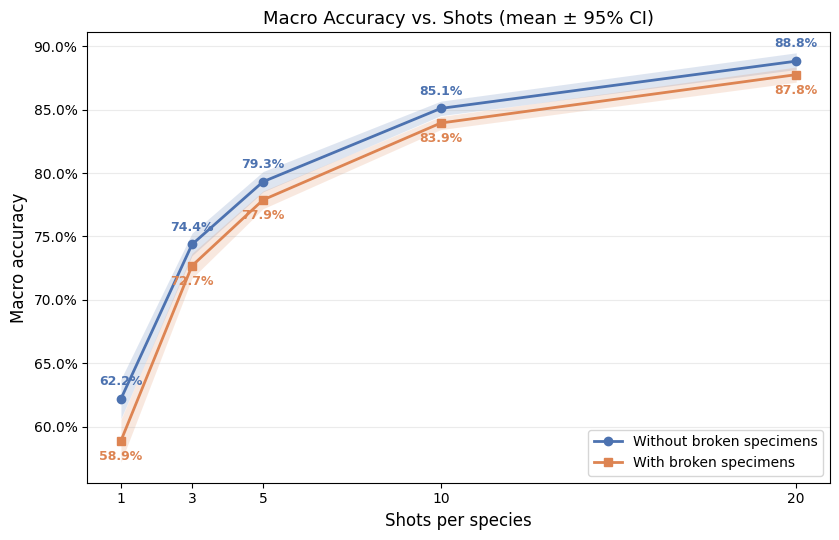

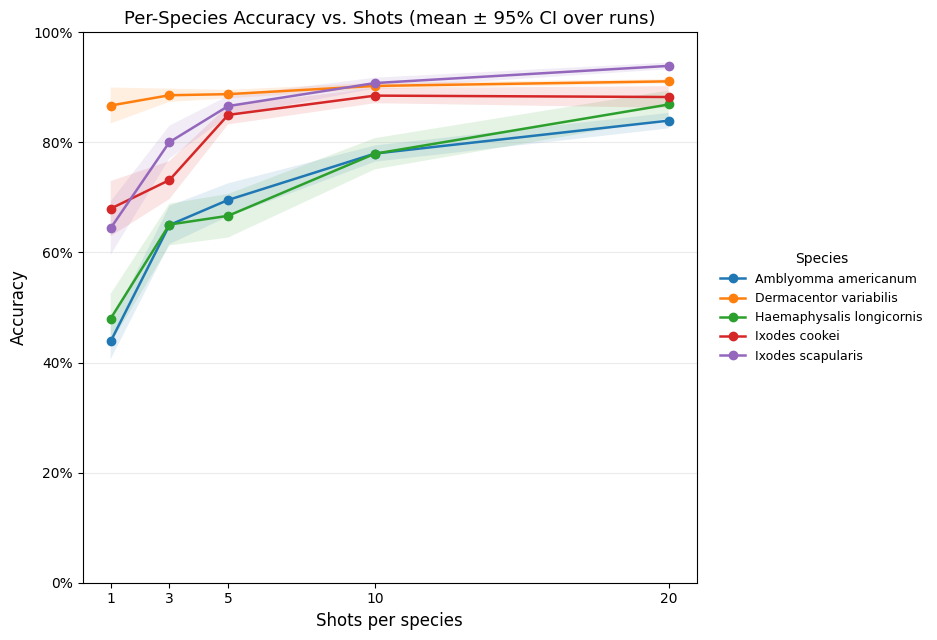

In [75]:
# === Block 8 — Visualization: Macro curve (clean vs with-broken overlay) + per-species learning curves ===
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import math
import numpy as np

# ---------- 1) Macro accuracy: Clean vs With-Broken overlay ----------
fig, ax = plt.subplots(figsize=(8.5, 5.5))

COLOR_CLEAN  = "#4C72B0"   # steel blue
COLOR_BROKEN = "#DD8452"   # warm orange

# Clean data (without broken specimens)
x  = agg_shots["shots"].to_numpy()
y  = agg_shots["mean_macro"].to_numpy()
ci = agg_shots["ci95_macro"].to_numpy()

ax.plot(x, y, marker="o", linewidth=2.0, color=COLOR_CLEAN, label="Without broken specimens")
ax.fill_between(x, y - ci, y + ci, alpha=0.18, color=COLOR_CLEAN, linewidth=0)

for xi, yi in zip(x, y):
    ax.annotate(f"{yi*100:.1f}%", (xi, yi),
                textcoords="offset points", xytext=(0, 10),
                ha="center", fontsize=9, fontweight="semibold", color=COLOR_CLEAN)

# With broken specimens
x_wb  = agg_shots_with_broken["shots"].to_numpy()
y_wb  = agg_shots_with_broken["mean_macro"].to_numpy()
ci_wb = agg_shots_with_broken["ci95_macro"].to_numpy()

ax.plot(x_wb, y_wb, marker="s", linewidth=2.0, color=COLOR_BROKEN, label="With broken specimens")
ax.fill_between(x_wb, y_wb - ci_wb, y_wb + ci_wb, alpha=0.18, color=COLOR_BROKEN, linewidth=0)

for xi, yi in zip(x_wb, y_wb):
    ax.annotate(f"{yi*100:.1f}%", (xi, yi),
                textcoords="offset points", xytext=(0, -14),
                ha="center", fontsize=9, fontweight="semibold", color=COLOR_BROKEN)

ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.set_xlabel("Shots per species", fontsize=12)
ax.set_ylabel("Macro accuracy", fontsize=12)
ax.set_title("Macro Accuracy vs. Shots (mean ± 95% CI)", fontsize=13)
ax.set_xticks(x)
ax.grid(True, axis="y", alpha=0.25)
ax.legend(fontsize=10, loc="lower right")
plt.tight_layout()

if SAVE_PLOTS:
    out = PLOTS_DIR / "macro_accuracy_comparison.png"
    plt.savefig(out, dpi=200)
    print(f"[PLOT] saved {out}")
plt.show()

# ---------- 2) Per-species learning curves (95% CI, sorted, paginated) ----------
K_max = int(np.max(per_species_summary["shots"]))
lastK = (per_species_summary.query("shots == @K_max")
         .sort_values("acc_mean", ascending=False)["species"].tolist())

species_order = lastK
shots_grid = np.sort(per_species_summary["shots"].unique())

SPEC_PER_PAGE = 12
num_pages = math.ceil(len(species_order) / SPEC_PER_PAGE)

for page in range(num_pages):
    start = page * SPEC_PER_PAGE
    end   = start + SPEC_PER_PAGE
    subset = species_order[start:end]
    subdf = per_species_summary[per_species_summary["species"].isin(subset)].copy()

    fig, ax = plt.subplots(figsize=(9.5, 6.5))
    for sp, g in subdf.groupby("species"):
        g = (g.set_index("shots")
               .reindex(shots_grid)
               .reset_index())
        y  = g["acc_mean"].to_numpy()
        ci = g["acc_ci95"].to_numpy()
        ax.plot(shots_grid, y, marker="o", linewidth=1.8, label=sp)
        lo = (y - ci); hi = (y + ci)
        ax.fill_between(shots_grid, lo, hi, alpha=0.12, linewidth=0)

    ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    ax.set_xticks(shots_grid)
    ax.set_ylim(0, 1.0)
    ax.set_xlabel("Shots per species", fontsize=12)
    ax.set_ylabel("Accuracy", fontsize=12)
    ttl = "Per-Species Accuracy vs. Shots (mean ± 95% CI over runs)"
    if num_pages > 1:
        ttl += f"  —  page {page+1}/{num_pages}"
    ax.set_title(ttl, fontsize=13)
    ax.grid(True, axis="y", alpha=0.25)

    leg = ax.legend(title="Species", loc="center left", bbox_to_anchor=(1.02, 0.5),
                    frameon=False, fontsize=9, title_fontsize=10)
    plt.tight_layout()
    
    if SAVE_PLOTS:
        out = PLOTS_DIR / f"species_learning_curves_page{page+1:02d}.png"
        plt.savefig(out, dpi=200, bbox_inches="tight")
        print(f"[PLOT] saved {out}")
    plt.show()

In [ ]:
# === Block 9A — Row-normalized mean confusion per K (averaged over runs) ===
# Uses Tableau-style blue gradient for readability
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

def mean_rownorm_confusion_for_K(df, K, class_order=None):
    """
    For a given shots K:
      - builds confusion per run (rows=true species)
      - row-normalizes each run's confusion
      - averages row-normalized matrices over runs
    """
    dK = df[df["shots"] == K].copy()
    if class_order is None:
        classes = sorted(pd.unique(dK["species_true"]))
    else:
        classes = [c for c in class_order if c in set(dK["species_true"])]
    n = len(classes)
    if n == 0:
        raise ValueError(f"No classes present at K={K}.")

    mean_conf = np.zeros((n, n), dtype=float)
    row_counts = np.zeros(n, dtype=int)

    for run_id, dKr in dK.groupby("run_id"):
        ct = pd.crosstab(
            pd.Series(dKr["species_true"], name="true"),
            pd.Series(dKr["species_pred"], name="pred")
        )
        ct = ct.reindex(index=classes, columns=classes, fill_value=0)
        m = ct.to_numpy().astype(float)

        row_sums = m.sum(axis=1, keepdims=True)
        nonzero_rows = (row_sums[:, 0] > 0)
        if not np.any(nonzero_rows):
            continue
        m_norm = np.zeros_like(m)
        m_norm[nonzero_rows] = m[nonzero_rows] / row_sums[nonzero_rows]

        mean_conf[nonzero_rows] += m_norm[nonzero_rows]
        row_counts[nonzero_rows] += 1

    for i in range(n):
        if row_counts[i] > 0:
            mean_conf[i] /= row_counts[i]

    return classes, mean_conf, row_counts

def plot_mean_confusion(K, classes, mean_conf, counts_per_row, outpath):
    n = len(classes)
    fig_h = max(6, 0.55 * n)
    fig_w = max(7, 0.7 * n)
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))

    im = ax.imshow(mean_conf, aspect="auto", cmap="Blues", vmin=0, vmax=1)

    y_labels = [f"{cls}  (N={SPECIES_N.get(cls, 0)})" for cls in classes]

    ax.set_xticks(range(n)); ax.set_yticks(range(n))
    ax.set_xticklabels(classes, rotation=45, ha="right", fontsize=9)
    ax.set_yticklabels(y_labels, fontsize=9)
    ax.set_xlabel("Predicted species", fontsize=11)
    ax.set_ylabel("True species", fontsize=11)
    ax.set_title(f"Row-normalized mean confusion — {K}-shot (averaged over runs)", fontsize=12)

    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.yaxis.set_major_formatter(PercentFormatter(1.0))

    # Annotate ALL cells with percentages — adaptive text color for readability
    for i in range(n):
        for j in range(n):
            val = mean_conf[i, j]
            text_color = "white" if val > 0.5 else "#1a1a2e"
            fontweight = "bold" if i == j else "normal"
            ax.text(j, i, f"{val*100:.0f}%",
                    ha="center", va="center", fontsize=10,
                    color=text_color, fontweight=fontweight)

    plt.tight_layout()
    
    if SAVE_PLOTS:
        outpath.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(outpath, dpi=200, bbox_inches="tight")
        print(f"[PLOT] saved {outpath}")
    plt.show()

# Generate confusion matrices for all shot levels
for K in SHOTS:
    classes, M, counts = mean_rownorm_confusion_for_K(df, K, class_order=CLASS_ORDER)
    plot_mean_confusion(K, classes, M, counts, PLOTS_DIR / f"confusion_mean_rownorm_K{K:02d}.png")

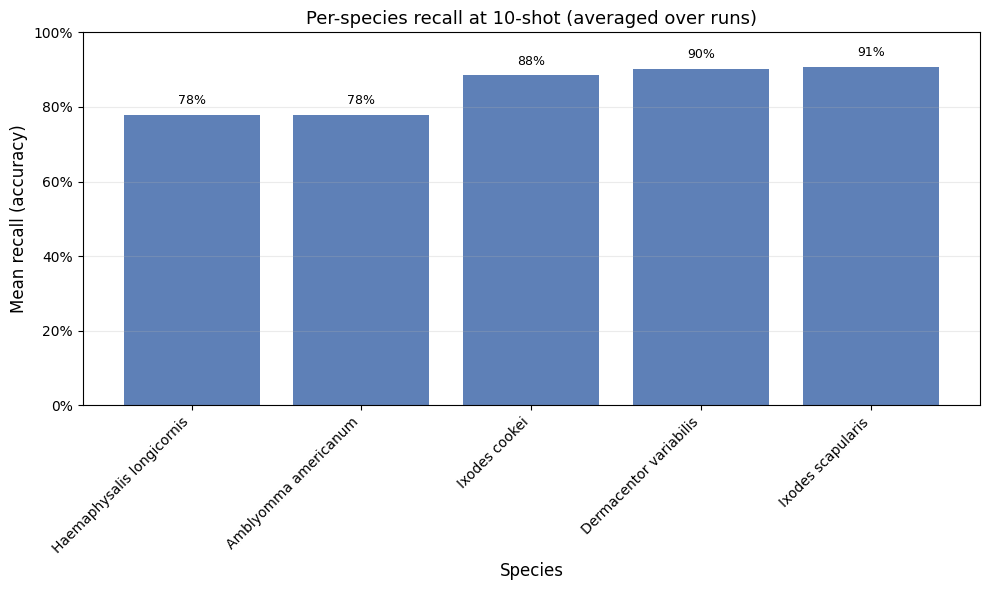

In [77]:
# === Block 9B — Simple per-species recall bar chart (vertical version) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

K_BAR = 10  # choose which shot level to show
sub = per_species_summary[per_species_summary["shots"] == K_BAR].copy()
if len(sub) == 0:
    raise ValueError(f"No per-species summary found for shots={K_BAR}. Run Block 7 first.")

# Harmonize column names
if "species_true" in sub.columns and "species" not in sub.columns:
    sub = sub.rename(columns={"species_true": "species"})

# Sort from lowest → highest accuracy
sub = sub.sort_values("acc_mean", ascending=True).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(10, 6))

# --- vertical bars ---
ax.bar(sub["species"], sub["acc_mean"], color="#4C72B0", alpha=0.9)

# --- format axes ---
ax.set_ylim(0, 1.0)
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.set_ylabel("Mean recall (accuracy)", fontsize=12)
ax.set_xlabel("Species", fontsize=12)
ax.set_title(f"Per-species recall at {K_BAR}-shot (averaged over runs)", fontsize=13)
ax.grid(axis="y", alpha=0.25)

# Rotate labels so they don't overlap
plt.xticks(rotation=45, ha="right")

# Annotate bars with % values above them
for i, val in enumerate(sub["acc_mean"]):
    ax.text(i, val + 0.02, f"{val*100:.0f}%", ha="center", va="bottom", fontsize=9)

plt.tight_layout()

if SAVE_PLOTS:
    out = PLOTS_DIR / f"per_species_recall_K{K_BAR:02d}.png"
    plt.savefig(out, dpi=200, bbox_inches="tight")
    print(f"[PLOT] saved {out}")
plt.show()

## Block 10: error analysis

In [78]:
# === Block 10 — Error analysis: CSVs for ALL samples with full stats + image paths ===

from pathlib import Path
import pandas as pd
import numpy as np

# Path to your JSON metadata file
META_JSON = paths['processed_dir'] / 'final_data_no_ixodes.json'

# Helper functions 
def choose_most_dominant_value(series: pd.Series):
    """Return the most dominant (most frequent) non-null value in a Series."""
    s = series.dropna()
    if s.empty:
        return np.nan
    mode_values = s.mode()
    if len(mode_values) > 0:
        return mode_values.iloc[0]
    return s.iloc[0]

def count_incorrect(series: pd.Series) -> int:
    """Count how many entries are incorrect (assumes 0 = incorrect, 1 = correct)."""
    return int((series == 0).sum())

def count_correct(series: pd.Series) -> int:
    """Count how many entries are correct (assumes 0 = incorrect, 1 = correct)."""
    return int((series == 1).sum())

# ---------------------------------------------------------------------
# 1) Load predictions from this run
# ---------------------------------------------------------------------
df_pred = pd.read_csv(PREDICTIONS_CSV)
print(f"[LOAD] Predictions: {PREDICTIONS_CSV.name}, rows = {len(df_pred)}")

# Ensure types are consistent
df_pred["shots"] = df_pred["shots"].astype(int)
df_pred["run_id"] = df_pred["run_id"].astype(int)
df_pred["correct"] = df_pred["correct"].astype(int)
df_pred["sample_id"] = df_pred["sample_id"].astype(str)

# ---------------------------------------------------------------------
# 2) Load metadata from JSON
# ---------------------------------------------------------------------
if not META_JSON.exists():
    raise FileNotFoundError(f"Metadata JSON not found at {META_JSON}.")

meta_df = pd.read_json(META_JSON)
meta_df["sample_id"] = meta_df["sample_id"].astype(str)

print(f"[LOAD] Metadata JSON: {META_JSON.name}, rows = {len(meta_df)}")

# ---------------------------------------------------------------------
# 3) Collapse metadata to one row per sample_id (with image paths)
# ---------------------------------------------------------------------
# Dominant scalar fields per sample
meta_sample = (
    meta_df
    .groupby("sample_id", as_index=False)
    .agg(
        species_true=("true_label", choose_most_dominant_value),
        sex=("sex", choose_most_dominant_value),
        life_stage=("life_stage", choose_most_dominant_value),
        attached=("attached", choose_most_dominant_value),
    )
)

# Representative dorsal/ventral image paths
dorsal_paths = (
    meta_df[meta_df["view"] == "dorsal"]
    .groupby("sample_id")["image_path"]
    .first()
    .rename("dorsal_image_path")
)
ventral_paths = (
    meta_df[meta_df["view"] == "ventral"]
    .groupby("sample_id")["image_path"]
    .first()
    .rename("ventral_image_path")
)

meta_sample = (
    meta_sample
    .merge(dorsal_paths, on="sample_id", how="left")
    .merge(ventral_paths, on="sample_id", how="left")
)

print(f"[META] Collapsed to {len(meta_sample)} unique sample_ids")

# ---------------------------------------------------------------------
# 4) Build per-sample prediction summary (ALL samples)
# ---------------------------------------------------------------------
# Basic stats per sample_id
sample_stats = (
    df_pred
    .groupby("sample_id", as_index=False)
    .agg(
        n_rows=("correct", "size"),
        n_incorrect=("correct", count_incorrect),
        n_correct=("correct", count_correct),
        mean_conf_overall=("conf_top1", "mean"),
    )
)

sample_stats["incorrect_rate"] = sample_stats["n_incorrect"] / sample_stats["n_rows"]

# Most common wrong label per sample (if any)
wrong_rows = df_pred[df_pred["correct"] == 0].copy()

if len(wrong_rows) > 0:
    wrong_summary = (
        wrong_rows
        .groupby(["sample_id", "species_pred"], as_index=False)
        .agg(
            n_incorrect_pred=("species_pred", "size"),
            mean_conf_when_wrong=("conf_top1", "mean"),
        )
        .sort_values(
            ["sample_id", "n_incorrect_pred", "mean_conf_when_wrong"],
            ascending=[True, False, False],
        )
    )

    top_wrong_per_sample = (
        wrong_summary
        .groupby("sample_id", as_index=False)
        .head(1)
        .rename(
            columns={
                "species_pred": "most_common_wrong_pred",
                "n_incorrect_pred": "n_incorrect_to_most_common",
                "mean_conf_when_wrong": "mean_conf_to_most_common",
            }
        )
        [["sample_id", "most_common_wrong_pred", "n_incorrect_to_most_common", "mean_conf_to_most_common"]]
    )
else:
    top_wrong_per_sample = pd.DataFrame(
        columns=["sample_id", "most_common_wrong_pred", "n_incorrect_to_most_common", "mean_conf_to_most_common"]
    )

sample_stats = sample_stats.merge(top_wrong_per_sample, on="sample_id", how="left")

# Error rate by shot level per sample (err_by_shot_K)
shot_stats = (
    df_pred
    .groupby(["sample_id", "shots"], as_index=False)
    .agg(
        n_rows_shot=("correct", "size"),
        n_incorrect_shot=("correct", count_incorrect),
    )
)

# Pivot shot-level error rates into columns
pivot_nrows = shot_stats.pivot(index="sample_id", columns="shots", values="n_rows_shot")
pivot_ninc = shot_stats.pivot(index="sample_id", columns="shots", values="n_incorrect_shot")
err_by_shot = pivot_ninc / pivot_nrows

# Rename columns like err_by_shot_1, err_by_shot_3, ...
err_by_shot.columns = [f"err_by_shot_{int(k)}" for k in err_by_shot.columns]
err_by_shot = err_by_shot.reset_index()

sample_stats = sample_stats.merge(err_by_shot, on="sample_id", how="left")

# Attach metadata to the sample stats (ALL samples, including image paths)
sample_summary = sample_stats.merge(meta_sample, on="sample_id", how="left")

# Reorder columns for clarity
col_order = [
    "sample_id", "species_true",
    "n_rows", "n_correct", "n_incorrect", "incorrect_rate",
    "most_common_wrong_pred", "n_incorrect_to_most_common", "mean_conf_to_most_common",
    "mean_conf_overall"
]
# Add err_by_shot columns
err_cols = [c for c in sample_summary.columns if c.startswith("err_by_shot_")]
col_order.extend(sorted(err_cols, key=lambda x: int(x.split("_")[-1])))
# Add metadata columns
col_order.extend(["sex", "life_stage", "attached", "dorsal_image_path", "ventral_image_path"])
# Keep only columns that exist
col_order = [c for c in col_order if c in sample_summary.columns]
sample_summary = sample_summary[col_order]

# Sort by incorrect_rate descending (hardest samples first)
sample_summary = sample_summary.sort_values(
    ["incorrect_rate", "n_incorrect"],
    ascending=[False, False]
).reset_index(drop=True)

print(f"[SAMPLE] sample_summary: {len(sample_summary)} samples (ALL samples included)")

# ---------------------------------------------------------------------
# 5) Species-level summary
# ---------------------------------------------------------------------
species_summary = (
    df_pred
    .groupby("species_true", as_index=False)
    .agg(
        n_total_rows=("correct", "size"),
        n_total_incorrect=("correct", count_incorrect),
        n_total_correct=("correct", count_correct),
    )
)
species_summary["error_rate"] = species_summary["n_total_incorrect"] / species_summary["n_total_rows"]

# Most confused-with per species
confusion_summary = (
    df_pred
    .groupby(["species_true", "species_pred"], as_index=False)
    .size()
    .rename(columns={"size": "count"})
)

true_totals = (
    confusion_summary
    .groupby("species_true", as_index=False)["count"]
    .sum()
    .rename(columns={"count": "true_total"})
)

confusion_summary = confusion_summary.merge(true_totals, on="species_true", how="left")
confusion_summary["rate_within_true"] = confusion_summary["count"] / confusion_summary["true_total"]

# Most confused-with per species (ignore diagonal)
wrong_confusion = confusion_summary[confusion_summary["species_true"] != confusion_summary["species_pred"]].copy()

if len(wrong_confusion) > 0:
    most_confused_with = (
        wrong_confusion
        .sort_values(["species_true", "count"], ascending=[True, False])
        .groupby("species_true", as_index=False)
        .head(1)
        .rename(
            columns={
                "species_pred": "most_confused_with",
                "count": "misclass_count",
                "rate_within_true": "misclass_rate_within_true",
            }
        )
        [["species_true", "most_confused_with", "misclass_count", "misclass_rate_within_true"]]
    )
else:
    most_confused_with = pd.DataFrame(
        columns=["species_true", "most_confused_with", "misclass_count", "misclass_rate_within_true"]
    )

species_summary = species_summary.merge(most_confused_with, on="species_true", how="left")

print(f"[SPECIES] species_summary: {len(species_summary)} species")
print(f"[CONFUSION] confusion_summary: {len(confusion_summary)} pairs")

# ---------------------------------------------------------------------
# 6) Save CSVs to ANALYSIS_DIR
# ---------------------------------------------------------------------

# sample_summary.csv - ALL samples with full stats + image paths (sorted by incorrect_rate)
sample_summary.to_csv(ANALYSIS_DIR / "sample_summary.csv", index=False)
print(f"[SAVE] sample_summary.csv -> {ANALYSIS_DIR} ({len(sample_summary)} rows, sorted by incorrect_rate)")

# species_summary.csv
species_summary.to_csv(ANALYSIS_DIR / "species_summary.csv", index=False)
print(f"[SAVE] species_summary.csv -> {ANALYSIS_DIR} ({len(species_summary)} rows)")

# confusion_summary.csv
confusion_summary.to_csv(ANALYSIS_DIR / "confusion_summary.csv", index=False)
print(f"[SAVE] confusion_summary.csv -> {ANALYSIS_DIR} ({len(confusion_summary)} rows)")

# ---------------------------------------------------------------------
# 7) Preview in notebook
# ---------------------------------------------------------------------
from IPython.display import display

print("\n" + "=" * 60)
print("Block 10 Error Analysis Complete")
print("=" * 60)

print("\n[SAMPLE SUMMARY PREVIEW] (first 5 rows, sorted by incorrect_rate)")
display(sample_summary.head())

print("\n[SPECIES SUMMARY]")
display(species_summary)

print("\n[CONFUSION SUMMARY] (top 10 by count)")
display(confusion_summary.sort_values("count", ascending=False).head(10))

print(f"\n[INFO] All {len(sample_summary)} samples saved to sample_summary.csv")
print(f"[INFO] Sorted by incorrect_rate descending (hardest samples first)")
print("=" * 60)

[LOAD] Predictions: predictions.csv, rows = 272000
[LOAD] Metadata JSON: final_data_no_ixodes.json, rows = 1198
[META] Collapsed to 599 unique sample_ids
[SAMPLE] sample_summary: 583 samples (ALL samples included)
[SPECIES] species_summary: 5 species
[CONFUSION] confusion_summary: 25 pairs
[SAVE] sample_summary.csv -> /Users/jayjivandas/Research_Imageomics/BioClip/tick_classification_project/results/svm/runs/260208_205637/analysis (583 rows, sorted by incorrect_rate)
[SAVE] species_summary.csv -> /Users/jayjivandas/Research_Imageomics/BioClip/tick_classification_project/results/svm/runs/260208_205637/analysis (5 rows)
[SAVE] confusion_summary.csv -> /Users/jayjivandas/Research_Imageomics/BioClip/tick_classification_project/results/svm/runs/260208_205637/analysis (25 rows)

Block 10 Error Analysis Complete

[SAMPLE SUMMARY PREVIEW] (first 5 rows, sorted by incorrect_rate)


,sample_id,species_true,n_rows,n_correct,n_incorrect,incorrect_rate,most_common_wrong_pred,n_incorrect_to_most_common,mean_conf_to_most_common,mean_conf_overall,err_by_shot_1,err_by_shot_3,err_by_shot_5,err_by_shot_10,err_by_shot_20,sex,life_stage,attached,dorsal_image_path,ventral_image_path
0,ZOE-0021-03,Dermacentor variabilis,489,14,475,0.971370,Amblyomma americanum,220,0.340172,0.308315,0.940000,0.949495,0.980000,0.989583,1.000000,Female,Adult,NaN,/Users/jayjivandas/Library/CloudStorage/OneDri...,/Users/jayjivandas/Library/CloudStorage/OneDri...
1,296-01,Ixodes scapularis,471,19,452,0.959660,Amblyomma americanum,218,0.362204,0.332715,0.919192,0.917526,0.968750,1.000000,1.000000,NaN,Nymph,NaN,/Users/jayjivandas/Library/CloudStorage/OneDri...,/Users/jayjivandas/Library/CloudStorage/OneDri...
2,ZOE-0096-01,Dermacentor variabilis,487,20,467,0.958932,Haemaphysalis longicornis,368,0.385317,0.357662,0.900000,0.940000,0.969072,0.989474,1.000000,Female,Adult,No,/Users/jayjivandas/Library/CloudStorage/OneDri...,/Users/jayjivandas/Library/CloudStorage/OneDri...
3,218-01,Dermacentor variabilis,486,28,458,0.942387,Amblyomma americanum,233,0.332162,0.298463,0.848485,0.930000,0.960000,0.978947,1.000000,Female,Adult,NaN,/Users/jayjivandas/Library/CloudStorage/OneDri...,/Users/jayjivandas/Library/CloudStorage/OneDri...
4,172-01,Dermacentor variabilis,489,30,459,0.938650,Haemaphysalis longicornis,305,0.319744,0.314162,0.890000,0.940000,0.957895,0.948980,0.958333,Female,Adult,NaN,/Users/jayjivandas/Library/CloudStorage/OneDri...,/Users/jayjivandas/Library/CloudStorage/OneDri...



[SPECIES SUMMARY]


,species_true,n_total_rows,n_total_incorrect,n_total_correct,error_rate,most_confused_with,misclass_count,misclass_rate_within_true
0,Amblyomma americanum,39600,13037,26563,0.329217,Haemaphysalis longicornis,8581,0.216692
1,Dermacentor variabilis,147600,16164,131436,0.109512,Haemaphysalis longicornis,8442,0.057195
2,Haemaphysalis longicornis,10600,3701,6899,0.349151,Amblyomma americanum,2235,0.210849
3,Ixodes cookei,10100,2182,7918,0.216040,Haemaphysalis longicornis,1120,0.110891
4,Ixodes scapularis,64100,11078,53022,0.172824,Ixodes cookei,3380,0.052730



[CONFUSION SUMMARY] (top 10 by count)


,species_true,species_pred,count,true_total,rate_within_true
6,Dermacentor variabilis,Dermacentor variabilis,131436,147600,0.890488
24,Ixodes scapularis,Ixodes scapularis,53022,64100,0.827176
0,Amblyomma americanum,Amblyomma americanum,26563,39600,0.670783
2,Amblyomma americanum,Haemaphysalis longicornis,8581,39600,0.216692
7,Dermacentor variabilis,Haemaphysalis longicornis,8442,147600,0.057195
18,Ixodes cookei,Ixodes cookei,7918,10100,0.783960
12,Haemaphysalis longicornis,Haemaphysalis longicornis,6899,10600,0.650849
5,Dermacentor variabilis,Amblyomma americanum,5286,147600,0.035813
23,Ixodes scapularis,Ixodes cookei,3380,64100,0.052730
20,Ixodes scapularis,Amblyomma americanum,3356,64100,0.052356



[INFO] All 583 samples saved to sample_summary.csv
[INFO] Sorted by incorrect_rate descending (hardest samples first)


In [79]:
# === Block 11 — HTML Sample Gallery with Fed/Unfed Annotations ===
# Images embedded as base64 data URIs
# Fed/Unfed annotations persist in browser localStorage across sessions

from pathlib import Path
import pandas as pd
import html
import base64
from PIL import Image
import io

gallery_path = ANALYSIS_DIR / "sample_gallery.html"

# ---------------------------------------------------------------------
# 1) Load the sample summary we created in Block 10
# ---------------------------------------------------------------------
sample_summary_path = ANALYSIS_DIR / "sample_summary.csv"

if not sample_summary_path.exists():
    raise FileNotFoundError("sample_summary.csv not found. Run Block 10 first.")

sample_df = pd.read_csv(sample_summary_path)
print(f"[LOAD] Sample summary: {len(sample_df)} samples")

# ---------------------------------------------------------------------
# 2) Helpers
# ---------------------------------------------------------------------
_img_cache = {}

def image_to_base64(path, max_size=400):
    if path in _img_cache:
        return _img_cache[path]
    try:
        img = Image.open(path).convert("RGB")
        img.thumbnail((max_size, max_size), Image.LANCZOS)
        buffer = io.BytesIO()
        img.save(buffer, format="JPEG", quality=85)
        b64 = base64.b64encode(buffer.getvalue()).decode("utf-8")
        data_uri = f"data:image/jpeg;base64,{b64}"
        _img_cache[path] = data_uri
        return data_uri
    except Exception as e:
        print(f"[WARN] Could not encode image {path}: {e}")
        return None

def make_image_tag(path, label):
    if pd.isna(path) or not Path(str(path)).exists():
        return f'<div class="img-missing">No {html.escape(label)} image</div>'
    data_uri = image_to_base64(str(path))
    if data_uri is None:
        return f'<div class="img-missing">Could not load {html.escape(label)} image</div>'
    return f'<img src="{data_uri}" alt="{html.escape(label)}" class="tick-image">'

def sample_card(row):
    sample_id = str(row.get("sample_id", ""))
    true_species = row.get("species_true", "")
    most_common_pred = row.get("most_common_wrong_pred", "")
    incorrect_rate = row.get("incorrect_rate", "")
    n_incorrect = row.get("n_incorrect", "")
    n_rows = row.get("n_rows", "")
    sex = row.get("sex", "")
    life_stage = row.get("life_stage", "")
    attached = row.get("attached", "")
    dorsal_path = row.get("dorsal_image_path", "")
    ventral_path = row.get("ventral_image_path", "")

    dorsal_img = make_image_tag(dorsal_path, "dorsal")
    ventral_img = make_image_tag(ventral_path, "ventral")

    def fmt(x):
        if isinstance(x, float):
            if pd.isna(x):
                return ""
            return f"{x:.3f}"
        return "" if pd.isna(x) else str(x)

    if n_incorrect == 0:
        status_badge = '<span class="badge correct">All Correct</span>'
    elif incorrect_rate > 0.5:
        status_badge = '<span class="badge hard">Hard Sample</span>'
    else:
        status_badge = '<span class="badge some-errors">Some Errors</span>'

    esc_sid = html.escape(fmt(sample_id))

    html_block = f"""
    <div class="sample-card" data-species="{html.escape(fmt(true_species))}" data-incorrect="{fmt(n_incorrect)}" data-rate="{fmt(incorrect_rate)}" data-fed="false">
      <div class="meta">
        <div><strong>Sample ID:</strong> {esc_sid} {status_badge}</div>
        <div><strong>True species:</strong> {html.escape(fmt(true_species))}</div>
        <div><strong>Most common wrong prediction:</strong> {html.escape(fmt(most_common_pred)) if fmt(most_common_pred) else 'N/A'}</div>
        <div><strong>Incorrect:</strong> {html.escape(fmt(n_incorrect))} / {html.escape(fmt(n_rows))}
             (rate = {html.escape(fmt(incorrect_rate))})</div>
        <div><strong>Sex:</strong> {html.escape(fmt(sex))}</div>
        <div><strong>Life stage:</strong> {html.escape(fmt(life_stage))}</div>
        <div><strong>Attached:</strong> {html.escape(fmt(attached))}</div>
        <div class="fed-status">
          <label class="fed-label">
            <input type="checkbox" class="fed-check" data-sample="{esc_sid}" onchange="saveFedStatus(this)">
            <span class="fed-text">Fed</span>
          </label>
        </div>
      </div>
      <div class="images">
        <div class="image-column">
          <div class="image-label">Dorsal</div>
          {dorsal_img}
        </div>
        <div class="image-column">
          <div class="image-label">Ventral</div>
          {ventral_img}
        </div>
      </div>
    </div>
    """
    return html_block

# ---------------------------------------------------------------------
# 3) Build the HTML document
# ---------------------------------------------------------------------
print("[INFO] Encoding images as base64 (this may take a moment)...")

sample_df_sorted = sample_df.sort_values(
    ["incorrect_rate", "n_incorrect"],
    ascending=[False, False]
).reset_index(drop=True)

all_cards = "\n".join(sample_card(row) for _, row in sample_df_sorted.iterrows())

print(f"[INFO] Encoded {len(_img_cache)} unique images")

species_list = sorted(sample_df["species_true"].dropna().unique())
species_options = "\n".join(f'<option value="{html.escape(s)}">{html.escape(s)}</option>' for s in species_list)
n_samples = len(sample_df)

full_html = f"""
<!DOCTYPE html>
<html>
<head>
  <meta charset="utf-8">
  <title>Tick Sample Gallery - Run {RUN_ID}</title>
  <style>
    body {{
      font-family: -apple-system, BlinkMacSystemFont, "Segoe UI", sans-serif;
      margin: 20px;
      background-color: #111;
      color: #eee;
    }}
    h1, h2, h3 {{
      color: #ffcc66;
    }}
    .filters {{
      background: #222;
      padding: 15px;
      border-radius: 8px;
      margin-bottom: 12px;
      display: flex;
      gap: 20px;
      flex-wrap: wrap;
      align-items: center;
    }}
    .filters label {{
      font-weight: bold;
    }}
    .filters select, .filters input {{
      padding: 8px;
      border-radius: 4px;
      border: 1px solid #444;
      background: #333;
      color: #eee;
    }}
    .annotation-bar {{
      background: #1a2a1a;
      padding: 12px 15px;
      border-radius: 8px;
      margin-bottom: 12px;
      display: flex;
      gap: 15px;
      align-items: center;
      flex-wrap: wrap;
    }}
    .export-btn {{
      padding: 8px 16px;
      border-radius: 6px;
      border: 1px solid #4CAF50;
      background: #2d5a27;
      color: #90EE90;
      cursor: pointer;
      font-weight: bold;
      font-size: 0.9rem;
    }}
    .export-btn:hover {{
      background: #3d7a37;
    }}
    .stats {{
      background: #1a1a2e;
      padding: 10px 15px;
      border-radius: 8px;
      margin-bottom: 20px;
    }}
    .sample-card {{
      border: 1px solid #444;
      border-radius: 10px;
      padding: 12px;
      margin: 12px 0;
      background-color: #1b1b1b;
      display: flex;
      flex-direction: column;
      gap: 8px;
      transition: border-color 0.15s;
    }}
    .sample-card.hidden {{
      display: none;
    }}
    .sample-card.marked-fed {{
      border-color: #e74c3c;
      border-width: 2px;
    }}
    .badge {{
      padding: 2px 8px;
      border-radius: 4px;
      font-size: 0.8rem;
      margin-left: 10px;
    }}
    .badge.correct {{
      background: #2d5a27;
      color: #90EE90;
    }}
    .badge.hard {{
      background: #5a2727;
      color: #FF6B6B;
    }}
    .badge.some-errors {{
      background: #5a4a27;
      color: #FFD93D;
    }}
    .meta {{
      font-size: 0.9rem;
      line-height: 1.4;
    }}
    .fed-status {{
      margin-top: 6px;
      padding: 4px 0;
    }}
    .fed-label {{
      cursor: pointer;
      display: inline-flex;
      align-items: center;
      gap: 6px;
      padding: 4px 12px;
      border-radius: 6px;
      background: #2a2a2a;
      border: 1px solid #444;
      transition: background 0.15s;
    }}
    .fed-label:hover {{
      background: #333;
    }}
    .fed-check {{
      width: 18px;
      height: 18px;
      cursor: pointer;
      accent-color: #e74c3c;
    }}
    .fed-text {{
      font-size: 0.9rem;
      font-weight: 600;
    }}
    .images {{
      display: flex;
      flex-direction: row;
      gap: 16px;
      margin-top: 8px;
    }}
    .image-column {{
      flex: 1;
      text-align: center;
    }}
    .image-label {{
      margin-bottom: 4px;
      font-size: 0.85rem;
      color: #ccc;
    }}
    .tick-image {{
      max-width: 320px;
      max-height: 320px;
      border-radius: 8px;
      border: 1px solid #555;
      background-color: #000;
    }}
    .img-missing {{
      color: #888;
      font-size: 0.85rem;
      border: 1px dashed #555;
      border-radius: 8px;
      padding: 20px;
    }}
  </style>
</head>
<body>
  <h1>Tick Sample Gallery</h1>
  <p>Run ID: {RUN_ID} | Total samples: {n_samples} | Sorted by: incorrect_rate (highest first)</p>

  <div class="filters">
    <div>
      <label>Species: </label>
      <select id="speciesFilter" onchange="filterSamples()">
        <option value="all">All Species</option>
        {species_options}
      </select>
    </div>
    <div>
      <label>Show: </label>
      <select id="errorFilter" onchange="filterSamples()">
        <option value="all">All Samples</option>
        <option value="errors">Only With Errors</option>
        <option value="hard">Hard Samples (&gt;50% error)</option>
        <option value="correct">All Correct</option>
      </select>
    </div>
    <div>
      <label>Min errors: </label>
      <input type="number" id="minErrors" value="0" min="0" onchange="filterSamples()" style="width:60px">
    </div>
    <div>
      <label>Fed: </label>
      <select id="fedFilter" onchange="filterSamples()">
        <option value="all">All</option>
        <option value="fed">Fed Only</option>
        <option value="not_fed">Not Fed Only</option>
      </select>
    </div>
  </div>

  <div class="annotation-bar">
    <button class="export-btn" onclick="exportAnnotations()">Export Fed Annotations (JSON)</button>
    <span id="progress" style="color: #90EE90;">Loading...</span>
  </div>

  <div class="stats" id="stats">
    Showing all {n_samples} samples
  </div>

  <div id="samples">
    {all_cards}
  </div>

  <script>
    var STORAGE_KEY = 'tick_fed_annotations';

    function loadAnnotations() {{
      try {{
        return JSON.parse(localStorage.getItem(STORAGE_KEY) || '{{}}'  );
      }} catch(e) {{
        return {{}};
      }}
    }}

    function saveFedStatus(checkbox) {{
      var annotations = loadAnnotations();
      var sid = checkbox.dataset.sample;
      if (checkbox.checked) {{
        annotations[sid] = true;
      }} else {{
        delete annotations[sid];
      }}
      localStorage.setItem(STORAGE_KEY, JSON.stringify(annotations));
      updateCardStyle(checkbox);
      updateProgress();
    }}

    function updateCardStyle(checkbox) {{
      var card = checkbox.closest('.sample-card');
      if (checkbox.checked) {{
        card.classList.add('marked-fed');
        card.dataset.fed = 'true';
      }} else {{
        card.classList.remove('marked-fed');
        card.dataset.fed = 'false';
      }}
    }}

    function initCheckboxes() {{
      var annotations = loadAnnotations();
      var checkboxes = document.querySelectorAll('.fed-check');
      checkboxes.forEach(function(cb) {{
        cb.checked = !!annotations[cb.dataset.sample];
        updateCardStyle(cb);
      }});
      updateProgress();
    }}

    function updateProgress() {{
      var annotations = loadAnnotations();
      var total = document.querySelectorAll('.fed-check').length;
      var fed = 0;
      for (var k in annotations) {{
        if (annotations[k]) fed++;
      }}
      document.getElementById('progress').textContent =
        fed + ' marked as fed / ' + total + ' total specimens';
    }}

    function exportAnnotations() {{
      var annotations = loadAnnotations();
      var allSamples = {{}};
      document.querySelectorAll('.fed-check').forEach(function(cb) {{
        var sid = cb.dataset.sample;
        allSamples[sid] = !!annotations[sid];
      }});
      var json = JSON.stringify(allSamples, null, 2);
      var blob = new Blob([json], {{type: 'application/json'}});
      var url = URL.createObjectURL(blob);
      var a = document.createElement('a');
      a.href = url;
      a.download = 'fed_annotations.json';
      document.body.appendChild(a);
      a.click();
      document.body.removeChild(a);
      URL.revokeObjectURL(url);
    }}

    function filterSamples() {{
      var species = document.getElementById('speciesFilter').value;
      var errorType = document.getElementById('errorFilter').value;
      var minErrors = parseInt(document.getElementById('minErrors').value) || 0;
      var fedFilter = document.getElementById('fedFilter').value;

      var cards = document.querySelectorAll('.sample-card');
      var visible = 0;

      cards.forEach(function(card) {{
        var cardSpecies = card.dataset.species;
        var cardIncorrect = parseInt(card.dataset.incorrect) || 0;
        var cardRate = parseFloat(card.dataset.rate) || 0;
        var cardFed = card.dataset.fed === 'true';

        var show = true;

        if (species !== 'all' && cardSpecies !== species) show = false;
        if (errorType === 'errors' && cardIncorrect === 0) show = false;
        if (errorType === 'hard' && cardRate <= 0.5) show = false;
        if (errorType === 'correct' && cardIncorrect > 0) show = false;
        if (cardIncorrect < minErrors) show = false;
        if (fedFilter === 'fed' && !cardFed) show = false;
        if (fedFilter === 'not_fed' && cardFed) show = false;

        if (show) {{
          card.classList.remove('hidden');
          visible++;
        }} else {{
          card.classList.add('hidden');
        }}
      }});

      document.getElementById('stats').textContent = 'Showing ' + visible + ' of {n_samples} samples';
    }}

    window.addEventListener('load', initCheckboxes);
  </script>
</body>
</html>
"""

# ---------------------------------------------------------------------
# 4) Write HTML file
# ---------------------------------------------------------------------
gallery_path.write_text(full_html, encoding="utf-8")

file_size_mb = gallery_path.stat().st_size / (1024 * 1024)
print(f"\n[SAVE] Sample gallery written to: {gallery_path}")
print(f"[INFO] File size: {file_size_mb:.1f} MB")
print(f"[INFO] Fed/Unfed annotations persist in browser localStorage")
print(f"[INFO] Click 'Export Fed Annotations' to download fed_annotations.json")
print(f"[INFO] Untagged specimens default to 'not fed' in the export")
print(f"[INFO] Open in browser: file://{gallery_path.resolve()}")

[LOAD] Sample summary: 583 samples
[INFO] Encoding images as base64 (this may take a moment)...


[INFO] Encoded 1166 unique images

[SAVE] Sample gallery written to: /Users/jayjivandas/Research_Imageomics/BioClip/tick_classification_project/results/svm/runs/260208_205637/analysis/sample_gallery.html
[INFO] File size: 29.5 MB
[INFO] Fed/Unfed annotations persist in browser localStorage
[INFO] Click 'Export Fed Annotations' to download fed_annotations.json
[INFO] Untagged specimens default to 'not fed' in the export
[INFO] Open in browser: file:///Users/jayjivandas/Research_Imageomics/BioClip/tick_classification_project/results/svm/runs/260208_205637/analysis/sample_gallery.html
